<a href="https://colab.research.google.com/github/unicamp-dl/IA025_2022S1/blob/main/ex07/Aula7_Marcus_Vinicius_Borela_de_Castro.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [18]:
nome = "Marcus Vinicius Borela de Castro"
print(f'Meu nome é {nome}')

Meu nome é Marcus Vinicius Borela de Castro


#  Exercício: Modelo de Linguagem (Bengio 2003) - MLP + Embeddings

Neste exercício iremos treinar uma rede neural simples para prever a proxima palavra de um texto, data as palavras anteriores como entrada. Esta tarefa é chamada de "Modelagem da Língua".

Este dataset já possui um tamanho razoável e é bem provável que você vai precisar rodar seus experimentos com GPU.

Alguns conselhos úteis:
- **ATENÇÃO:** o dataset é bem grande. Não dê comando de imprimí-lo.
- Durante a depuração, faça seu dataset ficar bem pequeno, para que a depuração seja mais rápida e não precise de GPU. Somente ligue a GPU quando o seu laço de treinamento já está funcionando
- Não deixe para fazer esse exercício na véspera. Ele é trabalhoso.

# Preparação do ambiente

In [19]:
# iremos utilizar a biblioteca dos transformers para ter acesso ao tokenizador do BERT.
!pip install transformers

## Importação dos pacotes

In [20]:
import collections
import itertools
import functools
import math
import random

import torch
import torch.nn as nn
import numpy as np
from torch.utils.data import DataLoader


In [21]:
# from tqdm import tqdm_notebook
# from tqdm import tqdm

In [22]:
import time

In [23]:
import itertools

In [24]:
# Check which GPU we are using
!nvidia-smi

Wed May 18 18:57:11 2022       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 460.32.03    Driver Version: 460.32.03    CUDA Version: 11.2     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla P100-PCIE...  Off  | 00000000:00:04.0 Off |                    0 |
| N/A   35C    P0    26W / 250W |      2MiB / 16280MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [25]:
if torch.cuda.is_available(): 
   dev = "cuda:0"
else: 
   dev = "cpu"
device = torch.device(dev)
print('Using {}'.format(device))

Using cuda:0


## Fixando as seeds

In [26]:
def inicializa_seed(num_semente:int=123):
  """
  É recomendado reiniciar as seeds antes de inicializar o modelo, pois assim
  garantimos que os pesos vao ser sempre os mesmos.
  fontes de apoio: 
      http://nlp.seas.harvard.edu/2018/04/03/attention.html
      https://github.com/CyberZHG/torch-multi-head-attention/blob/master/torch_multi_head_attention/multi_head_attention.py#L15
  """
  random.seed(num_semente)
  np.random.seed(num_semente)
  torch.manual_seed(num_semente)
  #torch.cuda.manual_seed(num_semente)
  #Cuda algorithms
  #torch.backends.cudnn.deterministic = True 

In [27]:
inicializa_seed(123)

## Definindo Hiperparâmetros iniciais

In [28]:
def inicia_hparam()->dict:
  # Inicialização dos parâmetros
  hparam = {}
  hparam["num_workers_dataloader"] = 2
  hparam["device"] = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
  if torch.cuda.is_available(): print(torch. cuda. get_device_name(hparam["device"]))    
  return hparam

In [29]:
hparam=inicia_hparam()

Tesla P100-PCIE-16GB


## Preparando para debug

https://zohaib.me/debugging-in-google-collab-notebook/

In [30]:
!pip install -Uqq ipdb
import ipdb
# %pdb off # desativa debug em exceção
# %pdb on  # ativa debug em exceção
# ipdb.set_trace(context=8)  para execução nesse ponto

In [31]:
# %xmode Verbose 
# %xmode Plain
# colocar %debug após ocorrer exception

## Rastro (neptune.ai)

Gerado rastro da execução no Neptune (detalhes no artigo [Rastro-DM: Mineração de Dados com Rastro](https://revista.tcu.gov.br/ojs/index.php/RTCU/article/view/1664))


### Importação de libraries para Rastro

In [32]:
try:
  import neptune.new as neptune  
except ImportError:
  !pip install neptune-client
  raise Exception('Stopping RUNTIME! Please run again.')


In [33]:
try:
  from torchviz import make_dot 
except ImportError:
  !pip install torchviz
  from torchviz import make_dot 


  Created wheel for torchviz: filename=torchviz-0.0.2-py3-none-any.whl size=4150 sha256=df2e951a043b78a0b9d0920da066676720ae917c842b68d16d2c48fb39d38fab
  Stored in directory: /root/.cache/pip/wheels/04/38/f5/dc4f85c3909051823df49901e72015d2d750bd26b086480ec2
Successfully built torchviz


In [34]:
import getpass
import copy
import time
import re
import tempfile
import os


In [35]:
import time


### Código Rastro

Busca implementar o rastro proposto em [Rastro-DM: Mineração de Dados com Rastro](https://revista.tcu.gov.br/ojs/index.php/RTCU/article/view/1664), autores Marcus Vinícius Borela de Castro e Remis Balaniuk, com o apoio da [solução Neptune](https://app.neptune.ai/)



In [36]:
def converte_optimizer_state_dict(parm_optimizer)-> dict:
  # return str(hparam['optimizer'])
  return parm_optimizer.state_dict()['param_groups'][0]

In [37]:
class NeptuneRastroRun():
    se_geracao_rastro = True 
    neptune_project = ""
    tag_contexto_rastro = ""
    neptune_api_token = ""

    def __init__(self, parm_params:dict,  parm_lista_tag:list = None):
      # print(f"NeptuneRastroRun.init: se_geracao_rastro {self.__class__.se_geracao_rastro} parm_params `{parm_params} ")
      if self.__class__.se_geracao_rastro:      
        self.run_neptune = neptune.init(project=self.__class__.neptune_project, api_token=self.__class__.neptune_api_token, capture_hardware_metrics=True)
        self.run_neptune['sys/name'] = self.__class__.tag_contexto_rastro
        vparams = copy.deepcopy(parm_params)
        if "optimizer" in vparams:
          vparams["optimizer"] = converte_optimizer_state_dict(vparams["optimizer"])
        if 'criterion'  in vparams:
          vparams["criterion"] = str(vparams["criterion"])
        if 'scheduler'  in vparams:
          vparams["scheduler"] = str(type(vparams["scheduler"]))
        if 'device' in vparams:
          vparams['device'] = str(vparams["device"])
        self.device = vparams["device"]
        for tag in parm_lista_tag:
          self.run_neptune['sys/tags'].add(tag)
        self.run_neptune['parameters'] = vparams
        self.tmpDir = tempfile.mkdtemp()

    @property
    def run():
      return self.run_neptune

    @classmethod
    def ativa_geracao_rastro(cls):
     cls.se_geracao_rastro = True      

    @classmethod
    def def_contexto(cls):
     cls.se_geracao_rastro = True      

    @classmethod
    def desativa_geracao_rastro(cls):
     cls.se_geracao_rastro = False      

    @classmethod
    def retorna_status_geracao_rastro(cls):
     return cls.se_geracao_rastro      

    @classmethod
    def retorna_tag_contexto_rastro(cls):
     return cls.tag_contexto_rastro 

    @classmethod
    def inicia_contexto(cls, neptune_project, tag_contexto_rastro, neptune_api_token):
      assert '.' not in tag_contexto_rastro, "NeptuneRastroRun.init(): tag_contexto_rastro não pode possuir ponto, pois será usado para gravar nome de arquivo"      
      cls.neptune_api_token = neptune_api_token
      cls.tag_contexto_rastro = tag_contexto_rastro
      cls.neptune_project = neptune_project

    def salva_metrica(self, parm_metricas={}):
      #print(f"NeptuneRastroRun.salva_metrica: se_geracao_rastro {self.__class__.se_geracao_rastro} parm_metricas:{parm_metricas} ")
      if self.__class__.se_geracao_rastro:
        for metrica, valor in parm_metricas.items(): 
          self.run_neptune[metrica].log(valor)
 
    def gera_grafico_modelo(self, loader_train, model):
      if self.__class__.se_geracao_rastro: 
        # efetuar um forward 
        """
        se dataloader devolver x e y:
        """
        x_, y_ = next(iter(loader_train))
        x_ = x_.to(self.device)
        outputs = model(x_)
        """
        # se dataloader devolver dict:
        dados_ = next(iter(loader_train))
        outputs = model(dados_['x'].to(self.device))
        #outputs = model(x_['input_ids'].to(self.device), x_['attention_mask'].to(self.device))
        """
        nome_arquivo = os.path.join(self.tmpDir, "modelo "+ self.__class__.tag_contexto_rastro + time.strftime("%Y-%b-%d %H:%M:%S"))
        make_dot(outputs, params=dict(model.named_parameters()), show_attrs=True, show_saved=True).render(nome_arquivo, format="png")
        self.run_neptune["parameters/model_graph"].upload(nome_arquivo+'.png')
        self.run_neptune['parameters/model'] = re.sub('<bound method Module.state_dict of ', '',str(model.state_dict))      



    def stop(self):
      if self.__class__.se_geracao_rastro:         
        self.run_neptune.stop()


### Definindo parâmetros para o rastro



In [38]:
NeptuneRastroRun.inicia_contexto('marcusborela/IA025', 'Aula 7 - Modelo de linguagem',   getpass.getpass('Informe NEPTUNE_API_TOKEN'))
#NeptuneRastroRun.desativa_geracao_rastro()

Informe NEPTUNE_API_TOKEN··········


# Implementação do MyDataset

In [39]:
from typing import List

In [40]:
def tokenize(text: str, tokenizer):
    return tokenizer(text, return_tensors=None, add_special_tokens=False).input_ids


In [136]:
class MyDataset():
    def __init__(self, texts: List[str], tokenizer, context_size: int):
      # Escreva seu código aqui
      assert isinstance(texts,list), 'texts deve ser do tipo list'
      assert isinstance(texts[0],str), 'texts deve ser do tipo iterator of iterator of strings'
      assert isinstance(context_size,int), 'context_size deve ser do tipo int'
      self.context_size = context_size
      ind_primeira_vez = True
      x_data = []
      y_data = []
      for cnt_texto, texto in enumerate(texts): 
        texto_numericalizado = tokenize(texto, tokenizer)
        num_palavras_texto = len(texto_numericalizado)
        for num_amostra_texto in range(0,num_palavras_texto-self.context_size):
          # ipdb.set_trace(context=6)
          x_data.append(texto_numericalizado[num_amostra_texto:num_amostra_texto + self.context_size])
          y_data.append(texto_numericalizado[num_amostra_texto + self.context_size]) 
        # ipdb.set_trace(context=6)
        if cnt_texto % 1000 == 0:
           print(F'\tMontando Mydataset cnt_texto: {cnt_texto+1};  Momento: {time.strftime("[%Y-%b-%d %H:%M:%S]")}')
      print(F'\tVou converter lista para tensor;  Momento: {time.strftime("[%Y-%b-%d %H:%M:%S]")}')
      self.x_tensor = torch.tensor(x_data).long()
      self.y_tensor = torch.tensor(y_data).long()
      print(F'\tConvertido: lista para tensor;  Momento: {time.strftime("[%Y-%b-%d %H:%M:%S]")}')

    def __len__(self):
        # Escreva seu código aqui
        return len(self.y_tensor)

    def __getitem__(self, idx):
        # Escreva seu código aqui
        return self.x_tensor[idx], self.y_tensor[idx]

## Teste se sua implementação do MyDataset está correta

In [128]:
from transformers import BertTokenizer
tokenizer = BertTokenizer.from_pretrained("neuralmind/bert-base-portuguese-cased")

In [129]:
dummy_texts = ['Eu gosto de correr', 'Ela gosta muito de comer pizza']

In [130]:
tokenize(dummy_texts, tokenizer)

[[3396, 10303, 125, 13239], [1660, 5971, 785, 125, 1847, 13779, 15616]]

In [131]:
dummy_dataset = MyDataset(texts=dummy_texts, tokenizer=tokenizer, context_size=3)
dummy_loader = DataLoader(dummy_dataset, batch_size=6, shuffle=False)
assert len(dummy_dataset) == 5
print('passou no assert de tamanho do dataset')

	Montando Mydataset cnt_texto: 1;  Momento: [2022-May-19 00:01:12]
passou no assert de tamanho do dataset


In [132]:
dummy_texto_tokenizado = tokenize(dummy_texts,tokenizer)
type(dummy_texto_tokenizado), dummy_texto_tokenizado

(list, [[3396, 10303, 125, 13239], [1660, 5971, 785, 125, 1847, 13779, 15616]])

In [133]:
first_batch_input, first_batch_target = next(iter(dummy_loader))

In [134]:
correct_first_batch_input = torch.LongTensor(
    [[ 3396, 10303,   125],
     [ 1660,  5971,   785],
     [ 5971,   785,   125],
     [  785,   125,  1847],
     [  125,  1847, 13779]])

correct_first_batch_target = torch.LongTensor([13239,   125,  1847, 13779, 15616])

assert torch.equal(first_batch_input, correct_first_batch_input)
print('Passou no assert de input')
assert torch.equal(first_batch_target, correct_first_batch_target)
print('Passou no assert de target')

Passou no assert de input
Passou no assert de target


# Carregamento do dataset 

Iremos usar uma pequena amostra do dataset [BrWaC](https://www.inf.ufrgs.br/pln/wiki/index.php?title=BrWaC) para treinar e avaliar nosso modelo de linguagem.

In [49]:
import io

In [50]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [135]:
#@title Boolean fields
datasets_carregados_previamente = True #@param {type:"boolean"}

print(datasets_carregados_previamente)

False


In [52]:
if datasets_carregados_previamente:
  hparam['num_sentenca_train'] = 24800 #@param [800, 2300, 24800] {type:'raw'}
  hparam['num_sentenca_valid'] = 100 # 100
  hparam['num_sentenca_test'] = 100 # 100
  hparam['context_size'] = 9  
  total = hparam['num_sentenca_train']+hparam['num_sentenca_valid']+hparam['num_sentenca_test']
  print(total)


2500


In [53]:
if datasets_carregados_previamente:
  with open('/content/drive/My Drive/ia025/aula7/test_dataset_text_'+str(total)+'.pt', 'rb') as f:
    buffer = io.BytesIO(f.read())
  test_dataset = torch.load(buffer)
  with open('/content/drive/My Drive/ia025/aula7/valid_dataset_text_'+str(total)+'.pt', 'rb') as f:
    buffer = io.BytesIO(f.read())
  valid_dataset = torch.load(buffer)
  with open('/content/drive/My Drive/ia025/aula7/train_dataset_text_'+str(total)+'.pt', 'rb') as f:
    buffer = io.BytesIO(f.read())
  train_dataset = torch.load(buffer)    

In [137]:
if not datasets_carregados_previamente:
  # hparam['num_sentenca_train'] = 2300 #@param {type:"slider", min:500, max:1500, step:10}
  hparam['num_sentenca_valid'] = 100 #@param {type:"slider", min:80, max:150, step:10}
  hparam['num_sentenca_test'] = 100 #@param {type:"slider", min:80, max:150, step:10}
  hparam['context_size'] = 9 #@param {type:"slider", min:3, max:15, step:1}
  !wget -nc https://storage.googleapis.com/unicamp-dl/ia025a_2022s1/aula7/sample_brwac.txt  

  texts = open('sample_brwac.txt').readlines() # acho que são mais de 2500 textos?
  print('Truncating for debugging purposes.')
  # texts = texts[:total]  
  valid_texts = texts[-(hparam['num_sentenca_valid'] + hparam['num_sentenca_test']):-hparam['num_sentenca_test']]
  test_texts = texts[-hparam['num_sentenca_test']:]
  train_texts = texts[:-(hparam['num_sentenca_valid'] + hparam['num_sentenca_test'])]
  hparam['num_sentenca_train'] = len(train_texts)
  total = hparam['num_sentenca_train']+hparam['num_sentenca_valid']+hparam['num_sentenca_test']
  print(f"total: {total}")
  assert total not in (1000, 2500), f"Carga com esse total de sentenças não pode ser {total} pois já foi realizada!"
  
  print("carregando valid_dataset")
  valid_dataset = MyDataset(texts=valid_texts, tokenizer=tokenizer, context_size=hparam['context_size'])
  torch.save(valid_dataset, '/content/drive/My Drive/ia025/aula7/valid_dataset_text_'+str(total)+'.pt')

  print("carregando test_dataset")
  test_dataset = MyDataset(texts=test_texts, tokenizer=tokenizer, context_size=hparam['context_size'])
  torch.save(test_dataset, '/content/drive/My Drive/ia025/aula7/test_dataset_text_'+str(total)+'.pt')
  

--2022-05-19 00:04:10--  https://storage.googleapis.com/unicamp-dl/ia025a_2022s1/aula7/sample_brwac.txt
Resolving storage.googleapis.com (storage.googleapis.com)... 74.125.142.128, 74.125.195.128, 173.194.202.128, ...
Connecting to storage.googleapis.com (storage.googleapis.com)|74.125.142.128|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 123983611 (118M) [text/plain]
Saving to: ‘sample_brwac.txt’

sample_brwac.txt    100%[===================>] 118.24M  76.7MB/s    in 1.5s    

2022-05-19 00:04:12 (76.7 MB/s) - ‘sample_brwac.txt’ saved [123983611/123983611]

Truncating for debugging purposes.
total: 25000
carregando valid_dataset
	Montando Mydataset cnt_texto: 1;  Momento: [2022-May-19 00:04:12]
	Vou converter lista para tensor;  Momento: [2022-May-19 00:04:14]
	Convertido: lista para tensor;  Momento: [2022-May-19 00:04:14]
carregando test_dataset
	Montando Mydataset cnt_texto: 1;  Momento: [2022-May-19 00:04:14]
	Vou converter lista para tensor;  Momento: 

In [138]:
if not datasets_carregados_previamente:
  print("carregando train_dataset")
  train_dataset = MyDataset(texts=train_texts, tokenizer=tokenizer, context_size=hparam['context_size'])

  torch.save(train_dataset, '/content/drive/My Drive/ia025/aula7/train_dataset_text_'+str(total)+'.pt')
  drive.flush_and_unmount()
  print('All changes made in this colab session should now be visible in Drive.')

carregando train_dataset
	Montando Mydataset cnt_texto: 1;  Momento: [2022-May-19 00:04:27]
	Montando Mydataset cnt_texto: 1001;  Momento: [2022-May-19 00:04:47]
	Montando Mydataset cnt_texto: 2001;  Momento: [2022-May-19 00:05:04]
	Montando Mydataset cnt_texto: 3001;  Momento: [2022-May-19 00:05:25]
	Montando Mydataset cnt_texto: 4001;  Momento: [2022-May-19 00:05:45]
	Montando Mydataset cnt_texto: 5001;  Momento: [2022-May-19 00:06:01]
	Montando Mydataset cnt_texto: 6001;  Momento: [2022-May-19 00:06:21]
	Montando Mydataset cnt_texto: 7001;  Momento: [2022-May-19 00:06:39]
	Montando Mydataset cnt_texto: 8001;  Momento: [2022-May-19 00:06:57]
	Montando Mydataset cnt_texto: 9001;  Momento: [2022-May-19 00:07:19]
	Montando Mydataset cnt_texto: 10001;  Momento: [2022-May-19 00:07:38]
	Montando Mydataset cnt_texto: 11001;  Momento: [2022-May-19 00:07:56]
	Montando Mydataset cnt_texto: 12001;  Momento: [2022-May-19 00:08:15]
	Montando Mydataset cnt_texto: 13001;  Momento: [2022-May-19 00:0

In [140]:
hparam['train_size'] = len(train_dataset) 
hparam['valid_size'] = len(valid_dataset) 
hparam['test_size'] = len(test_dataset) 


print(f"training examples: {hparam['train_size']}")
print(f"valid examples: {hparam['valid_size']}")
print(f"test examples: {hparam['test_size']}")





training examples: 27675945
valid examples: 82070
test examples: 166726


Carga total:
*   training examples: 27675945
*   valid examples: 82070
*   test examples: 166726

Carga até 2500 sentenças:
*   training examples: 2626819
*   valid examples: 105210
*   test examples: 97313

Carga até 1000 sentenças:
*   training examples: 927195
*   valid examples: 130102
*   test examples: 99902

# Language Model (proposed by Bengio et al.)

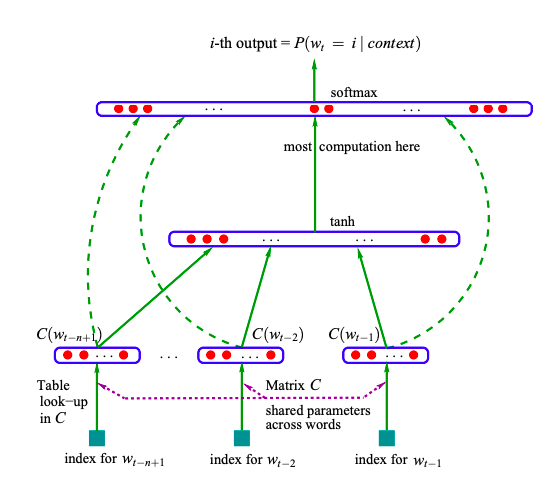

In [72]:
class LanguageModel(torch.nn.Module):

    def __init__(self, vocab_size, context_size, embedding_dim, hidden_size, ind_tipo_nao_linearidade:str='relu', se_projecao_direta:bool=False, verbose=False):
      """
      Implements the Neural Language Model proposed by Bengio et al."
      Sem operação residual

      Args:
          vocab_size (int): Size of the input vocabulary.
          context_size (int): Size of the sequence to consider as context for prediction.
          embedding_dim (int): Dimension of the embedding layer for each word in the context.
          hidden_size (int): Size of the hidden layer.
      
      Fonte apoio:
        https://abhinavcreed13.github.io/blog/bengio-trigram-nplm-using-pytorch/

      """
      # Escreva seu código aqui.
      assert isinstance(vocab_size,int), 'vocab_size deve ser do tipo int'      
      assert isinstance(context_size,int), 'context_size deve ser do tipo int'      
      assert isinstance(embedding_dim,int), 'embedding_dim deve ser do tipo int'      
      assert isinstance(hidden_size,int), 'hidden_size deve ser do tipo int'      
      assert ind_tipo_nao_linearidade in ('relu','tanh'), 'ind_tipo_nao_linearidade deve ser um dos valores: (relu,tanh)'
      super().__init__()
      self.context_size = context_size
      self.embedding_dim = embedding_dim
      self.vocab_size = vocab_size
      self.hidden_size = hidden_size
      self.verbose = verbose
      self.ind_tipo_nao_linearidade = ind_tipo_nao_linearidade

      self.embeddings = nn.Embedding(self.vocab_size, self.embedding_dim)     
      self.linear1 = nn.Linear(self.context_size * self.embedding_dim, self.hidden_size, bias=True)
      self.linear2 = nn.Linear(self.hidden_size, self.vocab_size, bias = False)
      self.se_projecao_direta = se_projecao_direta
      if self.se_projecao_direta:
        # Com residual (bypass) conection:
        # y = b + Wx + U*tanh(d +Hx)
        self.projecao_direta = nn.Linear(self.context_size * self.embedding_dim, self.vocab_size, bias=True)
      self.init_weights()

    def init_weights(self):
      initrange = 0.1
      nn.init.uniform_(self.linear1.weight, -initrange, initrange)
      nn.init.zeros_(self.linear1.bias)
      nn.init.uniform_(self.linear2.weight, -initrange, initrange)
      nn.init.uniform_(self.embeddings.weight, -initrange, initrange)
      if self.se_projecao_direta:
        nn.init.uniform_(self.projecao_direta.weight, -initrange, initrange)
        nn.init.zeros_(self.projecao_direta.bias)

    def forward(self, inputs):
      """
      Args:
          inputs is a LongTensor of shape (batch_size, context_size)
      """
      # Escreva seu código aqui.
      # compute x': concatenation of x1 and x2 embeddings 
      assert inputs.shape[1] == self.context_size, f"Esperado inputs com {self.context_size} tokens"
      num_batchs = inputs.shape[0]
      if self.verbose:
        print(f"Entrou forward: inputs.shape = {inputs.shape}. Dim esperada num_batchs, context_size = ({num_batchs} , {self.context_size})")      
      embeds = self.embeddings(inputs).view((num_batchs,self.context_size * self.embedding_dim)) # BATCH_SIZE,  self.context_size * self.embedding_dim
      if self.verbose:
        print(f"Após self.embeddings: embeds.shape = {embeds.shape}. Dim esperada num_batchs, context_size * self.embedding_dim= ({num_batchs}, {self.embedding_dim * self.context_size})")      
      if self.ind_tipo_nao_linearidade == 'tanh':
        # no paper usa tanh
        out = torch.nn.functional.tanh(self.linear1(embeds)) # BATCH_SIZE,  self.hidden_size
      elif self.ind_tipo_nao_linearidade == 'relu':
        out = torch.nn.functional.relu(self.linear1(embeds))      
      if self.verbose:
        print(f"Após não_linear(linear1(embeds)): out.shape = {out.shape}. Dim esperada num_batchs, hidden_size = ({num_batchs} , {self.hidden_size})") 
      out = self.linear2(out) # BATCH_SIZE, vocab_size
      if self.verbose:
        print(f"Após linear2(out): out.shape = {out.shape}. Dim esperada num_batchs, vocab_size = ({num_batchs} , {self.vocab_size})")       
      if self.se_projecao_direta:
        proj_direta = self.projecao_direta(embeds) # BATCH_SIZE, vocab_size
        if self.verbose:
          print(f"Após projecao_direta(embeds): proj_direta.shape = {proj_direta.shape}. Dim esperada num_batchs, vocab_size = ({num_batchs} , {self.vocab_size})")       
        out += proj_direta # BATCH_SIZE, vocab_size
        if self.verbose:
          print(f"Após out += projecao_direta(embeds): out.shape = {out.shape}. Dim esperada num_batchs, vocab_size = ({num_batchs} , {self.vocab_size})")        

      # compute y: log_softmax
      #log_probs = torch.nn.functional.softmax(out, dim=1) # BATCH_SIZE, vocab_size     
      #if self.verbose:
      #  print(f"Após probs: probs.shape = {log_probs.shape}. Dim esperada num_batchs, vocab_size = ({num_batchs} , {self.vocab_size})")             
      #if self.verbose:
      #  print(f"Soma probs", log_probs.sum(dim=1))
      return out


# Assert da Perplexidade


In [73]:
inicializa_seed(123)

In [74]:
def perplexity(logits, target):
    """
    Computes the perplexity.

    Args:
        logits: a FloatTensor of shape (batch_size, vocab_size)
        target: a LongTensor of shape (batch_size,)

    Returns:
        A float corresponding to the perplexity.
    """
    # Escreva seu código aqui.

    # calculando loss com cross entropy
    # loss = torch.nn.functional.cross_entropy(logits, target)

    loss = torch.nn.functional.cross_entropy(logits, target)

    # calculando perplexidade 
    return torch.exp(loss)  
    

## Teste o modelo e a função de perplexidade com um exemplo

In [75]:
hparam['vocab_size']=tokenizer.vocab_size
hparam['embedding_dim']=64
hparam['hidden_size']=128

#documentação
hparam['num_classes']=hparam['vocab_size']

hparam

{'context_size': 9,
 'device': device(type='cuda', index=0),
 'embedding_dim': 64,
 'hidden_size': 128,
 'num_classes': 29794,
 'num_sentenca_test': 100,
 'num_sentenca_train': 2300,
 'num_sentenca_valid': 100,
 'num_workers_dataloader': 2,
 'test_size': 97313,
 'train_size': 2626819,
 'valid_size': 105210,
 'vocab_size': 29794}

In [76]:
model = LanguageModel(
    vocab_size=hparam['vocab_size'],
    context_size=hparam['context_size'],
    embedding_dim=hparam['embedding_dim'],
    hidden_size=hparam['hidden_size'],
    ind_tipo_nao_linearidade='relu',
    se_projecao_direta=False,
    verbose=True
).to(device)


In [77]:
sample_train_x, sample_train_y = next(iter(DataLoader(train_dataset,batch_size=1)))
sample_train_x_gpu = sample_train_x.to(device)
print(f"sample_train_y.shape: {sample_train_y.shape}, sample_train_y: {sample_train_y}")
print(f"sample_train_x.shape: {sample_train_x.shape}, sample_train_x: {sample_train_x}")


sample_train_y.shape: torch.Size([1]), sample_train_y: tensor([13254])
sample_train_x.shape: torch.Size([1, 9]), sample_train_x: tensor([[20100,  2308,  3074,  1089,   481,   117,   146,  1189,   125]])


In [78]:
saida = model(sample_train_x_gpu)

Entrou forward: inputs.shape = torch.Size([1, 9]). Dim esperada num_batchs, context_size = (1 , 9)
Após self.embeddings: embeds.shape = torch.Size([1, 576]). Dim esperada num_batchs, context_size * self.embedding_dim= (1, 576)
Após não_linear(linear1(embeds)): out.shape = torch.Size([1, 128]). Dim esperada num_batchs, hidden_size = (1 , 128)
Após linear2(out): out.shape = torch.Size([1, 29794]). Dim esperada num_batchs, vocab_size = (1 , 29794)


In [79]:
saida


tensor([[ 0.0021, -0.0250,  0.0414,  ...,  0.0025, -0.0075, -0.0347]],
       device='cuda:0', grad_fn=<MmBackward0>)

In [80]:
assert saida.shape[1] == hparam['vocab_size'], "Saída deveria ser do tamanho do vocabulário"

In [81]:
del saida

In [82]:
model = LanguageModel(
    vocab_size=hparam['vocab_size'],
    context_size=hparam['context_size'],
    embedding_dim=hparam['embedding_dim'],
    hidden_size=hparam['hidden_size'],
    ind_tipo_nao_linearidade='relu',    
    se_projecao_direta=False,
    verbose=True
).to(device)

In [83]:
n_examples = 1000
sample_train, target_token_ids = next(iter(DataLoader(train_dataset, batch_size=n_examples)))
sample_train_gpu = sample_train.to(device)
target_token_ids = target_token_ids.to(device)
logits = model(sample_train_gpu)


Entrou forward: inputs.shape = torch.Size([1000, 9]). Dim esperada num_batchs, context_size = (1000 , 9)
Após self.embeddings: embeds.shape = torch.Size([1000, 576]). Dim esperada num_batchs, context_size * self.embedding_dim= (1000, 576)
Após não_linear(linear1(embeds)): out.shape = torch.Size([1000, 128]). Dim esperada num_batchs, hidden_size = (1000 , 128)
Após linear2(out): out.shape = torch.Size([1000, 29794]). Dim esperada num_batchs, vocab_size = (1000 , 29794)


In [84]:
my_perplexity = perplexity(logits=logits, target=target_token_ids)

print(f'my perplexity:              {int(my_perplexity)}')
print(f'correct initial perplexity: {tokenizer.vocab_size}')


my perplexity:              29860
correct initial perplexity: 29794


In [85]:
assert math.isclose(my_perplexity, tokenizer.vocab_size, abs_tol=2000)
print('Passou o no assert da perplexidade')

Passou o no assert da perplexidade


# Treinamento e Validação

## Funções auxiliares ao treinamento

In [86]:
def validation_step(input, target, parm_model):
    logits = parm_model(input)
    loss = torch.nn.functional.cross_entropy(logits, target)
    return loss.item()


In [87]:
def count_parameters(model):
  return sum(p.numel() for p in model.parameters() if p.requires_grad)

A weight decay penalty of 10−4 was used in the Brown experiments and a weight decay of 10−5 was used in the APNews experiments  (not applied to bias)

fonte: https://raberrytv.wordpress.com/2017/10/29/pytorch-weight-decay-made-easy/

In [88]:
def add_param_weight_decay(net, l2_value, skip_list=()):
 decay, no_decay = [], []
 for name, param in net.named_parameters():
  if not param.requires_grad: continue # frozen weights		            
  if len(param.shape) == 1 or name.endswith(".bias") or name in skip_list: no_decay.append(param)
  else: decay.append(param)
 return [{'params': no_decay, 'weight_decay': 0.}, {'params': decay, 'weight_decay': l2_value}]

In [89]:
def gera_tag_rastro_experiencia_treino(parm_aula:str, hparam:dict)->str:
  lista_tag = []
  lista_chaves = ['embedding_dim', 'hidden_size', 'ind_tipo_nao_linearidade', 'se_projecao_direta', 'batch_size', 'learning_rate', 'weight_decay', 'amsgrad', 'decrease_factor_lr', 'max_examples', 'eval_every_steps']
  for chave in lista_chaves:
    tag = f"{chave} {hparam[chave]}"
    lista_tag.append(tag)
  return lista_tag

In [145]:
def treina_modelo (parm_model, parm_loader_train, parm_loader_valid, parm_loader_test, hparam:dict, parm_tags_rastro:list, parm_se_apenas_uma_validacao:bool=False, parm_verbose:bool = True, parm_intervalo_print = 10):
  """
  """
  rastro_neptune = NeptuneRastroRun(hparam, parm_lista_tag=parm_tags_rastro)
  try:
    train_losses = []
    n_examples = 0
    step_avaliacao = 0
    best_perplexidade_validacao = 9999999
    best_step = 0
    history = []
    parm_model.eval()
    with torch.no_grad():
        valid_ppl = np.exp(np.average([
            validation_step(input_tmp.to(hparam['device']), target_tmp.to(hparam['device']), parm_model)
            for input_tmp, target_tmp in parm_loader_valid]))
    metrica_rastro = {"valid/perplexidade": valid_ppl}  
    history.append(metrica_rastro)
    rastro_neptune.salva_metrica(metrica_rastro)
    print(f'hparam: {hparam}')
    print(f'Momento: {time.strftime("[%Y-%b-%d %H:%M:%S]")} Métricas iniciais em validação: {metrica_rastro} Serão treinadas {hparam["max_examples"]} amostras')

    time_inicio_treino = time.time()
    ultimo_step_treinado = 0
    se_continua_execucao = True
    # ipdb.set_trace(context=4)                    
    while n_examples < hparam['max_examples'] and se_continua_execucao:
        # for qtd_param_update, (input, target) in enumerate(tqdm(parm_loader_train, desc=f"Training {100*n_examples/hparam['max_examples']:.3f}%", leave=False)):  
        for qtd_param_update, (input, target) in enumerate(parm_loader_train):  
            ultimo_step_treinado += 1 
            parm_model.train()
            logits = parm_model(input.to(hparam['device']))   
            target = target.to(hparam['device'])
            hparam['optimizer'].zero_grad()            
            loss = torch.nn.functional.cross_entropy(logits, target)
            # loss = hparam['criterion'](logits, target) * hparam['fator_corte_loss']   # copiando ideia do colega Pedro_Gengo; adicional ao weight-decay
            fator_corte_loss = max(hparam['fator_corte_loss_maximo'], n_examples/hparam['max_examples'])
            loss = hparam['criterion'](logits, target) * fator_corte_loss   # ajustando para diminuir a redução na loss quando perto do fim do treino
            loss.backward()
            hparam['optimizer'].step()
            hparam['scheduler'].step()  # DÚVIDA: melhor fazer por step treino ou por step validação?  Esse último não impactou mudança.              
            loss_batch = loss.item()/fator_corte_loss # desfazendo fator_corte_loss para não refletir na perplexidade
            train_losses.append(loss_batch) 

            if ultimo_step_treinado % hparam['eval_every_steps'] == 0:
                train_ppl = np.exp(np.average(train_losses))
                parm_model.eval()
                with torch.no_grad():
                    valid_ppl = np.exp(np.average([
                        validation_step(input_tmp.to(hparam['device']), target_tmp.to(hparam['device']), parm_model)
                        for input_tmp, target_tmp in parm_loader_valid]))

                train_losses = []

                metrica_rastro = {"train/perplexidade": train_ppl,
                                  "train/loss": loss_batch, 
                                  "train/n_examples": n_examples, 
                                  "train/learning_rate": hparam["optimizer"].param_groups[1]["lr"],
                                  "valid/perplexidade": valid_ppl}  
                history.append(metrica_rastro)
                rastro_neptune.salva_metrica(metrica_rastro)
                if parm_intervalo_print > 0:
                  if (ultimo_step_treinado)%(parm_intervalo_print*hparam['eval_every_steps']) == 0: 
                    print(f'Step: {ultimo_step_treinado} Amostras:{n_examples:d}  {100*n_examples/hparam["max_examples"]:.3f}%  Momento: {time.strftime("[%Y-%b-%d %H:%M:%S]")} lr: {hparam["optimizer"].param_groups[1]["lr"]:.5e} Train loss: {loss_batch:.4f} perplexidade: {train_ppl:.4f} Validação perplexidade: {valid_ppl:.4f} ')

                if (n_examples / hparam['max_examples']) > hparam['percent_unfreeze_embeddings']:
                    # https://stackoverflow.com/questions/55640836/how-does-one-dynamically-add-new-parameters-to-optimizers-in-pytorch
                    parm_model.unfreeze_embeddings()
                    hparam['optimizer'].param_groups.append({'embeddings': embeddings.weight  })

                # Salvando o melhor modelo de acordo com a loss de validação
                if valid_ppl < best_perplexidade_validacao:
                    best_model_dict = parm_model.state_dict()
                    # torch.save(parm_model.state_dict(), 'best_model' + NeptuneRastroRun.retorna_tag_contexto_rastro() + '.pt')
                    best_perplexidade_validacao = valid_ppl
                    best_step = ultimo_step_treinado
                    # print('best model')
                elif hparam['early_stop'] <= (ultimo_step_treinado - best_step):
                    print(f"Parando por critério de early_stop no step {ultimo_step_treinado} sendo best_step {best_step} e ealy_stop {hparam['early_stop']}")
                    se_continua_execucao = False
                    break
                if parm_se_apenas_uma_validacao:
                    se_continua_execucao = False
                    break


            n_examples += len(input)  # Increment of batch size
            if n_examples >= hparam['max_examples']:
                break    
            
            # apenas para teste da lógica, tratar um batch por época


    # calculando tempo gasto e médio por step
    tempo_treino = time.time() - time_inicio_treino   
    rastro_neptune.run_neptune["tempo_treino"].log(tempo_treino)
    rastro_neptune.run_neptune["tempo_treino_por_step"].log(tempo_treino/ultimo_step_treinado)
    print(f"Tempo gasto total {tempo_treino:9.5f}, steps: {ultimo_step_treinado}, tempo por step {tempo_treino/ultimo_step_treinado:9.5f}")

    print(f'Final: Step: {ultimo_step_treinado} Amostras:{n_examples:d}  {100*n_examples/hparam["max_examples"]:.3f}%  Momento: {time.strftime("[%Y-%b-%d %H:%M:%S]")} lr:{hparam["optimizer"].param_groups[1]["lr"]:.5e} Train loss: {loss_batch:.4f} Train perplexidade: {train_ppl:.4f} Validação perplexidade: {valid_ppl:.4f} ')

    rastro_neptune.run_neptune["valid/best_step"].log(best_step)


    parm_model.load_state_dict(best_model_dict)
    parm_model.to(hparam['device'])
    
    with torch.no_grad():
        test_ppl = np.exp(np.average([
            validation_step(input_tmp.to(hparam['device']), target_tmp.to(hparam['device']), parm_model)
            for input_tmp, target_tmp in parm_loader_test
        ]))

    metrica_rastro = {"test/perplexidade": test_ppl}      
    print(f" Resultado com dados de teste para modelo salvo no step {best_step}: {metrica_rastro}")
    rastro_neptune.salva_metrica(metrica_rastro)
    rastro_neptune.gera_grafico_modelo(parm_loader_train, parm_model)
    gera_texto(parm_model, hparam['context_size'], hparam['device'] )

  finally:
    rastro_neptune.stop()


  return {"perplexidade_test":test_ppl, "perplexidade_treino":train_ppl, "best_perplexidade_validacao":best_perplexidade_validacao,  "best_step": best_step} #, "best_model_dict": best_model_dict}

In [146]:
def gera_texto(model, context_size, device):
  prompt = 'Eu gosto de comer pizza pois me faz'  # Ex: 'Eu gosto de comer pizza pois me faz'
  max_output_tokens = 10

  for _ in range(max_output_tokens):
      input_ids = tokenize(text=prompt, tokenizer=tokenizer)
      input_ids_truncated = input_ids[-context_size:]
      logits = model(torch.LongTensor(input_ids_truncated).unsqueeze(0).to(device))    # nesse ponto unsqueeze transforma tensor(x) em tensor([x])  
      # Ao usarmos o argmax, a saída do modelo em cada passo é token de maior probabilidade.
      # Isso se chama decodificação gulosa (greedy decoding).
      predicted_id = torch.argmax(logits).item()
      input_ids += [predicted_id]  # Concatenamos a entrada com o token escolhido nesse passo.
      prompt = tokenizer.decode(input_ids)
      print(prompt)

In [160]:
def ajusta_parametro_grid(hparam, combinacao_parametro, classe_modelo):
  parametro_esperado_grid = ("se_projecao_direta", "hidden_size", "batch_size", "embedding_dim",	
                             "num_epochs", "learning_rate", "ind_tipo_nao_linearidade", "fator_corte_loss_maximo", 
                             'decrease_factor_lr', 'weight_decay', 'percent_unfreeze_embeddings')
  for nome_parametro in parametro_esperado_grid:
      if nome_parametro not in combinacao_parametro:
          raise NotImplementedError(f'Gride de parâmetros está incompleto, não contem {nome_parametro}')
      hparam[nome_parametro] = combinacao_parametro[nome_parametro]
  hparam['num_workers_dataloader'] = 0
  # hparam['decrease_factor_lr'] = 1e-8
  lambdalr = lambda qtd_param_update: 1/(1 + qtd_param_update * hparam['decrease_factor_lr'] )
  hparam['drop_last'] = True
  train_loader = DataLoader(train_dataset, batch_size=hparam['batch_size'], shuffle=True, drop_last=hparam['drop_last'], num_workers=hparam['num_workers_dataloader'])
  valid_loader = DataLoader(valid_dataset, batch_size=hparam['batch_size'], shuffle=False, drop_last=hparam['drop_last'], num_workers=hparam["num_workers_dataloader"])
  test_loader = DataLoader(test_dataset, batch_size=hparam['batch_size'], shuffle=False, drop_last=hparam['drop_last'], num_workers=hparam['num_workers_dataloader'])
  hparam['train_size'] = len(train_dataset) 
  hparam['valid_size'] = len(valid_dataset) 
  hparam['test_size'] = len(test_dataset) 
  hparam['max_examples'] = hparam['num_epochs'] * hparam['train_size'] # 100_000_000 # 100_000_000
  hparam['eval_every_steps'] = 5000
  hparam['early_stop'] = 5 * hparam['eval_every_steps']
  hparam['criterion'] = torch.nn.CrossEntropyLoss()
  inicializa_seed(123)
  model = classe_modelo(
      vocab_size=hparam['vocab_size'],
      context_size=hparam['context_size'],
      embedding_dim=hparam['embedding_dim'],
      hidden_size=hparam['hidden_size'],
      ind_tipo_nao_linearidade=hparam['ind_tipo_nao_linearidade'],
      se_projecao_direta=hparam['se_projecao_direta'],
      verbose=False    
  ).to(hparam['device'])  
  hparam['num_params'] = count_parameters(model)
  print(f"Number of model parameters: {hparam['num_params']}")
  # hparam['learning_rate'] =  3e-5 # 1e-3
  # hparam['weight_decay'] = 1e-4
  params = add_param_weight_decay(model, hparam['weight_decay'])
  hparam['amsgrad']=False
  hparam['optimizer'] = torch.optim.Adam(params, lr=hparam['learning_rate'], weight_decay= hparam['weight_decay'], amsgrad=hparam['amsgrad'])
  hparam['scheduler'] = torch.optim.lr_scheduler.LambdaLR(hparam['optimizer'], lr_lambda=lambdalr, verbose=False)
  hparam['lista_tag_rastro_experiencia_treino'] =  gera_tag_rastro_experiencia_treino(parm_aula='aula7', hparam=hparam) 
  return hparam, model,train_loader,valid_loader,test_loader

In [148]:
def treina_grid(hparam, gridparam, classe_modelo): 
  keys, values = zip(*gridparam.items())
  lista_combinacao_grid = [dict(zip(keys, v)) for v in itertools.product(*values)]  
  total_combinacao = len(lista_combinacao_grid)
  print(f"Serão {total_combinacao} experimentações")
  qtd_experimento = 1
  # for cnt_combinacao, combinacao in enumerate(tqdm(lista_combinacao_grid, desc=f"Experimento {qtd_experimento}/{total_combinacao}")):
  for cnt_combinacao, combinacao in enumerate(lista_combinacao_grid):
    print(f"\n\nNUM: {qtd_experimento}/{total_combinacao} : {combinacao} ")
    hparam, model, train_loader, valid_loader, test_loader = ajusta_parametro_grid(hparam, combinacao, classe_modelo)
    resultado = treina_modelo(model, parm_loader_train=train_loader, parm_loader_valid=valid_loader,
                          parm_loader_test=test_loader, hparam=hparam,
                          parm_tags_rastro=hparam['lista_tag_rastro_experiencia_treino'],parm_se_apenas_uma_validacao=False,
                          parm_verbose=True, parm_intervalo_print=1)
    qtd_experimento += 1


100% dos dados de treinamento

num_sentenca_train: 24800 (train_size: 27.675.945 >> 2.626.819 >> 927195)

In [149]:
gridparam = {  'embedding_dim': [128],
               'learning_rate': [3e-4],
               'num_epochs':[20],
               'fator_corte_loss_maximo': [0.9],
               'se_projecao_direta':[False, True], 
               'batch_size':[512],
               'hidden_size': [256],
               'ind_tipo_nao_linearidade': ['relu'],
               'decrease_factor_lr': [1e-7],
               'weight_decay': [1e-4]
             }   

In [150]:
treina_grid(hparam, gridparam, LanguageModel)

Serão 2 experimentações


NUM: 1/2 : {'embedding_dim': 128, 'learning_rate': 0.0003, 'num_epochs': 20, 'fator_corte_loss_maximo': 0.9, 'se_projecao_direta': False, 'batch_size': 512, 'hidden_size': 256, 'ind_tipo_nao_linearidade': 'relu', 'decrease_factor_lr': 1e-07, 'weight_decay': 0.0001} 
Number of model parameters: 11736064
https://app.neptune.ai/marcusborela/IA025/e/COUNTXEMBE-138
Remember to stop your run once you’ve finished logging your metadata (https://docs.neptune.ai/api-reference/run#.stop). It will be stopped automatically only when the notebook kernel/interactive console is terminated.


hparam: {'num_workers_dataloader': 0, 'device': device(type='cuda', index=0), 'num_sentenca_train': 24800, 'num_sentenca_valid': 100, 'num_sentenca_test': 100, 'context_size': 9, 'train_size': 27675945, 'valid_size': 82070, 'test_size': 166726, 'vocab_size': 29794, 'embedding_dim': 128, 'hidden_size': 256, 'num_classes': 29794, 'se_projecao_direta': False, 'batch_size': 512, 'num_epochs': 20, 'learning_rate': 0.0003, 'ind_tipo_nao_linearidade': 'relu', 'decrease_factor_lr': 1e-07, 'drop_last': True, 'max_examples': 553518900, 'eval_every_steps': 5000, 'early_stop': 20000, 'criterion': CrossEntropyLoss(), 'num_params': 11736064, 'weight_decay': 0.0001, 'amsgrad': False, 'optimizer': Adam (
Parameter Group 0
    amsgrad: False
    betas: (0.9, 0.999)
    eps: 1e-08
    initial_lr: 0.0003
    lr: 0.0003
    maximize: False
    weight_decay: 0.0

Parameter Group 1
    amsgrad: False
    betas: (0.9, 0.999)
    eps: 1e-08
    initial_lr: 0.0003
    lr: 0.0003
    maximize: False
    weight_

Waiting for the remaining 30 operations to synchronize with Neptune. Do not kill this process.


All 30 operations synced, thanks for waiting!
Explore the metadata in the Neptune app:
https://app.neptune.ai/marcusborela/IA025/e/COUNTXEMBE-138


NUM: 2/2 : {'embedding_dim': 128, 'learning_rate': 0.0003, 'num_epochs': 20, 'fator_corte_loss_maximo': 0.9, 'se_projecao_direta': True, 'batch_size': 512, 'hidden_size': 256, 'ind_tipo_nao_linearidade': 'relu', 'decrease_factor_lr': 1e-07, 'weight_decay': 0.0001} 
Number of model parameters: 46088546
https://app.neptune.ai/marcusborela/IA025/e/COUNTXEMBE-139
Remember to stop your run once you’ve finished logging your metadata (https://docs.neptune.ai/api-reference/run#.stop). It will be stopped automatically only when the notebook kernel/interactive console is terminated.


hparam: {'num_workers_dataloader': 0, 'device': device(type='cuda', index=0), 'num_sentenca_train': 24800, 'num_sentenca_valid': 100, 'num_sentenca_test': 100, 'context_size': 9, 'train_size': 27675945, 'valid_size': 82070, 'test_size': 166726, 'vocab_size': 29794, 'embedding_dim': 128, 'hidden_size': 256, 'num_classes': 29794, 'se_projecao_direta': True, 'batch_size': 512, 'num_epochs': 20, 'learning_rate': 0.0003, 'ind_tipo_nao_linearidade': 'relu', 'decrease_factor_lr': 1e-07, 'drop_last': True, 'max_examples': 553518900, 'eval_every_steps': 5000, 'early_stop': 20000, 'criterion': CrossEntropyLoss(), 'num_params': 46088546, 'weight_decay': 0.0001, 'amsgrad': False, 'optimizer': Adam (
Parameter Group 0
    amsgrad: False
    betas: (0.9, 0.999)
    eps: 1e-08
    initial_lr: 0.0003
    lr: 0.0003
    maximize: False
    weight_decay: 0.0

Parameter Group 1
    amsgrad: False
    betas: (0.9, 0.999)
    eps: 1e-08
    initial_lr: 0.0003
    lr: 0.0003
    maximize: False
    weight_d

Waiting for the remaining 29 operations to synchronize with Neptune. Do not kill this process.


All 29 operations synced, thanks for waiting!
Explore the metadata in the Neptune app:
https://app.neptune.ai/marcusborela/IA025/e/COUNTXEMBE-139


In [152]:
gridparam = {  'embedding_dim': [256],
               'learning_rate': [3e-5],
               'num_epochs':[20],
               'fator_corte_loss_maximo': [0.9],
               'se_projecao_direta':[False], 
               'batch_size':[512],
               'hidden_size': [256],
               'ind_tipo_nao_linearidade': ['relu'],
               'decrease_factor_lr': [1e-8],
               'weight_decay': [1e-4]
             }                

In [153]:
treina_grid(hparam, gridparam, LanguageModel)

Serão 1 experimentações


NUM: 1/1 : {'embedding_dim': 256, 'learning_rate': 3e-05, 'num_epochs': 20, 'fator_corte_loss_maximo': 0.9, 'se_projecao_direta': False, 'batch_size': 512, 'hidden_size': 256, 'ind_tipo_nao_linearidade': 'relu', 'decrease_factor_lr': 1e-08, 'weight_decay': 0.0001} 
Number of model parameters: 15844608
https://app.neptune.ai/marcusborela/IA025/e/COUNTXEMBE-140
Remember to stop your run once you’ve finished logging your metadata (https://docs.neptune.ai/api-reference/run#.stop). It will be stopped automatically only when the notebook kernel/interactive console is terminated.


hparam: {'num_workers_dataloader': 0, 'device': device(type='cuda', index=0), 'num_sentenca_train': 24800, 'num_sentenca_valid': 100, 'num_sentenca_test': 100, 'context_size': 9, 'train_size': 27675945, 'valid_size': 82070, 'test_size': 166726, 'vocab_size': 29794, 'embedding_dim': 256, 'hidden_size': 256, 'num_classes': 29794, 'se_projecao_direta': False, 'batch_size': 512, 'num_epochs': 20, 'learning_rate': 3e-05, 'ind_tipo_nao_linearidade': 'relu', 'decrease_factor_lr': 1e-08, 'drop_last': True, 'max_examples': 553518900, 'eval_every_steps': 5000, 'early_stop': 40000, 'criterion': CrossEntropyLoss(), 'num_params': 15844608, 'weight_decay': 0.0001, 'amsgrad': False, 'optimizer': Adam (
Parameter Group 0
    amsgrad: False
    betas: (0.9, 0.999)
    eps: 1e-08
    initial_lr: 3e-05
    lr: 3e-05
    maximize: False
    weight_decay: 0.0

Parameter Group 1
    amsgrad: False
    betas: (0.9, 0.999)
    eps: 1e-08
    initial_lr: 3e-05
    lr: 3e-05
    maximize: False
    weight_decay

Waiting for the remaining 26 operations to synchronize with Neptune. Do not kill this process.


All 26 operations synced, thanks for waiting!
Explore the metadata in the Neptune app:
https://app.neptune.ai/marcusborela/IA025/e/COUNTXEMBE-140


In [154]:
gridparam = {  'embedding_dim': [512],
               'learning_rate': [1e-3],
               'num_epochs':[20],
               'fator_corte_loss_maximo': [0.9],
               'se_projecao_direta':[False, True], 
               'batch_size':[512],
               'hidden_size': [256, 512],
               'ind_tipo_nao_linearidade': ['relu'],
               'decrease_factor_lr': [1e-5],
               'weight_decay': [1e-4]
             }                

In [155]:
treina_grid(hparam, gridparam, LanguageModel)

Serão 4 experimentações


NUM: 1/4 : {'embedding_dim': 512, 'learning_rate': 0.001, 'num_epochs': 20, 'fator_corte_loss_maximo': 0.9, 'se_projecao_direta': False, 'batch_size': 512, 'hidden_size': 256, 'ind_tipo_nao_linearidade': 'relu', 'decrease_factor_lr': 1e-05, 'weight_decay': 0.0001} 
Number of model parameters: 24061696
https://app.neptune.ai/marcusborela/IA025/e/COUNTXEMBE-141
Remember to stop your run once you’ve finished logging your metadata (https://docs.neptune.ai/api-reference/run#.stop). It will be stopped automatically only when the notebook kernel/interactive console is terminated.


hparam: {'num_workers_dataloader': 0, 'device': device(type='cuda', index=0), 'num_sentenca_train': 24800, 'num_sentenca_valid': 100, 'num_sentenca_test': 100, 'context_size': 9, 'train_size': 27675945, 'valid_size': 82070, 'test_size': 166726, 'vocab_size': 29794, 'embedding_dim': 512, 'hidden_size': 256, 'num_classes': 29794, 'se_projecao_direta': False, 'batch_size': 512, 'num_epochs': 20, 'learning_rate': 0.001, 'ind_tipo_nao_linearidade': 'relu', 'decrease_factor_lr': 1e-05, 'drop_last': True, 'max_examples': 553518900, 'eval_every_steps': 5000, 'early_stop': 40000, 'criterion': CrossEntropyLoss(), 'num_params': 24061696, 'weight_decay': 0.0001, 'amsgrad': False, 'optimizer': Adam (
Parameter Group 0
    amsgrad: False
    betas: (0.9, 0.999)
    eps: 1e-08
    initial_lr: 0.001
    lr: 0.001
    maximize: False
    weight_decay: 0.0

Parameter Group 1
    amsgrad: False
    betas: (0.9, 0.999)
    eps: 1e-08
    initial_lr: 0.001
    lr: 0.001
    maximize: False
    weight_decay

Waiting for the remaining 4 operations to synchronize with Neptune. Do not kill this process.


All 4 operations synced, thanks for waiting!
Explore the metadata in the Neptune app:
https://app.neptune.ai/marcusborela/IA025/e/COUNTXEMBE-141


KeyboardInterrupt: ignored

Parei acima para experimentar opções abaixo

## Experimentando inicializar embeddings do modelo com embeddings do transformer BERTimbau e congelando essa camada

In [ ]:
from transformers import BertModel

In [ ]:
class LanguageModelEmbedBERTimbau(LanguageModel):

    def __init__(self, vocab_size, context_size, embedding_dim, hidden_size, ind_tipo_nao_linearidade:str='relu', se_projecao_direta:bool=False, verbose=False):
      """
      Implements the Neural Language Model proposed by Bengio et al."
      Sem operação residual

      Args:
          vocab_size (int): Size of the input vocabulary.
          context_size (int): Size of the sequence to consider as context for prediction.
          embedding_dim (int): Dimension of the embedding layer for each word in the context.
          hidden_size (int): Size of the hidden layer.
      
      Fonte apoio:
        https://abhinavcreed13.github.io/blog/bengio-trigram-nplm-using-pytorch/

      """
      # Escreva seu código aqui.
      assert vocab_size==29794, 'Para aproveitar embeddings do BERTimbau vocab_size deve ser 768 e não {vocab_size}'      
      assert embedding_dim==768, 'Para aproveitar embeddings do BERTimbau vocab_size deve ser 768 e não {vocab_size}'      
      super().__init__(vocab_size=29794, context_size=context_size,
      embedding_dim=768, hidden_size=hidden_size)


    def init_weights(self):
      #ipdb.set_trace(context=4)
      super().init_weights()
      model = BertModel.from_pretrained("neuralmind/bert-base-portuguese-cased")
      self.embeddings.weight = torch.nn.Parameter(model.embeddings.word_embeddings.weight.clone())
      self.embeddings.weight.requires_grad = False

    def unfreeze_embeddings(self):
      self.embeddings.weight.requires_grad = True

    def forward(self, inputs):
      """
      Args:
          inputs is a LongTensor of shape (batch_size, context_size)
      """
      return super().forward(inputs)



### Validando classe

In [ ]:
  model = LanguageModelEmbedBERTimbau(
      context_size=9,
      hidden_size=256,
      ind_tipo_nao_linearidade='relu',
      se_projecao_direta=False,
      verbose=False    
  ).to(hparam['device'])

Downloading:   0%|          | 0.00/418M [00:00<?, ?B/s]

Some weights of the model checkpoint at neuralmind/bert-base-portuguese-cased were not used when initializing BertModel: ['cls.predictions.decoder.weight', 'cls.predictions.transform.dense.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.transform.dense.weight', 'cls.predictions.bias', 'cls.seq_relationship.bias', 'cls.seq_relationship.weight']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


In [ ]:
sample_train_x, sample_train_y = next(iter(DataLoader(valid_dataset,batch_size=1)))
sample_train_x_gpu = sample_train_x.to(hparam['device'])
print(f"sample_train_y.shape: {sample_train_y.shape}, sample_train_y: {sample_train_y}")
print(f"sample_train_x.shape: {sample_train_x.shape}, sample_train_x: {sample_train_x}")


sample_train_y.shape: torch.Size([1]), sample_train_y: tensor([794])
sample_train_x.shape: torch.Size([1, 9]), sample_train_x: tensor([[10247,   593,   123,  7586,   125, 11585,  3005,   911,  2356]])


In [ ]:
saida = model(sample_train_x_gpu)

In [ ]:
saida


tensor([[-0.0812, -0.0090,  0.0485,  ..., -0.0449, -0.0928,  0.0280]],
       device='cuda:0', grad_fn=<MmBackward0>)

In [ ]:
n_examples = 1000
sample_train, target_token_ids = next(iter(DataLoader(valid_dataset, batch_size=n_examples)))
sample_train_gpu = sample_train.to(hparam['device'])
target_token_ids = target_token_ids.to(hparam['device'])
logits = model(sample_train_gpu)


In [ ]:
my_perplexity = perplexity(logits=logits, target=target_token_ids)


In [ ]:
print(f'my perplexity:              {int(my_perplexity)}')


my perplexity:              29781


In [ ]:
del model

### Treinando de novo

In [163]:
gridparam = {  'embedding_dim': [768],
               'learning_rate': [1e-3],
               'num_epochs':[20],
               'fator_corte_loss_maximo': [0.9],
               'se_projecao_direta':[False], 
               'batch_size':[512],
               'hidden_size': [256],
               'ind_tipo_nao_linearidade': ['relu'],
               'decrease_factor_lr': [1e-4],
               'weight_decay': [1e-4]
             }  

In [ ]:
treina_grid(hparam, gridparam, LanguageModelEmbedBERTimbau)

Serão 1 experimentações


NUM: 1/1 : {'embedding_dim': 768, 'learning_rate': 0.001, 'num_epochs': 20, 'fator_corte_loss_maximo': 0.9, 'se_projecao_direta': False, 'batch_size': 512, 'hidden_size': 256, 'ind_tipo_nao_linearidade': 'relu', 'decrease_factor_lr': 0.0001, 'weight_decay': 0.0001} 


Some weights of the model checkpoint at neuralmind/bert-base-portuguese-cased were not used when initializing BertModel: ['cls.predictions.decoder.weight', 'cls.predictions.transform.dense.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.transform.dense.weight', 'cls.predictions.bias', 'cls.seq_relationship.bias', 'cls.seq_relationship.weight']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


Number of model parameters: 9396992
https://app.neptune.ai/marcusborela/IA025/e/COUNTXEMBE-142
Remember to stop your run once you’ve finished logging your metadata (https://docs.neptune.ai/api-reference/run#.stop). It will be stopped automatically only when the notebook kernel/interactive console is terminated.


hparam: {'num_workers_dataloader': 0, 'device': device(type='cuda', index=0), 'num_sentenca_train': 24800, 'num_sentenca_valid': 100, 'num_sentenca_test': 100, 'context_size': 9, 'train_size': 27675945, 'valid_size': 82070, 'test_size': 166726, 'vocab_size': 29794, 'embedding_dim': 768, 'hidden_size': 256, 'num_classes': 29794, 'se_projecao_direta': False, 'batch_size': 512, 'num_epochs': 20, 'learning_rate': 0.001, 'ind_tipo_nao_linearidade': 'relu', 'decrease_factor_lr': 0.0001, 'drop_last': True, 'max_examples': 553518900, 'eval_every_steps': 5000, 'early_stop': 25000, 'criterion': CrossEntropyLoss(), 'num_params': 9396992, 'weight_decay': 0.0001, 'amsgrad': False, 'optimizer': Adam (
Parameter Group 0
    amsgrad: False
    betas: (0.9, 0.999)
    eps: 1e-08
    initial_lr: 0.001
    lr: 0.001
    maximize: False
    weight_decay: 0.0

Parameter Group 1
    amsgrad: False
    betas: (0.9, 0.999)
    eps: 1e-08
    initial_lr: 0.001
    lr: 0.001
    maximize: False
    weight_decay

Criada opção percent_unfreeze_embeddings

In [ ]:
regerar classe e funções
gridparam = {  'embedding_dim': [768],
               'learning_rate': [1e-3],
               'num_epochs':[20],
               'fator_corte_loss_maximo': [1],
               'se_projecao_direta':[False], 
               'batch_size':[512],
               'hidden_size': [256],
               'ind_tipo_nao_linearidade': ['relu'],
               'decrease_factor_lr': [1e-5],
               'weight_decay': [1e-4],
               'percent_unfreeze_embeddings':2
             }  
treina_grid(hparam, gridparam, LanguageModelEmbedBERTimbau)

In [ ]:
raise Exception("Abaixo somente informações/experiências complementares ")

10% dos dados de treinamento

num_sentenca_train: 2300 (train_size: 2.626.819 >> 927195)

In [125]:
gridparam = {
               'embedding_dim': [256],
               'learning_rate': [3e-5, 1e-3],
               'num_epochs':[200],
               'fator_corte_loss': [0.85], 
               'se_projecao_direta':[False], 
               'batch_size':[1024],
               'hidden_size': [512],
               'ind_tipo_nao_linearidade': ['relu']
             }   

In [126]:
treina_grid(hparam, gridparam, LanguageModel)

Serão 2 experimentações


NUM: 1/2 : {'embedding_dim': 128, 'learning_rate': 3e-05, 'num_epochs': 200, 'fator_corte_loss': 0.85, 'se_projecao_direta': False, 'batch_size': 1024, 'hidden_size': 256, 'ind_tipo_nao_linearidade': 'relu'} 
Number of model parameters: 11736064
https://app.neptune.ai/marcusborela/IA025/e/COUNTXEMBE-134
Remember to stop your run once you’ve finished logging your metadata (https://docs.neptune.ai/api-reference/run#.stop). It will be stopped automatically only when the notebook kernel/interactive console is terminated.


hparam: {'num_workers_dataloader': 2, 'device': device(type='cuda', index=0), 'num_sentenca_train': 2300, 'num_sentenca_valid': 100, 'num_sentenca_test': 100, 'context_size': 9, 'train_size': 2626819, 'valid_size': 105210, 'test_size': 97313, 'vocab_size': 29794, 'embedding_dim': 128, 'hidden_size': 256, 'num_classes': 29794, 'se_projecao_direta': False, 'batch_size': 1024, 'num_epochs': 200, 'learning_rate': 3e-05, 'ind_tipo_nao_linearidade': 'relu', 'decrease_factor_lr': 1e-08, 'drop_last': True, 'max_examples': 525363800, 'eval_every_steps': 5000, 'early_stop': 20000, 'criterion': CrossEntropyLoss(), 'num_params': 11736064, 'weight_decay': 0.0001, 'amsgrad': False, 'optimizer': Adam (
Parameter Group 0
    amsgrad: False
    betas: (0.9, 0.999)
    eps: 1e-08
    initial_lr: 3e-05
    lr: 3e-05
    maximize: False
    weight_decay: 0.0

Parameter Group 1
    amsgrad: False
    betas: (0.9, 0.999)
    eps: 1e-08
    initial_lr: 3e-05
    lr: 3e-05
    maximize: False
    weight_decay

Waiting for the remaining 43 operations to synchronize with Neptune. Do not kill this process.


All 43 operations synced, thanks for waiting!
Explore the metadata in the Neptune app:
https://app.neptune.ai/marcusborela/IA025/e/COUNTXEMBE-134


NUM: 2/2 : {'embedding_dim': 128, 'learning_rate': 0.001, 'num_epochs': 200, 'fator_corte_loss': 0.85, 'se_projecao_direta': False, 'batch_size': 1024, 'hidden_size': 256, 'ind_tipo_nao_linearidade': 'relu'} 
Number of model parameters: 11736064
https://app.neptune.ai/marcusborela/IA025/e/COUNTXEMBE-137
Remember to stop your run once you’ve finished logging your metadata (https://docs.neptune.ai/api-reference/run#.stop). It will be stopped automatically only when the notebook kernel/interactive console is terminated.


hparam: {'num_workers_dataloader': 2, 'device': device(type='cuda', index=0), 'num_sentenca_train': 2300, 'num_sentenca_valid': 100, 'num_sentenca_test': 100, 'context_size': 9, 'train_size': 2626819, 'valid_size': 105210, 'test_size': 97313, 'vocab_size': 29794, 'embedding_dim': 128, 'hidden_size': 256, 'num_classes': 29794, 'se_projecao_direta': False, 'batch_size': 1024, 'num_epochs': 200, 'learning_rate': 0.001, 'ind_tipo_nao_linearidade': 'relu', 'decrease_factor_lr': 1e-08, 'drop_last': True, 'max_examples': 525363800, 'eval_every_steps': 5000, 'early_stop': 20000, 'criterion': CrossEntropyLoss(), 'num_params': 11736064, 'weight_decay': 0.0001, 'amsgrad': False, 'optimizer': Adam (
Parameter Group 0
    amsgrad: False
    betas: (0.9, 0.999)
    eps: 1e-08
    initial_lr: 0.001
    lr: 0.001
    maximize: False
    weight_decay: 0.0

Parameter Group 1
    amsgrad: False
    betas: (0.9, 0.999)
    eps: 1e-08
    initial_lr: 0.001
    lr: 0.001
    maximize: False
    weight_decay

Waiting for the remaining 1 operations to synchronize with Neptune. Do not kill this process.


All 1 operations synced, thanks for waiting!
Explore the metadata in the Neptune app:
https://app.neptune.ai/marcusborela/IA025/e/COUNTXEMBE-137


KeyboardInterrupt: ignored

## Outras experimentações

Com learning_rate 1e-3 (contra 3e-5) a perplexidade caiu mais rápido, mas parece ter estagnado mais rápido (mínimo local)

In [109]:
gridparam = {
               'embedding_dim': [768],
               'learning_rate': [3e-5],
               'num_epochs':[200],
               'se_projecao_direta':[False], 
               'batch_size':[2048],
               'hidden_size': [256],
               'ind_tipo_nao_linearidade': ['relu']
             }   

In [110]:
treina_grid(hparam, gridparam)

Serão 1 experimentações


NUM: 1/1 : {'embedding_dim': 768, 'learning_rate': 3e-05, 'num_epochs': 200, 'se_projecao_direta': False, 'batch_size': 2048, 'hidden_size': 256, 'ind_tipo_nao_linearidade': 'relu'} 


Some weights of the model checkpoint at neuralmind/bert-base-portuguese-cased were not used when initializing BertModel: ['cls.predictions.decoder.weight', 'cls.predictions.transform.dense.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.transform.dense.weight', 'cls.predictions.bias', 'cls.seq_relationship.bias', 'cls.seq_relationship.weight']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


Number of model parameters: 9396992
https://app.neptune.ai/marcusborela/IA025/e/COUNTXEMBE-130
Remember to stop your run once you’ve finished logging your metadata (https://docs.neptune.ai/api-reference/run#.stop). It will be stopped automatically only when the notebook kernel/interactive console is terminated.


hparam: {'num_workers_dataloader': 2, 'device': device(type='cuda', index=0), 'num_sentenca_train': 2300, 'num_sentenca_valid': 100, 'num_sentenca_test': 100, 'context_size': 9, 'train_size': 2626819, 'valid_size': 105210, 'test_size': 97313, 'vocab_size': 29794, 'embedding_dim': 768, 'hidden_size': 256, 'num_classes': 29794, 'se_projecao_direta': False, 'batch_size': 2048, 'num_epochs': 200, 'learning_rate': 3e-05, 'ind_tipo_nao_linearidade': 'relu', 'decrease_factor_lr': 1e-08, 'drop_last': True, 'max_examples': 525363800, 'eval_every_steps': 5000, 'early_stop': 20000, 'criterion': CrossEntropyLoss(), 'num_params': 9396992, 'weight_decay': 0.0001, 'amsgrad': False, 'optimizer': Adam (
Parameter Group 0
    amsgrad: False
    betas: (0.9, 0.999)
    eps: 1e-08
    initial_lr: 3e-05
    lr: 3e-05
    maximize: False
    weight_decay: 0.0

Parameter Group 1
    amsgrad: False
    betas: (0.9, 0.999)
    eps: 1e-08
    initial_lr: 3e-05
    lr: 3e-05
    maximize: False
    weight_decay:

Waiting for the remaining 33 operations to synchronize with Neptune. Do not kill this process.


All 33 operations synced, thanks for waiting!
Explore the metadata in the Neptune app:
https://app.neptune.ai/marcusborela/IA025/e/COUNTXEMBE-130


In [115]:
gridparam = {
               'embedding_dim': [768],
               'learning_rate': [1e-3],
               'num_epochs':[300],
               'fator_corte_loss': [0.8, 0.9], # copiando ideia do colega Pedro_Gengo
               'se_projecao_direta':[False], 
               'batch_size':[1024],
               'hidden_size': [256],
               'ind_tipo_nao_linearidade': ['relu']
             }   

Interrompida execução abaixo por falta de tempo e por diferença na perplexidade não indicar avanço!

In [120]:
treina_grid(hparam, gridparam, LanguageModelEmbedBERTimbau)

Serão 2 experimentações


NUM: 1/2 : {'embedding_dim': 768, 'learning_rate': 0.001, 'num_epochs': 300, 'fator_corte_loss': 0.8, 'se_projecao_direta': False, 'batch_size': 1024, 'hidden_size': 256, 'ind_tipo_nao_linearidade': 'relu'} 


Some weights of the model checkpoint at neuralmind/bert-base-portuguese-cased were not used when initializing BertModel: ['cls.predictions.decoder.weight', 'cls.predictions.transform.dense.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.transform.dense.weight', 'cls.predictions.bias', 'cls.seq_relationship.bias', 'cls.seq_relationship.weight']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


Number of model parameters: 9396992
https://app.neptune.ai/marcusborela/IA025/e/COUNTXEMBE-133
Remember to stop your run once you’ve finished logging your metadata (https://docs.neptune.ai/api-reference/run#.stop). It will be stopped automatically only when the notebook kernel/interactive console is terminated.


hparam: {'num_workers_dataloader': 2, 'device': device(type='cuda', index=0), 'num_sentenca_train': 2300, 'num_sentenca_valid': 100, 'num_sentenca_test': 100, 'context_size': 9, 'train_size': 2626819, 'valid_size': 105210, 'test_size': 97313, 'vocab_size': 29794, 'embedding_dim': 768, 'hidden_size': 256, 'num_classes': 29794, 'se_projecao_direta': False, 'batch_size': 1024, 'num_epochs': 300, 'learning_rate': 0.001, 'ind_tipo_nao_linearidade': 'relu', 'decrease_factor_lr': 1e-08, 'drop_last': True, 'max_examples': 788045700, 'eval_every_steps': 5000, 'early_stop': 20000, 'criterion': CrossEntropyLoss(), 'num_params': 9396992, 'weight_decay': 0.0001, 'amsgrad': False, 'optimizer': Adam (
Parameter Group 0
    amsgrad: False
    betas: (0.9, 0.999)
    eps: 1e-08
    initial_lr: 0.001
    lr: 0.001
    maximize: False
    weight_decay: 0.0

Parameter Group 1
    amsgrad: False
    betas: (0.9, 0.999)
    eps: 1e-08
    initial_lr: 0.001
    lr: 0.001
    maximize: False
    weight_decay:

Waiting for the remaining 5 operations to synchronize with Neptune. Do not kill this process.


All 5 operations synced, thanks for waiting!
Explore the metadata in the Neptune app:
https://app.neptune.ai/marcusborela/IA025/e/COUNTXEMBE-133


KeyboardInterrupt: ignored

### comentários do gridparam abaixo (executado até combinação 7/64)

**num_sentenca_train: 800 (train_size: 927195)**


1.   Hidden-size 256 levou a uma perplexidade 2% (valid) e 10% (teste) menor do que 128. Tempo 30% mais demorado (84 x 66).
1.   Embedding-dim 128 levou a uma perplexidade 0.5% (valid) menor do que 64.  Tempos próximos : 82 min x 84 min
1.   Batch-size 2048 contra 1024 não impactou a perplexidade em validação mas foi cerca de 30% pior em treino (menos overfit?, mais potencial para um resultado melhor se aumentar o tempo e os dados?)



In [ ]:
gridparam = {'se_projecao_direta':[False, True], 
               'learning_rate': [3e-5, 1e-3],
               'num_epochs':[300, 100],
               'batch_size':[2048, 1024],
               'hidden_size': [256, 128],
               'embedding_dim': [128, 64]}               

In [ ]:
treina_grid(hparam, gridparam)

Serão 64 experimentações


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:5: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  """


  0%|          | 0/64 [00:00<?, ?it/s]



NUM: 0 : {'se_projecao_direta': False, 'learning_rate': 3e-05, 'num_epochs': 300, 'batch_size': 2048, 'hidden_size': 256, 'embedding_dim': 128} 
Number of model parameters: 11736064
https://app.neptune.ai/marcusborela/IA025/e/COUNTXEMBE-110
Remember to stop your run once you’ve finished logging your metadata (https://docs.neptune.ai/api-reference/run#.stop). It will be stopped automatically only when the notebook kernel/interactive console is terminated.


hparam: {'num_workers_dataloader': 2, 'device': device(type='cuda', index=0), 'num_sentenca_train': 800, 'num_sentenca_valid': 100, 'num_sentenca_test': 100, 'context_size': 9, 'train_size': 927195, 'valid_size': 130102, 'test_size': 99902, 'vocab_size': 29794, 'embedding_dim': 128, 'hidden_size': 256, 'num_classes': 29794, 'decrease_factor_lr': 1e-08, 'batch_size': 2048, 'drop_last': True, 'max_examples': 278158500, 'eval_every_steps': 5000, 'early_stop': 15000, 'criterion': CrossEntropyLoss(), 'ind_tipo_nao_linearidade': 'relu', 'se_projecao_direta': False, 'num_params': 11736064, 'learning_rate': 3e-05, 'weight_decay': 0.0001, 'amsgrad': False, 'optimizer': Adam (
Parameter Group 0
    amsgrad: False
    betas: (0.9, 0.999)
    eps: 1e-08
    initial_lr: 3e-05
    lr: 3e-05
    maximize: False
    weight_decay: 0.0

Parameter Group 1
    amsgrad: False
    betas: (0.9, 0.999)
    eps: 1e-08
    initial_lr: 3e-05
    lr: 3e-05
    maximize: False
    weight_decay: 0.0001
), 'schedule

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:26: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`


Training 0.000%:   0%|          | 0/452 [00:00<?, ?it/s]

Training 0.333%:   0%|          | 0/452 [00:00<?, ?it/s]

Training 0.666%:   0%|          | 0/452 [00:00<?, ?it/s]

Training 0.998%:   0%|          | 0/452 [00:00<?, ?it/s]

Training 1.331%:   0%|          | 0/452 [00:00<?, ?it/s]

Training 1.664%:   0%|          | 0/452 [00:00<?, ?it/s]

Training 1.997%:   0%|          | 0/452 [00:00<?, ?it/s]

Training 2.330%:   0%|          | 0/452 [00:00<?, ?it/s]

Training 2.662%:   0%|          | 0/452 [00:00<?, ?it/s]

Training 2.995%:   0%|          | 0/452 [00:00<?, ?it/s]

Training 3.328%:   0%|          | 0/452 [00:00<?, ?it/s]

Training 3.661%:   0%|          | 0/452 [00:00<?, ?it/s]

Step: 5000 Amostras:10237952  3.681  Momento: [2022-May-18 03:21:46] lr: 2.99985e-05 Train loss: 6.9877 perplexidade: 2346.5155 Validação perplexidade: 1411.0121 


Training 3.994%:   0%|          | 0/452 [00:00<?, ?it/s]

Training 4.326%:   0%|          | 0/452 [00:00<?, ?it/s]

Training 4.659%:   0%|          | 0/452 [00:00<?, ?it/s]

Training 4.992%:   0%|          | 0/452 [00:00<?, ?it/s]

Training 5.325%:   0%|          | 0/452 [00:00<?, ?it/s]

Training 5.658%:   0%|          | 0/452 [00:00<?, ?it/s]

Training 5.990%:   0%|          | 0/452 [00:00<?, ?it/s]

Training 6.323%:   0%|          | 0/452 [00:00<?, ?it/s]

Training 6.656%:   0%|          | 0/452 [00:00<?, ?it/s]

Training 6.989%:   0%|          | 0/452 [00:00<?, ?it/s]

Training 7.321%:   0%|          | 0/452 [00:00<?, ?it/s]

Step: 10000 Amostras:20477952  7.362  Momento: [2022-May-18 03:24:23] lr: 2.99970e-05 Train loss: 6.7907 perplexidade: 991.6282 Validação perplexidade: 1034.7173 


Training 7.654%:   0%|          | 0/452 [00:00<?, ?it/s]

Training 7.987%:   0%|          | 0/452 [00:00<?, ?it/s]

Training 8.320%:   0%|          | 0/452 [00:00<?, ?it/s]

Training 8.653%:   0%|          | 0/452 [00:00<?, ?it/s]

Training 8.985%:   0%|          | 0/452 [00:00<?, ?it/s]

Training 9.318%:   0%|          | 0/452 [00:00<?, ?it/s]

Training 9.651%:   0%|          | 0/452 [00:00<?, ?it/s]

Training 9.984%:   0%|          | 0/452 [00:00<?, ?it/s]

Training 10.317%:   0%|          | 0/452 [00:00<?, ?it/s]

Training 10.649%:   0%|          | 0/452 [00:00<?, ?it/s]

Training 10.982%:   0%|          | 0/452 [00:00<?, ?it/s]

Step: 15000 Amostras:30717952  11.043  Momento: [2022-May-18 03:26:59] lr: 2.99955e-05 Train loss: 6.4857 perplexidade: 715.1179 Validação perplexidade: 838.5763 


Training 11.315%:   0%|          | 0/452 [00:00<?, ?it/s]

Training 11.648%:   0%|          | 0/452 [00:00<?, ?it/s]

Training 11.981%:   0%|          | 0/452 [00:00<?, ?it/s]

Training 12.313%:   0%|          | 0/452 [00:00<?, ?it/s]

Training 12.646%:   0%|          | 0/452 [00:00<?, ?it/s]

Training 12.979%:   0%|          | 0/452 [00:00<?, ?it/s]

Training 13.312%:   0%|          | 0/452 [00:00<?, ?it/s]

Training 13.645%:   0%|          | 0/452 [00:00<?, ?it/s]

Training 13.977%:   0%|          | 0/452 [00:00<?, ?it/s]

Training 14.310%:   0%|          | 0/452 [00:00<?, ?it/s]

Training 14.643%:   0%|          | 0/452 [00:00<?, ?it/s]

Step: 20000 Amostras:40957952  14.725  Momento: [2022-May-18 03:29:34] lr: 2.99940e-05 Train loss: 6.2755 perplexidade: 555.8644 Validação perplexidade: 726.0075 


Training 14.976%:   0%|          | 0/452 [00:00<?, ?it/s]

Training 15.309%:   0%|          | 0/452 [00:00<?, ?it/s]

Training 15.641%:   0%|          | 0/452 [00:00<?, ?it/s]

Training 15.974%:   0%|          | 0/452 [00:00<?, ?it/s]

Training 16.307%:   0%|          | 0/452 [00:00<?, ?it/s]

Training 16.640%:   0%|          | 0/452 [00:00<?, ?it/s]

Training 16.973%:   0%|          | 0/452 [00:00<?, ?it/s]

Training 17.305%:   0%|          | 0/452 [00:00<?, ?it/s]

Training 17.638%:   0%|          | 0/452 [00:00<?, ?it/s]

Training 17.971%:   0%|          | 0/452 [00:00<?, ?it/s]

Training 18.304%:   0%|          | 0/452 [00:00<?, ?it/s]

Step: 25000 Amostras:51197952  18.406  Momento: [2022-May-18 03:32:08] lr: 2.99925e-05 Train loss: 6.0136 perplexidade: 460.0993 Validação perplexidade: 656.3847 


Training 18.636%:   0%|          | 0/452 [00:00<?, ?it/s]

Training 18.969%:   0%|          | 0/452 [00:00<?, ?it/s]

Training 19.302%:   0%|          | 0/452 [00:00<?, ?it/s]

Training 19.635%:   0%|          | 0/452 [00:00<?, ?it/s]

Training 19.968%:   0%|          | 0/452 [00:00<?, ?it/s]

Training 20.300%:   0%|          | 0/452 [00:00<?, ?it/s]

Training 20.633%:   0%|          | 0/452 [00:00<?, ?it/s]

Training 20.966%:   0%|          | 0/452 [00:00<?, ?it/s]

Training 21.299%:   0%|          | 0/452 [00:00<?, ?it/s]

Training 21.632%:   0%|          | 0/452 [00:00<?, ?it/s]

Training 21.964%:   0%|          | 0/452 [00:00<?, ?it/s]

Step: 30000 Amostras:61437952  22.087  Momento: [2022-May-18 03:34:46] lr: 2.99910e-05 Train loss: 5.9837 perplexidade: 397.4433 Validação perplexidade: 610.6050 


Training 22.297%:   0%|          | 0/452 [00:00<?, ?it/s]

Training 22.630%:   0%|          | 0/452 [00:00<?, ?it/s]

Training 22.963%:   0%|          | 0/452 [00:00<?, ?it/s]

Training 23.296%:   0%|          | 0/452 [00:00<?, ?it/s]

Training 23.628%:   0%|          | 0/452 [00:00<?, ?it/s]

Training 23.961%:   0%|          | 0/452 [00:00<?, ?it/s]

Training 24.294%:   0%|          | 0/452 [00:00<?, ?it/s]

Training 24.627%:   0%|          | 0/452 [00:00<?, ?it/s]

Training 24.960%:   0%|          | 0/452 [00:00<?, ?it/s]

Training 25.292%:   0%|          | 0/452 [00:00<?, ?it/s]

Training 25.625%:   0%|          | 0/452 [00:00<?, ?it/s]

Step: 35000 Amostras:71677952  25.769  Momento: [2022-May-18 03:37:24] lr: 2.99895e-05 Train loss: 5.8926 perplexidade: 353.7042 Validação perplexidade: 579.2739 


Training 25.958%:   0%|          | 0/452 [00:00<?, ?it/s]

Training 26.291%:   0%|          | 0/452 [00:00<?, ?it/s]

Training 26.624%:   0%|          | 0/452 [00:00<?, ?it/s]

Training 26.956%:   0%|          | 0/452 [00:00<?, ?it/s]

Training 27.289%:   0%|          | 0/452 [00:00<?, ?it/s]

Training 27.622%:   0%|          | 0/452 [00:00<?, ?it/s]

Training 27.955%:   0%|          | 0/452 [00:00<?, ?it/s]

Training 28.288%:   0%|          | 0/452 [00:00<?, ?it/s]

Training 28.620%:   0%|          | 0/452 [00:00<?, ?it/s]

Training 28.953%:   0%|          | 0/452 [00:00<?, ?it/s]

Training 29.286%:   0%|          | 0/452 [00:00<?, ?it/s]

Step: 40000 Amostras:81917952  29.450  Momento: [2022-May-18 03:40:06] lr: 2.99880e-05 Train loss: 5.7456 perplexidade: 321.0251 Validação perplexidade: 557.2986 


Training 29.619%:   0%|          | 0/452 [00:00<?, ?it/s]

Training 29.951%:   0%|          | 0/452 [00:00<?, ?it/s]

Training 30.284%:   0%|          | 0/452 [00:00<?, ?it/s]

Training 30.617%:   0%|          | 0/452 [00:00<?, ?it/s]

Training 30.950%:   0%|          | 0/452 [00:00<?, ?it/s]

Training 31.283%:   0%|          | 0/452 [00:00<?, ?it/s]

Training 31.615%:   0%|          | 0/452 [00:00<?, ?it/s]

Training 31.948%:   0%|          | 0/452 [00:00<?, ?it/s]

Training 32.281%:   0%|          | 0/452 [00:00<?, ?it/s]

Training 32.614%:   0%|          | 0/452 [00:00<?, ?it/s]

Training 32.947%:   0%|          | 0/452 [00:00<?, ?it/s]

Step: 45000 Amostras:92157952  33.131  Momento: [2022-May-18 03:42:44] lr: 2.99865e-05 Train loss: 5.6295 perplexidade: 295.1363 Validação perplexidade: 541.5837 


Training 33.279%:   0%|          | 0/452 [00:00<?, ?it/s]

Training 33.612%:   0%|          | 0/452 [00:00<?, ?it/s]

Training 33.945%:   0%|          | 0/452 [00:00<?, ?it/s]

Training 34.278%:   0%|          | 0/452 [00:00<?, ?it/s]

Training 34.611%:   0%|          | 0/452 [00:00<?, ?it/s]

Training 34.943%:   0%|          | 0/452 [00:00<?, ?it/s]

Training 35.276%:   0%|          | 0/452 [00:00<?, ?it/s]

Training 35.609%:   0%|          | 0/452 [00:00<?, ?it/s]

Training 35.942%:   0%|          | 0/452 [00:00<?, ?it/s]

Training 36.275%:   0%|          | 0/452 [00:00<?, ?it/s]

Training 36.607%:   0%|          | 0/452 [00:00<?, ?it/s]

Step: 50000 Amostras:102397952  36.813  Momento: [2022-May-18 03:45:20] lr: 2.99850e-05 Train loss: 5.5716 perplexidade: 274.2328 Validação perplexidade: 530.3198 


Training 36.940%:   0%|          | 0/452 [00:00<?, ?it/s]

Training 37.273%:   0%|          | 0/452 [00:00<?, ?it/s]

Training 37.606%:   0%|          | 0/452 [00:00<?, ?it/s]

Training 37.939%:   0%|          | 0/452 [00:00<?, ?it/s]

Training 38.271%:   0%|          | 0/452 [00:00<?, ?it/s]

Training 38.604%:   0%|          | 0/452 [00:00<?, ?it/s]

Training 38.937%:   0%|          | 0/452 [00:00<?, ?it/s]

Training 39.270%:   0%|          | 0/452 [00:00<?, ?it/s]

Training 39.603%:   0%|          | 0/452 [00:00<?, ?it/s]

Training 39.935%:   0%|          | 0/452 [00:00<?, ?it/s]

Training 40.268%:   0%|          | 0/452 [00:00<?, ?it/s]

Step: 55000 Amostras:112637952  40.494  Momento: [2022-May-18 03:47:53] lr: 2.99835e-05 Train loss: 5.5214 perplexidade: 256.6045 Validação perplexidade: 521.5315 


Training 40.601%:   0%|          | 0/452 [00:00<?, ?it/s]

Training 40.934%:   0%|          | 0/452 [00:00<?, ?it/s]

Training 41.267%:   0%|          | 0/452 [00:00<?, ?it/s]

Training 41.599%:   0%|          | 0/452 [00:00<?, ?it/s]

Training 41.932%:   0%|          | 0/452 [00:00<?, ?it/s]

Training 42.265%:   0%|          | 0/452 [00:00<?, ?it/s]

Training 42.598%:   0%|          | 0/452 [00:00<?, ?it/s]

Training 42.930%:   0%|          | 0/452 [00:00<?, ?it/s]

Training 43.263%:   0%|          | 0/452 [00:00<?, ?it/s]

Training 43.596%:   0%|          | 0/452 [00:00<?, ?it/s]

Training 43.929%:   0%|          | 0/452 [00:00<?, ?it/s]

Step: 60000 Amostras:122877952  44.176  Momento: [2022-May-18 03:50:27] lr: 2.99820e-05 Train loss: 5.3514 perplexidade: 241.5888 Validação perplexidade: 515.1178 


Training 44.262%:   0%|          | 0/452 [00:00<?, ?it/s]

Training 44.594%:   0%|          | 0/452 [00:00<?, ?it/s]

Training 44.927%:   0%|          | 0/452 [00:00<?, ?it/s]

Training 45.260%:   0%|          | 0/452 [00:00<?, ?it/s]

Training 45.593%:   0%|          | 0/452 [00:00<?, ?it/s]

Training 45.926%:   0%|          | 0/452 [00:00<?, ?it/s]

Training 46.258%:   0%|          | 0/452 [00:00<?, ?it/s]

Training 46.591%:   0%|          | 0/452 [00:00<?, ?it/s]

Training 46.924%:   0%|          | 0/452 [00:00<?, ?it/s]

Training 47.257%:   0%|          | 0/452 [00:00<?, ?it/s]

Training 47.590%:   0%|          | 0/452 [00:00<?, ?it/s]

Step: 65000 Amostras:133117952  47.857  Momento: [2022-May-18 03:53:00] lr: 2.99805e-05 Train loss: 5.3778 perplexidade: 228.2840 Validação perplexidade: 511.0605 


Training 47.922%:   0%|          | 0/452 [00:00<?, ?it/s]

Training 48.255%:   0%|          | 0/452 [00:00<?, ?it/s]

Training 48.588%:   0%|          | 0/452 [00:00<?, ?it/s]

Training 48.921%:   0%|          | 0/452 [00:00<?, ?it/s]

Training 49.254%:   0%|          | 0/452 [00:00<?, ?it/s]

Training 49.586%:   0%|          | 0/452 [00:00<?, ?it/s]

Training 49.919%:   0%|          | 0/452 [00:00<?, ?it/s]

Training 50.252%:   0%|          | 0/452 [00:00<?, ?it/s]

Training 50.585%:   0%|          | 0/452 [00:00<?, ?it/s]

Training 50.918%:   0%|          | 0/452 [00:00<?, ?it/s]

Training 51.250%:   0%|          | 0/452 [00:00<?, ?it/s]

Step: 70000 Amostras:143357952  51.538  Momento: [2022-May-18 03:55:34] lr: 2.99790e-05 Train loss: 5.3347 perplexidade: 216.6290 Validação perplexidade: 507.5602 


Training 51.583%:   0%|          | 0/452 [00:00<?, ?it/s]

Training 51.916%:   0%|          | 0/452 [00:00<?, ?it/s]

Training 52.249%:   0%|          | 0/452 [00:00<?, ?it/s]

Training 52.582%:   0%|          | 0/452 [00:00<?, ?it/s]

Training 52.914%:   0%|          | 0/452 [00:00<?, ?it/s]

Training 53.247%:   0%|          | 0/452 [00:00<?, ?it/s]

Training 53.580%:   0%|          | 0/452 [00:00<?, ?it/s]

Training 53.913%:   0%|          | 0/452 [00:00<?, ?it/s]

Training 54.245%:   0%|          | 0/452 [00:00<?, ?it/s]

Training 54.578%:   0%|          | 0/452 [00:00<?, ?it/s]

Training 54.911%:   0%|          | 0/452 [00:00<?, ?it/s]

Step: 75000 Amostras:153597952  55.220  Momento: [2022-May-18 03:58:08] lr: 2.99775e-05 Train loss: 5.2816 perplexidade: 206.1145 Validação perplexidade: 506.7418 


Training 55.244%:   0%|          | 0/452 [00:00<?, ?it/s]

Training 55.577%:   0%|          | 0/452 [00:00<?, ?it/s]

Training 55.909%:   0%|          | 0/452 [00:00<?, ?it/s]

Training 56.242%:   0%|          | 0/452 [00:00<?, ?it/s]

Training 56.575%:   0%|          | 0/452 [00:00<?, ?it/s]

Training 56.908%:   0%|          | 0/452 [00:00<?, ?it/s]

Training 57.241%:   0%|          | 0/452 [00:00<?, ?it/s]

Training 57.573%:   0%|          | 0/452 [00:00<?, ?it/s]

Training 57.906%:   0%|          | 0/452 [00:00<?, ?it/s]

Training 58.239%:   0%|          | 0/452 [00:00<?, ?it/s]

Training 58.572%:   0%|          | 0/452 [00:00<?, ?it/s]

Step: 80000 Amostras:163837952  58.901  Momento: [2022-May-18 04:00:44] lr: 2.99760e-05 Train loss: 5.3616 perplexidade: 196.6083 Validação perplexidade: 505.5603 


Training 58.905%:   0%|          | 0/452 [00:00<?, ?it/s]

Training 59.237%:   0%|          | 0/452 [00:00<?, ?it/s]

Training 59.570%:   0%|          | 0/452 [00:00<?, ?it/s]

Training 59.903%:   0%|          | 0/452 [00:00<?, ?it/s]

Training 60.236%:   0%|          | 0/452 [00:00<?, ?it/s]

Training 60.569%:   0%|          | 0/452 [00:00<?, ?it/s]

Training 60.901%:   0%|          | 0/452 [00:00<?, ?it/s]

Training 61.234%:   0%|          | 0/452 [00:00<?, ?it/s]

Training 61.567%:   0%|          | 0/452 [00:00<?, ?it/s]

Training 61.900%:   0%|          | 0/452 [00:00<?, ?it/s]

Training 62.233%:   0%|          | 0/452 [00:00<?, ?it/s]

Training 62.565%:   0%|          | 0/452 [00:00<?, ?it/s]

Step: 85000 Amostras:174077952  62.582  Momento: [2022-May-18 04:03:22] lr: 2.99745e-05 Train loss: 5.2018 perplexidade: 187.9376 Validação perplexidade: 506.3752 


Training 62.898%:   0%|          | 0/452 [00:00<?, ?it/s]

Training 63.231%:   0%|          | 0/452 [00:00<?, ?it/s]

Training 63.564%:   0%|          | 0/452 [00:00<?, ?it/s]

Training 63.897%:   0%|          | 0/452 [00:00<?, ?it/s]

Training 64.229%:   0%|          | 0/452 [00:00<?, ?it/s]

Training 64.562%:   0%|          | 0/452 [00:00<?, ?it/s]

Training 64.895%:   0%|          | 0/452 [00:00<?, ?it/s]

Training 65.228%:   0%|          | 0/452 [00:00<?, ?it/s]

Training 65.561%:   0%|          | 0/452 [00:00<?, ?it/s]

Training 65.893%:   0%|          | 0/452 [00:00<?, ?it/s]

Training 66.226%:   0%|          | 0/452 [00:00<?, ?it/s]

Step: 90000 Amostras:184317952  66.264  Momento: [2022-May-18 04:05:57] lr: 2.99730e-05 Train loss: 5.0883 perplexidade: 180.0834 Validação perplexidade: 508.9397 


Training 66.559%:   0%|          | 0/452 [00:00<?, ?it/s]

Training 66.892%:   0%|          | 0/452 [00:00<?, ?it/s]

Training 67.224%:   0%|          | 0/452 [00:00<?, ?it/s]

Training 67.557%:   0%|          | 0/452 [00:00<?, ?it/s]

Training 67.890%:   0%|          | 0/452 [00:00<?, ?it/s]

Training 68.223%:   0%|          | 0/452 [00:00<?, ?it/s]

Training 68.556%:   0%|          | 0/452 [00:00<?, ?it/s]

Training 68.888%:   0%|          | 0/452 [00:00<?, ?it/s]

Training 69.221%:   0%|          | 0/452 [00:00<?, ?it/s]

Training 69.554%:   0%|          | 0/452 [00:00<?, ?it/s]

Training 69.887%:   0%|          | 0/452 [00:00<?, ?it/s]

Step: 95000 Amostras:194557952  69.945  Momento: [2022-May-18 04:08:31] lr: 2.99715e-05 Train loss: 5.1867 perplexidade: 172.8063 Validação perplexidade: 510.0077 
Parando por critério de early_stop no step 95000 sendo best_step 80000 e ealy_stop 15000


Training 69.945%:   0%|          | 0/452 [00:00<?, ?it/s]

Training 70.278%:   0%|          | 0/452 [00:00<?, ?it/s]

Training 70.611%:   0%|          | 0/452 [00:00<?, ?it/s]

Training 70.943%:   0%|          | 0/452 [00:00<?, ?it/s]

Training 71.276%:   0%|          | 0/452 [00:00<?, ?it/s]

Training 71.609%:   0%|          | 0/452 [00:00<?, ?it/s]

Training 71.942%:   0%|          | 0/452 [00:00<?, ?it/s]

Training 72.275%:   0%|          | 0/452 [00:00<?, ?it/s]

Training 72.607%:   0%|          | 0/452 [00:00<?, ?it/s]

Training 72.940%:   0%|          | 0/452 [00:00<?, ?it/s]

Training 73.273%:   0%|          | 0/452 [00:00<?, ?it/s]

Training 73.606%:   0%|          | 0/452 [00:00<?, ?it/s]

Step: 100000 Amostras:204795904  73.626  Momento: [2022-May-18 04:11:06] lr: 2.99700e-05 Train loss: 5.0685 perplexidade: 166.1806 Validação perplexidade: 512.7110 
Parando por critério de early_stop no step 100000 sendo best_step 80000 e ealy_stop 15000


Training 73.626%:   0%|          | 0/452 [00:00<?, ?it/s]

Training 73.958%:   0%|          | 0/452 [00:00<?, ?it/s]

Training 74.291%:   0%|          | 0/452 [00:00<?, ?it/s]

Training 74.624%:   0%|          | 0/452 [00:00<?, ?it/s]

Training 74.957%:   0%|          | 0/452 [00:00<?, ?it/s]

Training 75.290%:   0%|          | 0/452 [00:00<?, ?it/s]

Training 75.622%:   0%|          | 0/452 [00:00<?, ?it/s]

Training 75.955%:   0%|          | 0/452 [00:00<?, ?it/s]

Training 76.288%:   0%|          | 0/452 [00:00<?, ?it/s]

Training 76.621%:   0%|          | 0/452 [00:00<?, ?it/s]

Training 76.954%:   0%|          | 0/452 [00:00<?, ?it/s]

Training 77.286%:   0%|          | 0/452 [00:00<?, ?it/s]

Step: 105000 Amostras:215033856  77.306  Momento: [2022-May-18 04:13:42] lr: 2.99685e-05 Train loss: 5.0067 perplexidade: 160.0441 Validação perplexidade: 515.1870 
Parando por critério de early_stop no step 105000 sendo best_step 80000 e ealy_stop 15000


Training 77.306%:   0%|          | 0/452 [00:00<?, ?it/s]

Training 77.639%:   0%|          | 0/452 [00:00<?, ?it/s]

Training 77.972%:   0%|          | 0/452 [00:00<?, ?it/s]

Training 78.305%:   0%|          | 0/452 [00:00<?, ?it/s]

Training 78.637%:   0%|          | 0/452 [00:00<?, ?it/s]

Training 78.970%:   0%|          | 0/452 [00:00<?, ?it/s]

Training 79.303%:   0%|          | 0/452 [00:00<?, ?it/s]

Training 79.636%:   0%|          | 0/452 [00:00<?, ?it/s]

Training 79.969%:   0%|          | 0/452 [00:00<?, ?it/s]

Training 80.301%:   0%|          | 0/452 [00:00<?, ?it/s]

Training 80.634%:   0%|          | 0/452 [00:00<?, ?it/s]

Training 80.967%:   0%|          | 0/452 [00:00<?, ?it/s]

Step: 110000 Amostras:225271808  80.987  Momento: [2022-May-18 04:16:18] lr: 2.99670e-05 Train loss: 4.8717 perplexidade: 154.3713 Validação perplexidade: 518.8971 
Parando por critério de early_stop no step 110000 sendo best_step 80000 e ealy_stop 15000


Training 80.987%:   0%|          | 0/452 [00:00<?, ?it/s]

Training 81.320%:   0%|          | 0/452 [00:00<?, ?it/s]

Training 81.652%:   0%|          | 0/452 [00:00<?, ?it/s]

Training 81.985%:   0%|          | 0/452 [00:00<?, ?it/s]

Training 82.318%:   0%|          | 0/452 [00:00<?, ?it/s]

Training 82.651%:   0%|          | 0/452 [00:00<?, ?it/s]

Training 82.984%:   0%|          | 0/452 [00:00<?, ?it/s]

Training 83.316%:   0%|          | 0/452 [00:00<?, ?it/s]

Training 83.649%:   0%|          | 0/452 [00:00<?, ?it/s]

Training 83.982%:   0%|          | 0/452 [00:00<?, ?it/s]

Training 84.315%:   0%|          | 0/452 [00:00<?, ?it/s]

Training 84.648%:   0%|          | 0/452 [00:00<?, ?it/s]

Step: 115000 Amostras:235509760  84.667  Momento: [2022-May-18 04:18:55] lr: 2.99655e-05 Train loss: 4.9179 perplexidade: 149.1693 Validação perplexidade: 522.8391 
Parando por critério de early_stop no step 115000 sendo best_step 80000 e ealy_stop 15000


Training 84.667%:   0%|          | 0/452 [00:00<?, ?it/s]

Training 85.000%:   0%|          | 0/452 [00:00<?, ?it/s]

Training 85.333%:   0%|          | 0/452 [00:00<?, ?it/s]

Training 85.666%:   0%|          | 0/452 [00:00<?, ?it/s]

Training 85.999%:   0%|          | 0/452 [00:00<?, ?it/s]

Training 86.331%:   0%|          | 0/452 [00:00<?, ?it/s]

Training 86.664%:   0%|          | 0/452 [00:00<?, ?it/s]

Training 86.997%:   0%|          | 0/452 [00:00<?, ?it/s]

Training 87.330%:   0%|          | 0/452 [00:00<?, ?it/s]

Training 87.663%:   0%|          | 0/452 [00:00<?, ?it/s]

Training 87.995%:   0%|          | 0/452 [00:00<?, ?it/s]

Training 88.328%:   0%|          | 0/452 [00:00<?, ?it/s]

Step: 120000 Amostras:245747712  88.348  Momento: [2022-May-18 04:21:32] lr: 2.99640e-05 Train loss: 4.9056 perplexidade: 144.2776 Validação perplexidade: 528.0393 
Parando por critério de early_stop no step 120000 sendo best_step 80000 e ealy_stop 15000


Training 88.348%:   0%|          | 0/452 [00:00<?, ?it/s]

Training 88.681%:   0%|          | 0/452 [00:00<?, ?it/s]

Training 89.014%:   0%|          | 0/452 [00:00<?, ?it/s]

Training 89.346%:   0%|          | 0/452 [00:00<?, ?it/s]

Training 89.679%:   0%|          | 0/452 [00:00<?, ?it/s]

Training 90.012%:   0%|          | 0/452 [00:00<?, ?it/s]

Training 90.345%:   0%|          | 0/452 [00:00<?, ?it/s]

Training 90.678%:   0%|          | 0/452 [00:00<?, ?it/s]

Training 91.010%:   0%|          | 0/452 [00:00<?, ?it/s]

Training 91.343%:   0%|          | 0/452 [00:00<?, ?it/s]

Training 91.676%:   0%|          | 0/452 [00:00<?, ?it/s]

Training 92.009%:   0%|          | 0/452 [00:00<?, ?it/s]

Step: 125000 Amostras:255985664  92.029  Momento: [2022-May-18 04:24:09] lr: 2.99625e-05 Train loss: 4.8312 perplexidade: 139.8082 Validação perplexidade: 531.7505 
Parando por critério de early_stop no step 125000 sendo best_step 80000 e ealy_stop 15000


Training 92.029%:   0%|          | 0/452 [00:00<?, ?it/s]

Training 92.361%:   0%|          | 0/452 [00:00<?, ?it/s]

Training 92.694%:   0%|          | 0/452 [00:00<?, ?it/s]

Training 93.027%:   0%|          | 0/452 [00:00<?, ?it/s]

Training 93.360%:   0%|          | 0/452 [00:00<?, ?it/s]

Training 93.693%:   0%|          | 0/452 [00:00<?, ?it/s]

Training 94.025%:   0%|          | 0/452 [00:00<?, ?it/s]

Training 94.358%:   0%|          | 0/452 [00:00<?, ?it/s]

Training 94.691%:   0%|          | 0/452 [00:00<?, ?it/s]

Training 95.024%:   0%|          | 0/452 [00:00<?, ?it/s]

Training 95.357%:   0%|          | 0/452 [00:00<?, ?it/s]

Training 95.689%:   0%|          | 0/452 [00:00<?, ?it/s]

Step: 130000 Amostras:266223616  95.709  Momento: [2022-May-18 04:26:46] lr: 2.99611e-05 Train loss: 4.8825 perplexidade: 135.6090 Validação perplexidade: 537.1211 
Parando por critério de early_stop no step 130000 sendo best_step 80000 e ealy_stop 15000


Training 95.709%:   0%|          | 0/452 [00:00<?, ?it/s]

Training 96.042%:   0%|          | 0/452 [00:00<?, ?it/s]

Training 96.375%:   0%|          | 0/452 [00:00<?, ?it/s]

Training 96.708%:   0%|          | 0/452 [00:00<?, ?it/s]

Training 97.041%:   0%|          | 0/452 [00:00<?, ?it/s]

Training 97.373%:   0%|          | 0/452 [00:00<?, ?it/s]

Training 97.706%:   0%|          | 0/452 [00:00<?, ?it/s]

Training 98.039%:   0%|          | 0/452 [00:00<?, ?it/s]

Training 98.372%:   0%|          | 0/452 [00:00<?, ?it/s]

Training 98.704%:   0%|          | 0/452 [00:00<?, ?it/s]

Training 99.037%:   0%|          | 0/452 [00:00<?, ?it/s]

Training 99.370%:   0%|          | 0/452 [00:00<?, ?it/s]

Step: 135000 Amostras:276461568  99.390  Momento: [2022-May-18 04:29:23] lr: 2.99596e-05 Train loss: 4.8321 perplexidade: 131.7391 Validação perplexidade: 541.9154 
Parando por critério de early_stop no step 135000 sendo best_step 80000 e ealy_stop 15000


Training 99.390%:   0%|          | 0/452 [00:00<?, ?it/s]

Training 99.723%:   0%|          | 0/452 [00:00<?, ?it/s]

Tempo gasto total 4239.00129, steps: 135829, tempo por step   0.03121
Final: Step: 135829 Amostras:278159360  100.000  Momento: [2022-May-18 04:29:49] lr:2.99593e-05 Train loss: 4.9208 Train perplexidade: 131.7391 Validação perplexidade: 541.9154 
 Resultado com dados de teste para modelo salvo no step 80000: {'test/perplexidade': 483.92559129633696}
Eu gosto de comer pizza pois me faz uma
Eu gosto de comer pizza pois me faz uma pergunta
Eu gosto de comer pizza pois me faz uma pergunta para
Eu gosto de comer pizza pois me faz uma pergunta para que
Eu gosto de comer pizza pois me faz uma pergunta para que o
Eu gosto de comer pizza pois me faz uma pergunta para que o mundo
Eu gosto de comer pizza pois me faz uma pergunta para que o mundo.
Eu gosto de comer pizza pois me faz uma pergunta para que o mundo. "
Eu gosto de comer pizza pois me faz uma pergunta para que o mundo. " O
Eu gosto de comer pizza pois me faz uma pergunta para que o mundo. " O que
Shutting down background jobs, please 

Waiting for the remaining 30 operations to synchronize with Neptune. Do not kill this process.


All 30 operations synced, thanks for waiting!
Explore the metadata in the Neptune app:
https://app.neptune.ai/marcusborela/IA025/e/COUNTXEMBE-110


NUM: 1 : {'se_projecao_direta': False, 'learning_rate': 3e-05, 'num_epochs': 300, 'batch_size': 2048, 'hidden_size': 256, 'embedding_dim': 64} 
Number of model parameters: 9681792
https://app.neptune.ai/marcusborela/IA025/e/COUNTXEMBE-111
Remember to stop your run once you’ve finished logging your metadata (https://docs.neptune.ai/api-reference/run#.stop). It will be stopped automatically only when the notebook kernel/interactive console is terminated.


hparam: {'num_workers_dataloader': 2, 'device': device(type='cuda', index=0), 'num_sentenca_train': 800, 'num_sentenca_valid': 100, 'num_sentenca_test': 100, 'context_size': 9, 'train_size': 927195, 'valid_size': 130102, 'test_size': 99902, 'vocab_size': 29794, 'embedding_dim': 64, 'hidden_size': 256, 'num_classes': 29794, 'decrease_factor_lr': 1e-08, 'batch_size': 2048, 'drop_last': True, 'max_examples': 278158500, 'eval_every_steps': 5000, 'early_stop': 15000, 'criterion': CrossEntropyLoss(), 'ind_tipo_nao_linearidade': 'relu', 'se_projecao_direta': False, 'num_params': 9681792, 'learning_rate': 3e-05, 'weight_decay': 0.0001, 'amsgrad': False, 'optimizer': Adam (
Parameter Group 0
    amsgrad: False
    betas: (0.9, 0.999)
    eps: 1e-08
    initial_lr: 3e-05
    lr: 3e-05
    maximize: False
    weight_decay: 0.0

Parameter Group 1
    amsgrad: False
    betas: (0.9, 0.999)
    eps: 1e-08
    initial_lr: 3e-05
    lr: 3e-05
    maximize: False
    weight_decay: 0.0001
), 'scheduler'

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:26: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`


Training 0.000%:   0%|          | 0/452 [00:00<?, ?it/s]

Training 0.333%:   0%|          | 0/452 [00:00<?, ?it/s]

Training 0.666%:   0%|          | 0/452 [00:00<?, ?it/s]

Training 0.998%:   0%|          | 0/452 [00:00<?, ?it/s]

Training 1.331%:   0%|          | 0/452 [00:00<?, ?it/s]

Training 1.664%:   0%|          | 0/452 [00:00<?, ?it/s]

Training 1.997%:   0%|          | 0/452 [00:00<?, ?it/s]

Training 2.330%:   0%|          | 0/452 [00:00<?, ?it/s]

Training 2.662%:   0%|          | 0/452 [00:00<?, ?it/s]

Training 2.995%:   0%|          | 0/452 [00:00<?, ?it/s]

Training 3.328%:   0%|          | 0/452 [00:00<?, ?it/s]

Training 3.661%:   0%|          | 0/452 [00:00<?, ?it/s]

Step: 5000 Amostras:10237952  3.681  Momento: [2022-May-18 04:32:28] lr: 2.99985e-05 Train loss: 7.2806 perplexidade: 2681.8335 Validação perplexidade: 1613.6199 


Training 3.994%:   0%|          | 0/452 [00:00<?, ?it/s]

Training 4.326%:   0%|          | 0/452 [00:00<?, ?it/s]

Training 4.659%:   0%|          | 0/452 [00:00<?, ?it/s]

Training 4.992%:   0%|          | 0/452 [00:00<?, ?it/s]

Training 5.325%:   0%|          | 0/452 [00:00<?, ?it/s]

Training 5.658%:   0%|          | 0/452 [00:00<?, ?it/s]

Training 5.990%:   0%|          | 0/452 [00:00<?, ?it/s]

Training 6.323%:   0%|          | 0/452 [00:00<?, ?it/s]

Training 6.656%:   0%|          | 0/452 [00:00<?, ?it/s]

Training 6.989%:   0%|          | 0/452 [00:00<?, ?it/s]

Training 7.321%:   0%|          | 0/452 [00:00<?, ?it/s]

Step: 10000 Amostras:20477952  7.362  Momento: [2022-May-18 04:35:00] lr: 2.99970e-05 Train loss: 6.8895 perplexidade: 1171.4090 Validação perplexidade: 1176.2484 


Training 7.654%:   0%|          | 0/452 [00:00<?, ?it/s]

Training 7.987%:   0%|          | 0/452 [00:00<?, ?it/s]

Training 8.320%:   0%|          | 0/452 [00:00<?, ?it/s]

Training 8.653%:   0%|          | 0/452 [00:00<?, ?it/s]

Training 8.985%:   0%|          | 0/452 [00:00<?, ?it/s]

Training 9.318%:   0%|          | 0/452 [00:00<?, ?it/s]

Training 9.651%:   0%|          | 0/452 [00:00<?, ?it/s]

Training 9.984%:   0%|          | 0/452 [00:00<?, ?it/s]

Training 10.317%:   0%|          | 0/452 [00:00<?, ?it/s]

Training 10.649%:   0%|          | 0/452 [00:00<?, ?it/s]

Training 10.982%:   0%|          | 0/452 [00:00<?, ?it/s]

Step: 15000 Amostras:30717952  11.043  Momento: [2022-May-18 04:37:32] lr: 2.99955e-05 Train loss: 6.5817 perplexidade: 867.9754 Validação perplexidade: 966.2991 


Training 11.315%:   0%|          | 0/452 [00:00<?, ?it/s]

Training 11.648%:   0%|          | 0/452 [00:00<?, ?it/s]

Training 11.981%:   0%|          | 0/452 [00:00<?, ?it/s]

Training 12.313%:   0%|          | 0/452 [00:00<?, ?it/s]

Training 12.646%:   0%|          | 0/452 [00:00<?, ?it/s]

Training 12.979%:   0%|          | 0/452 [00:00<?, ?it/s]

Training 13.312%:   0%|          | 0/452 [00:00<?, ?it/s]

Training 13.645%:   0%|          | 0/452 [00:00<?, ?it/s]

Training 13.977%:   0%|          | 0/452 [00:00<?, ?it/s]

Training 14.310%:   0%|          | 0/452 [00:00<?, ?it/s]

Training 14.643%:   0%|          | 0/452 [00:00<?, ?it/s]

Step: 20000 Amostras:40957952  14.725  Momento: [2022-May-18 04:40:06] lr: 2.99940e-05 Train loss: 6.3668 perplexidade: 677.1287 Validação perplexidade: 817.1243 


Training 14.976%:   0%|          | 0/452 [00:00<?, ?it/s]

Training 15.309%:   0%|          | 0/452 [00:00<?, ?it/s]

Training 15.641%:   0%|          | 0/452 [00:00<?, ?it/s]

Training 15.974%:   0%|          | 0/452 [00:00<?, ?it/s]

Training 16.307%:   0%|          | 0/452 [00:00<?, ?it/s]

Training 16.640%:   0%|          | 0/452 [00:00<?, ?it/s]

Training 16.973%:   0%|          | 0/452 [00:00<?, ?it/s]

Training 17.305%:   0%|          | 0/452 [00:00<?, ?it/s]

Training 17.638%:   0%|          | 0/452 [00:00<?, ?it/s]

Training 17.971%:   0%|          | 0/452 [00:00<?, ?it/s]

Training 18.304%:   0%|          | 0/452 [00:00<?, ?it/s]

Step: 25000 Amostras:51197952  18.406  Momento: [2022-May-18 04:42:39] lr: 2.99925e-05 Train loss: 6.1581 perplexidade: 555.9644 Validação perplexidade: 730.2448 


Training 18.636%:   0%|          | 0/452 [00:00<?, ?it/s]

Training 18.969%:   0%|          | 0/452 [00:00<?, ?it/s]

Training 19.302%:   0%|          | 0/452 [00:00<?, ?it/s]

Training 19.635%:   0%|          | 0/452 [00:00<?, ?it/s]

Training 19.968%:   0%|          | 0/452 [00:00<?, ?it/s]

Training 20.300%:   0%|          | 0/452 [00:00<?, ?it/s]

Training 20.633%:   0%|          | 0/452 [00:00<?, ?it/s]

Training 20.966%:   0%|          | 0/452 [00:00<?, ?it/s]

Training 21.299%:   0%|          | 0/452 [00:00<?, ?it/s]

Training 21.632%:   0%|          | 0/452 [00:00<?, ?it/s]

Training 21.964%:   0%|          | 0/452 [00:00<?, ?it/s]

Step: 30000 Amostras:61437952  22.087  Momento: [2022-May-18 04:45:14] lr: 2.99910e-05 Train loss: 6.1495 perplexidade: 479.7438 Validação perplexidade: 673.0837 


Training 22.297%:   0%|          | 0/452 [00:00<?, ?it/s]

Training 22.630%:   0%|          | 0/452 [00:00<?, ?it/s]

Training 22.963%:   0%|          | 0/452 [00:00<?, ?it/s]

Training 23.296%:   0%|          | 0/452 [00:00<?, ?it/s]

Training 23.628%:   0%|          | 0/452 [00:00<?, ?it/s]

Training 23.961%:   0%|          | 0/452 [00:00<?, ?it/s]

Training 24.294%:   0%|          | 0/452 [00:00<?, ?it/s]

Training 24.627%:   0%|          | 0/452 [00:00<?, ?it/s]

Training 24.960%:   0%|          | 0/452 [00:00<?, ?it/s]

Training 25.292%:   0%|          | 0/452 [00:00<?, ?it/s]

Training 25.625%:   0%|          | 0/452 [00:00<?, ?it/s]

Step: 35000 Amostras:71677952  25.769  Momento: [2022-May-18 04:47:48] lr: 2.99895e-05 Train loss: 5.9067 perplexidade: 425.7751 Validação perplexidade: 632.0575 


Training 25.958%:   0%|          | 0/452 [00:00<?, ?it/s]

Training 26.291%:   0%|          | 0/452 [00:00<?, ?it/s]

Training 26.624%:   0%|          | 0/452 [00:00<?, ?it/s]

Training 26.956%:   0%|          | 0/452 [00:00<?, ?it/s]

Training 27.289%:   0%|          | 0/452 [00:00<?, ?it/s]

Training 27.622%:   0%|          | 0/452 [00:00<?, ?it/s]

Training 27.955%:   0%|          | 0/452 [00:00<?, ?it/s]

Training 28.288%:   0%|          | 0/452 [00:00<?, ?it/s]

Training 28.620%:   0%|          | 0/452 [00:00<?, ?it/s]

Training 28.953%:   0%|          | 0/452 [00:00<?, ?it/s]

Training 29.286%:   0%|          | 0/452 [00:00<?, ?it/s]

Step: 40000 Amostras:81917952  29.450  Momento: [2022-May-18 04:50:22] lr: 2.99880e-05 Train loss: 5.9214 perplexidade: 384.5104 Validação perplexidade: 600.8873 


Training 29.619%:   0%|          | 0/452 [00:00<?, ?it/s]

Training 29.951%:   0%|          | 0/452 [00:00<?, ?it/s]

Training 30.284%:   0%|          | 0/452 [00:00<?, ?it/s]

Training 30.617%:   0%|          | 0/452 [00:00<?, ?it/s]

Training 30.950%:   0%|          | 0/452 [00:00<?, ?it/s]

Training 31.283%:   0%|          | 0/452 [00:00<?, ?it/s]

Training 31.615%:   0%|          | 0/452 [00:00<?, ?it/s]

Training 31.948%:   0%|          | 0/452 [00:00<?, ?it/s]

Training 32.281%:   0%|          | 0/452 [00:00<?, ?it/s]

Training 32.614%:   0%|          | 0/452 [00:00<?, ?it/s]

Training 32.947%:   0%|          | 0/452 [00:00<?, ?it/s]

Step: 45000 Amostras:92157952  33.131  Momento: [2022-May-18 04:52:55] lr: 2.99865e-05 Train loss: 5.7215 perplexidade: 352.1216 Validação perplexidade: 577.0665 


Training 33.279%:   0%|          | 0/452 [00:00<?, ?it/s]

Training 33.612%:   0%|          | 0/452 [00:00<?, ?it/s]

Training 33.945%:   0%|          | 0/452 [00:00<?, ?it/s]

Training 34.278%:   0%|          | 0/452 [00:00<?, ?it/s]

Training 34.611%:   0%|          | 0/452 [00:00<?, ?it/s]

Training 34.943%:   0%|          | 0/452 [00:00<?, ?it/s]

Training 35.276%:   0%|          | 0/452 [00:00<?, ?it/s]

Training 35.609%:   0%|          | 0/452 [00:00<?, ?it/s]

Training 35.942%:   0%|          | 0/452 [00:00<?, ?it/s]

Training 36.275%:   0%|          | 0/452 [00:00<?, ?it/s]

Training 36.607%:   0%|          | 0/452 [00:00<?, ?it/s]

Step: 50000 Amostras:102397952  36.813  Momento: [2022-May-18 04:55:25] lr: 2.99850e-05 Train loss: 5.7662 perplexidade: 326.4057 Validação perplexidade: 559.4802 


Training 36.940%:   0%|          | 0/452 [00:00<?, ?it/s]

Training 37.273%:   0%|          | 0/452 [00:00<?, ?it/s]

Training 37.606%:   0%|          | 0/452 [00:00<?, ?it/s]

Training 37.939%:   0%|          | 0/452 [00:00<?, ?it/s]

Training 38.271%:   0%|          | 0/452 [00:00<?, ?it/s]

Training 38.604%:   0%|          | 0/452 [00:00<?, ?it/s]

Training 38.937%:   0%|          | 0/452 [00:00<?, ?it/s]

Training 39.270%:   0%|          | 0/452 [00:00<?, ?it/s]

Training 39.603%:   0%|          | 0/452 [00:00<?, ?it/s]

Training 39.935%:   0%|          | 0/452 [00:00<?, ?it/s]

Training 40.268%:   0%|          | 0/452 [00:00<?, ?it/s]

Step: 55000 Amostras:112637952  40.494  Momento: [2022-May-18 04:57:54] lr: 2.99835e-05 Train loss: 5.6304 perplexidade: 305.1618 Validação perplexidade: 546.9713 


Training 40.601%:   0%|          | 0/452 [00:00<?, ?it/s]

Training 40.934%:   0%|          | 0/452 [00:00<?, ?it/s]

Training 41.267%:   0%|          | 0/452 [00:00<?, ?it/s]

Training 41.599%:   0%|          | 0/452 [00:00<?, ?it/s]

Training 41.932%:   0%|          | 0/452 [00:00<?, ?it/s]

Training 42.265%:   0%|          | 0/452 [00:00<?, ?it/s]

Training 42.598%:   0%|          | 0/452 [00:00<?, ?it/s]

Training 42.930%:   0%|          | 0/452 [00:00<?, ?it/s]

Training 43.263%:   0%|          | 0/452 [00:00<?, ?it/s]

Training 43.596%:   0%|          | 0/452 [00:00<?, ?it/s]

Training 43.929%:   0%|          | 0/452 [00:00<?, ?it/s]

Step: 60000 Amostras:122877952  44.176  Momento: [2022-May-18 05:00:25] lr: 2.99820e-05 Train loss: 5.6515 perplexidade: 287.4665 Validação perplexidade: 537.0153 


Training 44.262%:   0%|          | 0/452 [00:00<?, ?it/s]

Training 44.594%:   0%|          | 0/452 [00:00<?, ?it/s]

Training 44.927%:   0%|          | 0/452 [00:00<?, ?it/s]

Training 45.260%:   0%|          | 0/452 [00:00<?, ?it/s]

Training 45.593%:   0%|          | 0/452 [00:00<?, ?it/s]

Training 45.926%:   0%|          | 0/452 [00:00<?, ?it/s]

Training 46.258%:   0%|          | 0/452 [00:00<?, ?it/s]

Training 46.591%:   0%|          | 0/452 [00:00<?, ?it/s]

Training 46.924%:   0%|          | 0/452 [00:00<?, ?it/s]

Training 47.257%:   0%|          | 0/452 [00:00<?, ?it/s]

Training 47.590%:   0%|          | 0/452 [00:00<?, ?it/s]

Step: 65000 Amostras:133117952  47.857  Momento: [2022-May-18 05:02:55] lr: 2.99805e-05 Train loss: 5.5294 perplexidade: 272.2737 Validação perplexidade: 528.7853 


Training 47.922%:   0%|          | 0/452 [00:00<?, ?it/s]

Training 48.255%:   0%|          | 0/452 [00:00<?, ?it/s]

Training 48.588%:   0%|          | 0/452 [00:00<?, ?it/s]

Training 48.921%:   0%|          | 0/452 [00:00<?, ?it/s]

Training 49.254%:   0%|          | 0/452 [00:00<?, ?it/s]

Training 49.586%:   0%|          | 0/452 [00:00<?, ?it/s]

Training 49.919%:   0%|          | 0/452 [00:00<?, ?it/s]

Training 50.252%:   0%|          | 0/452 [00:00<?, ?it/s]

Training 50.585%:   0%|          | 0/452 [00:00<?, ?it/s]

Training 50.918%:   0%|          | 0/452 [00:00<?, ?it/s]

Training 51.250%:   0%|          | 0/452 [00:00<?, ?it/s]

Step: 70000 Amostras:143357952  51.538  Momento: [2022-May-18 05:05:26] lr: 2.99790e-05 Train loss: 5.4819 perplexidade: 259.0382 Validação perplexidade: 522.3961 


Training 51.583%:   0%|          | 0/452 [00:00<?, ?it/s]

Training 51.916%:   0%|          | 0/452 [00:00<?, ?it/s]

Training 52.249%:   0%|          | 0/452 [00:00<?, ?it/s]

Training 52.582%:   0%|          | 0/452 [00:00<?, ?it/s]

Training 52.914%:   0%|          | 0/452 [00:00<?, ?it/s]

Training 53.247%:   0%|          | 0/452 [00:00<?, ?it/s]

Training 53.580%:   0%|          | 0/452 [00:00<?, ?it/s]

Training 53.913%:   0%|          | 0/452 [00:00<?, ?it/s]

Training 54.245%:   0%|          | 0/452 [00:00<?, ?it/s]

Training 54.578%:   0%|          | 0/452 [00:00<?, ?it/s]

Training 54.911%:   0%|          | 0/452 [00:00<?, ?it/s]

Step: 75000 Amostras:153597952  55.220  Momento: [2022-May-18 05:07:57] lr: 2.99775e-05 Train loss: 5.6115 perplexidade: 247.2773 Validação perplexidade: 517.9962 


Training 55.244%:   0%|          | 0/452 [00:00<?, ?it/s]

Training 55.577%:   0%|          | 0/452 [00:00<?, ?it/s]

Training 55.909%:   0%|          | 0/452 [00:00<?, ?it/s]

Training 56.242%:   0%|          | 0/452 [00:00<?, ?it/s]

Training 56.575%:   0%|          | 0/452 [00:00<?, ?it/s]

Training 56.908%:   0%|          | 0/452 [00:00<?, ?it/s]

Training 57.241%:   0%|          | 0/452 [00:00<?, ?it/s]

Training 57.573%:   0%|          | 0/452 [00:00<?, ?it/s]

Training 57.906%:   0%|          | 0/452 [00:00<?, ?it/s]

Training 58.239%:   0%|          | 0/452 [00:00<?, ?it/s]

Training 58.572%:   0%|          | 0/452 [00:00<?, ?it/s]

Step: 80000 Amostras:163837952  58.901  Momento: [2022-May-18 05:10:28] lr: 2.99760e-05 Train loss: 5.3101 perplexidade: 236.7861 Validação perplexidade: 513.7990 


Training 58.905%:   0%|          | 0/452 [00:00<?, ?it/s]

Training 59.237%:   0%|          | 0/452 [00:00<?, ?it/s]

Training 59.570%:   0%|          | 0/452 [00:00<?, ?it/s]

Training 59.903%:   0%|          | 0/452 [00:00<?, ?it/s]

Training 60.236%:   0%|          | 0/452 [00:00<?, ?it/s]

Training 60.569%:   0%|          | 0/452 [00:00<?, ?it/s]

Training 60.901%:   0%|          | 0/452 [00:00<?, ?it/s]

Training 61.234%:   0%|          | 0/452 [00:00<?, ?it/s]

Training 61.567%:   0%|          | 0/452 [00:00<?, ?it/s]

Training 61.900%:   0%|          | 0/452 [00:00<?, ?it/s]

Training 62.233%:   0%|          | 0/452 [00:00<?, ?it/s]

Training 62.565%:   0%|          | 0/452 [00:00<?, ?it/s]

Step: 85000 Amostras:174077952  62.582  Momento: [2022-May-18 05:13:01] lr: 2.99745e-05 Train loss: 5.4791 perplexidade: 227.3369 Validação perplexidade: 511.5411 


Training 62.898%:   0%|          | 0/452 [00:00<?, ?it/s]

Training 63.231%:   0%|          | 0/452 [00:00<?, ?it/s]

Training 63.564%:   0%|          | 0/452 [00:00<?, ?it/s]

Training 63.897%:   0%|          | 0/452 [00:00<?, ?it/s]

Training 64.229%:   0%|          | 0/452 [00:00<?, ?it/s]

Training 64.562%:   0%|          | 0/452 [00:00<?, ?it/s]

Training 64.895%:   0%|          | 0/452 [00:00<?, ?it/s]

Training 65.228%:   0%|          | 0/452 [00:00<?, ?it/s]

Training 65.561%:   0%|          | 0/452 [00:00<?, ?it/s]

Training 65.893%:   0%|          | 0/452 [00:00<?, ?it/s]

Training 66.226%:   0%|          | 0/452 [00:00<?, ?it/s]

Step: 90000 Amostras:184317952  66.264  Momento: [2022-May-18 05:15:33] lr: 2.99730e-05 Train loss: 5.3474 perplexidade: 218.6237 Validação perplexidade: 510.7056 


Training 66.559%:   0%|          | 0/452 [00:00<?, ?it/s]

Training 66.892%:   0%|          | 0/452 [00:00<?, ?it/s]

Training 67.224%:   0%|          | 0/452 [00:00<?, ?it/s]

Training 67.557%:   0%|          | 0/452 [00:00<?, ?it/s]

Training 67.890%:   0%|          | 0/452 [00:00<?, ?it/s]

Training 68.223%:   0%|          | 0/452 [00:00<?, ?it/s]

Training 68.556%:   0%|          | 0/452 [00:00<?, ?it/s]

Training 68.888%:   0%|          | 0/452 [00:00<?, ?it/s]

Training 69.221%:   0%|          | 0/452 [00:00<?, ?it/s]

Training 69.554%:   0%|          | 0/452 [00:00<?, ?it/s]

Training 69.887%:   0%|          | 0/452 [00:00<?, ?it/s]

Step: 95000 Amostras:194557952  69.945  Momento: [2022-May-18 05:18:05] lr: 2.99715e-05 Train loss: 5.4093 perplexidade: 210.8007 Validação perplexidade: 508.9347 


Training 70.220%:   0%|          | 0/452 [00:00<?, ?it/s]

Training 70.552%:   0%|          | 0/452 [00:00<?, ?it/s]

Training 70.885%:   0%|          | 0/452 [00:00<?, ?it/s]

Training 71.218%:   0%|          | 0/452 [00:00<?, ?it/s]

Training 71.551%:   0%|          | 0/452 [00:00<?, ?it/s]

Training 71.884%:   0%|          | 0/452 [00:00<?, ?it/s]

Training 72.216%:   0%|          | 0/452 [00:00<?, ?it/s]

Training 72.549%:   0%|          | 0/452 [00:00<?, ?it/s]

Training 72.882%:   0%|          | 0/452 [00:00<?, ?it/s]

Training 73.215%:   0%|          | 0/452 [00:00<?, ?it/s]

Training 73.548%:   0%|          | 0/452 [00:00<?, ?it/s]

Step: 100000 Amostras:204797952  73.626  Momento: [2022-May-18 05:20:37] lr: 2.99700e-05 Train loss: 5.2788 perplexidade: 203.4452 Validação perplexidade: 508.9449 


Training 73.880%:   0%|          | 0/452 [00:00<?, ?it/s]

Training 74.213%:   0%|          | 0/452 [00:00<?, ?it/s]

Training 74.546%:   0%|          | 0/452 [00:00<?, ?it/s]

Training 74.879%:   0%|          | 0/452 [00:00<?, ?it/s]

Training 75.212%:   0%|          | 0/452 [00:00<?, ?it/s]

Training 75.544%:   0%|          | 0/452 [00:00<?, ?it/s]

Training 75.877%:   0%|          | 0/452 [00:00<?, ?it/s]

Training 76.210%:   0%|          | 0/452 [00:00<?, ?it/s]

Training 76.543%:   0%|          | 0/452 [00:00<?, ?it/s]

Training 76.876%:   0%|          | 0/452 [00:00<?, ?it/s]

Training 77.208%:   0%|          | 0/452 [00:00<?, ?it/s]

Step: 105000 Amostras:215037952  77.308  Momento: [2022-May-18 05:23:11] lr: 2.99685e-05 Train loss: 5.3253 perplexidade: 196.6417 Validação perplexidade: 509.6620 


Training 77.541%:   0%|          | 0/452 [00:00<?, ?it/s]

Training 77.874%:   0%|          | 0/452 [00:00<?, ?it/s]

Training 78.207%:   0%|          | 0/452 [00:00<?, ?it/s]

Training 78.539%:   0%|          | 0/452 [00:00<?, ?it/s]

Training 78.872%:   0%|          | 0/452 [00:00<?, ?it/s]

Training 79.205%:   0%|          | 0/452 [00:00<?, ?it/s]

Training 79.538%:   0%|          | 0/452 [00:00<?, ?it/s]

Training 79.871%:   0%|          | 0/452 [00:00<?, ?it/s]

Training 80.203%:   0%|          | 0/452 [00:00<?, ?it/s]

Training 80.536%:   0%|          | 0/452 [00:00<?, ?it/s]

Training 80.869%:   0%|          | 0/452 [00:00<?, ?it/s]

Step: 110000 Amostras:225277952  80.989  Momento: [2022-May-18 05:25:46] lr: 2.99670e-05 Train loss: 5.3229 perplexidade: 190.4269 Validação perplexidade: 509.0328 
Parando por critério de early_stop no step 110000 sendo best_step 95000 e ealy_stop 15000


Training 80.989%:   0%|          | 0/452 [00:00<?, ?it/s]

Training 81.322%:   0%|          | 0/452 [00:00<?, ?it/s]

Training 81.655%:   0%|          | 0/452 [00:00<?, ?it/s]

Training 81.987%:   0%|          | 0/452 [00:00<?, ?it/s]

Training 82.320%:   0%|          | 0/452 [00:00<?, ?it/s]

Training 82.653%:   0%|          | 0/452 [00:00<?, ?it/s]

Training 82.986%:   0%|          | 0/452 [00:00<?, ?it/s]

Training 83.319%:   0%|          | 0/452 [00:00<?, ?it/s]

Training 83.651%:   0%|          | 0/452 [00:00<?, ?it/s]

Training 83.984%:   0%|          | 0/452 [00:00<?, ?it/s]

Training 84.317%:   0%|          | 0/452 [00:00<?, ?it/s]

Training 84.650%:   0%|          | 0/452 [00:00<?, ?it/s]

Step: 115000 Amostras:235515904  84.670  Momento: [2022-May-18 05:28:20] lr: 2.99655e-05 Train loss: 5.1924 perplexidade: 184.5477 Validação perplexidade: 510.3674 
Parando por critério de early_stop no step 115000 sendo best_step 95000 e ealy_stop 15000


Training 84.670%:   0%|          | 0/452 [00:00<?, ?it/s]

Training 85.002%:   0%|          | 0/452 [00:00<?, ?it/s]

Training 85.335%:   0%|          | 0/452 [00:00<?, ?it/s]

Training 85.668%:   0%|          | 0/452 [00:00<?, ?it/s]

Training 86.001%:   0%|          | 0/452 [00:00<?, ?it/s]

Training 86.334%:   0%|          | 0/452 [00:00<?, ?it/s]

Training 86.666%:   0%|          | 0/452 [00:00<?, ?it/s]

Training 86.999%:   0%|          | 0/452 [00:00<?, ?it/s]

Training 87.332%:   0%|          | 0/452 [00:00<?, ?it/s]

Training 87.665%:   0%|          | 0/452 [00:00<?, ?it/s]

Training 87.998%:   0%|          | 0/452 [00:00<?, ?it/s]

Training 88.330%:   0%|          | 0/452 [00:00<?, ?it/s]

Step: 120000 Amostras:245753856  88.350  Momento: [2022-May-18 05:30:56] lr: 2.99640e-05 Train loss: 5.2167 perplexidade: 179.0501 Validação perplexidade: 510.9261 
Parando por critério de early_stop no step 120000 sendo best_step 95000 e ealy_stop 15000


Training 88.350%:   0%|          | 0/452 [00:00<?, ?it/s]

Training 88.683%:   0%|          | 0/452 [00:00<?, ?it/s]

Training 89.016%:   0%|          | 0/452 [00:00<?, ?it/s]

Training 89.349%:   0%|          | 0/452 [00:00<?, ?it/s]

Training 89.681%:   0%|          | 0/452 [00:00<?, ?it/s]

Training 90.014%:   0%|          | 0/452 [00:00<?, ?it/s]

Training 90.347%:   0%|          | 0/452 [00:00<?, ?it/s]

Training 90.680%:   0%|          | 0/452 [00:00<?, ?it/s]

Training 91.013%:   0%|          | 0/452 [00:00<?, ?it/s]

Training 91.345%:   0%|          | 0/452 [00:00<?, ?it/s]

Training 91.678%:   0%|          | 0/452 [00:00<?, ?it/s]

Training 92.011%:   0%|          | 0/452 [00:00<?, ?it/s]

Step: 125000 Amostras:255991808  92.031  Momento: [2022-May-18 05:33:32] lr: 2.99625e-05 Train loss: 5.1536 perplexidade: 173.9236 Validação perplexidade: 513.3125 
Parando por critério de early_stop no step 125000 sendo best_step 95000 e ealy_stop 15000


Training 92.031%:   0%|          | 0/452 [00:00<?, ?it/s]

Training 92.364%:   0%|          | 0/452 [00:00<?, ?it/s]

Training 92.697%:   0%|          | 0/452 [00:00<?, ?it/s]

Training 93.029%:   0%|          | 0/452 [00:00<?, ?it/s]

Training 93.362%:   0%|          | 0/452 [00:00<?, ?it/s]

Training 93.695%:   0%|          | 0/452 [00:00<?, ?it/s]

Training 94.028%:   0%|          | 0/452 [00:00<?, ?it/s]

Training 94.360%:   0%|          | 0/452 [00:00<?, ?it/s]

Training 94.693%:   0%|          | 0/452 [00:00<?, ?it/s]

Training 95.026%:   0%|          | 0/452 [00:00<?, ?it/s]

Training 95.359%:   0%|          | 0/452 [00:00<?, ?it/s]

Training 95.692%:   0%|          | 0/452 [00:00<?, ?it/s]

Step: 130000 Amostras:266229760  95.712  Momento: [2022-May-18 05:36:07] lr: 2.99611e-05 Train loss: 5.0211 perplexidade: 169.1123 Validação perplexidade: 514.6847 
Parando por critério de early_stop no step 130000 sendo best_step 95000 e ealy_stop 15000


Training 95.712%:   0%|          | 0/452 [00:00<?, ?it/s]

Training 96.044%:   0%|          | 0/452 [00:00<?, ?it/s]

Training 96.377%:   0%|          | 0/452 [00:00<?, ?it/s]

Training 96.710%:   0%|          | 0/452 [00:00<?, ?it/s]

Training 97.043%:   0%|          | 0/452 [00:00<?, ?it/s]

Training 97.376%:   0%|          | 0/452 [00:00<?, ?it/s]

Training 97.708%:   0%|          | 0/452 [00:00<?, ?it/s]

Training 98.041%:   0%|          | 0/452 [00:00<?, ?it/s]

Training 98.374%:   0%|          | 0/452 [00:00<?, ?it/s]

Training 98.707%:   0%|          | 0/452 [00:00<?, ?it/s]

Training 99.039%:   0%|          | 0/452 [00:00<?, ?it/s]

Training 99.372%:   0%|          | 0/452 [00:00<?, ?it/s]

Step: 135000 Amostras:276467712  99.392  Momento: [2022-May-18 05:38:42] lr: 2.99596e-05 Train loss: 5.0817 perplexidade: 164.5803 Validação perplexidade: 517.4825 
Parando por critério de early_stop no step 135000 sendo best_step 95000 e ealy_stop 15000


Training 99.392%:   0%|          | 0/452 [00:00<?, ?it/s]

Training 99.725%:   0%|          | 0/452 [00:00<?, ?it/s]

Tempo gasto total 4153.79084, steps: 135826, tempo por step   0.03058
Final: Step: 135826 Amostras:278159360  100.000  Momento: [2022-May-18 05:39:08] lr:2.99593e-05 Train loss: 5.1454 Train perplexidade: 164.5803 Validação perplexidade: 517.4825 
 Resultado com dados de teste para modelo salvo no step 95000: {'test/perplexidade': 465.2781298052117}
Eu gosto de comer pizza pois me faz um
Eu gosto de comer pizza pois me faz um pouco
Eu gosto de comer pizza pois me faz um pouco mais
Eu gosto de comer pizza pois me faz um pouco mais de
Eu gosto de comer pizza pois me faz um pouco mais de que
Eu gosto de comer pizza pois me faz um pouco mais de que a
Eu gosto de comer pizza pois me faz um pouco mais de que a gente
Eu gosto de comer pizza pois me faz um pouco mais de que a gente não
Eu gosto de comer pizza pois me faz um pouco mais de que a gente não é
Eu gosto de comer pizza pois me faz um pouco mais de que a gente não é uma
Shutting down background jobs, please wait a moment...
Done!


Waiting for the remaining 26 operations to synchronize with Neptune. Do not kill this process.


All 26 operations synced, thanks for waiting!
Explore the metadata in the Neptune app:
https://app.neptune.ai/marcusborela/IA025/e/COUNTXEMBE-111


NUM: 2 : {'se_projecao_direta': False, 'learning_rate': 3e-05, 'num_epochs': 300, 'batch_size': 2048, 'hidden_size': 128, 'embedding_dim': 128} 
Number of model parameters: 7774848
https://app.neptune.ai/marcusborela/IA025/e/COUNTXEMBE-112
Remember to stop your run once you’ve finished logging your metadata (https://docs.neptune.ai/api-reference/run#.stop). It will be stopped automatically only when the notebook kernel/interactive console is terminated.


hparam: {'num_workers_dataloader': 2, 'device': device(type='cuda', index=0), 'num_sentenca_train': 800, 'num_sentenca_valid': 100, 'num_sentenca_test': 100, 'context_size': 9, 'train_size': 927195, 'valid_size': 130102, 'test_size': 99902, 'vocab_size': 29794, 'embedding_dim': 128, 'hidden_size': 128, 'num_classes': 29794, 'decrease_factor_lr': 1e-08, 'batch_size': 2048, 'drop_last': True, 'max_examples': 278158500, 'eval_every_steps': 5000, 'early_stop': 15000, 'criterion': CrossEntropyLoss(), 'ind_tipo_nao_linearidade': 'relu', 'se_projecao_direta': False, 'num_params': 7774848, 'learning_rate': 3e-05, 'weight_decay': 0.0001, 'amsgrad': False, 'optimizer': Adam (
Parameter Group 0
    amsgrad: False
    betas: (0.9, 0.999)
    eps: 1e-08
    initial_lr: 3e-05
    lr: 3e-05
    maximize: False
    weight_decay: 0.0

Parameter Group 1
    amsgrad: False
    betas: (0.9, 0.999)
    eps: 1e-08
    initial_lr: 3e-05
    lr: 3e-05
    maximize: False
    weight_decay: 0.0001
), 'scheduler

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:26: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`


Training 0.000%:   0%|          | 0/452 [00:00<?, ?it/s]

Training 0.333%:   0%|          | 0/452 [00:00<?, ?it/s]

Training 0.666%:   0%|          | 0/452 [00:00<?, ?it/s]

Training 0.998%:   0%|          | 0/452 [00:00<?, ?it/s]

Training 1.331%:   0%|          | 0/452 [00:00<?, ?it/s]

Training 1.664%:   0%|          | 0/452 [00:00<?, ?it/s]

Training 1.997%:   0%|          | 0/452 [00:00<?, ?it/s]

Training 2.330%:   0%|          | 0/452 [00:00<?, ?it/s]

Training 2.662%:   0%|          | 0/452 [00:00<?, ?it/s]

Training 2.995%:   0%|          | 0/452 [00:00<?, ?it/s]

Training 3.328%:   0%|          | 0/452 [00:00<?, ?it/s]

Training 3.661%:   0%|          | 0/452 [00:00<?, ?it/s]

Step: 5000 Amostras:10237952  3.681  Momento: [2022-May-18 05:41:17] lr: 2.99985e-05 Train loss: 7.2179 perplexidade: 2736.4539 Validação perplexidade: 1616.5374 


Training 3.994%:   0%|          | 0/452 [00:00<?, ?it/s]

Training 4.326%:   0%|          | 0/452 [00:00<?, ?it/s]

Training 4.659%:   0%|          | 0/452 [00:00<?, ?it/s]

Training 4.992%:   0%|          | 0/452 [00:00<?, ?it/s]

Training 5.325%:   0%|          | 0/452 [00:00<?, ?it/s]

Training 5.658%:   0%|          | 0/452 [00:00<?, ?it/s]

Training 5.990%:   0%|          | 0/452 [00:00<?, ?it/s]

Training 6.323%:   0%|          | 0/452 [00:00<?, ?it/s]

Training 6.656%:   0%|          | 0/452 [00:00<?, ?it/s]

Training 6.989%:   0%|          | 0/452 [00:00<?, ?it/s]

Training 7.321%:   0%|          | 0/452 [00:00<?, ?it/s]

Step: 10000 Amostras:20477952  7.362  Momento: [2022-May-18 05:43:21] lr: 2.99970e-05 Train loss: 6.8773 perplexidade: 1174.9146 Validação perplexidade: 1180.2883 


Training 7.654%:   0%|          | 0/452 [00:00<?, ?it/s]

Training 7.987%:   0%|          | 0/452 [00:00<?, ?it/s]

Training 8.320%:   0%|          | 0/452 [00:00<?, ?it/s]

Training 8.653%:   0%|          | 0/452 [00:00<?, ?it/s]

Training 8.985%:   0%|          | 0/452 [00:00<?, ?it/s]

Training 9.318%:   0%|          | 0/452 [00:00<?, ?it/s]

Training 9.651%:   0%|          | 0/452 [00:00<?, ?it/s]

Training 9.984%:   0%|          | 0/452 [00:00<?, ?it/s]

Training 10.317%:   0%|          | 0/452 [00:00<?, ?it/s]

Training 10.649%:   0%|          | 0/452 [00:00<?, ?it/s]

Training 10.982%:   0%|          | 0/452 [00:00<?, ?it/s]

Step: 15000 Amostras:30717952  11.043  Momento: [2022-May-18 05:45:23] lr: 2.99955e-05 Train loss: 6.5487 perplexidade: 875.4012 Validação perplexidade: 979.7341 


Training 11.315%:   0%|          | 0/452 [00:00<?, ?it/s]

Training 11.648%:   0%|          | 0/452 [00:00<?, ?it/s]

Training 11.981%:   0%|          | 0/452 [00:00<?, ?it/s]

Training 12.313%:   0%|          | 0/452 [00:00<?, ?it/s]

Training 12.646%:   0%|          | 0/452 [00:00<?, ?it/s]

Training 12.979%:   0%|          | 0/452 [00:00<?, ?it/s]

Training 13.312%:   0%|          | 0/452 [00:00<?, ?it/s]

Training 13.645%:   0%|          | 0/452 [00:00<?, ?it/s]

Training 13.977%:   0%|          | 0/452 [00:00<?, ?it/s]

Training 14.310%:   0%|          | 0/452 [00:00<?, ?it/s]

Training 14.643%:   0%|          | 0/452 [00:00<?, ?it/s]

Step: 20000 Amostras:40957952  14.725  Momento: [2022-May-18 05:47:26] lr: 2.99940e-05 Train loss: 6.4146 perplexidade: 693.1919 Validação perplexidade: 833.7900 


Training 14.976%:   0%|          | 0/452 [00:00<?, ?it/s]

Training 15.309%:   0%|          | 0/452 [00:00<?, ?it/s]

Training 15.641%:   0%|          | 0/452 [00:00<?, ?it/s]

Training 15.974%:   0%|          | 0/452 [00:00<?, ?it/s]

Training 16.307%:   0%|          | 0/452 [00:00<?, ?it/s]

Training 16.640%:   0%|          | 0/452 [00:00<?, ?it/s]

Training 16.973%:   0%|          | 0/452 [00:00<?, ?it/s]

Training 17.305%:   0%|          | 0/452 [00:00<?, ?it/s]

Training 17.638%:   0%|          | 0/452 [00:00<?, ?it/s]

Training 17.971%:   0%|          | 0/452 [00:00<?, ?it/s]

Training 18.304%:   0%|          | 0/452 [00:00<?, ?it/s]

Step: 25000 Amostras:51197952  18.406  Momento: [2022-May-18 05:49:28] lr: 2.99925e-05 Train loss: 6.2005 perplexidade: 568.5583 Validação perplexidade: 741.8514 


Training 18.636%:   0%|          | 0/452 [00:00<?, ?it/s]

Training 18.969%:   0%|          | 0/452 [00:00<?, ?it/s]

Training 19.302%:   0%|          | 0/452 [00:00<?, ?it/s]

Training 19.635%:   0%|          | 0/452 [00:00<?, ?it/s]

Training 19.968%:   0%|          | 0/452 [00:00<?, ?it/s]

Training 20.300%:   0%|          | 0/452 [00:00<?, ?it/s]

Training 20.633%:   0%|          | 0/452 [00:00<?, ?it/s]

Training 20.966%:   0%|          | 0/452 [00:00<?, ?it/s]

Training 21.299%:   0%|          | 0/452 [00:00<?, ?it/s]

Training 21.632%:   0%|          | 0/452 [00:00<?, ?it/s]

Training 21.964%:   0%|          | 0/452 [00:00<?, ?it/s]

Step: 30000 Amostras:61437952  22.087  Momento: [2022-May-18 05:51:32] lr: 2.99910e-05 Train loss: 6.1519 perplexidade: 489.5354 Validação perplexidade: 683.4705 


Training 22.297%:   0%|          | 0/452 [00:00<?, ?it/s]

Training 22.630%:   0%|          | 0/452 [00:00<?, ?it/s]

Training 22.963%:   0%|          | 0/452 [00:00<?, ?it/s]

Training 23.296%:   0%|          | 0/452 [00:00<?, ?it/s]

Training 23.628%:   0%|          | 0/452 [00:00<?, ?it/s]

Training 23.961%:   0%|          | 0/452 [00:00<?, ?it/s]

Training 24.294%:   0%|          | 0/452 [00:00<?, ?it/s]

Training 24.627%:   0%|          | 0/452 [00:00<?, ?it/s]

Training 24.960%:   0%|          | 0/452 [00:00<?, ?it/s]

Training 25.292%:   0%|          | 0/452 [00:00<?, ?it/s]

Training 25.625%:   0%|          | 0/452 [00:00<?, ?it/s]

Step: 35000 Amostras:71677952  25.769  Momento: [2022-May-18 05:53:39] lr: 2.99895e-05 Train loss: 5.9960 perplexidade: 435.6131 Validação perplexidade: 642.8584 


Training 25.958%:   0%|          | 0/452 [00:00<?, ?it/s]

Training 26.291%:   0%|          | 0/452 [00:00<?, ?it/s]

Training 26.624%:   0%|          | 0/452 [00:00<?, ?it/s]

Training 26.956%:   0%|          | 0/452 [00:00<?, ?it/s]

Training 27.289%:   0%|          | 0/452 [00:00<?, ?it/s]

Training 27.622%:   0%|          | 0/452 [00:00<?, ?it/s]

Training 27.955%:   0%|          | 0/452 [00:00<?, ?it/s]

Training 28.288%:   0%|          | 0/452 [00:00<?, ?it/s]

Training 28.620%:   0%|          | 0/452 [00:00<?, ?it/s]

Training 28.953%:   0%|          | 0/452 [00:00<?, ?it/s]

Training 29.286%:   0%|          | 0/452 [00:00<?, ?it/s]

Step: 40000 Amostras:81917952  29.450  Momento: [2022-May-18 05:55:46] lr: 2.99880e-05 Train loss: 5.8703 perplexidade: 395.5682 Validação perplexidade: 613.3383 


Training 29.619%:   0%|          | 0/452 [00:00<?, ?it/s]

Training 29.951%:   0%|          | 0/452 [00:00<?, ?it/s]

Training 30.284%:   0%|          | 0/452 [00:00<?, ?it/s]

Training 30.617%:   0%|          | 0/452 [00:00<?, ?it/s]

Training 30.950%:   0%|          | 0/452 [00:00<?, ?it/s]

Training 31.283%:   0%|          | 0/452 [00:00<?, ?it/s]

Training 31.615%:   0%|          | 0/452 [00:00<?, ?it/s]

Training 31.948%:   0%|          | 0/452 [00:00<?, ?it/s]

Training 32.281%:   0%|          | 0/452 [00:00<?, ?it/s]

Training 32.614%:   0%|          | 0/452 [00:00<?, ?it/s]

Training 32.947%:   0%|          | 0/452 [00:00<?, ?it/s]

Step: 45000 Amostras:92157952  33.131  Momento: [2022-May-18 05:57:51] lr: 2.99865e-05 Train loss: 5.9230 perplexidade: 364.6290 Validação perplexidade: 589.5961 


Training 33.279%:   0%|          | 0/452 [00:00<?, ?it/s]

Training 33.612%:   0%|          | 0/452 [00:00<?, ?it/s]

Training 33.945%:   0%|          | 0/452 [00:00<?, ?it/s]

Training 34.278%:   0%|          | 0/452 [00:00<?, ?it/s]

Training 34.611%:   0%|          | 0/452 [00:00<?, ?it/s]

Training 34.943%:   0%|          | 0/452 [00:00<?, ?it/s]

Training 35.276%:   0%|          | 0/452 [00:00<?, ?it/s]

Training 35.609%:   0%|          | 0/452 [00:00<?, ?it/s]

Training 35.942%:   0%|          | 0/452 [00:00<?, ?it/s]

Training 36.275%:   0%|          | 0/452 [00:00<?, ?it/s]

Training 36.607%:   0%|          | 0/452 [00:00<?, ?it/s]

Step: 50000 Amostras:102397952  36.813  Momento: [2022-May-18 05:59:54] lr: 2.99850e-05 Train loss: 5.9789 perplexidade: 339.2695 Validação perplexidade: 571.3935 


Training 36.940%:   0%|          | 0/452 [00:00<?, ?it/s]

Training 37.273%:   0%|          | 0/452 [00:00<?, ?it/s]

Training 37.606%:   0%|          | 0/452 [00:00<?, ?it/s]

Training 37.939%:   0%|          | 0/452 [00:00<?, ?it/s]

Training 38.271%:   0%|          | 0/452 [00:00<?, ?it/s]

Training 38.604%:   0%|          | 0/452 [00:00<?, ?it/s]

Training 38.937%:   0%|          | 0/452 [00:00<?, ?it/s]

Training 39.270%:   0%|          | 0/452 [00:00<?, ?it/s]

Training 39.603%:   0%|          | 0/452 [00:00<?, ?it/s]

Training 39.935%:   0%|          | 0/452 [00:00<?, ?it/s]

Training 40.268%:   0%|          | 0/452 [00:00<?, ?it/s]

Step: 55000 Amostras:112637952  40.494  Momento: [2022-May-18 06:01:59] lr: 2.99835e-05 Train loss: 5.8034 perplexidade: 318.4559 Validação perplexidade: 556.2888 


Training 40.601%:   0%|          | 0/452 [00:00<?, ?it/s]

Training 40.934%:   0%|          | 0/452 [00:00<?, ?it/s]

Training 41.267%:   0%|          | 0/452 [00:00<?, ?it/s]

Training 41.599%:   0%|          | 0/452 [00:00<?, ?it/s]

Training 41.932%:   0%|          | 0/452 [00:00<?, ?it/s]

Training 42.265%:   0%|          | 0/452 [00:00<?, ?it/s]

Training 42.598%:   0%|          | 0/452 [00:00<?, ?it/s]

Training 42.930%:   0%|          | 0/452 [00:00<?, ?it/s]

Training 43.263%:   0%|          | 0/452 [00:00<?, ?it/s]

Training 43.596%:   0%|          | 0/452 [00:00<?, ?it/s]

Training 43.929%:   0%|          | 0/452 [00:00<?, ?it/s]

Step: 60000 Amostras:122877952  44.176  Momento: [2022-May-18 06:04:00] lr: 2.99820e-05 Train loss: 5.6682 perplexidade: 300.5143 Validação perplexidade: 544.6482 


Training 44.262%:   0%|          | 0/452 [00:00<?, ?it/s]

Training 44.594%:   0%|          | 0/452 [00:00<?, ?it/s]

Training 44.927%:   0%|          | 0/452 [00:00<?, ?it/s]

Training 45.260%:   0%|          | 0/452 [00:00<?, ?it/s]

Training 45.593%:   0%|          | 0/452 [00:00<?, ?it/s]

Training 45.926%:   0%|          | 0/452 [00:00<?, ?it/s]

Training 46.258%:   0%|          | 0/452 [00:00<?, ?it/s]

Training 46.591%:   0%|          | 0/452 [00:00<?, ?it/s]

Training 46.924%:   0%|          | 0/452 [00:00<?, ?it/s]

Training 47.257%:   0%|          | 0/452 [00:00<?, ?it/s]

Training 47.590%:   0%|          | 0/452 [00:00<?, ?it/s]

Step: 65000 Amostras:133117952  47.857  Momento: [2022-May-18 06:06:02] lr: 2.99805e-05 Train loss: 5.6839 perplexidade: 285.3478 Validação perplexidade: 534.8247 


Training 47.922%:   0%|          | 0/452 [00:00<?, ?it/s]

Training 48.255%:   0%|          | 0/452 [00:00<?, ?it/s]

Training 48.588%:   0%|          | 0/452 [00:00<?, ?it/s]

Training 48.921%:   0%|          | 0/452 [00:00<?, ?it/s]

Training 49.254%:   0%|          | 0/452 [00:00<?, ?it/s]

Training 49.586%:   0%|          | 0/452 [00:00<?, ?it/s]

Training 49.919%:   0%|          | 0/452 [00:00<?, ?it/s]

Training 50.252%:   0%|          | 0/452 [00:00<?, ?it/s]

Training 50.585%:   0%|          | 0/452 [00:00<?, ?it/s]

Training 50.918%:   0%|          | 0/452 [00:00<?, ?it/s]

Training 51.250%:   0%|          | 0/452 [00:00<?, ?it/s]

Step: 70000 Amostras:143357952  51.538  Momento: [2022-May-18 06:08:02] lr: 2.99790e-05 Train loss: 5.5012 perplexidade: 271.8883 Validação perplexidade: 525.8207 


Training 51.583%:   0%|          | 0/452 [00:00<?, ?it/s]

Training 51.916%:   0%|          | 0/452 [00:00<?, ?it/s]

Training 52.249%:   0%|          | 0/452 [00:00<?, ?it/s]

Training 52.582%:   0%|          | 0/452 [00:00<?, ?it/s]

Training 52.914%:   0%|          | 0/452 [00:00<?, ?it/s]

Training 53.247%:   0%|          | 0/452 [00:00<?, ?it/s]

Training 53.580%:   0%|          | 0/452 [00:00<?, ?it/s]

Training 53.913%:   0%|          | 0/452 [00:00<?, ?it/s]

Training 54.245%:   0%|          | 0/452 [00:00<?, ?it/s]

Training 54.578%:   0%|          | 0/452 [00:00<?, ?it/s]

Training 54.911%:   0%|          | 0/452 [00:00<?, ?it/s]

Step: 75000 Amostras:153597952  55.220  Momento: [2022-May-18 06:10:01] lr: 2.99775e-05 Train loss: 5.5679 perplexidade: 260.0576 Validação perplexidade: 518.9141 


Training 55.244%:   0%|          | 0/452 [00:00<?, ?it/s]

Training 55.577%:   0%|          | 0/452 [00:00<?, ?it/s]

Training 55.909%:   0%|          | 0/452 [00:00<?, ?it/s]

Training 56.242%:   0%|          | 0/452 [00:00<?, ?it/s]

Training 56.575%:   0%|          | 0/452 [00:00<?, ?it/s]

Training 56.908%:   0%|          | 0/452 [00:00<?, ?it/s]

Training 57.241%:   0%|          | 0/452 [00:00<?, ?it/s]

Training 57.573%:   0%|          | 0/452 [00:00<?, ?it/s]

Training 57.906%:   0%|          | 0/452 [00:00<?, ?it/s]

Training 58.239%:   0%|          | 0/452 [00:00<?, ?it/s]

Training 58.572%:   0%|          | 0/452 [00:00<?, ?it/s]

Step: 80000 Amostras:163837952  58.901  Momento: [2022-May-18 06:12:00] lr: 2.99760e-05 Train loss: 5.4572 perplexidade: 249.4958 Validação perplexidade: 513.8324 


Training 58.905%:   0%|          | 0/452 [00:00<?, ?it/s]

Training 59.237%:   0%|          | 0/452 [00:00<?, ?it/s]

Training 59.570%:   0%|          | 0/452 [00:00<?, ?it/s]

Training 59.903%:   0%|          | 0/452 [00:00<?, ?it/s]

Training 60.236%:   0%|          | 0/452 [00:00<?, ?it/s]

Training 60.569%:   0%|          | 0/452 [00:00<?, ?it/s]

Training 60.901%:   0%|          | 0/452 [00:00<?, ?it/s]

Training 61.234%:   0%|          | 0/452 [00:00<?, ?it/s]

Training 61.567%:   0%|          | 0/452 [00:00<?, ?it/s]

Training 61.900%:   0%|          | 0/452 [00:00<?, ?it/s]

Training 62.233%:   0%|          | 0/452 [00:00<?, ?it/s]

Training 62.565%:   0%|          | 0/452 [00:00<?, ?it/s]

Step: 85000 Amostras:174077952  62.582  Momento: [2022-May-18 06:13:58] lr: 2.99745e-05 Train loss: 5.4417 perplexidade: 239.8565 Validação perplexidade: 510.1498 


Training 62.898%:   0%|          | 0/452 [00:00<?, ?it/s]

Training 63.231%:   0%|          | 0/452 [00:00<?, ?it/s]

Training 63.564%:   0%|          | 0/452 [00:00<?, ?it/s]

Training 63.897%:   0%|          | 0/452 [00:00<?, ?it/s]

Training 64.229%:   0%|          | 0/452 [00:00<?, ?it/s]

Training 64.562%:   0%|          | 0/452 [00:00<?, ?it/s]

Training 64.895%:   0%|          | 0/452 [00:00<?, ?it/s]

Training 65.228%:   0%|          | 0/452 [00:00<?, ?it/s]

Training 65.561%:   0%|          | 0/452 [00:00<?, ?it/s]

Training 65.893%:   0%|          | 0/452 [00:00<?, ?it/s]

Training 66.226%:   0%|          | 0/452 [00:00<?, ?it/s]

Step: 90000 Amostras:184317952  66.264  Momento: [2022-May-18 06:15:58] lr: 2.99730e-05 Train loss: 5.3736 perplexidade: 231.0907 Validação perplexidade: 506.8610 


Training 66.559%:   0%|          | 0/452 [00:00<?, ?it/s]

Training 66.892%:   0%|          | 0/452 [00:00<?, ?it/s]

Training 67.224%:   0%|          | 0/452 [00:00<?, ?it/s]

Training 67.557%:   0%|          | 0/452 [00:00<?, ?it/s]

Training 67.890%:   0%|          | 0/452 [00:00<?, ?it/s]

Training 68.223%:   0%|          | 0/452 [00:00<?, ?it/s]

Training 68.556%:   0%|          | 0/452 [00:00<?, ?it/s]

Training 68.888%:   0%|          | 0/452 [00:00<?, ?it/s]

Training 69.221%:   0%|          | 0/452 [00:00<?, ?it/s]

Training 69.554%:   0%|          | 0/452 [00:00<?, ?it/s]

Training 69.887%:   0%|          | 0/452 [00:00<?, ?it/s]

Step: 95000 Amostras:194557952  69.945  Momento: [2022-May-18 06:17:58] lr: 2.99715e-05 Train loss: 5.3936 perplexidade: 223.1287 Validação perplexidade: 504.1897 


Training 70.220%:   0%|          | 0/452 [00:00<?, ?it/s]

Training 70.552%:   0%|          | 0/452 [00:00<?, ?it/s]

Training 70.885%:   0%|          | 0/452 [00:00<?, ?it/s]

Training 71.218%:   0%|          | 0/452 [00:00<?, ?it/s]

Training 71.551%:   0%|          | 0/452 [00:00<?, ?it/s]

Training 71.884%:   0%|          | 0/452 [00:00<?, ?it/s]

Training 72.216%:   0%|          | 0/452 [00:00<?, ?it/s]

Training 72.549%:   0%|          | 0/452 [00:00<?, ?it/s]

Training 72.882%:   0%|          | 0/452 [00:00<?, ?it/s]

Training 73.215%:   0%|          | 0/452 [00:00<?, ?it/s]

Training 73.548%:   0%|          | 0/452 [00:00<?, ?it/s]

Step: 100000 Amostras:204797952  73.626  Momento: [2022-May-18 06:19:59] lr: 2.99700e-05 Train loss: 5.3767 perplexidade: 215.7186 Validação perplexidade: 501.9098 


Training 73.880%:   0%|          | 0/452 [00:00<?, ?it/s]

Training 74.213%:   0%|          | 0/452 [00:00<?, ?it/s]

Training 74.546%:   0%|          | 0/452 [00:00<?, ?it/s]

Training 74.879%:   0%|          | 0/452 [00:00<?, ?it/s]

Training 75.212%:   0%|          | 0/452 [00:00<?, ?it/s]

Training 75.544%:   0%|          | 0/452 [00:00<?, ?it/s]

Training 75.877%:   0%|          | 0/452 [00:00<?, ?it/s]

Training 76.210%:   0%|          | 0/452 [00:00<?, ?it/s]

Training 76.543%:   0%|          | 0/452 [00:00<?, ?it/s]

Training 76.876%:   0%|          | 0/452 [00:00<?, ?it/s]

Training 77.208%:   0%|          | 0/452 [00:00<?, ?it/s]

Step: 105000 Amostras:215037952  77.308  Momento: [2022-May-18 06:22:00] lr: 2.99685e-05 Train loss: 5.3830 perplexidade: 208.8649 Validação perplexidade: 500.8565 


Training 77.541%:   0%|          | 0/452 [00:00<?, ?it/s]

Training 77.874%:   0%|          | 0/452 [00:00<?, ?it/s]

Training 78.207%:   0%|          | 0/452 [00:00<?, ?it/s]

Training 78.539%:   0%|          | 0/452 [00:00<?, ?it/s]

Training 78.872%:   0%|          | 0/452 [00:00<?, ?it/s]

Training 79.205%:   0%|          | 0/452 [00:00<?, ?it/s]

Training 79.538%:   0%|          | 0/452 [00:00<?, ?it/s]

Training 79.871%:   0%|          | 0/452 [00:00<?, ?it/s]

Training 80.203%:   0%|          | 0/452 [00:00<?, ?it/s]

Training 80.536%:   0%|          | 0/452 [00:00<?, ?it/s]

Training 80.869%:   0%|          | 0/452 [00:00<?, ?it/s]

Step: 110000 Amostras:225277952  80.989  Momento: [2022-May-18 06:23:59] lr: 2.99670e-05 Train loss: 5.3656 perplexidade: 202.4198 Validação perplexidade: 499.8357 


Training 81.202%:   0%|          | 0/452 [00:00<?, ?it/s]

Training 81.535%:   0%|          | 0/452 [00:00<?, ?it/s]

Training 81.867%:   0%|          | 0/452 [00:00<?, ?it/s]

Training 82.200%:   0%|          | 0/452 [00:00<?, ?it/s]

Training 82.533%:   0%|          | 0/452 [00:00<?, ?it/s]

Training 82.866%:   0%|          | 0/452 [00:00<?, ?it/s]

Training 83.199%:   0%|          | 0/452 [00:00<?, ?it/s]

Training 83.531%:   0%|          | 0/452 [00:00<?, ?it/s]

Training 83.864%:   0%|          | 0/452 [00:00<?, ?it/s]

Training 84.197%:   0%|          | 0/452 [00:00<?, ?it/s]

Training 84.530%:   0%|          | 0/452 [00:00<?, ?it/s]

Step: 115000 Amostras:235517952  84.670  Momento: [2022-May-18 06:26:00] lr: 2.99655e-05 Train loss: 5.2928 perplexidade: 196.4311 Validação perplexidade: 499.3524 


Training 84.863%:   0%|          | 0/452 [00:00<?, ?it/s]

Training 85.195%:   0%|          | 0/452 [00:00<?, ?it/s]

Training 85.528%:   0%|          | 0/452 [00:00<?, ?it/s]

Training 85.861%:   0%|          | 0/452 [00:00<?, ?it/s]

Training 86.194%:   0%|          | 0/452 [00:00<?, ?it/s]

Training 86.527%:   0%|          | 0/452 [00:00<?, ?it/s]

Training 86.859%:   0%|          | 0/452 [00:00<?, ?it/s]

Training 87.192%:   0%|          | 0/452 [00:00<?, ?it/s]

Training 87.525%:   0%|          | 0/452 [00:00<?, ?it/s]

Training 87.858%:   0%|          | 0/452 [00:00<?, ?it/s]

Training 88.191%:   0%|          | 0/452 [00:00<?, ?it/s]

Step: 120000 Amostras:245757952  88.352  Momento: [2022-May-18 06:28:00] lr: 2.99640e-05 Train loss: 5.2268 perplexidade: 190.8464 Validação perplexidade: 499.2176 


Training 88.523%:   0%|          | 0/452 [00:00<?, ?it/s]

Training 88.856%:   0%|          | 0/452 [00:00<?, ?it/s]

Training 89.189%:   0%|          | 0/452 [00:00<?, ?it/s]

Training 89.522%:   0%|          | 0/452 [00:00<?, ?it/s]

Training 89.854%:   0%|          | 0/452 [00:00<?, ?it/s]

Training 90.187%:   0%|          | 0/452 [00:00<?, ?it/s]

Training 90.520%:   0%|          | 0/452 [00:00<?, ?it/s]

Training 90.853%:   0%|          | 0/452 [00:00<?, ?it/s]

Training 91.186%:   0%|          | 0/452 [00:00<?, ?it/s]

Training 91.518%:   0%|          | 0/452 [00:00<?, ?it/s]

Training 91.851%:   0%|          | 0/452 [00:00<?, ?it/s]

Step: 125000 Amostras:255997952  92.033  Momento: [2022-May-18 06:30:00] lr: 2.99625e-05 Train loss: 5.2136 perplexidade: 185.5646 Validação perplexidade: 499.4430 


Training 92.184%:   0%|          | 0/452 [00:00<?, ?it/s]

Training 92.517%:   0%|          | 0/452 [00:00<?, ?it/s]

Training 92.850%:   0%|          | 0/452 [00:00<?, ?it/s]

Training 93.182%:   0%|          | 0/452 [00:00<?, ?it/s]

Training 93.515%:   0%|          | 0/452 [00:00<?, ?it/s]

Training 93.848%:   0%|          | 0/452 [00:00<?, ?it/s]

Training 94.181%:   0%|          | 0/452 [00:00<?, ?it/s]

Training 94.514%:   0%|          | 0/452 [00:00<?, ?it/s]

Training 94.846%:   0%|          | 0/452 [00:00<?, ?it/s]

Training 95.179%:   0%|          | 0/452 [00:00<?, ?it/s]

Training 95.512%:   0%|          | 0/452 [00:00<?, ?it/s]

Step: 130000 Amostras:266237952  95.714  Momento: [2022-May-18 06:32:03] lr: 2.99611e-05 Train loss: 5.1447 perplexidade: 180.6203 Validação perplexidade: 500.1920 


Training 95.845%:   0%|          | 0/452 [00:00<?, ?it/s]

Training 96.178%:   0%|          | 0/452 [00:00<?, ?it/s]

Training 96.510%:   0%|          | 0/452 [00:00<?, ?it/s]

Training 96.843%:   0%|          | 0/452 [00:00<?, ?it/s]

Training 97.176%:   0%|          | 0/452 [00:00<?, ?it/s]

Training 97.509%:   0%|          | 0/452 [00:00<?, ?it/s]

Training 97.842%:   0%|          | 0/452 [00:00<?, ?it/s]

Training 98.174%:   0%|          | 0/452 [00:00<?, ?it/s]

Training 98.507%:   0%|          | 0/452 [00:00<?, ?it/s]

Training 98.840%:   0%|          | 0/452 [00:00<?, ?it/s]

Training 99.173%:   0%|          | 0/452 [00:00<?, ?it/s]

Step: 135000 Amostras:276477952  99.396  Momento: [2022-May-18 06:34:06] lr: 2.99596e-05 Train loss: 5.1074 perplexidade: 175.8936 Validação perplexidade: 501.3825 
Parando por critério de early_stop no step 135000 sendo best_step 120000 e ealy_stop 15000


Training 99.396%:   0%|          | 0/452 [00:00<?, ?it/s]

Training 99.729%:   0%|          | 0/452 [00:00<?, ?it/s]

Tempo gasto total 3312.48725, steps: 135821, tempo por step   0.02439
Final: Step: 135821 Amostras:278159360  100.000  Momento: [2022-May-18 06:34:26] lr:2.99593e-05 Train loss: 5.2091 Train perplexidade: 175.8936 Validação perplexidade: 501.3825 
 Resultado com dados de teste para modelo salvo no step 120000: {'test/perplexidade': 452.23663832983624}
Eu gosto de comer pizza pois me faz uma
Eu gosto de comer pizza pois me faz uma das
Eu gosto de comer pizza pois me faz uma das pessoas
Eu gosto de comer pizza pois me faz uma das pessoas que
Eu gosto de comer pizza pois me faz uma das pessoas que não
Eu gosto de comer pizza pois me faz uma das pessoas que não se
Eu gosto de comer pizza pois me faz uma das pessoas que não se não
Eu gosto de comer pizza pois me faz uma das pessoas que não se não é
Eu gosto de comer pizza pois me faz uma das pessoas que não se não é a
Eu gosto de comer pizza pois me faz uma das pessoas que não se não é a melhor
Shutting down background jobs, please wait a m

Waiting for the remaining 37 operations to synchronize with Neptune. Do not kill this process.


All 37 operations synced, thanks for waiting!
Explore the metadata in the Neptune app:
https://app.neptune.ai/marcusborela/IA025/e/COUNTXEMBE-112


NUM: 3 : {'se_projecao_direta': False, 'learning_rate': 3e-05, 'num_epochs': 300, 'batch_size': 2048, 'hidden_size': 128, 'embedding_dim': 64} 
Number of model parameters: 5794304
https://app.neptune.ai/marcusborela/IA025/e/COUNTXEMBE-113
Remember to stop your run once you’ve finished logging your metadata (https://docs.neptune.ai/api-reference/run#.stop). It will be stopped automatically only when the notebook kernel/interactive console is terminated.


hparam: {'num_workers_dataloader': 2, 'device': device(type='cuda', index=0), 'num_sentenca_train': 800, 'num_sentenca_valid': 100, 'num_sentenca_test': 100, 'context_size': 9, 'train_size': 927195, 'valid_size': 130102, 'test_size': 99902, 'vocab_size': 29794, 'embedding_dim': 64, 'hidden_size': 128, 'num_classes': 29794, 'decrease_factor_lr': 1e-08, 'batch_size': 2048, 'drop_last': True, 'max_examples': 278158500, 'eval_every_steps': 5000, 'early_stop': 15000, 'criterion': CrossEntropyLoss(), 'ind_tipo_nao_linearidade': 'relu', 'se_projecao_direta': False, 'num_params': 5794304, 'learning_rate': 3e-05, 'weight_decay': 0.0001, 'amsgrad': False, 'optimizer': Adam (
Parameter Group 0
    amsgrad: False
    betas: (0.9, 0.999)
    eps: 1e-08
    initial_lr: 3e-05
    lr: 3e-05
    maximize: False
    weight_decay: 0.0

Parameter Group 1
    amsgrad: False
    betas: (0.9, 0.999)
    eps: 1e-08
    initial_lr: 3e-05
    lr: 3e-05
    maximize: False
    weight_decay: 0.0001
), 'scheduler'

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:26: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`


Training 0.000%:   0%|          | 0/452 [00:00<?, ?it/s]

Training 0.333%:   0%|          | 0/452 [00:00<?, ?it/s]

Training 0.666%:   0%|          | 0/452 [00:00<?, ?it/s]

Training 0.998%:   0%|          | 0/452 [00:00<?, ?it/s]

Training 1.331%:   0%|          | 0/452 [00:00<?, ?it/s]

Training 1.664%:   0%|          | 0/452 [00:00<?, ?it/s]

Training 1.997%:   0%|          | 0/452 [00:00<?, ?it/s]

Training 2.330%:   0%|          | 0/452 [00:00<?, ?it/s]

Training 2.662%:   0%|          | 0/452 [00:00<?, ?it/s]

Training 2.995%:   0%|          | 0/452 [00:00<?, ?it/s]

Training 3.328%:   0%|          | 0/452 [00:00<?, ?it/s]

Training 3.661%:   0%|          | 0/452 [00:00<?, ?it/s]

Step: 5000 Amostras:10237952  3.681  Momento: [2022-May-18 06:36:29] lr: 2.99985e-05 Train loss: 7.2971 perplexidade: 2970.8347 Validação perplexidade: 1808.8611 


Training 3.994%:   0%|          | 0/452 [00:00<?, ?it/s]

Training 4.326%:   0%|          | 0/452 [00:00<?, ?it/s]

Training 4.659%:   0%|          | 0/452 [00:00<?, ?it/s]

Training 4.992%:   0%|          | 0/452 [00:00<?, ?it/s]

Training 5.325%:   0%|          | 0/452 [00:00<?, ?it/s]

Training 5.658%:   0%|          | 0/452 [00:00<?, ?it/s]

Training 5.990%:   0%|          | 0/452 [00:00<?, ?it/s]

Training 6.323%:   0%|          | 0/452 [00:00<?, ?it/s]

Training 6.656%:   0%|          | 0/452 [00:00<?, ?it/s]

Training 6.989%:   0%|          | 0/452 [00:00<?, ?it/s]

Training 7.321%:   0%|          | 0/452 [00:00<?, ?it/s]

Step: 10000 Amostras:20477952  7.362  Momento: [2022-May-18 06:38:28] lr: 2.99970e-05 Train loss: 6.9231 perplexidade: 1396.3455 Validação perplexidade: 1363.2260 


Training 7.654%:   0%|          | 0/452 [00:00<?, ?it/s]

Training 7.987%:   0%|          | 0/452 [00:00<?, ?it/s]

Training 8.320%:   0%|          | 0/452 [00:00<?, ?it/s]

Training 8.653%:   0%|          | 0/452 [00:00<?, ?it/s]

Training 8.985%:   0%|          | 0/452 [00:00<?, ?it/s]

Training 9.318%:   0%|          | 0/452 [00:00<?, ?it/s]

Training 9.651%:   0%|          | 0/452 [00:00<?, ?it/s]

Training 9.984%:   0%|          | 0/452 [00:00<?, ?it/s]

Training 10.317%:   0%|          | 0/452 [00:00<?, ?it/s]

Training 10.649%:   0%|          | 0/452 [00:00<?, ?it/s]

Training 10.982%:   0%|          | 0/452 [00:00<?, ?it/s]

Step: 15000 Amostras:30717952  11.043  Momento: [2022-May-18 06:40:30] lr: 2.99955e-05 Train loss: 6.8835 perplexidade: 1047.3092 Validação perplexidade: 1123.2881 


Training 11.315%:   0%|          | 0/452 [00:00<?, ?it/s]

Training 11.648%:   0%|          | 0/452 [00:00<?, ?it/s]

Training 11.981%:   0%|          | 0/452 [00:00<?, ?it/s]

Training 12.313%:   0%|          | 0/452 [00:00<?, ?it/s]

Training 12.646%:   0%|          | 0/452 [00:00<?, ?it/s]

Training 12.979%:   0%|          | 0/452 [00:00<?, ?it/s]

Training 13.312%:   0%|          | 0/452 [00:00<?, ?it/s]

Training 13.645%:   0%|          | 0/452 [00:00<?, ?it/s]

Training 13.977%:   0%|          | 0/452 [00:00<?, ?it/s]

Training 14.310%:   0%|          | 0/452 [00:00<?, ?it/s]

Training 14.643%:   0%|          | 0/452 [00:00<?, ?it/s]

Step: 20000 Amostras:40957952  14.725  Momento: [2022-May-18 06:42:31] lr: 2.99940e-05 Train loss: 6.5478 perplexidade: 848.9219 Validação perplexidade: 962.9227 


Training 14.976%:   0%|          | 0/452 [00:00<?, ?it/s]

Training 15.309%:   0%|          | 0/452 [00:00<?, ?it/s]

Training 15.641%:   0%|          | 0/452 [00:00<?, ?it/s]

Training 15.974%:   0%|          | 0/452 [00:00<?, ?it/s]

Training 16.307%:   0%|          | 0/452 [00:00<?, ?it/s]

Training 16.640%:   0%|          | 0/452 [00:00<?, ?it/s]

Training 16.973%:   0%|          | 0/452 [00:00<?, ?it/s]

Training 17.305%:   0%|          | 0/452 [00:00<?, ?it/s]

Training 17.638%:   0%|          | 0/452 [00:00<?, ?it/s]

Training 17.971%:   0%|          | 0/452 [00:00<?, ?it/s]

Training 18.304%:   0%|          | 0/452 [00:00<?, ?it/s]

Step: 25000 Amostras:51197952  18.406  Momento: [2022-May-18 06:44:32] lr: 2.99925e-05 Train loss: 6.4755 perplexidade: 696.7727 Validação perplexidade: 841.2702 


Training 18.636%:   0%|          | 0/452 [00:00<?, ?it/s]

Training 18.969%:   0%|          | 0/452 [00:00<?, ?it/s]

Training 19.302%:   0%|          | 0/452 [00:00<?, ?it/s]

Training 19.635%:   0%|          | 0/452 [00:00<?, ?it/s]

Training 19.968%:   0%|          | 0/452 [00:00<?, ?it/s]

Training 20.300%:   0%|          | 0/452 [00:00<?, ?it/s]

Training 20.633%:   0%|          | 0/452 [00:00<?, ?it/s]

Training 20.966%:   0%|          | 0/452 [00:00<?, ?it/s]

Training 21.299%:   0%|          | 0/452 [00:00<?, ?it/s]

Training 21.632%:   0%|          | 0/452 [00:00<?, ?it/s]

Training 21.964%:   0%|          | 0/452 [00:00<?, ?it/s]

Step: 30000 Amostras:61437952  22.087  Momento: [2022-May-18 06:46:37] lr: 2.99910e-05 Train loss: 6.4398 perplexidade: 592.1160 Validação perplexidade: 763.5013 


Training 22.297%:   0%|          | 0/452 [00:00<?, ?it/s]

Training 22.630%:   0%|          | 0/452 [00:00<?, ?it/s]

Training 22.963%:   0%|          | 0/452 [00:00<?, ?it/s]

Training 23.296%:   0%|          | 0/452 [00:00<?, ?it/s]

Training 23.628%:   0%|          | 0/452 [00:00<?, ?it/s]

Training 23.961%:   0%|          | 0/452 [00:00<?, ?it/s]

Training 24.294%:   0%|          | 0/452 [00:00<?, ?it/s]

Training 24.627%:   0%|          | 0/452 [00:00<?, ?it/s]

Training 24.960%:   0%|          | 0/452 [00:00<?, ?it/s]

Training 25.292%:   0%|          | 0/452 [00:00<?, ?it/s]

Training 25.625%:   0%|          | 0/452 [00:00<?, ?it/s]

Step: 35000 Amostras:71677952  25.769  Momento: [2022-May-18 06:48:38] lr: 2.99895e-05 Train loss: 6.2218 perplexidade: 522.1622 Validação perplexidade: 711.8212 


Training 25.958%:   0%|          | 0/452 [00:00<?, ?it/s]

Training 26.291%:   0%|          | 0/452 [00:00<?, ?it/s]

Training 26.624%:   0%|          | 0/452 [00:00<?, ?it/s]

Training 26.956%:   0%|          | 0/452 [00:00<?, ?it/s]

Training 27.289%:   0%|          | 0/452 [00:00<?, ?it/s]

Training 27.622%:   0%|          | 0/452 [00:00<?, ?it/s]

Training 27.955%:   0%|          | 0/452 [00:00<?, ?it/s]

Training 28.288%:   0%|          | 0/452 [00:00<?, ?it/s]

Training 28.620%:   0%|          | 0/452 [00:00<?, ?it/s]

Training 28.953%:   0%|          | 0/452 [00:00<?, ?it/s]

Training 29.286%:   0%|          | 0/452 [00:00<?, ?it/s]

Step: 40000 Amostras:81917952  29.450  Momento: [2022-May-18 06:50:38] lr: 2.99880e-05 Train loss: 6.1255 perplexidade: 471.4742 Validação perplexidade: 673.0935 


Training 29.619%:   0%|          | 0/452 [00:00<?, ?it/s]

Training 29.951%:   0%|          | 0/452 [00:00<?, ?it/s]

Training 30.284%:   0%|          | 0/452 [00:00<?, ?it/s]

Training 30.617%:   0%|          | 0/452 [00:00<?, ?it/s]

Training 30.950%:   0%|          | 0/452 [00:00<?, ?it/s]

Training 31.283%:   0%|          | 0/452 [00:00<?, ?it/s]

Training 31.615%:   0%|          | 0/452 [00:00<?, ?it/s]

Training 31.948%:   0%|          | 0/452 [00:00<?, ?it/s]

Training 32.281%:   0%|          | 0/452 [00:00<?, ?it/s]

Training 32.614%:   0%|          | 0/452 [00:00<?, ?it/s]

Training 32.947%:   0%|          | 0/452 [00:00<?, ?it/s]

Step: 45000 Amostras:92157952  33.131  Momento: [2022-May-18 06:52:38] lr: 2.99865e-05 Train loss: 5.9824 perplexidade: 432.7201 Validação perplexidade: 643.3278 


Training 33.279%:   0%|          | 0/452 [00:00<?, ?it/s]

Training 33.612%:   0%|          | 0/452 [00:00<?, ?it/s]

Training 33.945%:   0%|          | 0/452 [00:00<?, ?it/s]

Training 34.278%:   0%|          | 0/452 [00:00<?, ?it/s]

Training 34.611%:   0%|          | 0/452 [00:00<?, ?it/s]

Training 34.943%:   0%|          | 0/452 [00:00<?, ?it/s]

Training 35.276%:   0%|          | 0/452 [00:00<?, ?it/s]

Training 35.609%:   0%|          | 0/452 [00:00<?, ?it/s]

Training 35.942%:   0%|          | 0/452 [00:00<?, ?it/s]

Training 36.275%:   0%|          | 0/452 [00:00<?, ?it/s]

Training 36.607%:   0%|          | 0/452 [00:00<?, ?it/s]

Step: 50000 Amostras:102397952  36.813  Momento: [2022-May-18 06:54:41] lr: 2.99850e-05 Train loss: 5.9304 perplexidade: 401.5518 Validação perplexidade: 619.0726 


Training 36.940%:   0%|          | 0/452 [00:00<?, ?it/s]

Training 37.273%:   0%|          | 0/452 [00:00<?, ?it/s]

Training 37.606%:   0%|          | 0/452 [00:00<?, ?it/s]

Training 37.939%:   0%|          | 0/452 [00:00<?, ?it/s]

Training 38.271%:   0%|          | 0/452 [00:00<?, ?it/s]

Training 38.604%:   0%|          | 0/452 [00:00<?, ?it/s]

Training 38.937%:   0%|          | 0/452 [00:00<?, ?it/s]

Training 39.270%:   0%|          | 0/452 [00:00<?, ?it/s]

Training 39.603%:   0%|          | 0/452 [00:00<?, ?it/s]

Training 39.935%:   0%|          | 0/452 [00:00<?, ?it/s]

Training 40.268%:   0%|          | 0/452 [00:00<?, ?it/s]

Step: 55000 Amostras:112637952  40.494  Momento: [2022-May-18 06:56:42] lr: 2.99835e-05 Train loss: 5.8993 perplexidade: 375.5600 Validação perplexidade: 599.1688 


Training 40.601%:   0%|          | 0/452 [00:00<?, ?it/s]

Training 40.934%:   0%|          | 0/452 [00:00<?, ?it/s]

Training 41.267%:   0%|          | 0/452 [00:00<?, ?it/s]

Training 41.599%:   0%|          | 0/452 [00:00<?, ?it/s]

Training 41.932%:   0%|          | 0/452 [00:00<?, ?it/s]

Training 42.265%:   0%|          | 0/452 [00:00<?, ?it/s]

Training 42.598%:   0%|          | 0/452 [00:00<?, ?it/s]

Training 42.930%:   0%|          | 0/452 [00:00<?, ?it/s]

Training 43.263%:   0%|          | 0/452 [00:00<?, ?it/s]

Training 43.596%:   0%|          | 0/452 [00:00<?, ?it/s]

Training 43.929%:   0%|          | 0/452 [00:00<?, ?it/s]

Step: 60000 Amostras:122877952  44.176  Momento: [2022-May-18 06:58:46] lr: 2.99820e-05 Train loss: 5.8589 perplexidade: 353.7198 Validação perplexidade: 582.4800 


Training 44.262%:   0%|          | 0/452 [00:00<?, ?it/s]

Training 44.594%:   0%|          | 0/452 [00:00<?, ?it/s]

Training 44.927%:   0%|          | 0/452 [00:00<?, ?it/s]

Training 45.260%:   0%|          | 0/452 [00:00<?, ?it/s]

Training 45.593%:   0%|          | 0/452 [00:00<?, ?it/s]

Training 45.926%:   0%|          | 0/452 [00:00<?, ?it/s]

Training 46.258%:   0%|          | 0/452 [00:00<?, ?it/s]

Training 46.591%:   0%|          | 0/452 [00:00<?, ?it/s]

Training 46.924%:   0%|          | 0/452 [00:00<?, ?it/s]

Training 47.257%:   0%|          | 0/452 [00:00<?, ?it/s]

Training 47.590%:   0%|          | 0/452 [00:00<?, ?it/s]

Step: 65000 Amostras:133117952  47.857  Momento: [2022-May-18 07:00:49] lr: 2.99805e-05 Train loss: 5.8228 perplexidade: 335.0857 Validação perplexidade: 569.4342 


Training 47.922%:   0%|          | 0/452 [00:00<?, ?it/s]

Training 48.255%:   0%|          | 0/452 [00:00<?, ?it/s]

Training 48.588%:   0%|          | 0/452 [00:00<?, ?it/s]

Training 48.921%:   0%|          | 0/452 [00:00<?, ?it/s]

Training 49.254%:   0%|          | 0/452 [00:00<?, ?it/s]

Training 49.586%:   0%|          | 0/452 [00:00<?, ?it/s]

Training 49.919%:   0%|          | 0/452 [00:00<?, ?it/s]

Training 50.252%:   0%|          | 0/452 [00:00<?, ?it/s]

Training 50.585%:   0%|          | 0/452 [00:00<?, ?it/s]

Training 50.918%:   0%|          | 0/452 [00:00<?, ?it/s]

Training 51.250%:   0%|          | 0/452 [00:00<?, ?it/s]

Step: 70000 Amostras:143357952  51.538  Momento: [2022-May-18 07:02:51] lr: 2.99790e-05 Train loss: 5.7120 perplexidade: 319.1200 Validação perplexidade: 557.8049 


Training 51.583%:   0%|          | 0/452 [00:00<?, ?it/s]

Training 51.916%:   0%|          | 0/452 [00:00<?, ?it/s]

Training 52.249%:   0%|          | 0/452 [00:00<?, ?it/s]

Training 52.582%:   0%|          | 0/452 [00:00<?, ?it/s]

Training 52.914%:   0%|          | 0/452 [00:00<?, ?it/s]

Training 53.247%:   0%|          | 0/452 [00:00<?, ?it/s]

Training 53.580%:   0%|          | 0/452 [00:00<?, ?it/s]

Training 53.913%:   0%|          | 0/452 [00:00<?, ?it/s]

Training 54.245%:   0%|          | 0/452 [00:00<?, ?it/s]

Training 54.578%:   0%|          | 0/452 [00:00<?, ?it/s]

Training 54.911%:   0%|          | 0/452 [00:00<?, ?it/s]

Step: 75000 Amostras:153597952  55.220  Momento: [2022-May-18 07:04:55] lr: 2.99775e-05 Train loss: 5.7177 perplexidade: 305.0762 Validação perplexidade: 548.5130 


Training 55.244%:   0%|          | 0/452 [00:00<?, ?it/s]

Training 55.577%:   0%|          | 0/452 [00:00<?, ?it/s]

Training 55.909%:   0%|          | 0/452 [00:00<?, ?it/s]

Training 56.242%:   0%|          | 0/452 [00:00<?, ?it/s]

Training 56.575%:   0%|          | 0/452 [00:00<?, ?it/s]

Training 56.908%:   0%|          | 0/452 [00:00<?, ?it/s]

Training 57.241%:   0%|          | 0/452 [00:00<?, ?it/s]

Training 57.573%:   0%|          | 0/452 [00:00<?, ?it/s]

Training 57.906%:   0%|          | 0/452 [00:00<?, ?it/s]

Training 58.239%:   0%|          | 0/452 [00:00<?, ?it/s]

Training 58.572%:   0%|          | 0/452 [00:00<?, ?it/s]

Step: 80000 Amostras:163837952  58.901  Momento: [2022-May-18 07:06:58] lr: 2.99760e-05 Train loss: 5.6295 perplexidade: 292.7009 Validação perplexidade: 540.5336 


Training 58.905%:   0%|          | 0/452 [00:00<?, ?it/s]

Training 59.237%:   0%|          | 0/452 [00:00<?, ?it/s]

Training 59.570%:   0%|          | 0/452 [00:00<?, ?it/s]

Training 59.903%:   0%|          | 0/452 [00:00<?, ?it/s]

Training 60.236%:   0%|          | 0/452 [00:00<?, ?it/s]

Training 60.569%:   0%|          | 0/452 [00:00<?, ?it/s]

Training 60.901%:   0%|          | 0/452 [00:00<?, ?it/s]

Training 61.234%:   0%|          | 0/452 [00:00<?, ?it/s]

Training 61.567%:   0%|          | 0/452 [00:00<?, ?it/s]

Training 61.900%:   0%|          | 0/452 [00:00<?, ?it/s]

Training 62.233%:   0%|          | 0/452 [00:00<?, ?it/s]

Training 62.565%:   0%|          | 0/452 [00:00<?, ?it/s]

Step: 85000 Amostras:174077952  62.582  Momento: [2022-May-18 07:09:01] lr: 2.99745e-05 Train loss: 5.4561 perplexidade: 281.5540 Validação perplexidade: 534.0424 


Training 62.898%:   0%|          | 0/452 [00:00<?, ?it/s]

Training 63.231%:   0%|          | 0/452 [00:00<?, ?it/s]

Training 63.564%:   0%|          | 0/452 [00:00<?, ?it/s]

Training 63.897%:   0%|          | 0/452 [00:00<?, ?it/s]

Training 64.229%:   0%|          | 0/452 [00:00<?, ?it/s]

Training 64.562%:   0%|          | 0/452 [00:00<?, ?it/s]

Training 64.895%:   0%|          | 0/452 [00:00<?, ?it/s]

Training 65.228%:   0%|          | 0/452 [00:00<?, ?it/s]

Training 65.561%:   0%|          | 0/452 [00:00<?, ?it/s]

Training 65.893%:   0%|          | 0/452 [00:00<?, ?it/s]

Training 66.226%:   0%|          | 0/452 [00:00<?, ?it/s]

Step: 90000 Amostras:184317952  66.264  Momento: [2022-May-18 07:11:03] lr: 2.99730e-05 Train loss: 5.6250 perplexidade: 271.4878 Validação perplexidade: 528.3916 


Training 66.559%:   0%|          | 0/452 [00:00<?, ?it/s]

Training 66.892%:   0%|          | 0/452 [00:00<?, ?it/s]

Training 67.224%:   0%|          | 0/452 [00:00<?, ?it/s]

Training 67.557%:   0%|          | 0/452 [00:00<?, ?it/s]

Training 67.890%:   0%|          | 0/452 [00:00<?, ?it/s]

Training 68.223%:   0%|          | 0/452 [00:00<?, ?it/s]

Training 68.556%:   0%|          | 0/452 [00:00<?, ?it/s]

Training 68.888%:   0%|          | 0/452 [00:00<?, ?it/s]

Training 69.221%:   0%|          | 0/452 [00:00<?, ?it/s]

Training 69.554%:   0%|          | 0/452 [00:00<?, ?it/s]

Training 69.887%:   0%|          | 0/452 [00:00<?, ?it/s]

Step: 95000 Amostras:194557952  69.945  Momento: [2022-May-18 07:13:01] lr: 2.99715e-05 Train loss: 5.5638 perplexidade: 262.3827 Validação perplexidade: 523.4636 


Training 70.220%:   0%|          | 0/452 [00:00<?, ?it/s]

Training 70.552%:   0%|          | 0/452 [00:00<?, ?it/s]

Training 70.885%:   0%|          | 0/452 [00:00<?, ?it/s]

Training 71.218%:   0%|          | 0/452 [00:00<?, ?it/s]

Training 71.551%:   0%|          | 0/452 [00:00<?, ?it/s]

Training 71.884%:   0%|          | 0/452 [00:00<?, ?it/s]

Training 72.216%:   0%|          | 0/452 [00:00<?, ?it/s]

Training 72.549%:   0%|          | 0/452 [00:00<?, ?it/s]

Training 72.882%:   0%|          | 0/452 [00:00<?, ?it/s]

Training 73.215%:   0%|          | 0/452 [00:00<?, ?it/s]

Training 73.548%:   0%|          | 0/452 [00:00<?, ?it/s]

Step: 100000 Amostras:204797952  73.626  Momento: [2022-May-18 07:14:59] lr: 2.99700e-05 Train loss: 5.5253 perplexidade: 254.0098 Validação perplexidade: 519.6468 


Training 73.880%:   0%|          | 0/452 [00:00<?, ?it/s]

Training 74.213%:   0%|          | 0/452 [00:00<?, ?it/s]

Training 74.546%:   0%|          | 0/452 [00:00<?, ?it/s]

Training 74.879%:   0%|          | 0/452 [00:00<?, ?it/s]

Training 75.212%:   0%|          | 0/452 [00:00<?, ?it/s]

Training 75.544%:   0%|          | 0/452 [00:00<?, ?it/s]

Training 75.877%:   0%|          | 0/452 [00:00<?, ?it/s]

Training 76.210%:   0%|          | 0/452 [00:00<?, ?it/s]

Training 76.543%:   0%|          | 0/452 [00:00<?, ?it/s]

Training 76.876%:   0%|          | 0/452 [00:00<?, ?it/s]

Training 77.208%:   0%|          | 0/452 [00:00<?, ?it/s]

Step: 105000 Amostras:215037952  77.308  Momento: [2022-May-18 07:16:57] lr: 2.99685e-05 Train loss: 5.4858 perplexidade: 246.3211 Validação perplexidade: 516.0290 


Training 77.541%:   0%|          | 0/452 [00:00<?, ?it/s]

Training 77.874%:   0%|          | 0/452 [00:00<?, ?it/s]

Training 78.207%:   0%|          | 0/452 [00:00<?, ?it/s]

Training 78.539%:   0%|          | 0/452 [00:00<?, ?it/s]

Training 78.872%:   0%|          | 0/452 [00:00<?, ?it/s]

Training 79.205%:   0%|          | 0/452 [00:00<?, ?it/s]

Training 79.538%:   0%|          | 0/452 [00:00<?, ?it/s]

Training 79.871%:   0%|          | 0/452 [00:00<?, ?it/s]

Training 80.203%:   0%|          | 0/452 [00:00<?, ?it/s]

Training 80.536%:   0%|          | 0/452 [00:00<?, ?it/s]

Training 80.869%:   0%|          | 0/452 [00:00<?, ?it/s]

Step: 110000 Amostras:225277952  80.989  Momento: [2022-May-18 07:18:55] lr: 2.99670e-05 Train loss: 5.5578 perplexidade: 239.0854 Validação perplexidade: 513.3715 


Training 81.202%:   0%|          | 0/452 [00:00<?, ?it/s]

Training 81.535%:   0%|          | 0/452 [00:00<?, ?it/s]

Training 81.867%:   0%|          | 0/452 [00:00<?, ?it/s]

Training 82.200%:   0%|          | 0/452 [00:00<?, ?it/s]

Training 82.533%:   0%|          | 0/452 [00:00<?, ?it/s]

Training 82.866%:   0%|          | 0/452 [00:00<?, ?it/s]

Training 83.199%:   0%|          | 0/452 [00:00<?, ?it/s]

Training 83.531%:   0%|          | 0/452 [00:00<?, ?it/s]

Training 83.864%:   0%|          | 0/452 [00:00<?, ?it/s]

Training 84.197%:   0%|          | 0/452 [00:00<?, ?it/s]

Training 84.530%:   0%|          | 0/452 [00:00<?, ?it/s]

Step: 115000 Amostras:235517952  84.670  Momento: [2022-May-18 07:20:58] lr: 2.99655e-05 Train loss: 5.4768 perplexidade: 232.4163 Validação perplexidade: 510.4787 


Training 84.863%:   0%|          | 0/452 [00:00<?, ?it/s]

Training 85.195%:   0%|          | 0/452 [00:00<?, ?it/s]

Training 85.528%:   0%|          | 0/452 [00:00<?, ?it/s]

Training 85.861%:   0%|          | 0/452 [00:00<?, ?it/s]

Training 86.194%:   0%|          | 0/452 [00:00<?, ?it/s]

Training 86.527%:   0%|          | 0/452 [00:00<?, ?it/s]

Training 86.859%:   0%|          | 0/452 [00:00<?, ?it/s]

Training 87.192%:   0%|          | 0/452 [00:00<?, ?it/s]

Training 87.525%:   0%|          | 0/452 [00:00<?, ?it/s]

Training 87.858%:   0%|          | 0/452 [00:00<?, ?it/s]

Training 88.191%:   0%|          | 0/452 [00:00<?, ?it/s]

Step: 120000 Amostras:245757952  88.352  Momento: [2022-May-18 07:23:00] lr: 2.99640e-05 Train loss: 5.4187 perplexidade: 226.2045 Validação perplexidade: 508.5402 


Training 88.523%:   0%|          | 0/452 [00:00<?, ?it/s]

Training 88.856%:   0%|          | 0/452 [00:00<?, ?it/s]

Training 89.189%:   0%|          | 0/452 [00:00<?, ?it/s]

Training 89.522%:   0%|          | 0/452 [00:00<?, ?it/s]

Training 89.854%:   0%|          | 0/452 [00:00<?, ?it/s]

Training 90.187%:   0%|          | 0/452 [00:00<?, ?it/s]

Training 90.520%:   0%|          | 0/452 [00:00<?, ?it/s]

Training 90.853%:   0%|          | 0/452 [00:00<?, ?it/s]

Training 91.186%:   0%|          | 0/452 [00:00<?, ?it/s]

Training 91.518%:   0%|          | 0/452 [00:00<?, ?it/s]

Training 91.851%:   0%|          | 0/452 [00:00<?, ?it/s]

Step: 125000 Amostras:255997952  92.033  Momento: [2022-May-18 07:25:01] lr: 2.99625e-05 Train loss: 5.4455 perplexidade: 220.3896 Validação perplexidade: 506.4645 


Training 92.184%:   0%|          | 0/452 [00:00<?, ?it/s]

Training 92.517%:   0%|          | 0/452 [00:00<?, ?it/s]

Training 92.850%:   0%|          | 0/452 [00:00<?, ?it/s]

Training 93.182%:   0%|          | 0/452 [00:00<?, ?it/s]

Training 93.515%:   0%|          | 0/452 [00:00<?, ?it/s]

Training 93.848%:   0%|          | 0/452 [00:00<?, ?it/s]

Training 94.181%:   0%|          | 0/452 [00:00<?, ?it/s]

Training 94.514%:   0%|          | 0/452 [00:00<?, ?it/s]

Training 94.846%:   0%|          | 0/452 [00:00<?, ?it/s]

Training 95.179%:   0%|          | 0/452 [00:00<?, ?it/s]

Training 95.512%:   0%|          | 0/452 [00:00<?, ?it/s]

Step: 130000 Amostras:266237952  95.714  Momento: [2022-May-18 07:27:00] lr: 2.99611e-05 Train loss: 5.4268 perplexidade: 214.8678 Validação perplexidade: 505.5430 


Training 95.845%:   0%|          | 0/452 [00:00<?, ?it/s]

Training 96.178%:   0%|          | 0/452 [00:00<?, ?it/s]

Training 96.510%:   0%|          | 0/452 [00:00<?, ?it/s]

Training 96.843%:   0%|          | 0/452 [00:00<?, ?it/s]

Training 97.176%:   0%|          | 0/452 [00:00<?, ?it/s]

Training 97.509%:   0%|          | 0/452 [00:00<?, ?it/s]

Training 97.842%:   0%|          | 0/452 [00:00<?, ?it/s]

Training 98.174%:   0%|          | 0/452 [00:00<?, ?it/s]

Training 98.507%:   0%|          | 0/452 [00:00<?, ?it/s]

Training 98.840%:   0%|          | 0/452 [00:00<?, ?it/s]

Training 99.173%:   0%|          | 0/452 [00:00<?, ?it/s]

Step: 135000 Amostras:276477952  99.396  Momento: [2022-May-18 07:28:59] lr: 2.99596e-05 Train loss: 5.2990 perplexidade: 209.7253 Validação perplexidade: 504.1846 


Training 99.506%:   0%|          | 0/452 [00:00<?, ?it/s]

Training 99.838%:   0%|          | 0/452 [00:00<?, ?it/s]

Tempo gasto total 3288.44485, steps: 135820, tempo por step   0.02421
Final: Step: 135820 Amostras:278159360  100.000  Momento: [2022-May-18 07:29:19] lr:2.99593e-05 Train loss: 5.4413 Train perplexidade: 209.7253 Validação perplexidade: 504.1846 
 Resultado com dados de teste para modelo salvo no step 135000: {'test/perplexidade': 459.454465411548}
Eu gosto de comer pizza pois me faz uma
Eu gosto de comer pizza pois me faz uma das
Eu gosto de comer pizza pois me faz uma das pessoas
Eu gosto de comer pizza pois me faz uma das pessoas que
Eu gosto de comer pizza pois me faz uma das pessoas que não
Eu gosto de comer pizza pois me faz uma das pessoas que não se
Eu gosto de comer pizza pois me faz uma das pessoas que não se não
Eu gosto de comer pizza pois me faz uma das pessoas que não se não é
Eu gosto de comer pizza pois me faz uma das pessoas que não se não é mais
Eu gosto de comer pizza pois me faz uma das pessoas que não se não é mais de
Shutting down background jobs, please wait a m

Waiting for the remaining 33 operations to synchronize with Neptune. Do not kill this process.


All 33 operations synced, thanks for waiting!
Explore the metadata in the Neptune app:
https://app.neptune.ai/marcusborela/IA025/e/COUNTXEMBE-113


NUM: 4 : {'se_projecao_direta': False, 'learning_rate': 3e-05, 'num_epochs': 300, 'batch_size': 1024, 'hidden_size': 256, 'embedding_dim': 128} 
Number of model parameters: 11736064
https://app.neptune.ai/marcusborela/IA025/e/COUNTXEMBE-114
Remember to stop your run once you’ve finished logging your metadata (https://docs.neptune.ai/api-reference/run#.stop). It will be stopped automatically only when the notebook kernel/interactive console is terminated.


hparam: {'num_workers_dataloader': 2, 'device': device(type='cuda', index=0), 'num_sentenca_train': 800, 'num_sentenca_valid': 100, 'num_sentenca_test': 100, 'context_size': 9, 'train_size': 927195, 'valid_size': 130102, 'test_size': 99902, 'vocab_size': 29794, 'embedding_dim': 128, 'hidden_size': 256, 'num_classes': 29794, 'decrease_factor_lr': 1e-08, 'batch_size': 1024, 'drop_last': True, 'max_examples': 278158500, 'eval_every_steps': 5000, 'early_stop': 15000, 'criterion': CrossEntropyLoss(), 'ind_tipo_nao_linearidade': 'relu', 'se_projecao_direta': False, 'num_params': 11736064, 'learning_rate': 3e-05, 'weight_decay': 0.0001, 'amsgrad': False, 'optimizer': Adam (
Parameter Group 0
    amsgrad: False
    betas: (0.9, 0.999)
    eps: 1e-08
    initial_lr: 3e-05
    lr: 3e-05
    maximize: False
    weight_decay: 0.0

Parameter Group 1
    amsgrad: False
    betas: (0.9, 0.999)
    eps: 1e-08
    initial_lr: 3e-05
    lr: 3e-05
    maximize: False
    weight_decay: 0.0001
), 'schedule

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:26: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`


Training 0.000%:   0%|          | 0/905 [00:00<?, ?it/s]

Training 0.333%:   0%|          | 0/905 [00:00<?, ?it/s]

Training 0.666%:   0%|          | 0/905 [00:00<?, ?it/s]

Training 0.999%:   0%|          | 0/905 [00:00<?, ?it/s]

Training 1.333%:   0%|          | 0/905 [00:00<?, ?it/s]

Training 1.666%:   0%|          | 0/905 [00:00<?, ?it/s]

Step: 5000 Amostras:5118976  1.840  Momento: [2022-May-18 07:30:55] lr: 2.99985e-05 Train loss: 7.2934 perplexidade: 2629.1590 Validação perplexidade: 1549.6263 


Training 1.999%:   0%|          | 0/905 [00:00<?, ?it/s]

Training 2.332%:   0%|          | 0/905 [00:00<?, ?it/s]

Training 2.665%:   0%|          | 0/905 [00:00<?, ?it/s]

Training 2.998%:   0%|          | 0/905 [00:00<?, ?it/s]

Training 3.332%:   0%|          | 0/905 [00:00<?, ?it/s]

Training 3.665%:   0%|          | 0/905 [00:00<?, ?it/s]

Step: 10000 Amostras:10238976  3.681  Momento: [2022-May-18 07:32:27] lr: 2.99970e-05 Train loss: 6.8676 perplexidade: 1138.7099 Validação perplexidade: 1165.3245 


Training 3.998%:   0%|          | 0/905 [00:00<?, ?it/s]

Training 4.331%:   0%|          | 0/905 [00:00<?, ?it/s]

Training 4.664%:   0%|          | 0/905 [00:00<?, ?it/s]

Training 4.997%:   0%|          | 0/905 [00:00<?, ?it/s]

Training 5.331%:   0%|          | 0/905 [00:00<?, ?it/s]

Step: 15000 Amostras:15358976  5.522  Momento: [2022-May-18 07:33:58] lr: 2.99955e-05 Train loss: 6.7653 perplexidade: 864.6461 Validação perplexidade: 979.1559 


Training 5.664%:   0%|          | 0/905 [00:00<?, ?it/s]

Training 5.997%:   0%|          | 0/905 [00:00<?, ?it/s]

Training 6.330%:   0%|          | 0/905 [00:00<?, ?it/s]

Training 6.663%:   0%|          | 0/905 [00:00<?, ?it/s]

Training 6.996%:   0%|          | 0/905 [00:00<?, ?it/s]

Training 7.330%:   0%|          | 0/905 [00:00<?, ?it/s]

Step: 20000 Amostras:20478976  7.362  Momento: [2022-May-18 07:35:31] lr: 2.99940e-05 Train loss: 6.4719 perplexidade: 696.7128 Validação perplexidade: 844.0785 


Training 7.663%:   0%|          | 0/905 [00:00<?, ?it/s]

Training 7.996%:   0%|          | 0/905 [00:00<?, ?it/s]

Training 8.329%:   0%|          | 0/905 [00:00<?, ?it/s]

Training 8.662%:   0%|          | 0/905 [00:00<?, ?it/s]

Training 8.995%:   0%|          | 0/905 [00:00<?, ?it/s]

Step: 25000 Amostras:25598976  9.203  Momento: [2022-May-18 07:37:03] lr: 2.99925e-05 Train loss: 6.1095 perplexidade: 580.1060 Validação perplexidade: 755.7495 


Training 9.329%:   0%|          | 0/905 [00:00<?, ?it/s]

Training 9.662%:   0%|          | 0/905 [00:00<?, ?it/s]

Training 9.995%:   0%|          | 0/905 [00:00<?, ?it/s]

Training 10.328%:   0%|          | 0/905 [00:00<?, ?it/s]

Training 10.661%:   0%|          | 0/905 [00:00<?, ?it/s]

Training 10.994%:   0%|          | 0/905 [00:00<?, ?it/s]

Step: 30000 Amostras:30718976  11.044  Momento: [2022-May-18 07:38:35] lr: 2.99910e-05 Train loss: 6.2082 perplexidade: 501.0106 Validação perplexidade: 694.2530 


Training 11.328%:   0%|          | 0/905 [00:00<?, ?it/s]

Training 11.661%:   0%|          | 0/905 [00:00<?, ?it/s]

Training 11.994%:   0%|          | 0/905 [00:00<?, ?it/s]

Training 12.327%:   0%|          | 0/905 [00:00<?, ?it/s]

Training 12.660%:   0%|          | 0/905 [00:00<?, ?it/s]

Step: 35000 Amostras:35838976  12.884  Momento: [2022-May-18 07:40:09] lr: 2.99895e-05 Train loss: 5.9754 perplexidade: 443.9184 Validação perplexidade: 649.2288 


Training 12.993%:   0%|          | 0/905 [00:00<?, ?it/s]

Training 13.327%:   0%|          | 0/905 [00:00<?, ?it/s]

Training 13.660%:   0%|          | 0/905 [00:00<?, ?it/s]

Training 13.993%:   0%|          | 0/905 [00:00<?, ?it/s]

Training 14.326%:   0%|          | 0/905 [00:00<?, ?it/s]

Training 14.659%:   0%|          | 0/905 [00:00<?, ?it/s]

Step: 40000 Amostras:40958976  14.725  Momento: [2022-May-18 07:41:42] lr: 2.99880e-05 Train loss: 5.8501 perplexidade: 401.9257 Validação perplexidade: 616.6945 


Training 14.992%:   0%|          | 0/905 [00:00<?, ?it/s]

Training 15.325%:   0%|          | 0/905 [00:00<?, ?it/s]

Training 15.659%:   0%|          | 0/905 [00:00<?, ?it/s]

Training 15.992%:   0%|          | 0/905 [00:00<?, ?it/s]

Training 16.325%:   0%|          | 0/905 [00:00<?, ?it/s]

Step: 45000 Amostras:46078976  16.566  Momento: [2022-May-18 07:43:14] lr: 2.99865e-05 Train loss: 5.8448 perplexidade: 368.7042 Validação perplexidade: 591.6310 


Training 16.658%:   0%|          | 0/905 [00:00<?, ?it/s]

Training 16.991%:   0%|          | 0/905 [00:00<?, ?it/s]

Training 17.324%:   0%|          | 0/905 [00:00<?, ?it/s]

Training 17.658%:   0%|          | 0/905 [00:00<?, ?it/s]

Training 17.991%:   0%|          | 0/905 [00:00<?, ?it/s]

Training 18.324%:   0%|          | 0/905 [00:00<?, ?it/s]

Step: 50000 Amostras:51198976  18.406  Momento: [2022-May-18 07:44:45] lr: 2.99850e-05 Train loss: 5.7541 perplexidade: 342.5547 Validação perplexidade: 573.5433 


Training 18.657%:   0%|          | 0/905 [00:00<?, ?it/s]

Training 18.990%:   0%|          | 0/905 [00:00<?, ?it/s]

Training 19.323%:   0%|          | 0/905 [00:00<?, ?it/s]

Training 19.657%:   0%|          | 0/905 [00:00<?, ?it/s]

Training 19.990%:   0%|          | 0/905 [00:00<?, ?it/s]

Step: 55000 Amostras:56318976  20.247  Momento: [2022-May-18 07:46:18] lr: 2.99835e-05 Train loss: 5.6369 perplexidade: 320.7339 Validação perplexidade: 556.7464 


Training 20.323%:   0%|          | 0/905 [00:00<?, ?it/s]

Training 20.656%:   0%|          | 0/905 [00:00<?, ?it/s]

Training 20.989%:   0%|          | 0/905 [00:00<?, ?it/s]

Training 21.322%:   0%|          | 0/905 [00:00<?, ?it/s]

Training 21.656%:   0%|          | 0/905 [00:00<?, ?it/s]

Training 21.989%:   0%|          | 0/905 [00:00<?, ?it/s]

Step: 60000 Amostras:61438976  22.088  Momento: [2022-May-18 07:47:51] lr: 2.99820e-05 Train loss: 5.6422 perplexidade: 302.4300 Validação perplexidade: 546.6171 


Training 22.322%:   0%|          | 0/905 [00:00<?, ?it/s]

Training 22.655%:   0%|          | 0/905 [00:00<?, ?it/s]

Training 22.988%:   0%|          | 0/905 [00:00<?, ?it/s]

Training 23.321%:   0%|          | 0/905 [00:00<?, ?it/s]

Training 23.655%:   0%|          | 0/905 [00:00<?, ?it/s]

Step: 65000 Amostras:66558976  23.928  Momento: [2022-May-18 07:49:24] lr: 2.99805e-05 Train loss: 5.8106 perplexidade: 286.6963 Validação perplexidade: 536.4714 


Training 23.988%:   0%|          | 0/905 [00:00<?, ?it/s]

Training 24.321%:   0%|          | 0/905 [00:00<?, ?it/s]

Training 24.654%:   0%|          | 0/905 [00:00<?, ?it/s]

Training 24.987%:   0%|          | 0/905 [00:00<?, ?it/s]

Training 25.320%:   0%|          | 0/905 [00:00<?, ?it/s]

Training 25.654%:   0%|          | 0/905 [00:00<?, ?it/s]

Step: 70000 Amostras:71678976  25.769  Momento: [2022-May-18 07:50:55] lr: 2.99790e-05 Train loss: 5.6710 perplexidade: 272.7725 Validação perplexidade: 529.3182 


Training 25.987%:   0%|          | 0/905 [00:00<?, ?it/s]

Training 26.320%:   0%|          | 0/905 [00:00<?, ?it/s]

Training 26.653%:   0%|          | 0/905 [00:00<?, ?it/s]

Training 26.986%:   0%|          | 0/905 [00:00<?, ?it/s]

Training 27.319%:   0%|          | 0/905 [00:00<?, ?it/s]

Step: 75000 Amostras:76798976  27.610  Momento: [2022-May-18 07:52:26] lr: 2.99775e-05 Train loss: 5.6126 perplexidade: 260.5172 Validação perplexidade: 521.4635 


Training 27.652%:   0%|          | 0/905 [00:00<?, ?it/s]

Training 27.986%:   0%|          | 0/905 [00:00<?, ?it/s]

Training 28.319%:   0%|          | 0/905 [00:00<?, ?it/s]

Training 28.652%:   0%|          | 0/905 [00:00<?, ?it/s]

Training 28.985%:   0%|          | 0/905 [00:00<?, ?it/s]

Training 29.318%:   0%|          | 0/905 [00:00<?, ?it/s]

Step: 80000 Amostras:81918976  29.450  Momento: [2022-May-18 07:53:58] lr: 2.99760e-05 Train loss: 5.4765 perplexidade: 249.5375 Validação perplexidade: 517.4881 


Training 29.651%:   0%|          | 0/905 [00:00<?, ?it/s]

Training 29.985%:   0%|          | 0/905 [00:00<?, ?it/s]

Training 30.318%:   0%|          | 0/905 [00:00<?, ?it/s]

Training 30.651%:   0%|          | 0/905 [00:00<?, ?it/s]

Training 30.984%:   0%|          | 0/905 [00:00<?, ?it/s]

Step: 85000 Amostras:87038976  31.291  Momento: [2022-May-18 07:55:30] lr: 2.99745e-05 Train loss: 5.5235 perplexidade: 239.4946 Validação perplexidade: 512.6704 


Training 31.317%:   0%|          | 0/905 [00:00<?, ?it/s]

Training 31.650%:   0%|          | 0/905 [00:00<?, ?it/s]

Training 31.984%:   0%|          | 0/905 [00:00<?, ?it/s]

Training 32.317%:   0%|          | 0/905 [00:00<?, ?it/s]

Training 32.650%:   0%|          | 0/905 [00:00<?, ?it/s]

Training 32.983%:   0%|          | 0/905 [00:00<?, ?it/s]

Step: 90000 Amostras:92158976  33.132  Momento: [2022-May-18 07:57:02] lr: 2.99730e-05 Train loss: 5.6020 perplexidade: 230.1955 Validação perplexidade: 510.5073 


Training 33.316%:   0%|          | 0/905 [00:00<?, ?it/s]

Training 33.649%:   0%|          | 0/905 [00:00<?, ?it/s]

Training 33.983%:   0%|          | 0/905 [00:00<?, ?it/s]

Training 34.316%:   0%|          | 0/905 [00:00<?, ?it/s]

Training 34.649%:   0%|          | 0/905 [00:00<?, ?it/s]

Step: 95000 Amostras:97278976  34.972  Momento: [2022-May-18 07:58:33] lr: 2.99715e-05 Train loss: 5.4358 perplexidade: 222.2326 Validação perplexidade: 506.9715 


Training 34.982%:   0%|          | 0/905 [00:00<?, ?it/s]

Training 35.315%:   0%|          | 0/905 [00:00<?, ?it/s]

Training 35.648%:   0%|          | 0/905 [00:00<?, ?it/s]

Training 35.982%:   0%|          | 0/905 [00:00<?, ?it/s]

Training 36.315%:   0%|          | 0/905 [00:00<?, ?it/s]

Training 36.648%:   0%|          | 0/905 [00:00<?, ?it/s]

Step: 100000 Amostras:102398976  36.813  Momento: [2022-May-18 08:00:07] lr: 2.99700e-05 Train loss: 5.4640 perplexidade: 214.1288 Validação perplexidade: 505.6451 


Training 36.981%:   0%|          | 0/905 [00:00<?, ?it/s]

Training 37.314%:   0%|          | 0/905 [00:00<?, ?it/s]

Training 37.647%:   0%|          | 0/905 [00:00<?, ?it/s]

Training 37.981%:   0%|          | 0/905 [00:00<?, ?it/s]

Training 38.314%:   0%|          | 0/905 [00:00<?, ?it/s]

Training 38.647%:   0%|          | 0/905 [00:00<?, ?it/s]

Step: 105000 Amostras:107518976  38.654  Momento: [2022-May-18 08:01:41] lr: 2.99685e-05 Train loss: 5.1868 perplexidade: 207.1159 Validação perplexidade: 504.6444 


Training 38.980%:   0%|          | 0/905 [00:00<?, ?it/s]

Training 39.313%:   0%|          | 0/905 [00:00<?, ?it/s]

Training 39.646%:   0%|          | 0/905 [00:00<?, ?it/s]

Training 39.980%:   0%|          | 0/905 [00:00<?, ?it/s]

Training 40.313%:   0%|          | 0/905 [00:00<?, ?it/s]

Step: 110000 Amostras:112638976  40.495  Momento: [2022-May-18 08:03:14] lr: 2.99670e-05 Train loss: 5.1920 perplexidade: 200.1583 Validação perplexidade: 504.1573 


Training 40.646%:   0%|          | 0/905 [00:00<?, ?it/s]

Training 40.979%:   0%|          | 0/905 [00:00<?, ?it/s]

Training 41.312%:   0%|          | 0/905 [00:00<?, ?it/s]

Training 41.645%:   0%|          | 0/905 [00:00<?, ?it/s]

Training 41.978%:   0%|          | 0/905 [00:00<?, ?it/s]

Training 42.312%:   0%|          | 0/905 [00:00<?, ?it/s]

Step: 115000 Amostras:117758976  42.335  Momento: [2022-May-18 08:04:48] lr: 2.99655e-05 Train loss: 5.2366 perplexidade: 194.0491 Validação perplexidade: 504.0430 


Training 42.645%:   0%|          | 0/905 [00:00<?, ?it/s]

Training 42.978%:   0%|          | 0/905 [00:00<?, ?it/s]

Training 43.311%:   0%|          | 0/905 [00:00<?, ?it/s]

Training 43.644%:   0%|          | 0/905 [00:00<?, ?it/s]

Training 43.977%:   0%|          | 0/905 [00:00<?, ?it/s]

Step: 120000 Amostras:122878976  44.176  Momento: [2022-May-18 08:06:22] lr: 2.99640e-05 Train loss: 5.3813 perplexidade: 187.9648 Validação perplexidade: 504.8013 


Training 44.311%:   0%|          | 0/905 [00:00<?, ?it/s]

Training 44.644%:   0%|          | 0/905 [00:00<?, ?it/s]

Training 44.977%:   0%|          | 0/905 [00:00<?, ?it/s]

Training 45.310%:   0%|          | 0/905 [00:00<?, ?it/s]

Training 45.643%:   0%|          | 0/905 [00:00<?, ?it/s]

Training 45.976%:   0%|          | 0/905 [00:00<?, ?it/s]

Step: 125000 Amostras:127998976  46.017  Momento: [2022-May-18 08:07:58] lr: 2.99625e-05 Train loss: 5.1190 perplexidade: 182.6543 Validação perplexidade: 505.0486 


Training 46.310%:   0%|          | 0/905 [00:00<?, ?it/s]

Training 46.643%:   0%|          | 0/905 [00:00<?, ?it/s]

Training 46.976%:   0%|          | 0/905 [00:00<?, ?it/s]

Training 47.309%:   0%|          | 0/905 [00:00<?, ?it/s]

Training 47.642%:   0%|          | 0/905 [00:00<?, ?it/s]

Step: 130000 Amostras:133118976  47.857  Momento: [2022-May-18 08:09:33] lr: 2.99611e-05 Train loss: 5.2187 perplexidade: 177.2836 Validação perplexidade: 506.4292 
Parando por critério de early_stop no step 130000 sendo best_step 115000 e ealy_stop 15000


Training 47.857%:   0%|          | 0/905 [00:00<?, ?it/s]

Training 48.190%:   0%|          | 0/905 [00:00<?, ?it/s]

Training 48.524%:   0%|          | 0/905 [00:00<?, ?it/s]

Training 48.857%:   0%|          | 0/905 [00:00<?, ?it/s]

Training 49.190%:   0%|          | 0/905 [00:00<?, ?it/s]

Training 49.523%:   0%|          | 0/905 [00:00<?, ?it/s]

Step: 135000 Amostras:138237952  49.698  Momento: [2022-May-18 08:11:09] lr: 2.99596e-05 Train loss: 5.0332 perplexidade: 172.3462 Validação perplexidade: 509.1672 
Parando por critério de early_stop no step 135000 sendo best_step 115000 e ealy_stop 15000


Training 49.698%:   0%|          | 0/905 [00:00<?, ?it/s]

Training 50.031%:   0%|          | 0/905 [00:00<?, ?it/s]

Training 50.364%:   0%|          | 0/905 [00:00<?, ?it/s]

Training 50.697%:   0%|          | 0/905 [00:00<?, ?it/s]

Training 51.030%:   0%|          | 0/905 [00:00<?, ?it/s]

Training 51.363%:   0%|          | 0/905 [00:00<?, ?it/s]

Step: 140000 Amostras:143356928  51.538  Momento: [2022-May-18 08:12:44] lr: 2.99581e-05 Train loss: 5.1415 perplexidade: 167.5776 Validação perplexidade: 509.5771 
Parando por critério de early_stop no step 140000 sendo best_step 115000 e ealy_stop 15000


Training 51.538%:   0%|          | 0/905 [00:00<?, ?it/s]

Training 51.871%:   0%|          | 0/905 [00:00<?, ?it/s]

Training 52.204%:   0%|          | 0/905 [00:00<?, ?it/s]

Training 52.537%:   0%|          | 0/905 [00:00<?, ?it/s]

Training 52.871%:   0%|          | 0/905 [00:00<?, ?it/s]

Training 53.204%:   0%|          | 0/905 [00:00<?, ?it/s]

Step: 145000 Amostras:148475904  53.378  Momento: [2022-May-18 08:14:19] lr: 2.99566e-05 Train loss: 5.0602 perplexidade: 163.2430 Validação perplexidade: 511.2891 
Parando por critério de early_stop no step 145000 sendo best_step 115000 e ealy_stop 15000


Training 53.378%:   0%|          | 0/905 [00:00<?, ?it/s]

Training 53.711%:   0%|          | 0/905 [00:00<?, ?it/s]

Training 54.044%:   0%|          | 0/905 [00:00<?, ?it/s]

Training 54.378%:   0%|          | 0/905 [00:00<?, ?it/s]

Training 54.711%:   0%|          | 0/905 [00:00<?, ?it/s]

Training 55.044%:   0%|          | 0/905 [00:00<?, ?it/s]

Step: 150000 Amostras:153594880  55.218  Momento: [2022-May-18 08:15:55] lr: 2.99551e-05 Train loss: 5.0026 perplexidade: 159.1838 Validação perplexidade: 513.6981 
Parando por critério de early_stop no step 150000 sendo best_step 115000 e ealy_stop 15000


Training 55.218%:   0%|          | 0/905 [00:00<?, ?it/s]

Training 55.552%:   0%|          | 0/905 [00:00<?, ?it/s]

Training 55.885%:   0%|          | 0/905 [00:00<?, ?it/s]

Training 56.218%:   0%|          | 0/905 [00:00<?, ?it/s]

Training 56.551%:   0%|          | 0/905 [00:00<?, ?it/s]

Training 56.884%:   0%|          | 0/905 [00:00<?, ?it/s]

Step: 155000 Amostras:158713856  57.059  Momento: [2022-May-18 08:17:31] lr: 2.99536e-05 Train loss: 5.0714 perplexidade: 155.1524 Validação perplexidade: 515.8480 
Parando por critério de early_stop no step 155000 sendo best_step 115000 e ealy_stop 15000


Training 57.059%:   0%|          | 0/905 [00:00<?, ?it/s]

Training 57.392%:   0%|          | 0/905 [00:00<?, ?it/s]

Training 57.725%:   0%|          | 0/905 [00:00<?, ?it/s]

Training 58.058%:   0%|          | 0/905 [00:00<?, ?it/s]

Training 58.391%:   0%|          | 0/905 [00:00<?, ?it/s]

Training 58.725%:   0%|          | 0/905 [00:00<?, ?it/s]

Step: 160000 Amostras:163832832  58.899  Momento: [2022-May-18 08:19:06] lr: 2.99521e-05 Train loss: 5.0945 perplexidade: 151.5200 Validação perplexidade: 518.9561 
Parando por critério de early_stop no step 160000 sendo best_step 115000 e ealy_stop 15000


Training 58.899%:   0%|          | 0/905 [00:00<?, ?it/s]

Training 59.232%:   0%|          | 0/905 [00:00<?, ?it/s]

Training 59.565%:   0%|          | 0/905 [00:00<?, ?it/s]

Training 59.899%:   0%|          | 0/905 [00:00<?, ?it/s]

Training 60.232%:   0%|          | 0/905 [00:00<?, ?it/s]

Training 60.565%:   0%|          | 0/905 [00:00<?, ?it/s]

Step: 165000 Amostras:168951808  60.739  Momento: [2022-May-18 08:20:41] lr: 2.99506e-05 Train loss: 4.9800 perplexidade: 148.0056 Validação perplexidade: 522.2637 
Parando por critério de early_stop no step 165000 sendo best_step 115000 e ealy_stop 15000


Training 60.739%:   0%|          | 0/905 [00:00<?, ?it/s]

Training 61.073%:   0%|          | 0/905 [00:00<?, ?it/s]

Training 61.406%:   0%|          | 0/905 [00:00<?, ?it/s]

Training 61.739%:   0%|          | 0/905 [00:00<?, ?it/s]

Training 62.072%:   0%|          | 0/905 [00:00<?, ?it/s]

Training 62.405%:   0%|          | 0/905 [00:00<?, ?it/s]

Step: 170000 Amostras:174070784  62.580  Momento: [2022-May-18 08:22:19] lr: 2.99491e-05 Train loss: 4.9010 perplexidade: 144.6564 Validação perplexidade: 525.2851 
Parando por critério de early_stop no step 170000 sendo best_step 115000 e ealy_stop 15000


Training 62.580%:   0%|          | 0/905 [00:00<?, ?it/s]

Training 62.913%:   0%|          | 0/905 [00:00<?, ?it/s]

Training 63.246%:   0%|          | 0/905 [00:00<?, ?it/s]

Training 63.579%:   0%|          | 0/905 [00:00<?, ?it/s]

Training 63.912%:   0%|          | 0/905 [00:00<?, ?it/s]

Training 64.246%:   0%|          | 0/905 [00:00<?, ?it/s]

Step: 175000 Amostras:179189760  64.420  Momento: [2022-May-18 08:23:54] lr: 2.99476e-05 Train loss: 4.9173 perplexidade: 141.4446 Validação perplexidade: 527.0601 
Parando por critério de early_stop no step 175000 sendo best_step 115000 e ealy_stop 15000


Training 64.420%:   0%|          | 0/905 [00:00<?, ?it/s]

Training 64.753%:   0%|          | 0/905 [00:00<?, ?it/s]

Training 65.086%:   0%|          | 0/905 [00:00<?, ?it/s]

Training 65.420%:   0%|          | 0/905 [00:00<?, ?it/s]

Training 65.753%:   0%|          | 0/905 [00:00<?, ?it/s]

Training 66.086%:   0%|          | 0/905 [00:00<?, ?it/s]

Step: 180000 Amostras:184308736  66.260  Momento: [2022-May-18 08:25:27] lr: 2.99461e-05 Train loss: 4.7583 perplexidade: 138.4070 Validação perplexidade: 530.8682 
Parando por critério de early_stop no step 180000 sendo best_step 115000 e ealy_stop 15000


Training 66.260%:   0%|          | 0/905 [00:00<?, ?it/s]

Training 66.593%:   0%|          | 0/905 [00:00<?, ?it/s]

Training 66.927%:   0%|          | 0/905 [00:00<?, ?it/s]

Training 67.260%:   0%|          | 0/905 [00:00<?, ?it/s]

Training 67.593%:   0%|          | 0/905 [00:00<?, ?it/s]

Training 67.926%:   0%|          | 0/905 [00:00<?, ?it/s]

Step: 185000 Amostras:189427712  68.101  Momento: [2022-May-18 08:26:58] lr: 2.99446e-05 Train loss: 4.9684 perplexidade: 135.5275 Validação perplexidade: 533.6250 
Parando por critério de early_stop no step 185000 sendo best_step 115000 e ealy_stop 15000


Training 68.101%:   0%|          | 0/905 [00:00<?, ?it/s]

Training 68.434%:   0%|          | 0/905 [00:00<?, ?it/s]

Training 68.767%:   0%|          | 0/905 [00:00<?, ?it/s]

Training 69.100%:   0%|          | 0/905 [00:00<?, ?it/s]

Training 69.433%:   0%|          | 0/905 [00:00<?, ?it/s]

Training 69.766%:   0%|          | 0/905 [00:00<?, ?it/s]

Step: 190000 Amostras:194546688  69.941  Momento: [2022-May-18 08:28:30] lr: 2.99431e-05 Train loss: 4.8617 perplexidade: 132.9486 Validação perplexidade: 536.7121 
Parando por critério de early_stop no step 190000 sendo best_step 115000 e ealy_stop 15000


Training 69.941%:   0%|          | 0/905 [00:00<?, ?it/s]

Training 70.274%:   0%|          | 0/905 [00:00<?, ?it/s]

Training 70.607%:   0%|          | 0/905 [00:00<?, ?it/s]

Training 70.940%:   0%|          | 0/905 [00:00<?, ?it/s]

Training 71.274%:   0%|          | 0/905 [00:00<?, ?it/s]

Training 71.607%:   0%|          | 0/905 [00:00<?, ?it/s]

Step: 195000 Amostras:199665664  71.781  Momento: [2022-May-18 08:29:59] lr: 2.99416e-05 Train loss: 4.9275 perplexidade: 130.3282 Validação perplexidade: 539.7875 
Parando por critério de early_stop no step 195000 sendo best_step 115000 e ealy_stop 15000


Training 71.781%:   0%|          | 0/905 [00:00<?, ?it/s]

Training 72.114%:   0%|          | 0/905 [00:00<?, ?it/s]

Training 72.448%:   0%|          | 0/905 [00:00<?, ?it/s]

Training 72.781%:   0%|          | 0/905 [00:00<?, ?it/s]

Training 73.114%:   0%|          | 0/905 [00:00<?, ?it/s]

Training 73.447%:   0%|          | 0/905 [00:00<?, ?it/s]

Step: 200000 Amostras:204784640  73.622  Momento: [2022-May-18 08:31:30] lr: 2.99401e-05 Train loss: 4.7649 perplexidade: 127.8549 Validação perplexidade: 542.5544 
Parando por critério de early_stop no step 200000 sendo best_step 115000 e ealy_stop 15000


Training 73.622%:   0%|          | 0/905 [00:00<?, ?it/s]

Training 73.955%:   0%|          | 0/905 [00:00<?, ?it/s]

Training 74.288%:   0%|          | 0/905 [00:00<?, ?it/s]

Training 74.621%:   0%|          | 0/905 [00:00<?, ?it/s]

Training 74.954%:   0%|          | 0/905 [00:00<?, ?it/s]

Training 75.287%:   0%|          | 0/905 [00:00<?, ?it/s]

Step: 205000 Amostras:209903616  75.462  Momento: [2022-May-18 08:33:01] lr: 2.99386e-05 Train loss: 4.8726 perplexidade: 125.4130 Validação perplexidade: 545.3160 
Parando por critério de early_stop no step 205000 sendo best_step 115000 e ealy_stop 15000


Training 75.462%:   0%|          | 0/905 [00:00<?, ?it/s]

Training 75.795%:   0%|          | 0/905 [00:00<?, ?it/s]

Training 76.128%:   0%|          | 0/905 [00:00<?, ?it/s]

Training 76.461%:   0%|          | 0/905 [00:00<?, ?it/s]

Training 76.795%:   0%|          | 0/905 [00:00<?, ?it/s]

Training 77.128%:   0%|          | 0/905 [00:00<?, ?it/s]

Step: 210000 Amostras:215022592  77.302  Momento: [2022-May-18 08:34:30] lr: 2.99371e-05 Train loss: 4.7719 perplexidade: 123.2362 Validação perplexidade: 548.8093 
Parando por critério de early_stop no step 210000 sendo best_step 115000 e ealy_stop 15000


Training 77.302%:   0%|          | 0/905 [00:00<?, ?it/s]

Training 77.635%:   0%|          | 0/905 [00:00<?, ?it/s]

Training 77.969%:   0%|          | 0/905 [00:00<?, ?it/s]

Training 78.302%:   0%|          | 0/905 [00:00<?, ?it/s]

Training 78.635%:   0%|          | 0/905 [00:00<?, ?it/s]

Training 78.968%:   0%|          | 0/905 [00:00<?, ?it/s]

Step: 215000 Amostras:220141568  79.142  Momento: [2022-May-18 08:36:01] lr: 2.99356e-05 Train loss: 4.8207 perplexidade: 121.0227 Validação perplexidade: 552.5218 
Parando por critério de early_stop no step 215000 sendo best_step 115000 e ealy_stop 15000


Training 79.142%:   0%|          | 0/905 [00:00<?, ?it/s]

Training 79.476%:   0%|          | 0/905 [00:00<?, ?it/s]

Training 79.809%:   0%|          | 0/905 [00:00<?, ?it/s]

Training 80.142%:   0%|          | 0/905 [00:00<?, ?it/s]

Training 80.475%:   0%|          | 0/905 [00:00<?, ?it/s]

Training 80.808%:   0%|          | 0/905 [00:00<?, ?it/s]

Step: 220000 Amostras:225260544  80.983  Momento: [2022-May-18 08:37:35] lr: 2.99341e-05 Train loss: 5.0395 perplexidade: 118.9923 Validação perplexidade: 556.4670 
Parando por critério de early_stop no step 220000 sendo best_step 115000 e ealy_stop 15000


Training 80.983%:   0%|          | 0/905 [00:00<?, ?it/s]

Training 81.316%:   0%|          | 0/905 [00:00<?, ?it/s]

Training 81.649%:   0%|          | 0/905 [00:00<?, ?it/s]

Training 81.982%:   0%|          | 0/905 [00:00<?, ?it/s]

Training 82.315%:   0%|          | 0/905 [00:00<?, ?it/s]

Training 82.649%:   0%|          | 0/905 [00:00<?, ?it/s]

Step: 225000 Amostras:230379520  82.823  Momento: [2022-May-18 08:39:07] lr: 2.99327e-05 Train loss: 4.6914 perplexidade: 116.9593 Validação perplexidade: 560.4587 
Parando por critério de early_stop no step 225000 sendo best_step 115000 e ealy_stop 15000


Training 82.823%:   0%|          | 0/905 [00:00<?, ?it/s]

Training 83.156%:   0%|          | 0/905 [00:00<?, ?it/s]

Training 83.489%:   0%|          | 0/905 [00:00<?, ?it/s]

Training 83.823%:   0%|          | 0/905 [00:00<?, ?it/s]

Training 84.156%:   0%|          | 0/905 [00:00<?, ?it/s]

Training 84.489%:   0%|          | 0/905 [00:00<?, ?it/s]

Step: 230000 Amostras:235498496  84.663  Momento: [2022-May-18 08:40:40] lr: 2.99312e-05 Train loss: 4.7403 perplexidade: 115.1141 Validação perplexidade: 564.4433 
Parando por critério de early_stop no step 230000 sendo best_step 115000 e ealy_stop 15000


Training 84.663%:   0%|          | 0/905 [00:00<?, ?it/s]

Training 84.997%:   0%|          | 0/905 [00:00<?, ?it/s]

Training 85.330%:   0%|          | 0/905 [00:00<?, ?it/s]

Training 85.663%:   0%|          | 0/905 [00:00<?, ?it/s]

Training 85.996%:   0%|          | 0/905 [00:00<?, ?it/s]

Training 86.329%:   0%|          | 0/905 [00:00<?, ?it/s]

Step: 235000 Amostras:240617472  86.504  Momento: [2022-May-18 08:42:13] lr: 2.99297e-05 Train loss: 4.5881 perplexidade: 113.3014 Validação perplexidade: 567.3103 
Parando por critério de early_stop no step 235000 sendo best_step 115000 e ealy_stop 15000


Training 86.504%:   0%|          | 0/905 [00:00<?, ?it/s]

Training 86.837%:   0%|          | 0/905 [00:00<?, ?it/s]

Training 87.170%:   0%|          | 0/905 [00:00<?, ?it/s]

Training 87.503%:   0%|          | 0/905 [00:00<?, ?it/s]

Training 87.836%:   0%|          | 0/905 [00:00<?, ?it/s]

Training 88.170%:   0%|          | 0/905 [00:00<?, ?it/s]

Step: 240000 Amostras:245736448  88.344  Momento: [2022-May-18 08:43:44] lr: 2.99282e-05 Train loss: 4.9543 perplexidade: 111.5797 Validação perplexidade: 571.0118 
Parando por critério de early_stop no step 240000 sendo best_step 115000 e ealy_stop 15000


Training 88.344%:   0%|          | 0/905 [00:00<?, ?it/s]

Training 88.677%:   0%|          | 0/905 [00:00<?, ?it/s]

Training 89.010%:   0%|          | 0/905 [00:00<?, ?it/s]

Training 89.344%:   0%|          | 0/905 [00:00<?, ?it/s]

Training 89.677%:   0%|          | 0/905 [00:00<?, ?it/s]

Training 90.010%:   0%|          | 0/905 [00:00<?, ?it/s]

Step: 245000 Amostras:250855424  90.184  Momento: [2022-May-18 08:45:13] lr: 2.99267e-05 Train loss: 4.6330 perplexidade: 109.8675 Validação perplexidade: 574.0266 
Parando por critério de early_stop no step 245000 sendo best_step 115000 e ealy_stop 15000


Training 90.184%:   0%|          | 0/905 [00:00<?, ?it/s]

Training 90.518%:   0%|          | 0/905 [00:00<?, ?it/s]

Training 90.851%:   0%|          | 0/905 [00:00<?, ?it/s]

Training 91.184%:   0%|          | 0/905 [00:00<?, ?it/s]

Training 91.517%:   0%|          | 0/905 [00:00<?, ?it/s]

Training 91.850%:   0%|          | 0/905 [00:00<?, ?it/s]

Step: 250000 Amostras:255974400  92.025  Momento: [2022-May-18 08:46:43] lr: 2.99252e-05 Train loss: 4.7512 perplexidade: 108.2461 Validação perplexidade: 577.6655 
Parando por critério de early_stop no step 250000 sendo best_step 115000 e ealy_stop 15000


Training 92.025%:   0%|          | 0/905 [00:00<?, ?it/s]

Training 92.358%:   0%|          | 0/905 [00:00<?, ?it/s]

Training 92.691%:   0%|          | 0/905 [00:00<?, ?it/s]

Training 93.024%:   0%|          | 0/905 [00:00<?, ?it/s]

Training 93.357%:   0%|          | 0/905 [00:00<?, ?it/s]

Training 93.690%:   0%|          | 0/905 [00:00<?, ?it/s]

Step: 255000 Amostras:261093376  93.865  Momento: [2022-May-18 08:48:16] lr: 2.99237e-05 Train loss: 4.4906 perplexidade: 106.6585 Validação perplexidade: 580.8793 
Parando por critério de early_stop no step 255000 sendo best_step 115000 e ealy_stop 15000


Training 93.865%:   0%|          | 0/905 [00:00<?, ?it/s]

Training 94.198%:   0%|          | 0/905 [00:00<?, ?it/s]

Training 94.531%:   0%|          | 0/905 [00:00<?, ?it/s]

Training 94.864%:   0%|          | 0/905 [00:00<?, ?it/s]

Training 95.198%:   0%|          | 0/905 [00:00<?, ?it/s]

Training 95.531%:   0%|          | 0/905 [00:00<?, ?it/s]

Step: 260000 Amostras:266212352  95.705  Momento: [2022-May-18 08:49:48] lr: 2.99222e-05 Train loss: 4.4636 perplexidade: 105.2637 Validação perplexidade: 584.9842 
Parando por critério de early_stop no step 260000 sendo best_step 115000 e ealy_stop 15000


Training 95.705%:   0%|          | 0/905 [00:00<?, ?it/s]

Training 96.038%:   0%|          | 0/905 [00:00<?, ?it/s]

Training 96.372%:   0%|          | 0/905 [00:00<?, ?it/s]

Training 96.705%:   0%|          | 0/905 [00:00<?, ?it/s]

Training 97.038%:   0%|          | 0/905 [00:00<?, ?it/s]

Training 97.371%:   0%|          | 0/905 [00:00<?, ?it/s]

Step: 265000 Amostras:271331328  97.546  Momento: [2022-May-18 08:51:20] lr: 2.99207e-05 Train loss: 4.6533 perplexidade: 103.7286 Validação perplexidade: 589.1914 
Parando por critério de early_stop no step 265000 sendo best_step 115000 e ealy_stop 15000


Training 97.546%:   0%|          | 0/905 [00:00<?, ?it/s]

Training 97.879%:   0%|          | 0/905 [00:00<?, ?it/s]

Training 98.212%:   0%|          | 0/905 [00:00<?, ?it/s]

Training 98.545%:   0%|          | 0/905 [00:00<?, ?it/s]

Training 98.878%:   0%|          | 0/905 [00:00<?, ?it/s]

Training 99.211%:   0%|          | 0/905 [00:00<?, ?it/s]

Step: 270000 Amostras:276450304  99.386  Momento: [2022-May-18 08:52:52] lr: 2.99192e-05 Train loss: 4.5363 perplexidade: 102.3524 Validação perplexidade: 592.1297 
Parando por critério de early_stop no step 270000 sendo best_step 115000 e ealy_stop 15000


Training 99.386%:   0%|          | 0/905 [00:00<?, ?it/s]

Training 99.719%:   0%|          | 0/905 [00:00<?, ?it/s]

Tempo gasto total 5038.94450, steps: 271669, tempo por step   0.01855
Final: Step: 271669 Amostras:278159360  100.000  Momento: [2022-May-18 08:53:23] lr:2.99187e-05 Train loss: 4.7677 Train perplexidade: 102.3524 Validação perplexidade: 592.1297 
 Resultado com dados de teste para modelo salvo no step 115000: {'test/perplexidade': 525.8610506305203}
Eu gosto de comer pizza pois me faz uma
Eu gosto de comer pizza pois me faz uma pergunta
Eu gosto de comer pizza pois me faz uma pergunta para
Eu gosto de comer pizza pois me faz uma pergunta para que
Eu gosto de comer pizza pois me faz uma pergunta para que o
Eu gosto de comer pizza pois me faz uma pergunta para que o mundo
Eu gosto de comer pizza pois me faz uma pergunta para que o mundo.
Eu gosto de comer pizza pois me faz uma pergunta para que o mundo. Mas
Eu gosto de comer pizza pois me faz uma pergunta para que o mundo. Mas é
Eu gosto de comer pizza pois me faz uma pergunta para que o mundo. Mas é o
Shutting down background jobs, ple

Waiting for the remaining 33 operations to synchronize with Neptune. Do not kill this process.


All 33 operations synced, thanks for waiting!
Explore the metadata in the Neptune app:
https://app.neptune.ai/marcusborela/IA025/e/COUNTXEMBE-114


NUM: 5 : {'se_projecao_direta': False, 'learning_rate': 3e-05, 'num_epochs': 300, 'batch_size': 1024, 'hidden_size': 256, 'embedding_dim': 64} 
Number of model parameters: 9681792
https://app.neptune.ai/marcusborela/IA025/e/COUNTXEMBE-115
Remember to stop your run once you’ve finished logging your metadata (https://docs.neptune.ai/api-reference/run#.stop). It will be stopped automatically only when the notebook kernel/interactive console is terminated.


hparam: {'num_workers_dataloader': 2, 'device': device(type='cuda', index=0), 'num_sentenca_train': 800, 'num_sentenca_valid': 100, 'num_sentenca_test': 100, 'context_size': 9, 'train_size': 927195, 'valid_size': 130102, 'test_size': 99902, 'vocab_size': 29794, 'embedding_dim': 64, 'hidden_size': 256, 'num_classes': 29794, 'decrease_factor_lr': 1e-08, 'batch_size': 1024, 'drop_last': True, 'max_examples': 278158500, 'eval_every_steps': 5000, 'early_stop': 15000, 'criterion': CrossEntropyLoss(), 'ind_tipo_nao_linearidade': 'relu', 'se_projecao_direta': False, 'num_params': 9681792, 'learning_rate': 3e-05, 'weight_decay': 0.0001, 'amsgrad': False, 'optimizer': Adam (
Parameter Group 0
    amsgrad: False
    betas: (0.9, 0.999)
    eps: 1e-08
    initial_lr: 3e-05
    lr: 3e-05
    maximize: False
    weight_decay: 0.0

Parameter Group 1
    amsgrad: False
    betas: (0.9, 0.999)
    eps: 1e-08
    initial_lr: 3e-05
    lr: 3e-05
    maximize: False
    weight_decay: 0.0001
), 'scheduler'

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:26: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`


Training 0.000%:   0%|          | 0/905 [00:00<?, ?it/s]

Training 0.333%:   0%|          | 0/905 [00:00<?, ?it/s]

Training 0.666%:   0%|          | 0/905 [00:00<?, ?it/s]

Training 0.999%:   0%|          | 0/905 [00:00<?, ?it/s]

Training 1.333%:   0%|          | 0/905 [00:00<?, ?it/s]

Training 1.666%:   0%|          | 0/905 [00:00<?, ?it/s]

Step: 5000 Amostras:5118976  1.840  Momento: [2022-May-18 08:54:59] lr: 2.99985e-05 Train loss: 7.4562 perplexidade: 2959.2909 Validação perplexidade: 1725.1932 


Training 1.999%:   0%|          | 0/905 [00:00<?, ?it/s]

Training 2.332%:   0%|          | 0/905 [00:00<?, ?it/s]

Training 2.665%:   0%|          | 0/905 [00:00<?, ?it/s]

Training 2.998%:   0%|          | 0/905 [00:00<?, ?it/s]

Training 3.332%:   0%|          | 0/905 [00:00<?, ?it/s]

Training 3.665%:   0%|          | 0/905 [00:00<?, ?it/s]

Step: 10000 Amostras:10238976  3.681  Momento: [2022-May-18 08:56:28] lr: 2.99970e-05 Train loss: 7.0003 perplexidade: 1308.0661 Validação perplexidade: 1307.3903 


Training 3.998%:   0%|          | 0/905 [00:00<?, ?it/s]

Training 4.331%:   0%|          | 0/905 [00:00<?, ?it/s]

Training 4.664%:   0%|          | 0/905 [00:00<?, ?it/s]

Training 4.997%:   0%|          | 0/905 [00:00<?, ?it/s]

Training 5.331%:   0%|          | 0/905 [00:00<?, ?it/s]

Step: 15000 Amostras:15358976  5.522  Momento: [2022-May-18 08:57:58] lr: 2.99955e-05 Train loss: 6.6444 perplexidade: 1008.0701 Validação perplexidade: 1107.1952 


Training 5.664%:   0%|          | 0/905 [00:00<?, ?it/s]

Training 5.997%:   0%|          | 0/905 [00:00<?, ?it/s]

Training 6.330%:   0%|          | 0/905 [00:00<?, ?it/s]

Training 6.663%:   0%|          | 0/905 [00:00<?, ?it/s]

Training 6.996%:   0%|          | 0/905 [00:00<?, ?it/s]

Training 7.330%:   0%|          | 0/905 [00:00<?, ?it/s]

Step: 20000 Amostras:20478976  7.362  Momento: [2022-May-18 08:59:28] lr: 2.99940e-05 Train loss: 6.4247 perplexidade: 837.7246 Validação perplexidade: 963.9816 


Training 7.663%:   0%|          | 0/905 [00:00<?, ?it/s]

Training 7.996%:   0%|          | 0/905 [00:00<?, ?it/s]

Training 8.329%:   0%|          | 0/905 [00:00<?, ?it/s]

Training 8.662%:   0%|          | 0/905 [00:00<?, ?it/s]

Training 8.995%:   0%|          | 0/905 [00:00<?, ?it/s]

Step: 25000 Amostras:25598976  9.203  Momento: [2022-May-18 09:00:58] lr: 2.99925e-05 Train loss: 6.6434 perplexidade: 699.0038 Validação perplexidade: 847.8126 


Training 9.329%:   0%|          | 0/905 [00:00<?, ?it/s]

Training 9.662%:   0%|          | 0/905 [00:00<?, ?it/s]

Training 9.995%:   0%|          | 0/905 [00:00<?, ?it/s]

Training 10.328%:   0%|          | 0/905 [00:00<?, ?it/s]

Training 10.661%:   0%|          | 0/905 [00:00<?, ?it/s]

Training 10.994%:   0%|          | 0/905 [00:00<?, ?it/s]

Step: 30000 Amostras:30718976  11.044  Momento: [2022-May-18 09:02:28] lr: 2.99910e-05 Train loss: 6.2843 perplexidade: 598.8360 Validação perplexidade: 770.5693 


Training 11.328%:   0%|          | 0/905 [00:00<?, ?it/s]

Training 11.661%:   0%|          | 0/905 [00:00<?, ?it/s]

Training 11.994%:   0%|          | 0/905 [00:00<?, ?it/s]

Training 12.327%:   0%|          | 0/905 [00:00<?, ?it/s]

Training 12.660%:   0%|          | 0/905 [00:00<?, ?it/s]

Step: 35000 Amostras:35838976  12.884  Momento: [2022-May-18 09:03:58] lr: 2.99895e-05 Train loss: 6.2056 perplexidade: 529.6709 Validação perplexidade: 717.9308 


Training 12.993%:   0%|          | 0/905 [00:00<?, ?it/s]

Training 13.327%:   0%|          | 0/905 [00:00<?, ?it/s]

Training 13.660%:   0%|          | 0/905 [00:00<?, ?it/s]

Training 13.993%:   0%|          | 0/905 [00:00<?, ?it/s]

Training 14.326%:   0%|          | 0/905 [00:00<?, ?it/s]

Training 14.659%:   0%|          | 0/905 [00:00<?, ?it/s]

Step: 40000 Amostras:40958976  14.725  Momento: [2022-May-18 09:05:28] lr: 2.99880e-05 Train loss: 6.0908 perplexidade: 479.6381 Validação perplexidade: 677.4408 


Training 14.992%:   0%|          | 0/905 [00:00<?, ?it/s]

Training 15.325%:   0%|          | 0/905 [00:00<?, ?it/s]

Training 15.659%:   0%|          | 0/905 [00:00<?, ?it/s]

Training 15.992%:   0%|          | 0/905 [00:00<?, ?it/s]

Training 16.325%:   0%|          | 0/905 [00:00<?, ?it/s]

Step: 45000 Amostras:46078976  16.566  Momento: [2022-May-18 09:06:58] lr: 2.99865e-05 Train loss: 5.8951 perplexidade: 439.8524 Validação perplexidade: 644.8436 


Training 16.658%:   0%|          | 0/905 [00:00<?, ?it/s]

Training 16.991%:   0%|          | 0/905 [00:00<?, ?it/s]

Training 17.324%:   0%|          | 0/905 [00:00<?, ?it/s]

Training 17.658%:   0%|          | 0/905 [00:00<?, ?it/s]

Training 17.991%:   0%|          | 0/905 [00:00<?, ?it/s]

Training 18.324%:   0%|          | 0/905 [00:00<?, ?it/s]

Step: 50000 Amostras:51198976  18.406  Momento: [2022-May-18 09:08:28] lr: 2.99850e-05 Train loss: 5.8027 perplexidade: 407.0781 Validação perplexidade: 619.8109 


Training 18.657%:   0%|          | 0/905 [00:00<?, ?it/s]

Training 18.990%:   0%|          | 0/905 [00:00<?, ?it/s]

Training 19.323%:   0%|          | 0/905 [00:00<?, ?it/s]

Training 19.657%:   0%|          | 0/905 [00:00<?, ?it/s]

Training 19.990%:   0%|          | 0/905 [00:00<?, ?it/s]

Step: 55000 Amostras:56318976  20.247  Momento: [2022-May-18 09:10:00] lr: 2.99835e-05 Train loss: 5.9921 perplexidade: 380.6843 Validação perplexidade: 598.9537 


Training 20.323%:   0%|          | 0/905 [00:00<?, ?it/s]

Training 20.656%:   0%|          | 0/905 [00:00<?, ?it/s]

Training 20.989%:   0%|          | 0/905 [00:00<?, ?it/s]

Training 21.322%:   0%|          | 0/905 [00:00<?, ?it/s]

Training 21.656%:   0%|          | 0/905 [00:00<?, ?it/s]

Training 21.989%:   0%|          | 0/905 [00:00<?, ?it/s]

Step: 60000 Amostras:61438976  22.088  Momento: [2022-May-18 09:11:32] lr: 2.99820e-05 Train loss: 5.8476 perplexidade: 357.3787 Validação perplexidade: 582.3270 


Training 22.322%:   0%|          | 0/905 [00:00<?, ?it/s]

Training 22.655%:   0%|          | 0/905 [00:00<?, ?it/s]

Training 22.988%:   0%|          | 0/905 [00:00<?, ?it/s]

Training 23.321%:   0%|          | 0/905 [00:00<?, ?it/s]

Training 23.655%:   0%|          | 0/905 [00:00<?, ?it/s]

Step: 65000 Amostras:66558976  23.928  Momento: [2022-May-18 09:13:02] lr: 2.99805e-05 Train loss: 5.8513 perplexidade: 338.6114 Validação perplexidade: 568.6590 


Training 23.988%:   0%|          | 0/905 [00:00<?, ?it/s]

Training 24.321%:   0%|          | 0/905 [00:00<?, ?it/s]

Training 24.654%:   0%|          | 0/905 [00:00<?, ?it/s]

Training 24.987%:   0%|          | 0/905 [00:00<?, ?it/s]

Training 25.320%:   0%|          | 0/905 [00:00<?, ?it/s]

Training 25.654%:   0%|          | 0/905 [00:00<?, ?it/s]

Step: 70000 Amostras:71678976  25.769  Momento: [2022-May-18 09:14:33] lr: 2.99790e-05 Train loss: 5.6361 perplexidade: 321.7177 Validação perplexidade: 557.5813 


Training 25.987%:   0%|          | 0/905 [00:00<?, ?it/s]

Training 26.320%:   0%|          | 0/905 [00:00<?, ?it/s]

Training 26.653%:   0%|          | 0/905 [00:00<?, ?it/s]

Training 26.986%:   0%|          | 0/905 [00:00<?, ?it/s]

Training 27.319%:   0%|          | 0/905 [00:00<?, ?it/s]

Step: 75000 Amostras:76798976  27.610  Momento: [2022-May-18 09:16:05] lr: 2.99775e-05 Train loss: 5.5824 perplexidade: 307.5348 Validação perplexidade: 547.0581 


Training 27.652%:   0%|          | 0/905 [00:00<?, ?it/s]

Training 27.986%:   0%|          | 0/905 [00:00<?, ?it/s]

Training 28.319%:   0%|          | 0/905 [00:00<?, ?it/s]

Training 28.652%:   0%|          | 0/905 [00:00<?, ?it/s]

Training 28.985%:   0%|          | 0/905 [00:00<?, ?it/s]

Training 29.318%:   0%|          | 0/905 [00:00<?, ?it/s]

Step: 80000 Amostras:81918976  29.450  Momento: [2022-May-18 09:17:36] lr: 2.99760e-05 Train loss: 5.7177 perplexidade: 294.3310 Validação perplexidade: 540.3493 


Training 29.651%:   0%|          | 0/905 [00:00<?, ?it/s]

Training 29.985%:   0%|          | 0/905 [00:00<?, ?it/s]

Training 30.318%:   0%|          | 0/905 [00:00<?, ?it/s]

Training 30.651%:   0%|          | 0/905 [00:00<?, ?it/s]

Training 30.984%:   0%|          | 0/905 [00:00<?, ?it/s]

Step: 85000 Amostras:87038976  31.291  Momento: [2022-May-18 09:19:07] lr: 2.99745e-05 Train loss: 5.6867 perplexidade: 283.2221 Validação perplexidade: 533.0717 


Training 31.317%:   0%|          | 0/905 [00:00<?, ?it/s]

Training 31.650%:   0%|          | 0/905 [00:00<?, ?it/s]

Training 31.984%:   0%|          | 0/905 [00:00<?, ?it/s]

Training 32.317%:   0%|          | 0/905 [00:00<?, ?it/s]

Training 32.650%:   0%|          | 0/905 [00:00<?, ?it/s]

Training 32.983%:   0%|          | 0/905 [00:00<?, ?it/s]

Step: 90000 Amostras:92158976  33.132  Momento: [2022-May-18 09:20:39] lr: 2.99730e-05 Train loss: 5.7064 perplexidade: 272.8348 Validação perplexidade: 528.8111 


Training 33.316%:   0%|          | 0/905 [00:00<?, ?it/s]

Training 33.649%:   0%|          | 0/905 [00:00<?, ?it/s]

Training 33.983%:   0%|          | 0/905 [00:00<?, ?it/s]

Training 34.316%:   0%|          | 0/905 [00:00<?, ?it/s]

Training 34.649%:   0%|          | 0/905 [00:00<?, ?it/s]

Step: 95000 Amostras:97278976  34.972  Momento: [2022-May-18 09:22:09] lr: 2.99715e-05 Train loss: 5.4746 perplexidade: 263.3116 Validação perplexidade: 522.5792 


Training 34.982%:   0%|          | 0/905 [00:00<?, ?it/s]

Training 35.315%:   0%|          | 0/905 [00:00<?, ?it/s]

Training 35.648%:   0%|          | 0/905 [00:00<?, ?it/s]

Training 35.982%:   0%|          | 0/905 [00:00<?, ?it/s]

Training 36.315%:   0%|          | 0/905 [00:00<?, ?it/s]

Training 36.648%:   0%|          | 0/905 [00:00<?, ?it/s]

Step: 100000 Amostras:102398976  36.813  Momento: [2022-May-18 09:23:41] lr: 2.99700e-05 Train loss: 5.4944 perplexidade: 254.5780 Validação perplexidade: 520.2461 


Training 36.981%:   0%|          | 0/905 [00:00<?, ?it/s]

Training 37.314%:   0%|          | 0/905 [00:00<?, ?it/s]

Training 37.647%:   0%|          | 0/905 [00:00<?, ?it/s]

Training 37.981%:   0%|          | 0/905 [00:00<?, ?it/s]

Training 38.314%:   0%|          | 0/905 [00:00<?, ?it/s]

Training 38.647%:   0%|          | 0/905 [00:00<?, ?it/s]

Step: 105000 Amostras:107518976  38.654  Momento: [2022-May-18 09:25:16] lr: 2.99685e-05 Train loss: 5.5735 perplexidade: 247.0408 Validação perplexidade: 516.4782 


Training 38.980%:   0%|          | 0/905 [00:00<?, ?it/s]

Training 39.313%:   0%|          | 0/905 [00:00<?, ?it/s]

Training 39.646%:   0%|          | 0/905 [00:00<?, ?it/s]

Training 39.980%:   0%|          | 0/905 [00:00<?, ?it/s]

Training 40.313%:   0%|          | 0/905 [00:00<?, ?it/s]

Step: 110000 Amostras:112638976  40.495  Momento: [2022-May-18 09:26:48] lr: 2.99670e-05 Train loss: 5.4707 perplexidade: 239.2359 Validação perplexidade: 514.3012 


Training 40.646%:   0%|          | 0/905 [00:00<?, ?it/s]

Training 40.979%:   0%|          | 0/905 [00:00<?, ?it/s]

Training 41.312%:   0%|          | 0/905 [00:00<?, ?it/s]

Training 41.645%:   0%|          | 0/905 [00:00<?, ?it/s]

Training 41.978%:   0%|          | 0/905 [00:00<?, ?it/s]

Training 42.312%:   0%|          | 0/905 [00:00<?, ?it/s]

Step: 115000 Amostras:117758976  42.335  Momento: [2022-May-18 09:28:22] lr: 2.99655e-05 Train loss: 5.3994 perplexidade: 232.8004 Validação perplexidade: 511.9587 


Training 42.645%:   0%|          | 0/905 [00:00<?, ?it/s]

Training 42.978%:   0%|          | 0/905 [00:00<?, ?it/s]

Training 43.311%:   0%|          | 0/905 [00:00<?, ?it/s]

Training 43.644%:   0%|          | 0/905 [00:00<?, ?it/s]

Training 43.977%:   0%|          | 0/905 [00:00<?, ?it/s]

Step: 120000 Amostras:122878976  44.176  Momento: [2022-May-18 09:29:55] lr: 2.99640e-05 Train loss: 5.2389 perplexidade: 226.0948 Validação perplexidade: 510.1733 


Training 44.311%:   0%|          | 0/905 [00:00<?, ?it/s]

Training 44.644%:   0%|          | 0/905 [00:00<?, ?it/s]

Training 44.977%:   0%|          | 0/905 [00:00<?, ?it/s]

Training 45.310%:   0%|          | 0/905 [00:00<?, ?it/s]

Training 45.643%:   0%|          | 0/905 [00:00<?, ?it/s]

Training 45.976%:   0%|          | 0/905 [00:00<?, ?it/s]

Step: 125000 Amostras:127998976  46.017  Momento: [2022-May-18 09:31:28] lr: 2.99625e-05 Train loss: 5.4542 perplexidade: 220.3713 Validação perplexidade: 508.6889 


Training 46.310%:   0%|          | 0/905 [00:00<?, ?it/s]

Training 46.643%:   0%|          | 0/905 [00:00<?, ?it/s]

Training 46.976%:   0%|          | 0/905 [00:00<?, ?it/s]

Training 47.309%:   0%|          | 0/905 [00:00<?, ?it/s]

Training 47.642%:   0%|          | 0/905 [00:00<?, ?it/s]

Step: 130000 Amostras:133118976  47.857  Momento: [2022-May-18 09:32:59] lr: 2.99611e-05 Train loss: 5.1512 perplexidade: 214.4853 Validação perplexidade: 507.5097 


Training 47.975%:   0%|          | 0/905 [00:00<?, ?it/s]

Training 48.309%:   0%|          | 0/905 [00:00<?, ?it/s]

Training 48.642%:   0%|          | 0/905 [00:00<?, ?it/s]

Training 48.975%:   0%|          | 0/905 [00:00<?, ?it/s]

Training 49.308%:   0%|          | 0/905 [00:00<?, ?it/s]

Training 49.641%:   0%|          | 0/905 [00:00<?, ?it/s]

Step: 135000 Amostras:138238976  49.698  Momento: [2022-May-18 09:34:34] lr: 2.99596e-05 Train loss: 5.3517 perplexidade: 209.2412 Validação perplexidade: 507.8574 


Training 49.974%:   0%|          | 0/905 [00:00<?, ?it/s]

Training 50.308%:   0%|          | 0/905 [00:00<?, ?it/s]

Training 50.641%:   0%|          | 0/905 [00:00<?, ?it/s]

Training 50.974%:   0%|          | 0/905 [00:00<?, ?it/s]

Training 51.307%:   0%|          | 0/905 [00:00<?, ?it/s]

Step: 140000 Amostras:143358976  51.539  Momento: [2022-May-18 09:36:06] lr: 2.99581e-05 Train loss: 5.3403 perplexidade: 204.1955 Validação perplexidade: 507.4100 


Training 51.640%:   0%|          | 0/905 [00:00<?, ?it/s]

Training 51.973%:   0%|          | 0/905 [00:00<?, ?it/s]

Training 52.307%:   0%|          | 0/905 [00:00<?, ?it/s]

Training 52.640%:   0%|          | 0/905 [00:00<?, ?it/s]

Training 52.973%:   0%|          | 0/905 [00:00<?, ?it/s]

Training 53.306%:   0%|          | 0/905 [00:00<?, ?it/s]

Step: 145000 Amostras:148478976  53.379  Momento: [2022-May-18 09:37:38] lr: 2.99566e-05 Train loss: 5.4596 perplexidade: 199.4135 Validação perplexidade: 507.9643 


Training 53.639%:   0%|          | 0/905 [00:00<?, ?it/s]

Training 53.972%:   0%|          | 0/905 [00:00<?, ?it/s]

Training 54.305%:   0%|          | 0/905 [00:00<?, ?it/s]

Training 54.639%:   0%|          | 0/905 [00:00<?, ?it/s]

Training 54.972%:   0%|          | 0/905 [00:00<?, ?it/s]

Step: 150000 Amostras:153598976  55.220  Momento: [2022-May-18 09:39:12] lr: 2.99551e-05 Train loss: 5.1008 perplexidade: 194.8465 Validação perplexidade: 507.5230 


Training 55.305%:   0%|          | 0/905 [00:00<?, ?it/s]

Training 55.638%:   0%|          | 0/905 [00:00<?, ?it/s]

Training 55.971%:   0%|          | 0/905 [00:00<?, ?it/s]

Training 56.304%:   0%|          | 0/905 [00:00<?, ?it/s]

Training 56.638%:   0%|          | 0/905 [00:00<?, ?it/s]

Training 56.971%:   0%|          | 0/905 [00:00<?, ?it/s]

Step: 155000 Amostras:158718976  57.061  Momento: [2022-May-18 09:40:45] lr: 2.99536e-05 Train loss: 5.3025 perplexidade: 190.6039 Validação perplexidade: 507.7027 
Parando por critério de early_stop no step 155000 sendo best_step 140000 e ealy_stop 15000


Training 57.061%:   0%|          | 0/905 [00:00<?, ?it/s]

Training 57.394%:   0%|          | 0/905 [00:00<?, ?it/s]

Training 57.727%:   0%|          | 0/905 [00:00<?, ?it/s]

Training 58.060%:   0%|          | 0/905 [00:00<?, ?it/s]

Training 58.393%:   0%|          | 0/905 [00:00<?, ?it/s]

Training 58.726%:   0%|          | 0/905 [00:00<?, ?it/s]

Step: 160000 Amostras:163837952  58.901  Momento: [2022-May-18 09:42:18] lr: 2.99521e-05 Train loss: 5.2476 perplexidade: 186.3609 Validação perplexidade: 507.7950 
Parando por critério de early_stop no step 160000 sendo best_step 140000 e ealy_stop 15000


Training 58.901%:   0%|          | 0/905 [00:00<?, ?it/s]

Training 59.234%:   0%|          | 0/905 [00:00<?, ?it/s]

Training 59.567%:   0%|          | 0/905 [00:00<?, ?it/s]

Training 59.900%:   0%|          | 0/905 [00:00<?, ?it/s]

Training 60.234%:   0%|          | 0/905 [00:00<?, ?it/s]

Training 60.567%:   0%|          | 0/905 [00:00<?, ?it/s]

Step: 165000 Amostras:168956928  60.741  Momento: [2022-May-18 09:43:45] lr: 2.99506e-05 Train loss: 5.1766 perplexidade: 182.4252 Validação perplexidade: 508.2277 
Parando por critério de early_stop no step 165000 sendo best_step 140000 e ealy_stop 15000


Training 60.741%:   0%|          | 0/905 [00:00<?, ?it/s]

Training 61.074%:   0%|          | 0/905 [00:00<?, ?it/s]

Training 61.408%:   0%|          | 0/905 [00:00<?, ?it/s]

Training 61.741%:   0%|          | 0/905 [00:00<?, ?it/s]

Training 62.074%:   0%|          | 0/905 [00:00<?, ?it/s]

Training 62.407%:   0%|          | 0/905 [00:00<?, ?it/s]

Step: 170000 Amostras:174075904  62.582  Momento: [2022-May-18 09:45:14] lr: 2.99491e-05 Train loss: 5.2616 perplexidade: 178.7053 Validação perplexidade: 509.2200 
Parando por critério de early_stop no step 170000 sendo best_step 140000 e ealy_stop 15000


Training 62.582%:   0%|          | 0/905 [00:00<?, ?it/s]

Training 62.915%:   0%|          | 0/905 [00:00<?, ?it/s]

Training 63.248%:   0%|          | 0/905 [00:00<?, ?it/s]

Training 63.581%:   0%|          | 0/905 [00:00<?, ?it/s]

Training 63.914%:   0%|          | 0/905 [00:00<?, ?it/s]

Training 64.247%:   0%|          | 0/905 [00:00<?, ?it/s]

Step: 175000 Amostras:179194880  64.422  Momento: [2022-May-18 09:46:43] lr: 2.99476e-05 Train loss: 5.0856 perplexidade: 175.1344 Validação perplexidade: 510.2777 
Parando por critério de early_stop no step 175000 sendo best_step 140000 e ealy_stop 15000


Training 64.422%:   0%|          | 0/905 [00:00<?, ?it/s]

Training 64.755%:   0%|          | 0/905 [00:00<?, ?it/s]

Training 65.088%:   0%|          | 0/905 [00:00<?, ?it/s]

Training 65.421%:   0%|          | 0/905 [00:00<?, ?it/s]

Training 65.755%:   0%|          | 0/905 [00:00<?, ?it/s]

Training 66.088%:   0%|          | 0/905 [00:00<?, ?it/s]

Step: 180000 Amostras:184313856  66.262  Momento: [2022-May-18 09:48:14] lr: 2.99461e-05 Train loss: 5.2601 perplexidade: 171.6957 Validação perplexidade: 512.3666 
Parando por critério de early_stop no step 180000 sendo best_step 140000 e ealy_stop 15000


Training 66.262%:   0%|          | 0/905 [00:00<?, ?it/s]

Training 66.595%:   0%|          | 0/905 [00:00<?, ?it/s]

Training 66.928%:   0%|          | 0/905 [00:00<?, ?it/s]

Training 67.262%:   0%|          | 0/905 [00:00<?, ?it/s]

Training 67.595%:   0%|          | 0/905 [00:00<?, ?it/s]

Training 67.928%:   0%|          | 0/905 [00:00<?, ?it/s]

Step: 185000 Amostras:189432832  68.102  Momento: [2022-May-18 09:49:43] lr: 2.99446e-05 Train loss: 5.1497 perplexidade: 168.3576 Validação perplexidade: 512.6320 
Parando por critério de early_stop no step 185000 sendo best_step 140000 e ealy_stop 15000


Training 68.102%:   0%|          | 0/905 [00:00<?, ?it/s]

Training 68.436%:   0%|          | 0/905 [00:00<?, ?it/s]

Training 68.769%:   0%|          | 0/905 [00:00<?, ?it/s]

Training 69.102%:   0%|          | 0/905 [00:00<?, ?it/s]

Training 69.435%:   0%|          | 0/905 [00:00<?, ?it/s]

Training 69.768%:   0%|          | 0/905 [00:00<?, ?it/s]

Step: 190000 Amostras:194551808  69.943  Momento: [2022-May-18 09:51:12] lr: 2.99431e-05 Train loss: 4.9906 perplexidade: 165.2718 Validação perplexidade: 514.6377 
Parando por critério de early_stop no step 190000 sendo best_step 140000 e ealy_stop 15000


Training 69.943%:   0%|          | 0/905 [00:00<?, ?it/s]

Training 70.276%:   0%|          | 0/905 [00:00<?, ?it/s]

Training 70.609%:   0%|          | 0/905 [00:00<?, ?it/s]

Training 70.942%:   0%|          | 0/905 [00:00<?, ?it/s]

Training 71.275%:   0%|          | 0/905 [00:00<?, ?it/s]

Training 71.609%:   0%|          | 0/905 [00:00<?, ?it/s]

Step: 195000 Amostras:199670784  71.783  Momento: [2022-May-18 09:52:44] lr: 2.99416e-05 Train loss: 5.1572 perplexidade: 162.1685 Validação perplexidade: 516.5624 
Parando por critério de early_stop no step 195000 sendo best_step 140000 e ealy_stop 15000


Training 71.783%:   0%|          | 0/905 [00:00<?, ?it/s]

Training 72.116%:   0%|          | 0/905 [00:00<?, ?it/s]

Training 72.449%:   0%|          | 0/905 [00:00<?, ?it/s]

Training 72.783%:   0%|          | 0/905 [00:00<?, ?it/s]

Training 73.116%:   0%|          | 0/905 [00:00<?, ?it/s]

Training 73.449%:   0%|          | 0/905 [00:00<?, ?it/s]

Step: 200000 Amostras:204789760  73.623  Momento: [2022-May-18 09:54:13] lr: 2.99401e-05 Train loss: 5.0332 perplexidade: 159.2933 Validação perplexidade: 517.6543 
Parando por critério de early_stop no step 200000 sendo best_step 140000 e ealy_stop 15000


Training 73.623%:   0%|          | 0/905 [00:00<?, ?it/s]

Training 73.957%:   0%|          | 0/905 [00:00<?, ?it/s]

Training 74.290%:   0%|          | 0/905 [00:00<?, ?it/s]

Training 74.623%:   0%|          | 0/905 [00:00<?, ?it/s]

Training 74.956%:   0%|          | 0/905 [00:00<?, ?it/s]

Training 75.289%:   0%|          | 0/905 [00:00<?, ?it/s]

Step: 205000 Amostras:209908736  75.464  Momento: [2022-May-18 09:55:44] lr: 2.99386e-05 Train loss: 5.0266 perplexidade: 156.5464 Validação perplexidade: 519.8977 
Parando por critério de early_stop no step 205000 sendo best_step 140000 e ealy_stop 15000


Training 75.464%:   0%|          | 0/905 [00:00<?, ?it/s]

Training 75.797%:   0%|          | 0/905 [00:00<?, ?it/s]

Training 76.130%:   0%|          | 0/905 [00:00<?, ?it/s]

Training 76.463%:   0%|          | 0/905 [00:00<?, ?it/s]

Training 76.796%:   0%|          | 0/905 [00:00<?, ?it/s]

Training 77.130%:   0%|          | 0/905 [00:00<?, ?it/s]

Step: 210000 Amostras:215027712  77.304  Momento: [2022-May-18 09:57:14] lr: 2.99371e-05 Train loss: 5.1295 perplexidade: 153.8849 Validação perplexidade: 521.1472 
Parando por critério de early_stop no step 210000 sendo best_step 140000 e ealy_stop 15000


Training 77.304%:   0%|          | 0/905 [00:00<?, ?it/s]

Training 77.637%:   0%|          | 0/905 [00:00<?, ?it/s]

Training 77.970%:   0%|          | 0/905 [00:00<?, ?it/s]

Training 78.304%:   0%|          | 0/905 [00:00<?, ?it/s]

Training 78.637%:   0%|          | 0/905 [00:00<?, ?it/s]

Training 78.970%:   0%|          | 0/905 [00:00<?, ?it/s]

Step: 215000 Amostras:220146688  79.144  Momento: [2022-May-18 09:58:41] lr: 2.99356e-05 Train loss: 5.0476 perplexidade: 151.2773 Validação perplexidade: 523.2222 
Parando por critério de early_stop no step 215000 sendo best_step 140000 e ealy_stop 15000


Training 79.144%:   0%|          | 0/905 [00:00<?, ?it/s]

Training 79.477%:   0%|          | 0/905 [00:00<?, ?it/s]

Training 79.811%:   0%|          | 0/905 [00:00<?, ?it/s]

Training 80.144%:   0%|          | 0/905 [00:00<?, ?it/s]

Training 80.477%:   0%|          | 0/905 [00:00<?, ?it/s]

Training 80.810%:   0%|          | 0/905 [00:00<?, ?it/s]

Step: 220000 Amostras:225265664  80.985  Momento: [2022-May-18 10:00:08] lr: 2.99341e-05 Train loss: 5.0543 perplexidade: 148.9238 Validação perplexidade: 525.2296 
Parando por critério de early_stop no step 220000 sendo best_step 140000 e ealy_stop 15000


Training 80.985%:   0%|          | 0/905 [00:00<?, ?it/s]

Training 81.318%:   0%|          | 0/905 [00:00<?, ?it/s]

Training 81.651%:   0%|          | 0/905 [00:00<?, ?it/s]

Training 81.984%:   0%|          | 0/905 [00:00<?, ?it/s]

Training 82.317%:   0%|          | 0/905 [00:00<?, ?it/s]

Training 82.650%:   0%|          | 0/905 [00:00<?, ?it/s]

Step: 225000 Amostras:230384640  82.825  Momento: [2022-May-18 10:01:37] lr: 2.99327e-05 Train loss: 4.9801 perplexidade: 146.5705 Validação perplexidade: 527.8203 
Parando por critério de early_stop no step 225000 sendo best_step 140000 e ealy_stop 15000


Training 82.825%:   0%|          | 0/905 [00:00<?, ?it/s]

Training 83.158%:   0%|          | 0/905 [00:00<?, ?it/s]

Training 83.491%:   0%|          | 0/905 [00:00<?, ?it/s]

Training 83.824%:   0%|          | 0/905 [00:00<?, ?it/s]

Training 84.158%:   0%|          | 0/905 [00:00<?, ?it/s]

Training 84.491%:   0%|          | 0/905 [00:00<?, ?it/s]

Step: 230000 Amostras:235503616  84.665  Momento: [2022-May-18 10:03:08] lr: 2.99312e-05 Train loss: 5.1069 perplexidade: 144.3252 Validação perplexidade: 529.7726 
Parando por critério de early_stop no step 230000 sendo best_step 140000 e ealy_stop 15000


Training 84.665%:   0%|          | 0/905 [00:00<?, ?it/s]

Training 84.998%:   0%|          | 0/905 [00:00<?, ?it/s]

Training 85.332%:   0%|          | 0/905 [00:00<?, ?it/s]

Training 85.665%:   0%|          | 0/905 [00:00<?, ?it/s]

Training 85.998%:   0%|          | 0/905 [00:00<?, ?it/s]

Training 86.331%:   0%|          | 0/905 [00:00<?, ?it/s]

Step: 235000 Amostras:240622592  86.506  Momento: [2022-May-18 10:04:36] lr: 2.99297e-05 Train loss: 5.0294 perplexidade: 142.1857 Validação perplexidade: 531.5310 
Parando por critério de early_stop no step 235000 sendo best_step 140000 e ealy_stop 15000


Training 86.506%:   0%|          | 0/905 [00:00<?, ?it/s]

Training 86.839%:   0%|          | 0/905 [00:00<?, ?it/s]

Training 87.172%:   0%|          | 0/905 [00:00<?, ?it/s]

Training 87.505%:   0%|          | 0/905 [00:00<?, ?it/s]

Training 87.838%:   0%|          | 0/905 [00:00<?, ?it/s]

Training 88.171%:   0%|          | 0/905 [00:00<?, ?it/s]

Step: 240000 Amostras:245741568  88.346  Momento: [2022-May-18 10:06:04] lr: 2.99282e-05 Train loss: 5.0111 perplexidade: 140.0454 Validação perplexidade: 533.8940 
Parando por critério de early_stop no step 240000 sendo best_step 140000 e ealy_stop 15000


Training 88.346%:   0%|          | 0/905 [00:00<?, ?it/s]

Training 88.679%:   0%|          | 0/905 [00:00<?, ?it/s]

Training 89.012%:   0%|          | 0/905 [00:00<?, ?it/s]

Training 89.345%:   0%|          | 0/905 [00:00<?, ?it/s]

Training 89.679%:   0%|          | 0/905 [00:00<?, ?it/s]

Training 90.012%:   0%|          | 0/905 [00:00<?, ?it/s]

Step: 245000 Amostras:250860544  90.186  Momento: [2022-May-18 10:07:32] lr: 2.99267e-05 Train loss: 4.8546 perplexidade: 137.9362 Validação perplexidade: 535.9750 
Parando por critério de early_stop no step 245000 sendo best_step 140000 e ealy_stop 15000


Training 90.186%:   0%|          | 0/905 [00:00<?, ?it/s]

Training 90.519%:   0%|          | 0/905 [00:00<?, ?it/s]

Training 90.853%:   0%|          | 0/905 [00:00<?, ?it/s]

Training 91.186%:   0%|          | 0/905 [00:00<?, ?it/s]

Training 91.519%:   0%|          | 0/905 [00:00<?, ?it/s]

Training 91.852%:   0%|          | 0/905 [00:00<?, ?it/s]

Step: 250000 Amostras:255979520  92.026  Momento: [2022-May-18 10:09:01] lr: 2.99252e-05 Train loss: 4.9179 perplexidade: 135.9762 Validação perplexidade: 539.8733 
Parando por critério de early_stop no step 250000 sendo best_step 140000 e ealy_stop 15000


Training 92.026%:   0%|          | 0/905 [00:00<?, ?it/s]

Training 92.360%:   0%|          | 0/905 [00:00<?, ?it/s]

Training 92.693%:   0%|          | 0/905 [00:00<?, ?it/s]

Training 93.026%:   0%|          | 0/905 [00:00<?, ?it/s]

Training 93.359%:   0%|          | 0/905 [00:00<?, ?it/s]

Training 93.692%:   0%|          | 0/905 [00:00<?, ?it/s]

Step: 255000 Amostras:261098496  93.867  Momento: [2022-May-18 10:10:32] lr: 2.99237e-05 Train loss: 4.7597 perplexidade: 134.0464 Validação perplexidade: 540.0296 
Parando por critério de early_stop no step 255000 sendo best_step 140000 e ealy_stop 15000


Training 93.867%:   0%|          | 0/905 [00:00<?, ?it/s]

Training 94.200%:   0%|          | 0/905 [00:00<?, ?it/s]

Training 94.533%:   0%|          | 0/905 [00:00<?, ?it/s]

Training 94.866%:   0%|          | 0/905 [00:00<?, ?it/s]

Training 95.199%:   0%|          | 0/905 [00:00<?, ?it/s]

Training 95.533%:   0%|          | 0/905 [00:00<?, ?it/s]

Step: 260000 Amostras:266217472  95.707  Momento: [2022-May-18 10:12:02] lr: 2.99222e-05 Train loss: 4.9242 perplexidade: 132.3236 Validação perplexidade: 543.3339 
Parando por critério de early_stop no step 260000 sendo best_step 140000 e ealy_stop 15000


Training 95.707%:   0%|          | 0/905 [00:00<?, ?it/s]

Training 96.040%:   0%|          | 0/905 [00:00<?, ?it/s]

Training 96.373%:   0%|          | 0/905 [00:00<?, ?it/s]

Training 96.707%:   0%|          | 0/905 [00:00<?, ?it/s]

Training 97.040%:   0%|          | 0/905 [00:00<?, ?it/s]

Training 97.373%:   0%|          | 0/905 [00:00<?, ?it/s]

Step: 265000 Amostras:271336448  97.547  Momento: [2022-May-18 10:13:32] lr: 2.99207e-05 Train loss: 4.9674 perplexidade: 130.5527 Validação perplexidade: 545.6558 
Parando por critério de early_stop no step 265000 sendo best_step 140000 e ealy_stop 15000


Training 97.547%:   0%|          | 0/905 [00:00<?, ?it/s]

Training 97.881%:   0%|          | 0/905 [00:00<?, ?it/s]

Training 98.214%:   0%|          | 0/905 [00:00<?, ?it/s]

Training 98.547%:   0%|          | 0/905 [00:00<?, ?it/s]

Training 98.880%:   0%|          | 0/905 [00:00<?, ?it/s]

Training 99.213%:   0%|          | 0/905 [00:00<?, ?it/s]

Step: 270000 Amostras:276455424  99.388  Momento: [2022-May-18 10:15:00] lr: 2.99192e-05 Train loss: 4.7074 perplexidade: 128.8033 Validação perplexidade: 548.8305 
Parando por critério de early_stop no step 270000 sendo best_step 140000 e ealy_stop 15000


Training 99.388%:   0%|          | 0/905 [00:00<?, ?it/s]

Training 99.721%:   0%|          | 0/905 [00:00<?, ?it/s]

Tempo gasto total 4923.66436, steps: 271664, tempo por step   0.01812
Final: Step: 271664 Amostras:278159360  100.000  Momento: [2022-May-18 10:15:32] lr:2.99187e-05 Train loss: 4.8481 Train perplexidade: 128.8033 Validação perplexidade: 548.8305 
 Resultado com dados de teste para modelo salvo no step 140000: {'test/perplexidade': 489.6837481203887}
Eu gosto de comer pizza pois me faz um
Eu gosto de comer pizza pois me faz um pouco
Eu gosto de comer pizza pois me faz um pouco mais
Eu gosto de comer pizza pois me faz um pouco mais de
Eu gosto de comer pizza pois me faz um pouco mais de que
Eu gosto de comer pizza pois me faz um pouco mais de que você
Eu gosto de comer pizza pois me faz um pouco mais de que você não
Eu gosto de comer pizza pois me faz um pouco mais de que você não é
Eu gosto de comer pizza pois me faz um pouco mais de que você não é um
Eu gosto de comer pizza pois me faz um pouco mais de que você não é um bom
Shutting down background jobs, please wait a moment...
Done!


Waiting for the remaining 36 operations to synchronize with Neptune. Do not kill this process.


All 36 operations synced, thanks for waiting!
Explore the metadata in the Neptune app:
https://app.neptune.ai/marcusborela/IA025/e/COUNTXEMBE-115


NUM: 6 : {'se_projecao_direta': False, 'learning_rate': 3e-05, 'num_epochs': 300, 'batch_size': 1024, 'hidden_size': 128, 'embedding_dim': 128} 
Number of model parameters: 7774848
https://app.neptune.ai/marcusborela/IA025/e/COUNTXEMBE-116
Remember to stop your run once you’ve finished logging your metadata (https://docs.neptune.ai/api-reference/run#.stop). It will be stopped automatically only when the notebook kernel/interactive console is terminated.


hparam: {'num_workers_dataloader': 2, 'device': device(type='cuda', index=0), 'num_sentenca_train': 800, 'num_sentenca_valid': 100, 'num_sentenca_test': 100, 'context_size': 9, 'train_size': 927195, 'valid_size': 130102, 'test_size': 99902, 'vocab_size': 29794, 'embedding_dim': 128, 'hidden_size': 128, 'num_classes': 29794, 'decrease_factor_lr': 1e-08, 'batch_size': 1024, 'drop_last': True, 'max_examples': 278158500, 'eval_every_steps': 5000, 'early_stop': 15000, 'criterion': CrossEntropyLoss(), 'ind_tipo_nao_linearidade': 'relu', 'se_projecao_direta': False, 'num_params': 7774848, 'learning_rate': 3e-05, 'weight_decay': 0.0001, 'amsgrad': False, 'optimizer': Adam (
Parameter Group 0
    amsgrad: False
    betas: (0.9, 0.999)
    eps: 1e-08
    initial_lr: 3e-05
    lr: 3e-05
    maximize: False
    weight_decay: 0.0

Parameter Group 1
    amsgrad: False
    betas: (0.9, 0.999)
    eps: 1e-08
    initial_lr: 3e-05
    lr: 3e-05
    maximize: False
    weight_decay: 0.0001
), 'scheduler

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:26: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`


Training 0.000%:   0%|          | 0/905 [00:00<?, ?it/s]

Training 0.333%:   0%|          | 0/905 [00:00<?, ?it/s]

Training 0.666%:   0%|          | 0/905 [00:00<?, ?it/s]

Training 0.999%:   0%|          | 0/905 [00:00<?, ?it/s]

Training 1.333%:   0%|          | 0/905 [00:00<?, ?it/s]

Training 1.666%:   0%|          | 0/905 [00:00<?, ?it/s]

Step: 5000 Amostras:5118976  1.840  Momento: [2022-May-18 10:16:49] lr: 2.99985e-05 Train loss: 7.4365 perplexidade: 3027.1744 Validação perplexidade: 1732.5788 


Training 1.999%:   0%|          | 0/905 [00:00<?, ?it/s]

Training 2.332%:   0%|          | 0/905 [00:00<?, ?it/s]

Training 2.665%:   0%|          | 0/905 [00:00<?, ?it/s]

Training 2.998%:   0%|          | 0/905 [00:00<?, ?it/s]

Training 3.332%:   0%|          | 0/905 [00:00<?, ?it/s]

Training 3.665%:   0%|          | 0/905 [00:00<?, ?it/s]

Step: 10000 Amostras:10238976  3.681  Momento: [2022-May-18 10:18:02] lr: 2.99970e-05 Train loss: 7.0420 perplexidade: 1319.7410 Validação perplexidade: 1315.8111 


Training 3.998%:   0%|          | 0/905 [00:00<?, ?it/s]

Training 4.331%:   0%|          | 0/905 [00:00<?, ?it/s]

Training 4.664%:   0%|          | 0/905 [00:00<?, ?it/s]

Training 4.997%:   0%|          | 0/905 [00:00<?, ?it/s]

Training 5.331%:   0%|          | 0/905 [00:00<?, ?it/s]

Step: 15000 Amostras:15358976  5.522  Momento: [2022-May-18 10:19:13] lr: 2.99955e-05 Train loss: 6.7476 perplexidade: 1016.5286 Validação perplexidade: 1116.4712 


Training 5.664%:   0%|          | 0/905 [00:00<?, ?it/s]

Training 5.997%:   0%|          | 0/905 [00:00<?, ?it/s]

Training 6.330%:   0%|          | 0/905 [00:00<?, ?it/s]

Training 6.663%:   0%|          | 0/905 [00:00<?, ?it/s]

Training 6.996%:   0%|          | 0/905 [00:00<?, ?it/s]

Training 7.330%:   0%|          | 0/905 [00:00<?, ?it/s]

Step: 20000 Amostras:20478976  7.362  Momento: [2022-May-18 10:20:26] lr: 2.99940e-05 Train loss: 6.7534 perplexidade: 849.3487 Validação perplexidade: 981.3636 


Training 7.663%:   0%|          | 0/905 [00:00<?, ?it/s]

Training 7.996%:   0%|          | 0/905 [00:00<?, ?it/s]

Training 8.329%:   0%|          | 0/905 [00:00<?, ?it/s]

Training 8.662%:   0%|          | 0/905 [00:00<?, ?it/s]

Training 8.995%:   0%|          | 0/905 [00:00<?, ?it/s]

Step: 25000 Amostras:25598976  9.203  Momento: [2022-May-18 10:21:39] lr: 2.99925e-05 Train loss: 6.2418 perplexidade: 718.0797 Validação perplexidade: 869.3884 


Training 9.329%:   0%|          | 0/905 [00:00<?, ?it/s]

Training 9.662%:   0%|          | 0/905 [00:00<?, ?it/s]

Training 9.995%:   0%|          | 0/905 [00:00<?, ?it/s]

Training 10.328%:   0%|          | 0/905 [00:00<?, ?it/s]

Training 10.661%:   0%|          | 0/905 [00:00<?, ?it/s]

Training 10.994%:   0%|          | 0/905 [00:00<?, ?it/s]

Step: 30000 Amostras:30718976  11.044  Momento: [2022-May-18 10:22:52] lr: 2.99910e-05 Train loss: 6.3186 perplexidade: 616.2582 Validação perplexidade: 787.6049 


Training 11.328%:   0%|          | 0/905 [00:00<?, ?it/s]

Training 11.661%:   0%|          | 0/905 [00:00<?, ?it/s]

Training 11.994%:   0%|          | 0/905 [00:00<?, ?it/s]

Training 12.327%:   0%|          | 0/905 [00:00<?, ?it/s]

Training 12.660%:   0%|          | 0/905 [00:00<?, ?it/s]

Step: 35000 Amostras:35838976  12.884  Momento: [2022-May-18 10:24:04] lr: 2.99895e-05 Train loss: 6.0745 perplexidade: 543.5361 Validação perplexidade: 730.8821 


Training 12.993%:   0%|          | 0/905 [00:00<?, ?it/s]

Training 13.327%:   0%|          | 0/905 [00:00<?, ?it/s]

Training 13.660%:   0%|          | 0/905 [00:00<?, ?it/s]

Training 13.993%:   0%|          | 0/905 [00:00<?, ?it/s]

Training 14.326%:   0%|          | 0/905 [00:00<?, ?it/s]

Training 14.659%:   0%|          | 0/905 [00:00<?, ?it/s]

Step: 40000 Amostras:40958976  14.725  Momento: [2022-May-18 10:25:18] lr: 2.99880e-05 Train loss: 6.0773 perplexidade: 490.8617 Validação perplexidade: 688.9680 


Training 14.992%:   0%|          | 0/905 [00:00<?, ?it/s]

Training 15.325%:   0%|          | 0/905 [00:00<?, ?it/s]

Training 15.659%:   0%|          | 0/905 [00:00<?, ?it/s]

Training 15.992%:   0%|          | 0/905 [00:00<?, ?it/s]

Training 16.325%:   0%|          | 0/905 [00:00<?, ?it/s]

Step: 45000 Amostras:46078976  16.566  Momento: [2022-May-18 10:26:30] lr: 2.99865e-05 Train loss: 6.0941 perplexidade: 450.8295 Validação perplexidade: 656.6693 


Training 16.658%:   0%|          | 0/905 [00:00<?, ?it/s]

Training 16.991%:   0%|          | 0/905 [00:00<?, ?it/s]

Training 17.324%:   0%|          | 0/905 [00:00<?, ?it/s]

Training 17.658%:   0%|          | 0/905 [00:00<?, ?it/s]

Training 17.991%:   0%|          | 0/905 [00:00<?, ?it/s]

Training 18.324%:   0%|          | 0/905 [00:00<?, ?it/s]

Step: 50000 Amostras:51198976  18.406  Momento: [2022-May-18 10:27:43] lr: 2.99850e-05 Train loss: 5.8361 perplexidade: 418.7054 Validação perplexidade: 632.7681 


Training 18.657%:   0%|          | 0/905 [00:00<?, ?it/s]

Training 18.990%:   0%|          | 0/905 [00:00<?, ?it/s]

Training 19.323%:   0%|          | 0/905 [00:00<?, ?it/s]

Training 19.657%:   0%|          | 0/905 [00:00<?, ?it/s]

Training 19.990%:   0%|          | 0/905 [00:00<?, ?it/s]

Step: 55000 Amostras:56318976  20.247  Momento: [2022-May-18 10:28:56] lr: 2.99835e-05 Train loss: 6.0809 perplexidade: 392.2971 Validação perplexidade: 611.1319 


Training 20.323%:   0%|          | 0/905 [00:00<?, ?it/s]

Training 20.656%:   0%|          | 0/905 [00:00<?, ?it/s]

Training 20.989%:   0%|          | 0/905 [00:00<?, ?it/s]

Training 21.322%:   0%|          | 0/905 [00:00<?, ?it/s]

Training 21.656%:   0%|          | 0/905 [00:00<?, ?it/s]

Training 21.989%:   0%|          | 0/905 [00:00<?, ?it/s]

Step: 60000 Amostras:61438976  22.088  Momento: [2022-May-18 10:30:11] lr: 2.99820e-05 Train loss: 5.8501 perplexidade: 370.2152 Validação perplexidade: 595.4281 


Training 22.322%:   0%|          | 0/905 [00:00<?, ?it/s]

Training 22.655%:   0%|          | 0/905 [00:00<?, ?it/s]

Training 22.988%:   0%|          | 0/905 [00:00<?, ?it/s]

Training 23.321%:   0%|          | 0/905 [00:00<?, ?it/s]

Training 23.655%:   0%|          | 0/905 [00:00<?, ?it/s]

Step: 65000 Amostras:66558976  23.928  Momento: [2022-May-18 10:31:24] lr: 2.99805e-05 Train loss: 5.6669 perplexidade: 351.1223 Validação perplexidade: 579.2575 


Training 23.988%:   0%|          | 0/905 [00:00<?, ?it/s]

Training 24.321%:   0%|          | 0/905 [00:00<?, ?it/s]

Training 24.654%:   0%|          | 0/905 [00:00<?, ?it/s]

Training 24.987%:   0%|          | 0/905 [00:00<?, ?it/s]

Training 25.320%:   0%|          | 0/905 [00:00<?, ?it/s]

Training 25.654%:   0%|          | 0/905 [00:00<?, ?it/s]

Step: 70000 Amostras:71678976  25.769  Momento: [2022-May-18 10:32:38] lr: 2.99790e-05 Train loss: 5.8184 perplexidade: 334.9852 Validação perplexidade: 568.0893 


Training 25.987%:   0%|          | 0/905 [00:00<?, ?it/s]

Training 26.320%:   0%|          | 0/905 [00:00<?, ?it/s]

Training 26.653%:   0%|          | 0/905 [00:00<?, ?it/s]

Training 26.986%:   0%|          | 0/905 [00:00<?, ?it/s]

Training 27.319%:   0%|          | 0/905 [00:00<?, ?it/s]

Step: 75000 Amostras:76798976  27.610  Momento: [2022-May-18 10:33:53] lr: 2.99775e-05 Train loss: 5.8355 perplexidade: 320.1110 Validação perplexidade: 556.9278 


Training 27.652%:   0%|          | 0/905 [00:00<?, ?it/s]

Training 27.986%:   0%|          | 0/905 [00:00<?, ?it/s]

Training 28.319%:   0%|          | 0/905 [00:00<?, ?it/s]

Training 28.652%:   0%|          | 0/905 [00:00<?, ?it/s]

Training 28.985%:   0%|          | 0/905 [00:00<?, ?it/s]

Training 29.318%:   0%|          | 0/905 [00:00<?, ?it/s]

Step: 80000 Amostras:81918976  29.450  Momento: [2022-May-18 10:35:10] lr: 2.99760e-05 Train loss: 5.9052 perplexidade: 307.5139 Validação perplexidade: 547.7171 


Training 29.651%:   0%|          | 0/905 [00:00<?, ?it/s]

Training 29.985%:   0%|          | 0/905 [00:00<?, ?it/s]

Training 30.318%:   0%|          | 0/905 [00:00<?, ?it/s]

Training 30.651%:   0%|          | 0/905 [00:00<?, ?it/s]

Training 30.984%:   0%|          | 0/905 [00:00<?, ?it/s]

Step: 85000 Amostras:87038976  31.291  Momento: [2022-May-18 10:36:25] lr: 2.99745e-05 Train loss: 5.6223 perplexidade: 296.1128 Validação perplexidade: 539.7064 


Training 31.317%:   0%|          | 0/905 [00:00<?, ?it/s]

Training 31.650%:   0%|          | 0/905 [00:00<?, ?it/s]

Training 31.984%:   0%|          | 0/905 [00:00<?, ?it/s]

Training 32.317%:   0%|          | 0/905 [00:00<?, ?it/s]

Training 32.650%:   0%|          | 0/905 [00:00<?, ?it/s]

Training 32.983%:   0%|          | 0/905 [00:00<?, ?it/s]

Step: 90000 Amostras:92158976  33.132  Momento: [2022-May-18 10:37:38] lr: 2.99730e-05 Train loss: 5.3644 perplexidade: 285.3620 Validação perplexidade: 533.8994 


Training 33.316%:   0%|          | 0/905 [00:00<?, ?it/s]

Training 33.649%:   0%|          | 0/905 [00:00<?, ?it/s]

Training 33.983%:   0%|          | 0/905 [00:00<?, ?it/s]

Training 34.316%:   0%|          | 0/905 [00:00<?, ?it/s]

Training 34.649%:   0%|          | 0/905 [00:00<?, ?it/s]

Step: 95000 Amostras:97278976  34.972  Momento: [2022-May-18 10:38:51] lr: 2.99715e-05 Train loss: 5.5981 perplexidade: 276.3874 Validação perplexidade: 526.7371 


Training 34.982%:   0%|          | 0/905 [00:00<?, ?it/s]

Training 35.315%:   0%|          | 0/905 [00:00<?, ?it/s]

Training 35.648%:   0%|          | 0/905 [00:00<?, ?it/s]

Training 35.982%:   0%|          | 0/905 [00:00<?, ?it/s]

Training 36.315%:   0%|          | 0/905 [00:00<?, ?it/s]

Training 36.648%:   0%|          | 0/905 [00:00<?, ?it/s]

Step: 100000 Amostras:102398976  36.813  Momento: [2022-May-18 10:40:05] lr: 2.99700e-05 Train loss: 5.5179 perplexidade: 267.4393 Validação perplexidade: 522.5639 


Training 36.981%:   0%|          | 0/905 [00:00<?, ?it/s]

Training 37.314%:   0%|          | 0/905 [00:00<?, ?it/s]

Training 37.647%:   0%|          | 0/905 [00:00<?, ?it/s]

Training 37.981%:   0%|          | 0/905 [00:00<?, ?it/s]

Training 38.314%:   0%|          | 0/905 [00:00<?, ?it/s]

Training 38.647%:   0%|          | 0/905 [00:00<?, ?it/s]

Step: 105000 Amostras:107518976  38.654  Momento: [2022-May-18 10:41:19] lr: 2.99685e-05 Train loss: 5.5515 perplexidade: 259.7629 Validação perplexidade: 516.8402 


Training 38.980%:   0%|          | 0/905 [00:00<?, ?it/s]

Training 39.313%:   0%|          | 0/905 [00:00<?, ?it/s]

Training 39.646%:   0%|          | 0/905 [00:00<?, ?it/s]

Training 39.980%:   0%|          | 0/905 [00:00<?, ?it/s]

Training 40.313%:   0%|          | 0/905 [00:00<?, ?it/s]

Step: 110000 Amostras:112638976  40.495  Momento: [2022-May-18 10:42:34] lr: 2.99670e-05 Train loss: 5.4972 perplexidade: 252.1193 Validação perplexidade: 513.5545 


Training 40.646%:   0%|          | 0/905 [00:00<?, ?it/s]

Training 40.979%:   0%|          | 0/905 [00:00<?, ?it/s]

Training 41.312%:   0%|          | 0/905 [00:00<?, ?it/s]

Training 41.645%:   0%|          | 0/905 [00:00<?, ?it/s]

Training 41.978%:   0%|          | 0/905 [00:00<?, ?it/s]

Training 42.312%:   0%|          | 0/905 [00:00<?, ?it/s]

Step: 115000 Amostras:117758976  42.335  Momento: [2022-May-18 10:43:49] lr: 2.99655e-05 Train loss: 5.4748 perplexidade: 245.4659 Validação perplexidade: 509.9881 


Training 42.645%:   0%|          | 0/905 [00:00<?, ?it/s]

Training 42.978%:   0%|          | 0/905 [00:00<?, ?it/s]

Training 43.311%:   0%|          | 0/905 [00:00<?, ?it/s]

Training 43.644%:   0%|          | 0/905 [00:00<?, ?it/s]

Training 43.977%:   0%|          | 0/905 [00:00<?, ?it/s]

Step: 120000 Amostras:122878976  44.176  Momento: [2022-May-18 10:45:02] lr: 2.99640e-05 Train loss: 5.6187 perplexidade: 238.7776 Validação perplexidade: 507.2692 


Training 44.311%:   0%|          | 0/905 [00:00<?, ?it/s]

Training 44.644%:   0%|          | 0/905 [00:00<?, ?it/s]

Training 44.977%:   0%|          | 0/905 [00:00<?, ?it/s]

Training 45.310%:   0%|          | 0/905 [00:00<?, ?it/s]

Training 45.643%:   0%|          | 0/905 [00:00<?, ?it/s]

Training 45.976%:   0%|          | 0/905 [00:00<?, ?it/s]

Step: 125000 Amostras:127998976  46.017  Momento: [2022-May-18 10:46:18] lr: 2.99625e-05 Train loss: 5.4608 perplexidade: 233.0959 Validação perplexidade: 505.2164 


Training 46.310%:   0%|          | 0/905 [00:00<?, ?it/s]

Training 46.643%:   0%|          | 0/905 [00:00<?, ?it/s]

Training 46.976%:   0%|          | 0/905 [00:00<?, ?it/s]

Training 47.309%:   0%|          | 0/905 [00:00<?, ?it/s]

Training 47.642%:   0%|          | 0/905 [00:00<?, ?it/s]

Step: 130000 Amostras:133118976  47.857  Momento: [2022-May-18 10:47:33] lr: 2.99611e-05 Train loss: 5.4017 perplexidade: 227.2539 Validação perplexidade: 502.9693 


Training 47.975%:   0%|          | 0/905 [00:00<?, ?it/s]

Training 48.309%:   0%|          | 0/905 [00:00<?, ?it/s]

Training 48.642%:   0%|          | 0/905 [00:00<?, ?it/s]

Training 48.975%:   0%|          | 0/905 [00:00<?, ?it/s]

Training 49.308%:   0%|          | 0/905 [00:00<?, ?it/s]

Training 49.641%:   0%|          | 0/905 [00:00<?, ?it/s]

Step: 135000 Amostras:138238976  49.698  Momento: [2022-May-18 10:48:49] lr: 2.99596e-05 Train loss: 5.4665 perplexidade: 221.9278 Validação perplexidade: 500.8442 


Training 49.974%:   0%|          | 0/905 [00:00<?, ?it/s]

Training 50.308%:   0%|          | 0/905 [00:00<?, ?it/s]

Training 50.641%:   0%|          | 0/905 [00:00<?, ?it/s]

Training 50.974%:   0%|          | 0/905 [00:00<?, ?it/s]

Training 51.307%:   0%|          | 0/905 [00:00<?, ?it/s]

Step: 140000 Amostras:143358976  51.539  Momento: [2022-May-18 10:50:03] lr: 2.99581e-05 Train loss: 5.3700 perplexidade: 216.7532 Validação perplexidade: 499.1316 


Training 51.640%:   0%|          | 0/905 [00:00<?, ?it/s]

Training 51.973%:   0%|          | 0/905 [00:00<?, ?it/s]

Training 52.307%:   0%|          | 0/905 [00:00<?, ?it/s]

Training 52.640%:   0%|          | 0/905 [00:00<?, ?it/s]

Training 52.973%:   0%|          | 0/905 [00:00<?, ?it/s]

Training 53.306%:   0%|          | 0/905 [00:00<?, ?it/s]

Step: 145000 Amostras:148478976  53.379  Momento: [2022-May-18 10:51:20] lr: 2.99566e-05 Train loss: 5.3385 perplexidade: 212.0143 Validação perplexidade: 498.9489 


Training 53.639%:   0%|          | 0/905 [00:00<?, ?it/s]

Training 53.972%:   0%|          | 0/905 [00:00<?, ?it/s]

Training 54.305%:   0%|          | 0/905 [00:00<?, ?it/s]

Training 54.639%:   0%|          | 0/905 [00:00<?, ?it/s]

Training 54.972%:   0%|          | 0/905 [00:00<?, ?it/s]

Step: 150000 Amostras:153598976  55.220  Momento: [2022-May-18 10:52:36] lr: 2.99551e-05 Train loss: 5.3433 perplexidade: 207.5217 Validação perplexidade: 497.4438 


Training 55.305%:   0%|          | 0/905 [00:00<?, ?it/s]

Training 55.638%:   0%|          | 0/905 [00:00<?, ?it/s]

Training 55.971%:   0%|          | 0/905 [00:00<?, ?it/s]

Training 56.304%:   0%|          | 0/905 [00:00<?, ?it/s]

Training 56.638%:   0%|          | 0/905 [00:00<?, ?it/s]

Training 56.971%:   0%|          | 0/905 [00:00<?, ?it/s]

Step: 155000 Amostras:158718976  57.061  Momento: [2022-May-18 10:53:53] lr: 2.99536e-05 Train loss: 5.3832 perplexidade: 202.9321 Validação perplexidade: 497.2360 


Training 57.304%:   0%|          | 0/905 [00:00<?, ?it/s]

Training 57.637%:   0%|          | 0/905 [00:00<?, ?it/s]

Training 57.970%:   0%|          | 0/905 [00:00<?, ?it/s]

Training 58.303%:   0%|          | 0/905 [00:00<?, ?it/s]

Training 58.637%:   0%|          | 0/905 [00:00<?, ?it/s]

Step: 160000 Amostras:163838976  58.901  Momento: [2022-May-18 10:55:11] lr: 2.99521e-05 Train loss: 5.2313 perplexidade: 198.8948 Validação perplexidade: 495.4439 


Training 58.970%:   0%|          | 0/905 [00:00<?, ?it/s]

Training 59.303%:   0%|          | 0/905 [00:00<?, ?it/s]

Training 59.636%:   0%|          | 0/905 [00:00<?, ?it/s]

Training 59.969%:   0%|          | 0/905 [00:00<?, ?it/s]

Training 60.302%:   0%|          | 0/905 [00:00<?, ?it/s]

Training 60.636%:   0%|          | 0/905 [00:00<?, ?it/s]

Step: 165000 Amostras:168958976  60.742  Momento: [2022-May-18 10:56:28] lr: 2.99506e-05 Train loss: 5.1951 perplexidade: 194.8228 Validação perplexidade: 496.9869 


Training 60.969%:   0%|          | 0/905 [00:00<?, ?it/s]

Training 61.302%:   0%|          | 0/905 [00:00<?, ?it/s]

Training 61.635%:   0%|          | 0/905 [00:00<?, ?it/s]

Training 61.968%:   0%|          | 0/905 [00:00<?, ?it/s]

Training 62.301%:   0%|          | 0/905 [00:00<?, ?it/s]

Step: 170000 Amostras:174078976  62.583  Momento: [2022-May-18 10:57:42] lr: 2.99491e-05 Train loss: 5.2232 perplexidade: 191.1176 Validação perplexidade: 495.6324 


Training 62.635%:   0%|          | 0/905 [00:00<?, ?it/s]

Training 62.968%:   0%|          | 0/905 [00:00<?, ?it/s]

Training 63.301%:   0%|          | 0/905 [00:00<?, ?it/s]

Training 63.634%:   0%|          | 0/905 [00:00<?, ?it/s]

Training 63.967%:   0%|          | 0/905 [00:00<?, ?it/s]

Training 64.300%:   0%|          | 0/905 [00:00<?, ?it/s]

Step: 175000 Amostras:179198976  64.423  Momento: [2022-May-18 10:58:52] lr: 2.99476e-05 Train loss: 5.2767 perplexidade: 187.3014 Validação perplexidade: 496.5912 
Parando por critério de early_stop no step 175000 sendo best_step 160000 e ealy_stop 15000


Training 64.423%:   0%|          | 0/905 [00:00<?, ?it/s]

Training 64.756%:   0%|          | 0/905 [00:00<?, ?it/s]

Training 65.090%:   0%|          | 0/905 [00:00<?, ?it/s]

Training 65.423%:   0%|          | 0/905 [00:00<?, ?it/s]

Training 65.756%:   0%|          | 0/905 [00:00<?, ?it/s]

Training 66.089%:   0%|          | 0/905 [00:00<?, ?it/s]

Step: 180000 Amostras:184317952  66.264  Momento: [2022-May-18 11:00:04] lr: 2.99461e-05 Train loss: 5.1884 perplexidade: 183.7728 Validação perplexidade: 496.4857 
Parando por critério de early_stop no step 180000 sendo best_step 160000 e ealy_stop 15000


Training 66.264%:   0%|          | 0/905 [00:00<?, ?it/s]

Training 66.597%:   0%|          | 0/905 [00:00<?, ?it/s]

Training 66.930%:   0%|          | 0/905 [00:00<?, ?it/s]

Training 67.263%:   0%|          | 0/905 [00:00<?, ?it/s]

Training 67.596%:   0%|          | 0/905 [00:00<?, ?it/s]

Training 67.929%:   0%|          | 0/905 [00:00<?, ?it/s]

Step: 185000 Amostras:189436928  68.104  Momento: [2022-May-18 11:01:16] lr: 2.99446e-05 Train loss: 5.0802 perplexidade: 180.3911 Validação perplexidade: 496.5950 
Parando por critério de early_stop no step 185000 sendo best_step 160000 e ealy_stop 15000


Training 68.104%:   0%|          | 0/905 [00:00<?, ?it/s]

Training 68.437%:   0%|          | 0/905 [00:00<?, ?it/s]

Training 68.770%:   0%|          | 0/905 [00:00<?, ?it/s]

Training 69.103%:   0%|          | 0/905 [00:00<?, ?it/s]

Training 69.437%:   0%|          | 0/905 [00:00<?, ?it/s]

Training 69.770%:   0%|          | 0/905 [00:00<?, ?it/s]

Step: 190000 Amostras:194555904  69.944  Momento: [2022-May-18 11:02:26] lr: 2.99431e-05 Train loss: 5.1270 perplexidade: 177.0762 Validação perplexidade: 497.9322 
Parando por critério de early_stop no step 190000 sendo best_step 160000 e ealy_stop 15000


Training 69.944%:   0%|          | 0/905 [00:00<?, ?it/s]

Training 70.277%:   0%|          | 0/905 [00:00<?, ?it/s]

Training 70.611%:   0%|          | 0/905 [00:00<?, ?it/s]

Training 70.944%:   0%|          | 0/905 [00:00<?, ?it/s]

Training 71.277%:   0%|          | 0/905 [00:00<?, ?it/s]

Training 71.610%:   0%|          | 0/905 [00:00<?, ?it/s]

Step: 195000 Amostras:199674880  71.785  Momento: [2022-May-18 11:03:37] lr: 2.99416e-05 Train loss: 5.0588 perplexidade: 173.9601 Validação perplexidade: 498.3397 
Parando por critério de early_stop no step 195000 sendo best_step 160000 e ealy_stop 15000


Training 71.785%:   0%|          | 0/905 [00:00<?, ?it/s]

Training 72.118%:   0%|          | 0/905 [00:00<?, ?it/s]

Training 72.451%:   0%|          | 0/905 [00:00<?, ?it/s]

Training 72.784%:   0%|          | 0/905 [00:00<?, ?it/s]

Training 73.117%:   0%|          | 0/905 [00:00<?, ?it/s]

Training 73.450%:   0%|          | 0/905 [00:00<?, ?it/s]

Step: 200000 Amostras:204793856  73.625  Momento: [2022-May-18 11:04:49] lr: 2.99401e-05 Train loss: 5.1217 perplexidade: 170.9632 Validação perplexidade: 500.0153 
Parando por critério de early_stop no step 200000 sendo best_step 160000 e ealy_stop 15000


Training 73.625%:   0%|          | 0/905 [00:00<?, ?it/s]

Training 73.958%:   0%|          | 0/905 [00:00<?, ?it/s]

Training 74.291%:   0%|          | 0/905 [00:00<?, ?it/s]

Training 74.624%:   0%|          | 0/905 [00:00<?, ?it/s]

Training 74.958%:   0%|          | 0/905 [00:00<?, ?it/s]

Training 75.291%:   0%|          | 0/905 [00:00<?, ?it/s]

Step: 205000 Amostras:209912832  75.465  Momento: [2022-May-18 11:06:01] lr: 2.99386e-05 Train loss: 5.1052 perplexidade: 168.0934 Validação perplexidade: 500.3702 
Parando por critério de early_stop no step 205000 sendo best_step 160000 e ealy_stop 15000


Training 75.465%:   0%|          | 0/905 [00:00<?, ?it/s]

Training 75.798%:   0%|          | 0/905 [00:00<?, ?it/s]

Training 76.132%:   0%|          | 0/905 [00:00<?, ?it/s]

Training 76.465%:   0%|          | 0/905 [00:00<?, ?it/s]

Training 76.798%:   0%|          | 0/905 [00:00<?, ?it/s]

Training 77.131%:   0%|          | 0/905 [00:00<?, ?it/s]

Step: 210000 Amostras:215031808  77.305  Momento: [2022-May-18 11:07:13] lr: 2.99371e-05 Train loss: 5.2184 perplexidade: 165.2799 Validação perplexidade: 501.8775 
Parando por critério de early_stop no step 210000 sendo best_step 160000 e ealy_stop 15000


Training 77.305%:   0%|          | 0/905 [00:00<?, ?it/s]

Training 77.639%:   0%|          | 0/905 [00:00<?, ?it/s]

Training 77.972%:   0%|          | 0/905 [00:00<?, ?it/s]

Training 78.305%:   0%|          | 0/905 [00:00<?, ?it/s]

Training 78.638%:   0%|          | 0/905 [00:00<?, ?it/s]

Training 78.971%:   0%|          | 0/905 [00:00<?, ?it/s]

Step: 215000 Amostras:220150784  79.146  Momento: [2022-May-18 11:08:27] lr: 2.99356e-05 Train loss: 5.2056 perplexidade: 162.5846 Validação perplexidade: 502.6419 
Parando por critério de early_stop no step 215000 sendo best_step 160000 e ealy_stop 15000


Training 79.146%:   0%|          | 0/905 [00:00<?, ?it/s]

Training 79.479%:   0%|          | 0/905 [00:00<?, ?it/s]

Training 79.812%:   0%|          | 0/905 [00:00<?, ?it/s]

Training 80.145%:   0%|          | 0/905 [00:00<?, ?it/s]

Training 80.478%:   0%|          | 0/905 [00:00<?, ?it/s]

Training 80.812%:   0%|          | 0/905 [00:00<?, ?it/s]

Step: 220000 Amostras:225269760  80.986  Momento: [2022-May-18 11:09:39] lr: 2.99341e-05 Train loss: 4.9535 perplexidade: 159.9592 Validação perplexidade: 503.9405 
Parando por critério de early_stop no step 220000 sendo best_step 160000 e ealy_stop 15000


Training 80.986%:   0%|          | 0/905 [00:00<?, ?it/s]

Training 81.319%:   0%|          | 0/905 [00:00<?, ?it/s]

Training 81.652%:   0%|          | 0/905 [00:00<?, ?it/s]

Training 81.986%:   0%|          | 0/905 [00:00<?, ?it/s]

Training 82.319%:   0%|          | 0/905 [00:00<?, ?it/s]

Training 82.652%:   0%|          | 0/905 [00:00<?, ?it/s]

Step: 225000 Amostras:230388736  82.826  Momento: [2022-May-18 11:10:52] lr: 2.99327e-05 Train loss: 5.0588 perplexidade: 157.4973 Validação perplexidade: 505.1953 
Parando por critério de early_stop no step 225000 sendo best_step 160000 e ealy_stop 15000


Training 82.826%:   0%|          | 0/905 [00:00<?, ?it/s]

Training 83.160%:   0%|          | 0/905 [00:00<?, ?it/s]

Training 83.493%:   0%|          | 0/905 [00:00<?, ?it/s]

Training 83.826%:   0%|          | 0/905 [00:00<?, ?it/s]

Training 84.159%:   0%|          | 0/905 [00:00<?, ?it/s]

Training 84.492%:   0%|          | 0/905 [00:00<?, ?it/s]

Step: 230000 Amostras:235507712  84.667  Momento: [2022-May-18 11:12:07] lr: 2.99312e-05 Train loss: 4.9879 perplexidade: 154.9751 Validação perplexidade: 506.8923 
Parando por critério de early_stop no step 230000 sendo best_step 160000 e ealy_stop 15000


Training 84.667%:   0%|          | 0/905 [00:00<?, ?it/s]

Training 85.000%:   0%|          | 0/905 [00:00<?, ?it/s]

Training 85.333%:   0%|          | 0/905 [00:00<?, ?it/s]

Training 85.666%:   0%|          | 0/905 [00:00<?, ?it/s]

Training 85.999%:   0%|          | 0/905 [00:00<?, ?it/s]

Training 86.333%:   0%|          | 0/905 [00:00<?, ?it/s]

Step: 235000 Amostras:240626688  86.507  Momento: [2022-May-18 11:13:18] lr: 2.99297e-05 Train loss: 5.0591 perplexidade: 152.7166 Validação perplexidade: 508.3023 
Parando por critério de early_stop no step 235000 sendo best_step 160000 e ealy_stop 15000


Training 86.507%:   0%|          | 0/905 [00:00<?, ?it/s]

Training 86.840%:   0%|          | 0/905 [00:00<?, ?it/s]

Training 87.173%:   0%|          | 0/905 [00:00<?, ?it/s]

Training 87.507%:   0%|          | 0/905 [00:00<?, ?it/s]

Training 87.840%:   0%|          | 0/905 [00:00<?, ?it/s]

Training 88.173%:   0%|          | 0/905 [00:00<?, ?it/s]

Step: 240000 Amostras:245745664  88.347  Momento: [2022-May-18 11:14:31] lr: 2.99282e-05 Train loss: 4.9727 perplexidade: 150.4953 Validação perplexidade: 510.6128 
Parando por critério de early_stop no step 240000 sendo best_step 160000 e ealy_stop 15000


Training 88.347%:   0%|          | 0/905 [00:00<?, ?it/s]

Training 88.681%:   0%|          | 0/905 [00:00<?, ?it/s]

Training 89.014%:   0%|          | 0/905 [00:00<?, ?it/s]

Training 89.347%:   0%|          | 0/905 [00:00<?, ?it/s]

Training 89.680%:   0%|          | 0/905 [00:00<?, ?it/s]

Training 90.013%:   0%|          | 0/905 [00:00<?, ?it/s]

Step: 245000 Amostras:250864640  90.188  Momento: [2022-May-18 11:15:43] lr: 2.99267e-05 Train loss: 4.9884 perplexidade: 148.2522 Validação perplexidade: 512.2173 
Parando por critério de early_stop no step 245000 sendo best_step 160000 e ealy_stop 15000


Training 90.188%:   0%|          | 0/905 [00:00<?, ?it/s]

Training 90.521%:   0%|          | 0/905 [00:00<?, ?it/s]

Training 90.854%:   0%|          | 0/905 [00:00<?, ?it/s]

Training 91.187%:   0%|          | 0/905 [00:00<?, ?it/s]

Training 91.520%:   0%|          | 0/905 [00:00<?, ?it/s]

Training 91.853%:   0%|          | 0/905 [00:00<?, ?it/s]

Step: 250000 Amostras:255983616  92.028  Momento: [2022-May-18 11:16:57] lr: 2.99252e-05 Train loss: 5.0950 perplexidade: 146.1490 Validação perplexidade: 513.7629 
Parando por critério de early_stop no step 250000 sendo best_step 160000 e ealy_stop 15000


Training 92.028%:   0%|          | 0/905 [00:00<?, ?it/s]

Training 92.361%:   0%|          | 0/905 [00:00<?, ?it/s]

Training 92.694%:   0%|          | 0/905 [00:00<?, ?it/s]

Training 93.027%:   0%|          | 0/905 [00:00<?, ?it/s]

Training 93.361%:   0%|          | 0/905 [00:00<?, ?it/s]

Training 93.694%:   0%|          | 0/905 [00:00<?, ?it/s]

Step: 255000 Amostras:261102592  93.868  Momento: [2022-May-18 11:18:10] lr: 2.99237e-05 Train loss: 4.9938 perplexidade: 144.0769 Validação perplexidade: 515.6121 
Parando por critério de early_stop no step 255000 sendo best_step 160000 e ealy_stop 15000


Training 93.868%:   0%|          | 0/905 [00:00<?, ?it/s]

Training 94.201%:   0%|          | 0/905 [00:00<?, ?it/s]

Training 94.535%:   0%|          | 0/905 [00:00<?, ?it/s]

Training 94.868%:   0%|          | 0/905 [00:00<?, ?it/s]

Training 95.201%:   0%|          | 0/905 [00:00<?, ?it/s]

Training 95.534%:   0%|          | 0/905 [00:00<?, ?it/s]

Step: 260000 Amostras:266221568  95.709  Momento: [2022-May-18 11:19:24] lr: 2.99222e-05 Train loss: 4.9331 perplexidade: 142.1656 Validação perplexidade: 517.0132 
Parando por critério de early_stop no step 260000 sendo best_step 160000 e ealy_stop 15000


Training 95.709%:   0%|          | 0/905 [00:00<?, ?it/s]

Training 96.042%:   0%|          | 0/905 [00:00<?, ?it/s]

Training 96.375%:   0%|          | 0/905 [00:00<?, ?it/s]

Training 96.708%:   0%|          | 0/905 [00:00<?, ?it/s]

Training 97.041%:   0%|          | 0/905 [00:00<?, ?it/s]

Training 97.374%:   0%|          | 0/905 [00:00<?, ?it/s]

Step: 265000 Amostras:271340544  97.549  Momento: [2022-May-18 11:20:36] lr: 2.99207e-05 Train loss: 4.8948 perplexidade: 140.2879 Validação perplexidade: 520.3769 
Parando por critério de early_stop no step 265000 sendo best_step 160000 e ealy_stop 15000


Training 97.549%:   0%|          | 0/905 [00:00<?, ?it/s]

Training 97.882%:   0%|          | 0/905 [00:00<?, ?it/s]

Training 98.215%:   0%|          | 0/905 [00:00<?, ?it/s]

Training 98.548%:   0%|          | 0/905 [00:00<?, ?it/s]

Training 98.882%:   0%|          | 0/905 [00:00<?, ?it/s]

Training 99.215%:   0%|          | 0/905 [00:00<?, ?it/s]

Step: 270000 Amostras:276459520  99.389  Momento: [2022-May-18 11:21:47] lr: 2.99192e-05 Train loss: 4.8735 perplexidade: 138.4536 Validação perplexidade: 521.9261 
Parando por critério de early_stop no step 270000 sendo best_step 160000 e ealy_stop 15000


Training 99.389%:   0%|          | 0/905 [00:00<?, ?it/s]

Training 99.722%:   0%|          | 0/905 [00:00<?, ?it/s]

Tempo gasto total 3994.30954, steps: 271660, tempo por step   0.01470
Final: Step: 271660 Amostras:278159360  100.000  Momento: [2022-May-18 11:22:11] lr:2.99187e-05 Train loss: 4.9670 Train perplexidade: 138.4536 Validação perplexidade: 521.9261 
 Resultado com dados de teste para modelo salvo no step 160000: {'test/perplexidade': 467.3921497957402}
Eu gosto de comer pizza pois me faz um
Eu gosto de comer pizza pois me faz um pouco
Eu gosto de comer pizza pois me faz um pouco mais
Eu gosto de comer pizza pois me faz um pouco mais de
Eu gosto de comer pizza pois me faz um pouco mais de que
Eu gosto de comer pizza pois me faz um pouco mais de que o
Eu gosto de comer pizza pois me faz um pouco mais de que o mundo
Eu gosto de comer pizza pois me faz um pouco mais de que o mundo é
Eu gosto de comer pizza pois me faz um pouco mais de que o mundo é de
Eu gosto de comer pizza pois me faz um pouco mais de que o mundo é de uma
Shutting down background jobs, please wait a moment...
Done!


Waiting for the remaining 33 operations to synchronize with Neptune. Do not kill this process.


All 33 operations synced, thanks for waiting!
Explore the metadata in the Neptune app:
https://app.neptune.ai/marcusborela/IA025/e/COUNTXEMBE-116


NUM: 7 : {'se_projecao_direta': False, 'learning_rate': 3e-05, 'num_epochs': 300, 'batch_size': 1024, 'hidden_size': 128, 'embedding_dim': 64} 
Number of model parameters: 5794304
https://app.neptune.ai/marcusborela/IA025/e/COUNTXEMBE-117
Remember to stop your run once you’ve finished logging your metadata (https://docs.neptune.ai/api-reference/run#.stop). It will be stopped automatically only when the notebook kernel/interactive console is terminated.


hparam: {'num_workers_dataloader': 2, 'device': device(type='cuda', index=0), 'num_sentenca_train': 800, 'num_sentenca_valid': 100, 'num_sentenca_test': 100, 'context_size': 9, 'train_size': 927195, 'valid_size': 130102, 'test_size': 99902, 'vocab_size': 29794, 'embedding_dim': 64, 'hidden_size': 128, 'num_classes': 29794, 'decrease_factor_lr': 1e-08, 'batch_size': 1024, 'drop_last': True, 'max_examples': 278158500, 'eval_every_steps': 5000, 'early_stop': 15000, 'criterion': CrossEntropyLoss(), 'ind_tipo_nao_linearidade': 'relu', 'se_projecao_direta': False, 'num_params': 5794304, 'learning_rate': 3e-05, 'weight_decay': 0.0001, 'amsgrad': False, 'optimizer': Adam (
Parameter Group 0
    amsgrad: False
    betas: (0.9, 0.999)
    eps: 1e-08
    initial_lr: 3e-05
    lr: 3e-05
    maximize: False
    weight_decay: 0.0

Parameter Group 1
    amsgrad: False
    betas: (0.9, 0.999)
    eps: 1e-08
    initial_lr: 3e-05
    lr: 3e-05
    maximize: False
    weight_decay: 0.0001
), 'scheduler'

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:26: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`


Training 0.000%:   0%|          | 0/905 [00:00<?, ?it/s]

Training 0.333%:   0%|          | 0/905 [00:00<?, ?it/s]

Training 0.666%:   0%|          | 0/905 [00:00<?, ?it/s]

Training 0.999%:   0%|          | 0/905 [00:00<?, ?it/s]

Training 1.333%:   0%|          | 0/905 [00:00<?, ?it/s]

Training 1.666%:   0%|          | 0/905 [00:00<?, ?it/s]

Step: 5000 Amostras:5118976  1.840  Momento: [2022-May-18 11:23:26] lr: 2.99985e-05 Train loss: 7.4935 perplexidade: 3251.1731 Validação perplexidade: 1861.6193 


Training 1.999%:   0%|          | 0/905 [00:00<?, ?it/s]

Training 2.332%:   0%|          | 0/905 [00:00<?, ?it/s]

Training 2.665%:   0%|          | 0/905 [00:00<?, ?it/s]

Training 2.998%:   0%|          | 0/905 [00:00<?, ?it/s]

Training 3.332%:   0%|          | 0/905 [00:00<?, ?it/s]

Training 3.665%:   0%|          | 0/905 [00:00<?, ?it/s]

Step: 10000 Amostras:10238976  3.681  Momento: [2022-May-18 11:24:36] lr: 2.99970e-05 Train loss: 7.2595 perplexidade: 1504.5931 Validação perplexidade: 1502.3782 


Training 3.998%:   0%|          | 0/905 [00:00<?, ?it/s]

Training 4.331%:   0%|          | 0/905 [00:00<?, ?it/s]

Training 4.664%:   0%|          | 0/905 [00:00<?, ?it/s]

Training 4.997%:   0%|          | 0/905 [00:00<?, ?it/s]

Training 5.331%:   0%|          | 0/905 [00:00<?, ?it/s]

Step: 15000 Amostras:15358976  5.522  Momento: [2022-May-18 11:25:48] lr: 2.99955e-05 Train loss: 6.9584 perplexidade: 1184.4918 Validação perplexidade: 1249.3288 


Training 5.664%:   0%|          | 0/905 [00:00<?, ?it/s]

Training 5.997%:   0%|          | 0/905 [00:00<?, ?it/s]

Training 6.330%:   0%|          | 0/905 [00:00<?, ?it/s]

Training 6.663%:   0%|          | 0/905 [00:00<?, ?it/s]

Training 6.996%:   0%|          | 0/905 [00:00<?, ?it/s]

Training 7.330%:   0%|          | 0/905 [00:00<?, ?it/s]

Step: 20000 Amostras:20478976  7.362  Momento: [2022-May-18 11:27:01] lr: 2.99940e-05 Train loss: 6.8816 perplexidade: 991.9438 Validação perplexidade: 1107.0092 


Training 7.663%:   0%|          | 0/905 [00:00<?, ?it/s]

Training 7.996%:   0%|          | 0/905 [00:00<?, ?it/s]

Training 8.329%:   0%|          | 0/905 [00:00<?, ?it/s]

Training 8.662%:   0%|          | 0/905 [00:00<?, ?it/s]

Training 8.995%:   0%|          | 0/905 [00:00<?, ?it/s]

Step: 25000 Amostras:25598976  9.203  Momento: [2022-May-18 11:28:12] lr: 2.99925e-05 Train loss: 6.7175 perplexidade: 858.4484 Validação perplexidade: 990.9199 


Training 9.329%:   0%|          | 0/905 [00:00<?, ?it/s]

Training 9.662%:   0%|          | 0/905 [00:00<?, ?it/s]

Training 9.995%:   0%|          | 0/905 [00:00<?, ?it/s]

Training 10.328%:   0%|          | 0/905 [00:00<?, ?it/s]

Training 10.661%:   0%|          | 0/905 [00:00<?, ?it/s]

Training 10.994%:   0%|          | 0/905 [00:00<?, ?it/s]

Step: 30000 Amostras:30718976  11.044  Momento: [2022-May-18 11:29:25] lr: 2.99910e-05 Train loss: 6.4707 perplexidade: 743.1700 Validação perplexidade: 890.2353 


Training 11.328%:   0%|          | 0/905 [00:00<?, ?it/s]

Training 11.661%:   0%|          | 0/905 [00:00<?, ?it/s]

Training 11.994%:   0%|          | 0/905 [00:00<?, ?it/s]

Training 12.327%:   0%|          | 0/905 [00:00<?, ?it/s]

Training 12.660%:   0%|          | 0/905 [00:00<?, ?it/s]

Step: 35000 Amostras:35838976  12.884  Momento: [2022-May-18 11:30:37] lr: 2.99895e-05 Train loss: 6.4362 perplexidade: 650.6528 Validação perplexidade: 816.5685 


Training 12.993%:   0%|          | 0/905 [00:00<?, ?it/s]

Training 13.327%:   0%|          | 0/905 [00:00<?, ?it/s]

Training 13.660%:   0%|          | 0/905 [00:00<?, ?it/s]

Training 13.993%:   0%|          | 0/905 [00:00<?, ?it/s]

Training 14.326%:   0%|          | 0/905 [00:00<?, ?it/s]

Training 14.659%:   0%|          | 0/905 [00:00<?, ?it/s]

Step: 40000 Amostras:40958976  14.725  Momento: [2022-May-18 11:31:49] lr: 2.99880e-05 Train loss: 6.1705 perplexidade: 583.0906 Validação perplexidade: 764.5086 


Training 14.992%:   0%|          | 0/905 [00:00<?, ?it/s]

Training 15.325%:   0%|          | 0/905 [00:00<?, ?it/s]

Training 15.659%:   0%|          | 0/905 [00:00<?, ?it/s]

Training 15.992%:   0%|          | 0/905 [00:00<?, ?it/s]

Training 16.325%:   0%|          | 0/905 [00:00<?, ?it/s]

Step: 45000 Amostras:46078976  16.566  Momento: [2022-May-18 11:33:02] lr: 2.99865e-05 Train loss: 6.3767 perplexidade: 532.8397 Validação perplexidade: 723.8998 


Training 16.658%:   0%|          | 0/905 [00:00<?, ?it/s]

Training 16.991%:   0%|          | 0/905 [00:00<?, ?it/s]

Training 17.324%:   0%|          | 0/905 [00:00<?, ?it/s]

Training 17.658%:   0%|          | 0/905 [00:00<?, ?it/s]

Training 17.991%:   0%|          | 0/905 [00:00<?, ?it/s]

Training 18.324%:   0%|          | 0/905 [00:00<?, ?it/s]

Step: 50000 Amostras:51198976  18.406  Momento: [2022-May-18 11:34:15] lr: 2.99850e-05 Train loss: 6.1404 perplexidade: 493.6048 Validação perplexidade: 692.6026 


Training 18.657%:   0%|          | 0/905 [00:00<?, ?it/s]

Training 18.990%:   0%|          | 0/905 [00:00<?, ?it/s]

Training 19.323%:   0%|          | 0/905 [00:00<?, ?it/s]

Training 19.657%:   0%|          | 0/905 [00:00<?, ?it/s]

Training 19.990%:   0%|          | 0/905 [00:00<?, ?it/s]

Step: 55000 Amostras:56318976  20.247  Momento: [2022-May-18 11:35:27] lr: 2.99835e-05 Train loss: 6.0942 perplexidade: 461.1791 Validação perplexidade: 667.3079 


Training 20.323%:   0%|          | 0/905 [00:00<?, ?it/s]

Training 20.656%:   0%|          | 0/905 [00:00<?, ?it/s]

Training 20.989%:   0%|          | 0/905 [00:00<?, ?it/s]

Training 21.322%:   0%|          | 0/905 [00:00<?, ?it/s]

Training 21.656%:   0%|          | 0/905 [00:00<?, ?it/s]

Training 21.989%:   0%|          | 0/905 [00:00<?, ?it/s]

Step: 60000 Amostras:61438976  22.088  Momento: [2022-May-18 11:36:38] lr: 2.99820e-05 Train loss: 5.9488 perplexidade: 434.0900 Validação perplexidade: 645.8508 


Training 22.322%:   0%|          | 0/905 [00:00<?, ?it/s]

Training 22.655%:   0%|          | 0/905 [00:00<?, ?it/s]

Training 22.988%:   0%|          | 0/905 [00:00<?, ?it/s]

Training 23.321%:   0%|          | 0/905 [00:00<?, ?it/s]

Training 23.655%:   0%|          | 0/905 [00:00<?, ?it/s]

Step: 65000 Amostras:66558976  23.928  Momento: [2022-May-18 11:37:50] lr: 2.99805e-05 Train loss: 6.0851 perplexidade: 411.5715 Validação perplexidade: 626.6904 


Training 23.988%:   0%|          | 0/905 [00:00<?, ?it/s]

Training 24.321%:   0%|          | 0/905 [00:00<?, ?it/s]

Training 24.654%:   0%|          | 0/905 [00:00<?, ?it/s]

Training 24.987%:   0%|          | 0/905 [00:00<?, ?it/s]

Training 25.320%:   0%|          | 0/905 [00:00<?, ?it/s]

Training 25.654%:   0%|          | 0/905 [00:00<?, ?it/s]

Step: 70000 Amostras:71678976  25.769  Momento: [2022-May-18 11:39:03] lr: 2.99790e-05 Train loss: 5.9978 perplexidade: 391.2259 Validação perplexidade: 611.7485 


Training 25.987%:   0%|          | 0/905 [00:00<?, ?it/s]

Training 26.320%:   0%|          | 0/905 [00:00<?, ?it/s]

Training 26.653%:   0%|          | 0/905 [00:00<?, ?it/s]

Training 26.986%:   0%|          | 0/905 [00:00<?, ?it/s]

Training 27.319%:   0%|          | 0/905 [00:00<?, ?it/s]

Step: 75000 Amostras:76798976  27.610  Momento: [2022-May-18 11:40:16] lr: 2.99775e-05 Train loss: 6.0078 perplexidade: 373.8831 Validação perplexidade: 597.0390 


Training 27.652%:   0%|          | 0/905 [00:00<?, ?it/s]

Training 27.986%:   0%|          | 0/905 [00:00<?, ?it/s]

Training 28.319%:   0%|          | 0/905 [00:00<?, ?it/s]

Training 28.652%:   0%|          | 0/905 [00:00<?, ?it/s]

Training 28.985%:   0%|          | 0/905 [00:00<?, ?it/s]

Training 29.318%:   0%|          | 0/905 [00:00<?, ?it/s]

Step: 80000 Amostras:81918976  29.450  Momento: [2022-May-18 11:41:28] lr: 2.99760e-05 Train loss: 5.7470 perplexidade: 357.9665 Validação perplexidade: 585.9319 


Training 29.651%:   0%|          | 0/905 [00:00<?, ?it/s]

Training 29.985%:   0%|          | 0/905 [00:00<?, ?it/s]

Training 30.318%:   0%|          | 0/905 [00:00<?, ?it/s]

Training 30.651%:   0%|          | 0/905 [00:00<?, ?it/s]

Training 30.984%:   0%|          | 0/905 [00:00<?, ?it/s]

Step: 85000 Amostras:87038976  31.291  Momento: [2022-May-18 11:42:41] lr: 2.99745e-05 Train loss: 5.7535 perplexidade: 344.5928 Validação perplexidade: 575.2003 


Training 31.317%:   0%|          | 0/905 [00:00<?, ?it/s]

Training 31.650%:   0%|          | 0/905 [00:00<?, ?it/s]

Training 31.984%:   0%|          | 0/905 [00:00<?, ?it/s]

Training 32.317%:   0%|          | 0/905 [00:00<?, ?it/s]

Training 32.650%:   0%|          | 0/905 [00:00<?, ?it/s]

Training 32.983%:   0%|          | 0/905 [00:00<?, ?it/s]

Step: 90000 Amostras:92158976  33.132  Momento: [2022-May-18 11:43:54] lr: 2.99730e-05 Train loss: 5.7735 perplexidade: 331.7548 Validação perplexidade: 566.4020 


Training 33.316%:   0%|          | 0/905 [00:00<?, ?it/s]

Training 33.649%:   0%|          | 0/905 [00:00<?, ?it/s]

Training 33.983%:   0%|          | 0/905 [00:00<?, ?it/s]

Training 34.316%:   0%|          | 0/905 [00:00<?, ?it/s]

Training 34.649%:   0%|          | 0/905 [00:00<?, ?it/s]

Step: 95000 Amostras:97278976  34.972  Momento: [2022-May-18 11:45:07] lr: 2.99715e-05 Train loss: 5.7156 perplexidade: 321.1236 Validação perplexidade: 557.4844 


Training 34.982%:   0%|          | 0/905 [00:00<?, ?it/s]

Training 35.315%:   0%|          | 0/905 [00:00<?, ?it/s]

Training 35.648%:   0%|          | 0/905 [00:00<?, ?it/s]

Training 35.982%:   0%|          | 0/905 [00:00<?, ?it/s]

Training 36.315%:   0%|          | 0/905 [00:00<?, ?it/s]

Training 36.648%:   0%|          | 0/905 [00:00<?, ?it/s]

Step: 100000 Amostras:102398976  36.813  Momento: [2022-May-18 11:46:20] lr: 2.99700e-05 Train loss: 5.7521 perplexidade: 310.7895 Validação perplexidade: 551.5902 


Training 36.981%:   0%|          | 0/905 [00:00<?, ?it/s]

Training 37.314%:   0%|          | 0/905 [00:00<?, ?it/s]

Training 37.647%:   0%|          | 0/905 [00:00<?, ?it/s]

Training 37.981%:   0%|          | 0/905 [00:00<?, ?it/s]

Training 38.314%:   0%|          | 0/905 [00:00<?, ?it/s]

Training 38.647%:   0%|          | 0/905 [00:00<?, ?it/s]

Step: 105000 Amostras:107518976  38.654  Momento: [2022-May-18 11:47:33] lr: 2.99685e-05 Train loss: 5.6491 perplexidade: 301.6009 Validação perplexidade: 543.9626 


Training 38.980%:   0%|          | 0/905 [00:00<?, ?it/s]

Training 39.313%:   0%|          | 0/905 [00:00<?, ?it/s]

Training 39.646%:   0%|          | 0/905 [00:00<?, ?it/s]

Training 39.980%:   0%|          | 0/905 [00:00<?, ?it/s]

Training 40.313%:   0%|          | 0/905 [00:00<?, ?it/s]

Step: 110000 Amostras:112638976  40.495  Momento: [2022-May-18 11:48:44] lr: 2.99670e-05 Train loss: 5.6284 perplexidade: 293.1010 Validação perplexidade: 539.3654 


Training 40.646%:   0%|          | 0/905 [00:00<?, ?it/s]

Training 40.979%:   0%|          | 0/905 [00:00<?, ?it/s]

Training 41.312%:   0%|          | 0/905 [00:00<?, ?it/s]

Training 41.645%:   0%|          | 0/905 [00:00<?, ?it/s]

Training 41.978%:   0%|          | 0/905 [00:00<?, ?it/s]

Training 42.312%:   0%|          | 0/905 [00:00<?, ?it/s]

Step: 115000 Amostras:117758976  42.335  Momento: [2022-May-18 11:49:57] lr: 2.99655e-05 Train loss: 5.5539 perplexidade: 285.3426 Validação perplexidade: 534.1991 


Training 42.645%:   0%|          | 0/905 [00:00<?, ?it/s]

Training 42.978%:   0%|          | 0/905 [00:00<?, ?it/s]

Training 43.311%:   0%|          | 0/905 [00:00<?, ?it/s]

Training 43.644%:   0%|          | 0/905 [00:00<?, ?it/s]

Training 43.977%:   0%|          | 0/905 [00:00<?, ?it/s]

Step: 120000 Amostras:122878976  44.176  Momento: [2022-May-18 11:51:10] lr: 2.99640e-05 Train loss: 5.6685 perplexidade: 277.9288 Validação perplexidade: 529.6558 


Training 44.311%:   0%|          | 0/905 [00:00<?, ?it/s]

Training 44.644%:   0%|          | 0/905 [00:00<?, ?it/s]

Training 44.977%:   0%|          | 0/905 [00:00<?, ?it/s]

Training 45.310%:   0%|          | 0/905 [00:00<?, ?it/s]

Training 45.643%:   0%|          | 0/905 [00:00<?, ?it/s]

Training 45.976%:   0%|          | 0/905 [00:00<?, ?it/s]

Step: 125000 Amostras:127998976  46.017  Momento: [2022-May-18 11:52:23] lr: 2.99625e-05 Train loss: 5.3337 perplexidade: 271.2193 Validação perplexidade: 525.3520 


Training 46.310%:   0%|          | 0/905 [00:00<?, ?it/s]

Training 46.643%:   0%|          | 0/905 [00:00<?, ?it/s]

Training 46.976%:   0%|          | 0/905 [00:00<?, ?it/s]

Training 47.309%:   0%|          | 0/905 [00:00<?, ?it/s]

Training 47.642%:   0%|          | 0/905 [00:00<?, ?it/s]

Step: 130000 Amostras:133118976  47.857  Momento: [2022-May-18 11:53:35] lr: 2.99611e-05 Train loss: 5.6889 perplexidade: 264.7285 Validação perplexidade: 522.4229 


Training 47.975%:   0%|          | 0/905 [00:00<?, ?it/s]

Training 48.309%:   0%|          | 0/905 [00:00<?, ?it/s]

Training 48.642%:   0%|          | 0/905 [00:00<?, ?it/s]

Training 48.975%:   0%|          | 0/905 [00:00<?, ?it/s]

Training 49.308%:   0%|          | 0/905 [00:00<?, ?it/s]

Training 49.641%:   0%|          | 0/905 [00:00<?, ?it/s]

Step: 135000 Amostras:138238976  49.698  Momento: [2022-May-18 11:54:47] lr: 2.99596e-05 Train loss: 5.4142 perplexidade: 258.9018 Validação perplexidade: 519.5664 


Training 49.974%:   0%|          | 0/905 [00:00<?, ?it/s]

Training 50.308%:   0%|          | 0/905 [00:00<?, ?it/s]

Training 50.641%:   0%|          | 0/905 [00:00<?, ?it/s]

Training 50.974%:   0%|          | 0/905 [00:00<?, ?it/s]

Training 51.307%:   0%|          | 0/905 [00:00<?, ?it/s]

Step: 140000 Amostras:143358976  51.539  Momento: [2022-May-18 11:56:03] lr: 2.99581e-05 Train loss: 5.5409 perplexidade: 253.0074 Validação perplexidade: 515.7192 


Training 51.640%:   0%|          | 0/905 [00:00<?, ?it/s]

Training 51.973%:   0%|          | 0/905 [00:00<?, ?it/s]

Training 52.307%:   0%|          | 0/905 [00:00<?, ?it/s]

Training 52.640%:   0%|          | 0/905 [00:00<?, ?it/s]

Training 52.973%:   0%|          | 0/905 [00:00<?, ?it/s]

Training 53.306%:   0%|          | 0/905 [00:00<?, ?it/s]

Step: 145000 Amostras:148478976  53.379  Momento: [2022-May-18 11:57:16] lr: 2.99566e-05 Train loss: 5.4615 perplexidade: 247.8987 Validação perplexidade: 513.3447 


Training 53.639%:   0%|          | 0/905 [00:00<?, ?it/s]

Training 53.972%:   0%|          | 0/905 [00:00<?, ?it/s]

Training 54.305%:   0%|          | 0/905 [00:00<?, ?it/s]

Training 54.639%:   0%|          | 0/905 [00:00<?, ?it/s]

Training 54.972%:   0%|          | 0/905 [00:00<?, ?it/s]

Step: 150000 Amostras:153598976  55.220  Momento: [2022-May-18 11:58:30] lr: 2.99551e-05 Train loss: 5.5485 perplexidade: 242.6349 Validação perplexidade: 510.8260 


Training 55.305%:   0%|          | 0/905 [00:00<?, ?it/s]

Training 55.638%:   0%|          | 0/905 [00:00<?, ?it/s]

Training 55.971%:   0%|          | 0/905 [00:00<?, ?it/s]

Training 56.304%:   0%|          | 0/905 [00:00<?, ?it/s]

Training 56.638%:   0%|          | 0/905 [00:00<?, ?it/s]

Training 56.971%:   0%|          | 0/905 [00:00<?, ?it/s]

Step: 155000 Amostras:158718976  57.061  Momento: [2022-May-18 11:59:46] lr: 2.99536e-05 Train loss: 5.4095 perplexidade: 237.7679 Validação perplexidade: 509.7695 


Training 57.304%:   0%|          | 0/905 [00:00<?, ?it/s]

Training 57.637%:   0%|          | 0/905 [00:00<?, ?it/s]

Training 57.970%:   0%|          | 0/905 [00:00<?, ?it/s]

Training 58.303%:   0%|          | 0/905 [00:00<?, ?it/s]

Training 58.637%:   0%|          | 0/905 [00:00<?, ?it/s]

Step: 160000 Amostras:163838976  58.901  Momento: [2022-May-18 12:00:59] lr: 2.99521e-05 Train loss: 5.4040 perplexidade: 233.2707 Validação perplexidade: 506.9644 


Training 58.970%:   0%|          | 0/905 [00:00<?, ?it/s]

Training 59.303%:   0%|          | 0/905 [00:00<?, ?it/s]

Training 59.636%:   0%|          | 0/905 [00:00<?, ?it/s]

Training 59.969%:   0%|          | 0/905 [00:00<?, ?it/s]

Training 60.302%:   0%|          | 0/905 [00:00<?, ?it/s]

Training 60.636%:   0%|          | 0/905 [00:00<?, ?it/s]

Step: 165000 Amostras:168958976  60.742  Momento: [2022-May-18 12:02:13] lr: 2.99506e-05 Train loss: 5.3870 perplexidade: 228.8137 Validação perplexidade: 507.0849 


Training 60.969%:   0%|          | 0/905 [00:00<?, ?it/s]

Training 61.302%:   0%|          | 0/905 [00:00<?, ?it/s]

Training 61.635%:   0%|          | 0/905 [00:00<?, ?it/s]

Training 61.968%:   0%|          | 0/905 [00:00<?, ?it/s]

Training 62.301%:   0%|          | 0/905 [00:00<?, ?it/s]

Step: 170000 Amostras:174078976  62.583  Momento: [2022-May-18 12:03:27] lr: 2.99491e-05 Train loss: 5.5868 perplexidade: 224.7362 Validação perplexidade: 504.2516 


Training 62.635%:   0%|          | 0/905 [00:00<?, ?it/s]

Training 62.968%:   0%|          | 0/905 [00:00<?, ?it/s]

Training 63.301%:   0%|          | 0/905 [00:00<?, ?it/s]

Training 63.634%:   0%|          | 0/905 [00:00<?, ?it/s]

Training 63.967%:   0%|          | 0/905 [00:00<?, ?it/s]

Training 64.300%:   0%|          | 0/905 [00:00<?, ?it/s]

Step: 175000 Amostras:179198976  64.423  Momento: [2022-May-18 12:04:40] lr: 2.99476e-05 Train loss: 5.2608 perplexidade: 220.6771 Validação perplexidade: 504.0877 


Training 64.634%:   0%|          | 0/905 [00:00<?, ?it/s]

Training 64.967%:   0%|          | 0/905 [00:00<?, ?it/s]

Training 65.300%:   0%|          | 0/905 [00:00<?, ?it/s]

Training 65.633%:   0%|          | 0/905 [00:00<?, ?it/s]

Training 65.966%:   0%|          | 0/905 [00:00<?, ?it/s]

Step: 180000 Amostras:184318976  66.264  Momento: [2022-May-18 12:05:52] lr: 2.99461e-05 Train loss: 5.4620 perplexidade: 216.8662 Validação perplexidade: 501.8532 


Training 66.299%:   0%|          | 0/905 [00:00<?, ?it/s]

Training 66.633%:   0%|          | 0/905 [00:00<?, ?it/s]

Training 66.966%:   0%|          | 0/905 [00:00<?, ?it/s]

Training 67.299%:   0%|          | 0/905 [00:00<?, ?it/s]

Training 67.632%:   0%|          | 0/905 [00:00<?, ?it/s]

Training 67.965%:   0%|          | 0/905 [00:00<?, ?it/s]

Step: 185000 Amostras:189438976  68.105  Momento: [2022-May-18 12:07:08] lr: 2.99446e-05 Train loss: 5.5015 perplexidade: 212.9866 Validação perplexidade: 501.8514 


Training 68.298%:   0%|          | 0/905 [00:00<?, ?it/s]

Training 68.631%:   0%|          | 0/905 [00:00<?, ?it/s]

Training 68.965%:   0%|          | 0/905 [00:00<?, ?it/s]

Training 69.298%:   0%|          | 0/905 [00:00<?, ?it/s]

Training 69.631%:   0%|          | 0/905 [00:00<?, ?it/s]

Step: 190000 Amostras:194558976  69.945  Momento: [2022-May-18 12:08:22] lr: 2.99431e-05 Train loss: 5.3581 perplexidade: 209.6150 Validação perplexidade: 499.7639 


Training 69.964%:   0%|          | 0/905 [00:00<?, ?it/s]

Training 70.297%:   0%|          | 0/905 [00:00<?, ?it/s]

Training 70.630%:   0%|          | 0/905 [00:00<?, ?it/s]

Training 70.964%:   0%|          | 0/905 [00:00<?, ?it/s]

Training 71.297%:   0%|          | 0/905 [00:00<?, ?it/s]

Training 71.630%:   0%|          | 0/905 [00:00<?, ?it/s]

Step: 195000 Amostras:199678976  71.786  Momento: [2022-May-18 12:09:37] lr: 2.99416e-05 Train loss: 5.3306 perplexidade: 205.9742 Validação perplexidade: 500.4950 


Training 71.963%:   0%|          | 0/905 [00:00<?, ?it/s]

Training 72.296%:   0%|          | 0/905 [00:00<?, ?it/s]

Training 72.629%:   0%|          | 0/905 [00:00<?, ?it/s]

Training 72.963%:   0%|          | 0/905 [00:00<?, ?it/s]

Training 73.296%:   0%|          | 0/905 [00:00<?, ?it/s]

Step: 200000 Amostras:204798976  73.627  Momento: [2022-May-18 12:10:51] lr: 2.99401e-05 Train loss: 5.2260 perplexidade: 203.0425 Validação perplexidade: 498.4847 


Training 73.629%:   0%|          | 0/905 [00:00<?, ?it/s]

Training 73.962%:   0%|          | 0/905 [00:00<?, ?it/s]

Training 74.295%:   0%|          | 0/905 [00:00<?, ?it/s]

Training 74.628%:   0%|          | 0/905 [00:00<?, ?it/s]

Training 74.962%:   0%|          | 0/905 [00:00<?, ?it/s]

Training 75.295%:   0%|          | 0/905 [00:00<?, ?it/s]

Step: 205000 Amostras:209918976  75.467  Momento: [2022-May-18 12:12:09] lr: 2.99386e-05 Train loss: 5.1818 perplexidade: 199.6531 Validação perplexidade: 499.3531 


Training 75.628%:   0%|          | 0/905 [00:00<?, ?it/s]

Training 75.961%:   0%|          | 0/905 [00:00<?, ?it/s]

Training 76.294%:   0%|          | 0/905 [00:00<?, ?it/s]

Training 76.627%:   0%|          | 0/905 [00:00<?, ?it/s]

Training 76.961%:   0%|          | 0/905 [00:00<?, ?it/s]

Training 77.294%:   0%|          | 0/905 [00:00<?, ?it/s]

Step: 210000 Amostras:215038976  77.308  Momento: [2022-May-18 12:13:23] lr: 2.99371e-05 Train loss: 5.2728 perplexidade: 196.5701 Validação perplexidade: 499.3130 


Training 77.627%:   0%|          | 0/905 [00:00<?, ?it/s]

Training 77.960%:   0%|          | 0/905 [00:00<?, ?it/s]

Training 78.293%:   0%|          | 0/905 [00:00<?, ?it/s]

Training 78.626%:   0%|          | 0/905 [00:00<?, ?it/s]

Training 78.960%:   0%|          | 0/905 [00:00<?, ?it/s]

Step: 215000 Amostras:220158976  79.149  Momento: [2022-May-18 12:14:38] lr: 2.99356e-05 Train loss: 5.2112 perplexidade: 193.5738 Validação perplexidade: 499.4680 
Parando por critério de early_stop no step 215000 sendo best_step 200000 e ealy_stop 15000


Training 79.149%:   0%|          | 0/905 [00:00<?, ?it/s]

Training 79.482%:   0%|          | 0/905 [00:00<?, ?it/s]

Training 79.815%:   0%|          | 0/905 [00:00<?, ?it/s]

Training 80.148%:   0%|          | 0/905 [00:00<?, ?it/s]

Training 80.481%:   0%|          | 0/905 [00:00<?, ?it/s]

Training 80.815%:   0%|          | 0/905 [00:00<?, ?it/s]

Step: 220000 Amostras:225277952  80.989  Momento: [2022-May-18 12:15:54] lr: 2.99341e-05 Train loss: 5.0925 perplexidade: 190.6916 Validação perplexidade: 499.3673 
Parando por critério de early_stop no step 220000 sendo best_step 200000 e ealy_stop 15000


Training 80.989%:   0%|          | 0/905 [00:00<?, ?it/s]

Training 81.322%:   0%|          | 0/905 [00:00<?, ?it/s]

Training 81.655%:   0%|          | 0/905 [00:00<?, ?it/s]

Shutting down background jobs, please wait a moment...
Done!


Waiting for the remaining 1 operations to synchronize with Neptune. Do not kill this process.


All 1 operations synced, thanks for waiting!
Explore the metadata in the Neptune app:
https://app.neptune.ai/marcusborela/IA025/e/COUNTXEMBE-117


KeyboardInterrupt: ignored

In [ ]:
hparam['lista_tag_rastro_experiencia_treino'] =  gera_tag_rastro_experiencia_treino(parm_aula='aula7', hparam=hparam) 
hparam['lista_tag_rastro_experiencia_treino']

['embedding_dim 128',
 'hidden_size 128',
 'ind_tipo_nao_linearidade relu',
 'se_projecao_direta False',
 'batch_size 2048',
 'learning_rate 3e-05',
 'weight_decay 0.0001',
 'amsgrad False',
 'decrease_factor_lr 1e-08',
 'max_examples 92719500',
 'eval_every_steps 5000']

For training the neural networks, the initial learning rate was set to εo = 10−3 (after a few trials
with a tiny data set), and gradually decreased according to the following schedule: $ε_{t} = \frac{εo}{(1+rt)}$ where
t represents the number of parameter updates done and r is a decrease factor that was heuristically
chosen to be r = 10−8.

https://stackoverflow.com/questions/67770232/difference-between-multiplicativelr-and-lambdalr 

In [ ]:
hparam['decrease_factor_lr'] = 1e-8
lambdalr = lambda qtd_param_update: 1/(1 + qtd_param_update * hparam['decrease_factor_lr'] )

# Outros experimentos - anteriores ao grid


## projecao direta com relu demora mais (triplo) e desempenho final não aparece ser melhor (embora no início haja uma queda mais brusca na perplexidade)

In [ ]:
hparam['lista_tag_rastro_experiencia_treino'] =  gera_tag_rastro_experiencia_treino(parm_aula='aula7', hparam=hparam) 
hparam['lista_tag_rastro_experiencia_treino']

['embedding_dim 64',
 'hidden_size 68',
 'ind_tipo_nao_linearidade relu',
 'se_projecao_direta True',
 'batch_size 1024',
 'learning_rate 3e-05',
 'weight_decay 0.0001',
 'amsgrad False',
 'decrease_factor_lr 1e-08',
 'max_examples 92719500',
 'eval_every_steps 5000']

In [ ]:
resultado = treina_modelo(model, parm_loader_train=train_loader, parm_loader_valid=valid_loader,
                          parm_loader_test=test_loader, hparam=hparam,
                          parm_tags_rastro=hparam['lista_tag_rastro_experiencia_treino'],parm_se_apenas_um_batch=False,
                          parm_verbose=True, parm_intervalo_print=1)

https://app.neptune.ai/marcusborela/IA025/e/COUNTXEMBE-101
Remember to stop your run once you’ve finished logging your metadata (https://docs.neptune.ai/api-reference/run#.stop). It will be stopped automatically only when the notebook kernel/interactive console is terminated.


hparam: {'num_workers_dataloader': 2, 'device': device(type='cuda', index=0), 'num_sentenca_train': 800, 'num_sentenca_valid': 100, 'num_sentenca_test': 100, 'context_size': 9, 'train_size': 927195, 'valid_size': 130102, 'test_size': 99902, 'vocab_size': 29794, 'embedding_dim': 64, 'hidden_size': 68, 'num_classes': 29794, 'decrease_factor_lr': 1e-08, 'batch_size': 1024, 'drop_last': True, 'max_examples': 92719500, 'eval_every_steps': 5000, 'early_stop': 15000, 'criterion': CrossEntropyLoss(), 'ind_tipo_nao_linearidade': 'relu', 'se_projecao_direta': True, 'num_params': 21163182, 'learning_rate': 3e-05, 'weight_decay': 0.0001, 'amsgrad': False, 'optimizer': Adam (
Parameter Group 0
    amsgrad: False
    betas: (0.9, 0.999)
    eps: 1e-08
    initial_lr: 3e-05
    lr: 3e-05
    maximize: False
    weight_decay: 0.0

Parameter Group 1
    amsgrad: False
    betas: (0.9, 0.999)
    eps: 1e-08
    initial_lr: 3e-05
    lr: 3e-05
    maximize: False
    weight_decay: 0.0001
), 'scheduler': 

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:26: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`


Training 0.000%:   0%|          | 0/905 [00:00<?, ?it/s]

Training 0.999%:   0%|          | 0/905 [00:00<?, ?it/s]

Training 1.999%:   0%|          | 0/905 [00:00<?, ?it/s]

Training 2.998%:   0%|          | 0/905 [00:00<?, ?it/s]

Training 3.998%:   0%|          | 0/905 [00:00<?, ?it/s]

Training 4.997%:   0%|          | 0/905 [00:00<?, ?it/s]

Step: 5000 Amostras:5118976  5.521  Momento: [2022-May-18 02:12:37] lr: 0.00003 Train loss: 7.5323 perplexidade: 3741.9951 Validação perplexidade: 1827.8761 


Training 5.997%:   0%|          | 0/905 [00:00<?, ?it/s]

Training 6.996%:   0%|          | 0/905 [00:00<?, ?it/s]

Training 7.996%:   0%|          | 0/905 [00:00<?, ?it/s]

Training 8.995%:   0%|          | 0/905 [00:00<?, ?it/s]

Training 9.995%:   0%|          | 0/905 [00:00<?, ?it/s]

Training 10.994%:   0%|          | 0/905 [00:00<?, ?it/s]

Step: 10000 Amostras:10238976  11.043  Momento: [2022-May-18 02:15:11] lr: 0.00003 Train loss: 7.2167 perplexidade: 1456.4814 Validação perplexidade: 1479.2959 


Training 11.994%:   0%|          | 0/905 [00:00<?, ?it/s]

Training 12.993%:   0%|          | 0/905 [00:00<?, ?it/s]

Training 13.993%:   0%|          | 0/905 [00:00<?, ?it/s]

Training 14.992%:   0%|          | 0/905 [00:00<?, ?it/s]

Training 15.992%:   0%|          | 0/905 [00:00<?, ?it/s]

Step: 15000 Amostras:15358976  16.565  Momento: [2022-May-18 02:17:43] lr: 0.00003 Train loss: 6.9352 perplexidade: 1163.0756 Validação perplexidade: 1254.5730 


Training 16.991%:   0%|          | 0/905 [00:00<?, ?it/s]

Training 17.991%:   0%|          | 0/905 [00:00<?, ?it/s]

Training 18.990%:   0%|          | 0/905 [00:00<?, ?it/s]

Training 19.990%:   0%|          | 0/905 [00:00<?, ?it/s]

Training 20.989%:   0%|          | 0/905 [00:00<?, ?it/s]

Training 21.989%:   0%|          | 0/905 [00:00<?, ?it/s]

Step: 20000 Amostras:20478976  22.087  Momento: [2022-May-18 02:20:17] lr: 0.00003 Train loss: 6.7401 perplexidade: 962.8239 Validação perplexidade: 1102.5261 


Training 22.988%:   0%|          | 0/905 [00:00<?, ?it/s]

Training 23.988%:   0%|          | 0/905 [00:00<?, ?it/s]

Training 24.987%:   0%|          | 0/905 [00:00<?, ?it/s]

Training 25.987%:   0%|          | 0/905 [00:00<?, ?it/s]

Training 26.986%:   0%|          | 0/905 [00:00<?, ?it/s]

Step: 25000 Amostras:25598976  27.609  Momento: [2022-May-18 02:22:51] lr: 0.00003 Train loss: 6.6853 perplexidade: 823.0321 Validação perplexidade: 993.2163 


Training 27.986%:   0%|          | 0/905 [00:00<?, ?it/s]

Training 28.985%:   0%|          | 0/905 [00:00<?, ?it/s]

Training 29.985%:   0%|          | 0/905 [00:00<?, ?it/s]

Training 30.984%:   0%|          | 0/905 [00:00<?, ?it/s]

Training 31.984%:   0%|          | 0/905 [00:00<?, ?it/s]

Training 32.983%:   0%|          | 0/905 [00:00<?, ?it/s]

Step: 30000 Amostras:30718976  33.131  Momento: [2022-May-18 02:25:23] lr: 0.00003 Train loss: 6.3784 perplexidade: 715.8024 Validação perplexidade: 903.1354 


Training 33.983%:   0%|          | 0/905 [00:00<?, ?it/s]

Training 34.982%:   0%|          | 0/905 [00:00<?, ?it/s]

Training 35.982%:   0%|          | 0/905 [00:00<?, ?it/s]

Training 36.981%:   0%|          | 0/905 [00:00<?, ?it/s]

Training 37.981%:   0%|          | 0/905 [00:00<?, ?it/s]

Step: 35000 Amostras:35838976  38.653  Momento: [2022-May-18 02:27:56] lr: 0.00003 Train loss: 6.2232 perplexidade: 628.9625 Validação perplexidade: 831.1485 


Training 38.980%:   0%|          | 0/905 [00:00<?, ?it/s]

Training 39.980%:   0%|          | 0/905 [00:00<?, ?it/s]

Training 40.979%:   0%|          | 0/905 [00:00<?, ?it/s]

Training 41.978%:   0%|          | 0/905 [00:00<?, ?it/s]

Training 42.978%:   0%|          | 0/905 [00:00<?, ?it/s]

Training 43.977%:   0%|          | 0/905 [00:00<?, ?it/s]

Step: 40000 Amostras:40958976  44.175  Momento: [2022-May-18 02:30:30] lr: 0.00003 Train loss: 6.2906 perplexidade: 560.5069 Validação perplexidade: 775.0454 


Training 44.977%:   0%|          | 0/905 [00:00<?, ?it/s]

Training 45.976%:   0%|          | 0/905 [00:00<?, ?it/s]

Training 46.976%:   0%|          | 0/905 [00:00<?, ?it/s]

Training 47.975%:   0%|          | 0/905 [00:00<?, ?it/s]

Training 48.975%:   0%|          | 0/905 [00:00<?, ?it/s]

Step: 45000 Amostras:46078976  49.697  Momento: [2022-May-18 02:33:05] lr: 0.00003 Train loss: 6.2740 perplexidade: 506.5739 Validação perplexidade: 731.5020 


Training 49.974%:   0%|          | 0/905 [00:00<?, ?it/s]

Training 50.974%:   0%|          | 0/905 [00:00<?, ?it/s]

Training 51.973%:   0%|          | 0/905 [00:00<?, ?it/s]

Training 52.973%:   0%|          | 0/905 [00:00<?, ?it/s]

Training 53.972%:   0%|          | 0/905 [00:00<?, ?it/s]

Training 54.972%:   0%|          | 0/905 [00:00<?, ?it/s]

Step: 50000 Amostras:51198976  55.219  Momento: [2022-May-18 02:35:39] lr: 0.00003 Train loss: 6.2279 perplexidade: 464.6251 Validação perplexidade: 698.7004 


Training 55.971%:   0%|          | 0/905 [00:00<?, ?it/s]

Training 56.971%:   0%|          | 0/905 [00:00<?, ?it/s]

Training 57.970%:   0%|          | 0/905 [00:00<?, ?it/s]

Training 58.970%:   0%|          | 0/905 [00:00<?, ?it/s]

Training 59.969%:   0%|          | 0/905 [00:00<?, ?it/s]

Step: 55000 Amostras:56318976  60.741  Momento: [2022-May-18 02:38:11] lr: 0.00003 Train loss: 6.2084 perplexidade: 430.9699 Validação perplexidade: 671.5827 


Training 60.969%:   0%|          | 0/905 [00:00<?, ?it/s]

Training 61.968%:   0%|          | 0/905 [00:00<?, ?it/s]

Training 62.968%:   0%|          | 0/905 [00:00<?, ?it/s]

Training 63.967%:   0%|          | 0/905 [00:00<?, ?it/s]

Training 64.967%:   0%|          | 0/905 [00:00<?, ?it/s]

Training 65.966%:   0%|          | 0/905 [00:00<?, ?it/s]

Step: 60000 Amostras:61438976  66.263  Momento: [2022-May-18 02:40:45] lr: 0.00003 Train loss: 5.9381 perplexidade: 403.0528 Validação perplexidade: 650.8046 


Training 66.966%:   0%|          | 0/905 [00:00<?, ?it/s]

Training 67.965%:   0%|          | 0/905 [00:00<?, ?it/s]

Training 68.965%:   0%|          | 0/905 [00:00<?, ?it/s]

Training 69.964%:   0%|          | 0/905 [00:00<?, ?it/s]

Training 70.964%:   0%|          | 0/905 [00:00<?, ?it/s]

Step: 65000 Amostras:66558976  71.785  Momento: [2022-May-18 02:43:17] lr: 0.00003 Train loss: 5.9686 perplexidade: 380.2835 Validação perplexidade: 633.2230 


Training 71.963%:   0%|          | 0/905 [00:00<?, ?it/s]

Training 72.963%:   0%|          | 0/905 [00:00<?, ?it/s]

Training 73.962%:   0%|          | 0/905 [00:00<?, ?it/s]

Training 74.962%:   0%|          | 0/905 [00:00<?, ?it/s]

Training 75.961%:   0%|          | 0/905 [00:00<?, ?it/s]

Training 76.961%:   0%|          | 0/905 [00:00<?, ?it/s]

Step: 70000 Amostras:71678976  77.307  Momento: [2022-May-18 02:45:50] lr: 0.00003 Train loss: 5.8443 perplexidade: 360.7025 Validação perplexidade: 619.0377 


Training 77.960%:   0%|          | 0/905 [00:00<?, ?it/s]

Training 78.960%:   0%|          | 0/905 [00:00<?, ?it/s]

Training 79.959%:   0%|          | 0/905 [00:00<?, ?it/s]

Training 80.959%:   0%|          | 0/905 [00:00<?, ?it/s]

Training 81.958%:   0%|          | 0/905 [00:00<?, ?it/s]

Step: 75000 Amostras:76798976  82.829  Momento: [2022-May-18 02:48:23] lr: 0.00003 Train loss: 5.7867 perplexidade: 343.4220 Validação perplexidade: 605.4978 


Training 82.957%:   0%|          | 0/905 [00:00<?, ?it/s]

Training 83.957%:   0%|          | 0/905 [00:00<?, ?it/s]

Training 84.956%:   0%|          | 0/905 [00:00<?, ?it/s]

Training 85.956%:   0%|          | 0/905 [00:00<?, ?it/s]

Training 86.955%:   0%|          | 0/905 [00:00<?, ?it/s]

Training 87.955%:   0%|          | 0/905 [00:00<?, ?it/s]

Step: 80000 Amostras:81918976  88.351  Momento: [2022-May-18 02:50:57] lr: 0.00003 Train loss: 5.7779 perplexidade: 328.2853 Validação perplexidade: 595.2346 


Training 88.954%:   0%|          | 0/905 [00:00<?, ?it/s]

Training 89.954%:   0%|          | 0/905 [00:00<?, ?it/s]

Training 90.953%:   0%|          | 0/905 [00:00<?, ?it/s]

Training 91.953%:   0%|          | 0/905 [00:00<?, ?it/s]

Training 92.952%:   0%|          | 0/905 [00:00<?, ?it/s]

Step: 85000 Amostras:87038976  93.873  Momento: [2022-May-18 02:53:32] lr: 0.00003 Train loss: 5.6240 perplexidade: 315.2600 Validação perplexidade: 585.3289 


Training 93.952%:   0%|          | 0/905 [00:00<?, ?it/s]

Training 94.951%:   0%|          | 0/905 [00:00<?, ?it/s]

Training 95.951%:   0%|          | 0/905 [00:00<?, ?it/s]

Training 96.950%:   0%|          | 0/905 [00:00<?, ?it/s]

Training 97.950%:   0%|          | 0/905 [00:00<?, ?it/s]

Training 98.949%:   0%|          | 0/905 [00:00<?, ?it/s]

Step: 90000 Amostras:92158976  99.395  Momento: [2022-May-18 02:56:06] lr: 0.00003 Train loss: 5.6501 perplexidade: 303.1949 Validação perplexidade: 577.7743 


Training 99.949%:   0%|          | 0/905 [00:00<?, ?it/s]

Tempo gasto total 2781.52689, steps: 90547, tempo por step   0.03072
Final: Step: 90547 Amostras:92720128  100.001  Momento: [2022-May-18 02:56:23] lr:0.00003 Train loss: 5.7627 Train perplexidade: 303.1949 Validação perplexidade: 577.7743 
 Resultado com dados de teste para modelo salvo no step 90000: {'test/perplexidade': 531.4368903272926}
Shutting down background jobs, please wait a moment...
Done!


Waiting for the remaining 6 operations to synchronize with Neptune. Do not kill this process.


All 6 operations synced, thanks for waiting!
Explore the metadata in the Neptune app:
https://app.neptune.ai/marcusborela/IA025/e/COUNTXEMBE-101


## relu é melhor do que tanh

### tanh

In [ ]:
hparam['lista_tag_rastro_experiencia_treino'] =  gera_tag_rastro_experiencia_treino(parm_aula='aula7', hparam=hparam) 
hparam['lista_tag_rastro_experiencia_treino']

['embedding_dim 64',
 'hidden_size 68',
 'ind_tipo_nao_linearidade tanh',
 'se_projecao_direta False',
 'batch_size 2048',
 'learning_rate 3e-05',
 'weight_decay 0.0001',
 'amsgrad False',
 'decrease_factor_lr 1e-08',
 'max_examples 92719500',
 'eval_every_steps 5000']

In [ ]:
resultado = treina_modelo(model, parm_loader_train=train_loader, parm_loader_valid=valid_loader,
                          parm_loader_test=test_loader, hparam=hparam,
                          parm_tags_rastro=hparam['lista_tag_rastro_experiencia_treino'],parm_se_apenas_um_batch=False,
                          parm_verbose=True, parm_intervalo_print=1)

https://app.neptune.ai/marcusborela/IA025/e/COUNTXEMBE-100
Remember to stop your run once you’ve finished logging your metadata (https://docs.neptune.ai/api-reference/run#.stop). It will be stopped automatically only when the notebook kernel/interactive console is terminated.


/usr/local/lib/python3.7/dist-packages/torch/nn/functional.py:1933: UserWarning: nn.functional.tanh is deprecated. Use torch.tanh instead.
  warnings.warn("nn.functional.tanh is deprecated. Use torch.tanh instead.")


hparam: {'num_workers_dataloader': 2, 'device': device(type='cuda', index=0), 'num_sentenca_train': 800, 'num_sentenca_valid': 100, 'num_sentenca_test': 100, 'context_size': 9, 'train_size': 927195, 'valid_size': 130102, 'test_size': 99902, 'vocab_size': 29794, 'embedding_dim': 64, 'hidden_size': 68, 'num_classes': 29794, 'decrease_factor_lr': 1e-08, 'batch_size': 2048, 'drop_last': True, 'max_examples': 92719500, 'eval_every_steps': 5000, 'early_stop': 15000, 'criterion': CrossEntropyLoss(), 'ind_tipo_nao_linearidade': 'tanh', 'se_projecao_direta': False, 'num_params': 3972044, 'learning_rate': 3e-05, 'weight_decay': 0.0001, 'amsgrad': False, 'optimizer': Adam (
Parameter Group 0
    amsgrad: False
    betas: (0.9, 0.999)
    eps: 1e-08
    initial_lr: 3e-05
    lr: 3e-05
    maximize: False
    weight_decay: 0.0

Parameter Group 1
    amsgrad: False
    betas: (0.9, 0.999)
    eps: 1e-08
    initial_lr: 3e-05
    lr: 3e-05
    maximize: False
    weight_decay: 0.0001
), 'scheduler': 

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:26: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`


Training 0.000%:   0%|          | 0/452 [00:00<?, ?it/s]

Training 0.998%:   0%|          | 0/452 [00:00<?, ?it/s]

Training 1.997%:   0%|          | 0/452 [00:00<?, ?it/s]

Training 2.995%:   0%|          | 0/452 [00:00<?, ?it/s]

Training 3.994%:   0%|          | 0/452 [00:00<?, ?it/s]

Training 4.992%:   0%|          | 0/452 [00:00<?, ?it/s]

Training 5.990%:   0%|          | 0/452 [00:00<?, ?it/s]

Training 6.989%:   0%|          | 0/452 [00:00<?, ?it/s]

Training 7.987%:   0%|          | 0/452 [00:00<?, ?it/s]

Training 8.985%:   0%|          | 0/452 [00:00<?, ?it/s]

Training 9.984%:   0%|          | 0/452 [00:00<?, ?it/s]

Training 10.982%:   0%|          | 0/452 [00:00<?, ?it/s]

Step: 5000 Amostras:10237952  11.042  Momento: [2022-May-18 01:41:52] lr: 0.00003 Train loss: 7.4845 perplexidade: 3325.1117 Validação perplexidade: 1934.4589 


Training 11.981%:   0%|          | 0/452 [00:00<?, ?it/s]

Training 12.979%:   0%|          | 0/452 [00:00<?, ?it/s]

Training 13.977%:   0%|          | 0/452 [00:00<?, ?it/s]

Training 14.976%:   0%|          | 0/452 [00:00<?, ?it/s]

Training 15.974%:   0%|          | 0/452 [00:00<?, ?it/s]

Training 16.973%:   0%|          | 0/452 [00:00<?, ?it/s]

Training 17.971%:   0%|          | 0/452 [00:00<?, ?it/s]

Training 18.969%:   0%|          | 0/452 [00:00<?, ?it/s]

Training 19.968%:   0%|          | 0/452 [00:00<?, ?it/s]

Training 20.966%:   0%|          | 0/452 [00:00<?, ?it/s]

Training 21.964%:   0%|          | 0/452 [00:00<?, ?it/s]

Step: 10000 Amostras:20477952  22.086  Momento: [2022-May-18 01:43:37] lr: 0.00003 Train loss: 7.4953 perplexidade: 1771.9870 Validação perplexidade: 1900.3084 


Training 22.963%:   0%|          | 0/452 [00:00<?, ?it/s]

Training 23.961%:   0%|          | 0/452 [00:00<?, ?it/s]

Training 24.960%:   0%|          | 0/452 [00:00<?, ?it/s]

Training 25.958%:   0%|          | 0/452 [00:00<?, ?it/s]

Training 26.956%:   0%|          | 0/452 [00:00<?, ?it/s]

Training 27.955%:   0%|          | 0/452 [00:00<?, ?it/s]

Training 28.953%:   0%|          | 0/452 [00:00<?, ?it/s]

Training 29.951%:   0%|          | 0/452 [00:00<?, ?it/s]

Training 30.950%:   0%|          | 0/452 [00:00<?, ?it/s]

Training 31.948%:   0%|          | 0/452 [00:00<?, ?it/s]

Training 32.947%:   0%|          | 0/452 [00:00<?, ?it/s]

Step: 15000 Amostras:30717952  33.130  Momento: [2022-May-18 01:45:24] lr: 0.00003 Train loss: 7.3745 perplexidade: 1590.2544 Validação perplexidade: 1617.9213 


Training 33.945%:   0%|          | 0/452 [00:00<?, ?it/s]

Training 34.943%:   0%|          | 0/452 [00:00<?, ?it/s]

Training 35.942%:   0%|          | 0/452 [00:00<?, ?it/s]

Training 36.940%:   0%|          | 0/452 [00:00<?, ?it/s]

Training 37.939%:   0%|          | 0/452 [00:00<?, ?it/s]

Training 38.937%:   0%|          | 0/452 [00:00<?, ?it/s]

Training 39.935%:   0%|          | 0/452 [00:00<?, ?it/s]

Training 40.934%:   0%|          | 0/452 [00:00<?, ?it/s]

Training 41.932%:   0%|          | 0/452 [00:00<?, ?it/s]

Training 42.930%:   0%|          | 0/452 [00:00<?, ?it/s]

Training 43.929%:   0%|          | 0/452 [00:00<?, ?it/s]

Step: 20000 Amostras:40957952  44.174  Momento: [2022-May-18 01:47:07] lr: 0.00003 Train loss: 7.0870 perplexidade: 1361.9523 Validação perplexidade: 1463.1775 


Training 44.927%:   0%|          | 0/452 [00:00<?, ?it/s]

Training 45.926%:   0%|          | 0/452 [00:00<?, ?it/s]

Training 46.924%:   0%|          | 0/452 [00:00<?, ?it/s]

Training 47.922%:   0%|          | 0/452 [00:00<?, ?it/s]

Training 48.921%:   0%|          | 0/452 [00:00<?, ?it/s]

Training 49.919%:   0%|          | 0/452 [00:00<?, ?it/s]

Training 50.918%:   0%|          | 0/452 [00:00<?, ?it/s]

Training 51.916%:   0%|          | 0/452 [00:00<?, ?it/s]

Training 52.914%:   0%|          | 0/452 [00:00<?, ?it/s]

Training 53.913%:   0%|          | 0/452 [00:00<?, ?it/s]

Training 54.911%:   0%|          | 0/452 [00:00<?, ?it/s]

Step: 25000 Amostras:51197952  55.218  Momento: [2022-May-18 01:48:48] lr: 0.00003 Train loss: 7.1123 perplexidade: 1234.1022 Validação perplexidade: 1360.7169 


Training 55.909%:   0%|          | 0/452 [00:00<?, ?it/s]

Training 56.908%:   0%|          | 0/452 [00:00<?, ?it/s]

Training 57.906%:   0%|          | 0/452 [00:00<?, ?it/s]

Training 58.905%:   0%|          | 0/452 [00:00<?, ?it/s]

Training 59.903%:   0%|          | 0/452 [00:00<?, ?it/s]

Training 60.901%:   0%|          | 0/452 [00:00<?, ?it/s]

Training 61.900%:   0%|          | 0/452 [00:00<?, ?it/s]

Training 62.898%:   0%|          | 0/452 [00:00<?, ?it/s]

Training 63.897%:   0%|          | 0/452 [00:00<?, ?it/s]

Training 64.895%:   0%|          | 0/452 [00:00<?, ?it/s]

Training 65.893%:   0%|          | 0/452 [00:00<?, ?it/s]

Step: 30000 Amostras:61437952  66.262  Momento: [2022-May-18 01:50:34] lr: 0.00003 Train loss: 6.9583 perplexidade: 1136.9978 Validação perplexidade: 1260.6087 


Training 66.892%:   0%|          | 0/452 [00:00<?, ?it/s]

Training 67.890%:   0%|          | 0/452 [00:00<?, ?it/s]

Training 68.888%:   0%|          | 0/452 [00:00<?, ?it/s]

Training 69.887%:   0%|          | 0/452 [00:00<?, ?it/s]

Training 70.885%:   0%|          | 0/452 [00:00<?, ?it/s]

Training 71.884%:   0%|          | 0/452 [00:00<?, ?it/s]

Training 72.882%:   0%|          | 0/452 [00:00<?, ?it/s]

Training 73.880%:   0%|          | 0/452 [00:00<?, ?it/s]

Training 74.879%:   0%|          | 0/452 [00:00<?, ?it/s]

Training 75.877%:   0%|          | 0/452 [00:00<?, ?it/s]

Training 76.876%:   0%|          | 0/452 [00:00<?, ?it/s]

Step: 35000 Amostras:71677952  77.306  Momento: [2022-May-18 01:52:19] lr: 0.00003 Train loss: 6.8211 perplexidade: 1038.1728 Validação perplexidade: 1159.7415 


Training 77.874%:   0%|          | 0/452 [00:00<?, ?it/s]

Training 78.872%:   0%|          | 0/452 [00:00<?, ?it/s]

Training 79.871%:   0%|          | 0/452 [00:00<?, ?it/s]

Training 80.869%:   0%|          | 0/452 [00:00<?, ?it/s]

Training 81.867%:   0%|          | 0/452 [00:00<?, ?it/s]

Training 82.866%:   0%|          | 0/452 [00:00<?, ?it/s]

Training 83.864%:   0%|          | 0/452 [00:00<?, ?it/s]

Training 84.863%:   0%|          | 0/452 [00:00<?, ?it/s]

Training 85.861%:   0%|          | 0/452 [00:00<?, ?it/s]

Training 86.859%:   0%|          | 0/452 [00:00<?, ?it/s]

Training 87.858%:   0%|          | 0/452 [00:00<?, ?it/s]

Step: 40000 Amostras:81917952  88.350  Momento: [2022-May-18 01:54:05] lr: 0.00003 Train loss: 6.7753 perplexidade: 946.5526 Validação perplexidade: 1074.7775 


Training 88.856%:   0%|          | 0/452 [00:00<?, ?it/s]

Training 89.854%:   0%|          | 0/452 [00:00<?, ?it/s]

Training 90.853%:   0%|          | 0/452 [00:00<?, ?it/s]

Training 91.851%:   0%|          | 0/452 [00:00<?, ?it/s]

Training 92.850%:   0%|          | 0/452 [00:00<?, ?it/s]

Training 93.848%:   0%|          | 0/452 [00:00<?, ?it/s]

Training 94.846%:   0%|          | 0/452 [00:00<?, ?it/s]

Training 95.845%:   0%|          | 0/452 [00:00<?, ?it/s]

Training 96.843%:   0%|          | 0/452 [00:00<?, ?it/s]

Training 97.842%:   0%|          | 0/452 [00:00<?, ?it/s]

Training 98.840%:   0%|          | 0/452 [00:00<?, ?it/s]

Step: 45000 Amostras:92157952  99.394  Momento: [2022-May-18 01:55:50] lr: 0.00003 Train loss: 6.7075 perplexidade: 872.7601 Validação perplexidade: 1007.8515 


Training 99.838%:   0%|          | 0/452 [00:00<?, ?it/s]

Tempo gasto total 948.90825, steps: 45274, tempo por step   0.02096
Final: Step: 45274 Amostras:92721152  100.002  Momento: [2022-May-18 01:55:56] lr:0.00003 Train loss: 6.7321 Train perplexidade: 872.7601 Validação perplexidade: 1007.8515 
 Resultado com dados de teste para modelo salvo no step 45000: {'test/perplexidade': 977.1702061978691}
Shutting down background jobs, please wait a moment...
Done!


Waiting for the remaining 17 operations to synchronize with Neptune. Do not kill this process.


All 17 operations synced, thanks for waiting!
Explore the metadata in the Neptune app:
https://app.neptune.ai/marcusborela/IA025/e/COUNTXEMBE-100


### relu

In [ ]:
resultado = treina_modelo(model, parm_loader_train=train_loader, parm_loader_valid=valid_loader,
                          parm_loader_test=test_loader, hparam=hparam,
                          parm_tags_rastro=hparam['lista_tag_rastro_experiencia_treino'],parm_se_apenas_um_batch=False,
                          parm_verbose=True, parm_intervalo_print=1)

https://app.neptune.ai/marcusborela/IA025/e/COUNTXEMBE-99
Remember to stop your run once you’ve finished logging your metadata (https://docs.neptune.ai/api-reference/run#.stop). It will be stopped automatically only when the notebook kernel/interactive console is terminated.
Momento: [2022-May-18 00:52:58] Métricas iniciais em validação: {'valid/perplexidade': 29791.561735903873}


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:25: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`


Training 0.0%:   0%|          | 0/905 [00:00<?, ?it/s]

Training 0.9994877021554258%:   0%|          | 0/905 [00:00<?, ?it/s]

Training 1.9989754043108516%:   0%|          | 0/905 [00:00<?, ?it/s]

Training 2.9984631064662772%:   0%|          | 0/905 [00:00<?, ?it/s]

Training 3.9979508086217033%:   0%|          | 0/905 [00:00<?, ?it/s]

Training 4.997438510777129%:   0%|          | 0/905 [00:00<?, ?it/s]

Step: 5000  Parcial: 5118976/92719500  Momento: [2022-May-18 00:54:04] lr: 2.9998500074996247e-05 Train loss: 7.4935 perplexidade: 3251.1731 Validação perplexidade: 1861.6193 


Training 5.9969262129325545%:   0%|          | 0/905 [00:00<?, ?it/s]

Training 6.99641391508798%:   0%|          | 0/905 [00:00<?, ?it/s]

Training 7.9959016172434065%:   0%|          | 0/905 [00:00<?, ?it/s]

Training 8.995389319398832%:   0%|          | 0/905 [00:00<?, ?it/s]

Training 9.994877021554258%:   0%|          | 0/905 [00:00<?, ?it/s]

Training 10.994364723709683%:   0%|          | 0/905 [00:00<?, ?it/s]

Step: 10000  Parcial: 10238976/92719500  Momento: [2022-May-18 00:55:11] lr: 2.9997000299970004e-05 Train loss: 7.2595 perplexidade: 1504.5931 Validação perplexidade: 1502.3782 


Training 11.993852425865109%:   0%|          | 0/905 [00:00<?, ?it/s]

Training 12.993340128020535%:   0%|          | 0/905 [00:00<?, ?it/s]

Training 13.99282783017596%:   0%|          | 0/905 [00:00<?, ?it/s]

Training 14.992315532331387%:   0%|          | 0/905 [00:00<?, ?it/s]

Training 15.991803234486813%:   0%|          | 0/905 [00:00<?, ?it/s]

Step: 15000  Parcial: 15358976/92719500  Momento: [2022-May-18 00:56:18] lr: 2.999550067489876e-05 Train loss: 6.9584 perplexidade: 1184.4918 Validação perplexidade: 1249.3288 


Training 16.991290936642237%:   0%|          | 0/905 [00:00<?, ?it/s]

Training 17.990778638797664%:   0%|          | 0/905 [00:00<?, ?it/s]

Training 18.990266340953088%:   0%|          | 0/905 [00:00<?, ?it/s]

Training 19.989754043108515%:   0%|          | 0/905 [00:00<?, ?it/s]

Training 20.989241745263943%:   0%|          | 0/905 [00:00<?, ?it/s]

Training 21.988729447419367%:   0%|          | 0/905 [00:00<?, ?it/s]

Step: 20000  Parcial: 20478976/92719500  Momento: [2022-May-18 00:57:24] lr: 2.999400119976005e-05 Train loss: 6.8816 perplexidade: 991.9438 Validação perplexidade: 1107.0092 


Training 22.988217149574794%:   0%|          | 0/905 [00:00<?, ?it/s]

Training 23.987704851730218%:   0%|          | 0/905 [00:00<?, ?it/s]

Training 24.987192553885645%:   0%|          | 0/905 [00:00<?, ?it/s]

Training 25.98668025604107%:   0%|          | 0/905 [00:00<?, ?it/s]

Training 26.986167958196496%:   0%|          | 0/905 [00:00<?, ?it/s]

Step: 25000  Parcial: 25598976/92719500  Momento: [2022-May-18 00:58:31] lr: 2.9992501874531364e-05 Train loss: 6.7175 perplexidade: 858.4484 Validação perplexidade: 990.9199 


Training 27.98565566035192%:   0%|          | 0/905 [00:00<?, ?it/s]

Training 28.985143362507348%:   0%|          | 0/905 [00:00<?, ?it/s]

Training 29.984631064662775%:   0%|          | 0/905 [00:00<?, ?it/s]

Training 30.9841187668182%:   0%|          | 0/905 [00:00<?, ?it/s]

Training 31.983606468973626%:   0%|          | 0/905 [00:00<?, ?it/s]

Training 32.98309417112905%:   0%|          | 0/905 [00:00<?, ?it/s]

Step: 30000  Parcial: 30718976/92719500  Momento: [2022-May-18 00:59:38] lr: 2.9991002699190245e-05 Train loss: 6.4707 perplexidade: 743.1700 Validação perplexidade: 890.2353 


Training 33.982581873284474%:   0%|          | 0/905 [00:00<?, ?it/s]

Training 34.9820695754399%:   0%|          | 0/905 [00:00<?, ?it/s]

Training 35.98155727759533%:   0%|          | 0/905 [00:00<?, ?it/s]

Training 36.981044979750756%:   0%|          | 0/905 [00:00<?, ?it/s]

Training 37.980532681906176%:   0%|          | 0/905 [00:00<?, ?it/s]

Step: 35000  Parcial: 35838976/92719500  Momento: [2022-May-18 01:00:45] lr: 2.9989503673714197e-05 Train loss: 6.4362 perplexidade: 650.6528 Validação perplexidade: 816.5685 


Training 38.9800203840616%:   0%|          | 0/905 [00:00<?, ?it/s]

Training 39.97950808621703%:   0%|          | 0/905 [00:00<?, ?it/s]

Training 40.97899578837246%:   0%|          | 0/905 [00:00<?, ?it/s]

Training 41.978483490527886%:   0%|          | 0/905 [00:00<?, ?it/s]

Training 42.977971192683306%:   0%|          | 0/905 [00:00<?, ?it/s]

Training 43.97745889483873%:   0%|          | 0/905 [00:00<?, ?it/s]

Step: 40000  Parcial: 40958976/92719500  Momento: [2022-May-18 01:01:52] lr: 2.9988004798080768e-05 Train loss: 6.1705 perplexidade: 583.0906 Validação perplexidade: 764.5086 


Training 44.97694659699416%:   0%|          | 0/905 [00:00<?, ?it/s]

Training 45.97643429914959%:   0%|          | 0/905 [00:00<?, ?it/s]

Training 46.97592200130501%:   0%|          | 0/905 [00:00<?, ?it/s]

Training 47.975409703460436%:   0%|          | 0/905 [00:00<?, ?it/s]

Training 48.97489740561586%:   0%|          | 0/905 [00:00<?, ?it/s]

Step: 45000  Parcial: 46078976/92719500  Momento: [2022-May-18 01:02:59] lr: 2.9986506072267477e-05 Train loss: 6.3767 perplexidade: 532.8397 Validação perplexidade: 723.8998 


Training 49.97438510777129%:   0%|          | 0/905 [00:00<?, ?it/s]

Training 50.97387280992672%:   0%|          | 0/905 [00:00<?, ?it/s]

Training 51.97336051208214%:   0%|          | 0/905 [00:00<?, ?it/s]

Training 52.972848214237565%:   0%|          | 0/905 [00:00<?, ?it/s]

Training 53.97233591639299%:   0%|          | 0/905 [00:00<?, ?it/s]

Training 54.97182361854842%:   0%|          | 0/905 [00:00<?, ?it/s]

Step: 50000  Parcial: 51198976/92719500  Momento: [2022-May-18 01:04:06] lr: 2.9985007496251875e-05 Train loss: 6.1404 perplexidade: 493.6048 Validação perplexidade: 692.6026 


Training 55.97131132070384%:   0%|          | 0/905 [00:00<?, ?it/s]

Training 56.97079902285927%:   0%|          | 0/905 [00:00<?, ?it/s]

Training 57.970286725014695%:   0%|          | 0/905 [00:00<?, ?it/s]

Training 58.96977442717012%:   0%|          | 0/905 [00:00<?, ?it/s]

Training 59.96926212932555%:   0%|          | 0/905 [00:00<?, ?it/s]

Step: 55000  Parcial: 56318976/92719500  Momento: [2022-May-18 01:05:14] lr: 2.9983509070011494e-05 Train loss: 6.0942 perplexidade: 461.1791 Validação perplexidade: 667.3079 


Training 60.96874983148097%:   0%|          | 0/905 [00:00<?, ?it/s]

Training 61.9682375336364%:   0%|          | 0/905 [00:00<?, ?it/s]

Training 62.967725235791825%:   0%|          | 0/905 [00:00<?, ?it/s]

Training 63.96721293794725%:   0%|          | 0/905 [00:00<?, ?it/s]

Training 64.96670064010267%:   0%|          | 0/905 [00:00<?, ?it/s]

Training 65.9661883422581%:   0%|          | 0/905 [00:00<?, ?it/s]

Step: 60000  Parcial: 61438976/92719500  Momento: [2022-May-18 01:06:22] lr: 2.9982010793523886e-05 Train loss: 5.9488 perplexidade: 434.0900 Validação perplexidade: 645.8508 


Training 66.96567604441353%:   0%|          | 0/905 [00:00<?, ?it/s]

Training 67.96516374656895%:   0%|          | 0/905 [00:00<?, ?it/s]

Training 68.96465144872438%:   0%|          | 0/905 [00:00<?, ?it/s]

Training 69.9641391508798%:   0%|          | 0/905 [00:00<?, ?it/s]

Training 70.96362685303524%:   0%|          | 0/905 [00:00<?, ?it/s]

Step: 65000  Parcial: 66558976/92719500  Momento: [2022-May-18 01:07:29] lr: 2.99805126667666e-05 Train loss: 6.0851 perplexidade: 411.5715 Validação perplexidade: 626.6904 


Training 71.96311455519066%:   0%|          | 0/905 [00:00<?, ?it/s]

Training 72.96260225734608%:   0%|          | 0/905 [00:00<?, ?it/s]

Training 73.96208995950151%:   0%|          | 0/905 [00:00<?, ?it/s]

Training 74.96157766165693%:   0%|          | 0/905 [00:00<?, ?it/s]

Training 75.96106536381235%:   0%|          | 0/905 [00:00<?, ?it/s]

Training 76.96055306596779%:   0%|          | 0/905 [00:00<?, ?it/s]

Step: 70000  Parcial: 71678976/92719500  Momento: [2022-May-18 01:08:36] lr: 2.99790146897172e-05 Train loss: 5.9978 perplexidade: 391.2259 Validação perplexidade: 611.7485 


Training 77.9600407681232%:   0%|          | 0/905 [00:00<?, ?it/s]

Training 78.95952847027864%:   0%|          | 0/905 [00:00<?, ?it/s]

Training 79.95901617243406%:   0%|          | 0/905 [00:00<?, ?it/s]

Training 80.95850387458948%:   0%|          | 0/905 [00:00<?, ?it/s]

Training 81.95799157674492%:   0%|          | 0/905 [00:00<?, ?it/s]

Step: 75000  Parcial: 76798976/92719500  Momento: [2022-May-18 01:09:42] lr: 2.9977516862353235e-05 Train loss: 6.0078 perplexidade: 373.8831 Validação perplexidade: 597.0390 


Training 82.95747927890034%:   0%|          | 0/905 [00:00<?, ?it/s]

Training 83.95696698105577%:   0%|          | 0/905 [00:00<?, ?it/s]

Training 84.95645468321119%:   0%|          | 0/905 [00:00<?, ?it/s]

Training 85.95594238536661%:   0%|          | 0/905 [00:00<?, ?it/s]

Training 86.95543008752205%:   0%|          | 0/905 [00:00<?, ?it/s]

Training 87.95491778967747%:   0%|          | 0/905 [00:00<?, ?it/s]

Step: 80000  Parcial: 81918976/92719500  Momento: [2022-May-18 01:10:48] lr: 2.997601918465228e-05 Train loss: 5.7470 perplexidade: 357.9665 Validação perplexidade: 585.9319 


Training 88.95440549183289%:   0%|          | 0/905 [00:00<?, ?it/s]

Training 89.95389319398832%:   0%|          | 0/905 [00:00<?, ?it/s]

Training 90.95338089614374%:   0%|          | 0/905 [00:00<?, ?it/s]

Training 91.95286859829918%:   0%|          | 0/905 [00:00<?, ?it/s]

Training 92.9523563004546%:   0%|          | 0/905 [00:00<?, ?it/s]

Step: 85000  Parcial: 87038976/92719500  Momento: [2022-May-18 01:11:54] lr: 2.9974521656591897e-05 Train loss: 5.7535 perplexidade: 344.5928 Validação perplexidade: 575.2003 


Training 93.95184400261002%:   0%|          | 0/905 [00:00<?, ?it/s]

Training 94.95133170476545%:   0%|          | 0/905 [00:00<?, ?it/s]

Training 95.95081940692087%:   0%|          | 0/905 [00:00<?, ?it/s]

Training 96.9503071090763%:   0%|          | 0/905 [00:00<?, ?it/s]

Training 97.94979481123173%:   0%|          | 0/905 [00:00<?, ?it/s]

Training 98.94928251338715%:   0%|          | 0/905 [00:00<?, ?it/s]

Step: 90000  Parcial: 92158976/92719500  Momento: [2022-May-18 01:13:01] lr: 2.9973024278149667e-05 Train loss: 5.7735 perplexidade: 331.7548 Validação perplexidade: 566.4020 


Training 99.94877021554258%:   0%|          | 0/905 [00:00<?, ?it/s]

Tempo gasto total 1211.01098, steps: 90547, tempo por step   0.01337
Final: 90547  Parcial: 92720128/92719500  Momento: [2022-May-18 01:13:09] lr: 2.9972860474026586e-05 Train loss: 5.6475 Train perplexidade: 331.7548 Validação perplexidade: 566.4020 
Shutting down background jobs, please wait a moment...
Done!


Waiting for the remaining 12 operations to synchronize with Neptune. Do not kill this process.


All 12 operations synced, thanks for waiting!
Explore the metadata in the Neptune app:
https://app.neptune.ai/marcusborela/IA025/e/COUNTXEMBE-99


TypeError: ignored

## Tempo duração geração dataset completo treino no drive 

In [ ]:
if not datasets_carregados_previamente:

  print("carregando train_dataset")
  train_dataset = MyDataset(texts=train_texts, tokenizer=tokenizer, context_size=hparam['context_size'])


  torch.save(train_dataset, '/content/drive/My Drive/ia025/aula7/train_dataset_text_2500.pt')
  drive.flush_and_unmount()
  print('All changes made in this colab session should now be visible in Drive.')

carregando train_dataset
	Montando Mydataset cnt_texto: 1;  Momento: [2022-May-17 16:31:21]
	Montando Mydataset cnt_texto: 51;  Momento: [2022-May-17 16:31:42]
	Montando Mydataset cnt_texto: 101;  Momento: [2022-May-17 16:32:25]
	Montando Mydataset cnt_texto: 151;  Momento: [2022-May-17 16:34:19]
	Montando Mydataset cnt_texto: 201;  Momento: [2022-May-17 16:39:55]
	Montando Mydataset cnt_texto: 251;  Momento: [2022-May-17 16:43:17]
	Montando Mydataset cnt_texto: 301;  Momento: [2022-May-17 16:48:06]
	Montando Mydataset cnt_texto: 351;  Momento: [2022-May-17 16:52:44]
	Montando Mydataset cnt_texto: 401;  Momento: [2022-May-17 17:02:05]
	Montando Mydataset cnt_texto: 451;  Momento: [2022-May-17 17:12:29]
	Montando Mydataset cnt_texto: 501;  Momento: [2022-May-17 17:19:30]
	Montando Mydataset cnt_texto: 551;  Momento: [2022-May-17 17:26:40]
	Montando Mydataset cnt_texto: 601;  Momento: [2022-May-17 17:33:20]
	Montando Mydataset cnt_texto: 651;  Momento: [2022-May-17 17:39:49]
	Montando My

# Rascunho

In [ ]:
raise Exception("Abaixo só rascunho - não cabe execuções fora de contexto ")

## Treinamento laço só uma "validação"

In [ ]:
hparam['batch_size'] = 1024  # experimentar múltiplos de 2
hparam['drop_last'] = True
train_loader = DataLoader(train_dataset, batch_size=hparam['batch_size'], shuffle=True, drop_last=hparam['drop_last'], num_workers=hparam['num_workers_dataloader'])
valid_loader = DataLoader(valid_dataset, batch_size=hparam['batch_size'], shuffle=False, drop_last=hparam['drop_last'], num_workers=hparam["num_workers_dataloader"])
test_loader = DataLoader(test_dataset, batch_size=hparam['batch_size'], shuffle=False, drop_last=hparam['drop_last'], num_workers=hparam['num_workers_dataloader'])


In [ ]:
hparam['num_epochs'] = 100
hparam['max_examples'] = hparam['num_epochs'] * hparam['train_size'] # 100_000_000 # 100_000_000
hparam['eval_every_steps'] = 5000
hparam['early_stop'] = 3 * hparam['eval_every_steps']
hparam['criterion'] = torch.nn.CrossEntropyLoss()


In [ ]:
hparam['se_projecao_direta'] = True
hparam['hidden_size'] = 68
hparam['ind_tipo_nao_linearidade'] = 'relu' 
#hparam['ind_tipo_nao_linearidade'] = 'tanh' 
hparam['embedding_dim'] = 64

In [ ]:
inicializa_seed(123)
model = LanguageModel(
    vocab_size=hparam['vocab_size'],
    context_size=hparam['context_size'],
    embedding_dim=hparam['embedding_dim'],
    hidden_size=hparam['hidden_size'],
    ind_tipo_nao_linearidade=hparam['ind_tipo_nao_linearidade'],
    se_projecao_direta=hparam['se_projecao_direta'],
    verbose=False    
).to(device)


In [ ]:
hparam['num_params'] = count_parameters(model)
print(f"Number of model parameters: {hparam['num_params']}")

Number of model parameters: 21163182


In [ ]:
hparam['learning_rate'] =  3e-5 # 1e-3
hparam['weight_decay'] = 1e-4
params = add_param_weight_decay(model, hparam['weight_decay'])
hparam['amsgrad']=False
hparam['optimizer'] = torch.optim.Adam(params, lr=hparam['learning_rate'], weight_decay= hparam['weight_decay'], amsgrad=hparam['amsgrad'])
hparam['scheduler'] = torch.optim.lr_scheduler.LambdaLR(hparam['optimizer'], lr_lambda=lambdalr, verbose=False)

In [ ]:
hparam['lista_tag_rastro_experiencia_treino'] =  gera_tag_rastro_experiencia_treino(parm_aula='teste aula7', hparam=hparam) 
hparam['lista_tag_rastro_experiencia_treino']

['embedding_dim 64',
 'hidden_size 68',
 'ind_tipo_nao_linearidade relu',
 'se_projecao_direta True',
 'batch_size 1024',
 'learning_rate 3e-05',
 'weight_decay 0.0001',
 'amsgrad False',
 'decrease_factor_lr 1e-08',
 'max_examples 92719500',
 'eval_every_steps 5000']

In [ ]:
hparam['eval_every_steps'] = 10

In [ ]:
resultado = treina_modelo(model, parm_loader_train=train_loader, parm_loader_valid=valid_loader,
                          parm_loader_test=test_loader, hparam=hparam,
                          parm_tags_rastro=hparam['lista_tag_rastro_experiencia_treino'],parm_se_apenas_uma_validacao=True,
                          parm_verbose=True, parm_intervalo_print=1)

https://app.neptune.ai/marcusborela/IA025/e/COUNTXEMBE-105
Remember to stop your run once you’ve finished logging your metadata (https://docs.neptune.ai/api-reference/run#.stop). It will be stopped automatically only when the notebook kernel/interactive console is terminated.


hparam: {'num_workers_dataloader': 2, 'device': device(type='cuda', index=0), 'num_sentenca_train': 800, 'num_sentenca_valid': 100, 'num_sentenca_test': 100, 'context_size': 9, 'train_size': 927195, 'valid_size': 130102, 'test_size': 99902, 'vocab_size': 29794, 'embedding_dim': 64, 'hidden_size': 68, 'num_classes': 29794, 'decrease_factor_lr': 1e-08, 'batch_size': 1024, 'drop_last': True, 'max_examples': 92719500, 'eval_every_steps': 100, 'early_stop': 15000, 'criterion': CrossEntropyLoss(), 'ind_tipo_nao_linearidade': 'relu', 'se_projecao_direta': True, 'num_params': 21163182, 'learning_rate': 3e-05, 'weight_decay': 0.0001, 'amsgrad': False, 'optimizer': Adam (
Parameter Group 0
    amsgrad: False
    betas: (0.9, 0.999)
    eps: 1e-08
    initial_lr: 3e-05
    lr: 2.9999699703005973e-05
    maximize: False
    weight_decay: 0.0

Parameter Group 1
    amsgrad: False
    betas: (0.9, 0.999)
    eps: 1e-08
    initial_lr: 3e-05
    lr: 2.9999699703005973e-05
    maximize: False
    weig

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:26: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`


Training 0.000%:   0%|          | 0/905 [00:00<?, ?it/s]

Step: 100 Amostras:101376  0.109  Momento: [2022-May-18 03:03:51] lr: 2.99997e-05 Train loss: 9.7831 perplexidade: 19759.7040 Validação perplexidade: 18029.0890 
Tempo gasto total   4.53122, steps: 100, tempo por step   0.04531
Final: Step: 100 Amostras:101376  0.109  Momento: [2022-May-18 03:03:52] lr:2.99997e-05 Train loss: 9.7831 Train perplexidade: 19759.7040 Validação perplexidade: 18029.0890 
 Resultado com dados de teste para modelo salvo no step 100: {'test/perplexidade': 18027.138685686816}
Eu gosto de comer pizza pois me faz,
Eu gosto de comer pizza pois me faz, o
Eu gosto de comer pizza pois me faz, o,
Eu gosto de comer pizza pois me faz, o, o
Eu gosto de comer pizza pois me faz, o, o o
Eu gosto de comer pizza pois me faz, o, o o o
Eu gosto de comer pizza pois me faz, o, o o o,
Eu gosto de comer pizza pois me faz, o, o o o, o
Eu gosto de comer pizza pois me faz, o, o o o, o o
Eu gosto de comer pizza pois me faz, o, o o o, o o,
Shutting down background jobs, please wait a mom

Waiting for the remaining 38 operations to synchronize with Neptune. Do not kill this process.


All 38 operations synced, thanks for waiting!
Explore the metadata in the Neptune app:
https://app.neptune.ai/marcusborela/IA025/e/COUNTXEMBE-105


## Dataset

In [ ]:
lista_sentenca_numericalizada =  tokenize(dummy_texts, tokenizer)
type(lista_sentenca_numericalizada)

list

In [ ]:
lista_sentenca_numericalizada

[[3396, 10303, 125, 13239], [1660, 5971, 785, 125, 1847, 13779, 15616]]

In [ ]:
len(lista_sentenca_numericalizada)

2

In [ ]:
torch.Tensor(lista_sentenca_numericalizada)


ValueError: ignored

In [ ]:
 tensor_dtt=torch.LongTensor(dummy_texto_tokenizado[0])

In [ ]:
tensor_dtt


tensor([ 3396, 10303,   125, 13239])

In [ ]:
tensor_dtt[1:3]

tensor([10303,   125])

In [ ]:
dummy_dataset = MyDataset(texts=dummy_texts, tokenizer=tokenizer, context_size=3)

In [ ]:
dummy_loader = DataLoader(dummy_dataset, batch_size=6, shuffle=False, num_workers=hparam["num_workers_dataloader")
assert len(dummy_dataset) == 5
print('passou no assert de tamanho do dataset')


passou no assert de tamanho do dataset


In [ ]:
first_batch_input, first_batch_target = next(iter(dummy_loader))


In [ ]:
first_batch_target


tensor([13239,   125,  1847, 13779, 15616])

In [ ]:
first_batch_input

tensor([[ 3396, 10303,   125],
        [ 1660,  5971,   785],
        [ 5971,   785,   125],
        [  785,   125,  1847],
        [  125,  1847, 13779]])

In [ ]:
t1 = torch.LongTensor([]) 
t1

tensor([], size=(1, 0), dtype=torch.int64)

In [ ]:
t2 = torch.LongTensor([ 3396, 10303,   125])
t2

tensor([ 3396, 10303,   125])

In [ ]:
t2.view(1, -1)

tensor([[ 3396, 10303,   125]])

In [ ]:
t2.reshape(1,-1)

tensor([[ 3396, 10303,   125]])

In [ ]:
t2.unsqueeze(0)

tensor([[ 3396, 10303,   125]])

In [ ]:
torch.LongTensor([t2])

ValueError: ignored

In [ ]:
torch.cat((t1, t2))

tensor([ 3396, 10303,   125])

# Utilitárias - outras

Para saber num_workes que faz a diferença

Fonte: https://discuss.pytorch.org/t/guidelines-for-assigning-num-workers-to-dataloader/813/44?page=3

In [ ]:
for num_workers in range(0, 20, 1):
    loader = DataLoader(valid_dataset, batch_size=1024, shuffle=True, drop_last=True, num_workers=num_workers)
    for epoch in range(1, 4):
        for qtd_param_update, (input, target) in enumerate(parm_loader_train):        
            pass
    end = time.time()
    print("Finish with:{} second, num_workers={}".format(end - start, num_workers))